<h2>5. Modeling </h2>

**Contesnts**

5.1 Introduction

5.2 Import, Load, Explore

5.3 HyperParameter Tuning

5.4 Final Model

5.5 Summary

**5.1 Introduction**

**5.2 Install & Import Packages**

In [3]:
%%capture
!pip install Cython
!pip install pystan==2.19.1.1
!pip install prophet

In [4]:
import numpy as np
import pandas as pd
import math
import itertools 
from scipy import stats
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

from dateutil import parser
from datetime import datetime, timedelta, date

from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

**5.2.1 Loading dataset**

In [5]:
#Loading training data

sales_df = pd.read_csv('C:/Users/umitk/OneDrive/Documents/myspringboard/Capstone_3_Demand_Forecast/Data/preprocessed_forecast_data.csv')
sales_df

WeekStartDate  Category  CustomerPerCategory  Quantity
0      2011-01-10        -1         6.944016e+08     16931
1      2011-01-10         0         1.048645e+09     38008
2      2011-01-10         1         1.209392e+08      8062
3      2011-01-10         2         6.718824e+06        96
4      2011-01-10         3         4.923072e+07      2473
..            ...       ...                  ...       ...
700    2011-11-28         9         6.946356e+07      3786
701    2011-11-28        10         4.389032e+07      2865
702    2011-11-28        11         2.473839e+07      1861
703    2011-11-28        12         1.786908e+07      1694
704    2011-11-28        13         3.736564e+07      1147

[705 rows x 4 columns]

In [7]:
sales_df['WeekStartDate'] = pd.to_datetime(sales_df['WeekStartDate'])
sales_df.drop('CustomerPerCategory', axis = 1, inplace = True)

In [8]:
sales_df.shape

(705, 3)

In [9]:
sales_df

WeekStartDate  Category  Quantity
0      2011-01-10        -1     16931
1      2011-01-10         0     38008
2      2011-01-10         1      8062
3      2011-01-10         2        96
4      2011-01-10         3      2473
..            ...       ...       ...
700    2011-11-28         9      3786
701    2011-11-28        10      2865
702    2011-11-28        11      1861
703    2011-11-28        12      1694
704    2011-11-28        13      1147

[705 rows x 3 columns]

In [10]:
sales_data = sales_df.pivot(index='WeekStartDate', columns='Category', values='Quantity')
sales_data.head()

Category         -1      0     1    2     3     4    5     6    7     8   \
WeekStartDate                                                              
2011-01-10     16931  38008  8062   96  2473  1860  519   864  149   583   
2011-01-17     20858  32789  4927   96  1815  2324  562   954  212   543   
2011-01-24     17805  26684  4725  100  3064  2169  705  1747  136   516   
2011-01-31     14432  35348  4057   78  3208  1955  751  1104  139  1580   
2011-02-07     15048  19726  3793   71  5860  1333  299   838  238   361   

Category         9     10    11   12     13  
WeekStartDate                                
2011-01-10     3185   917   468  197   2047  
2011-01-17     1923  1764   765  155  75005  
2011-01-24     1176  2126  1219   75    896  
2011-01-31     1762  1068  2479  380   1025  
2011-02-07     1325   937  1066  101    560

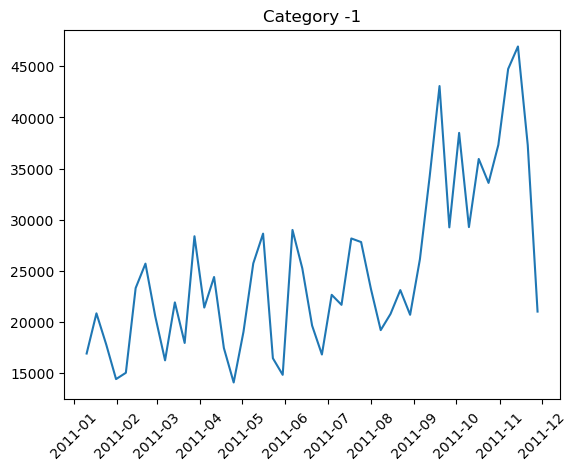

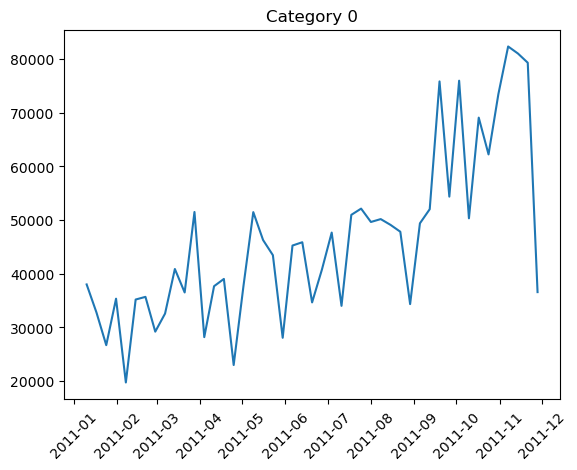

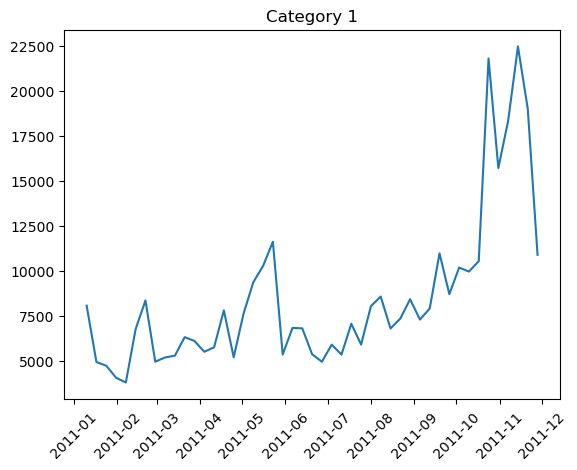

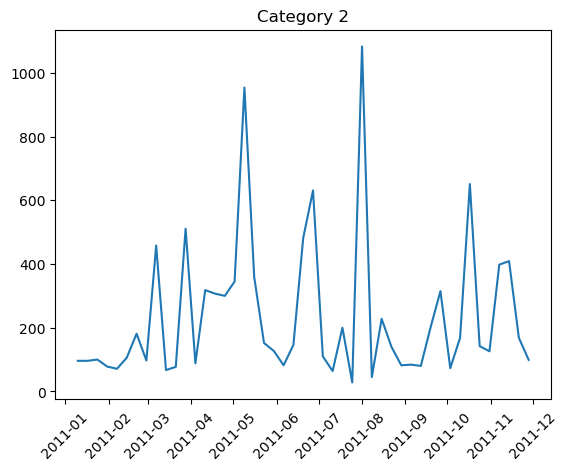

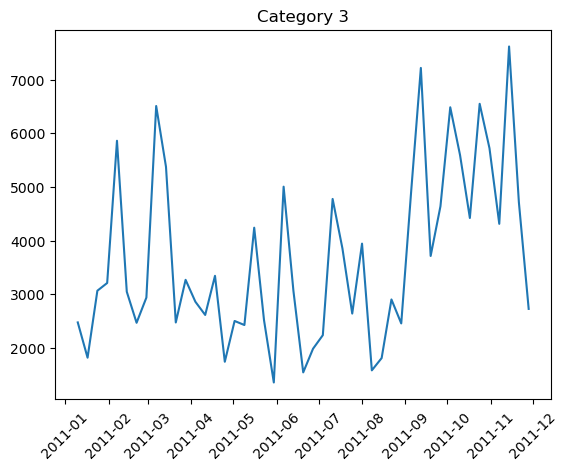

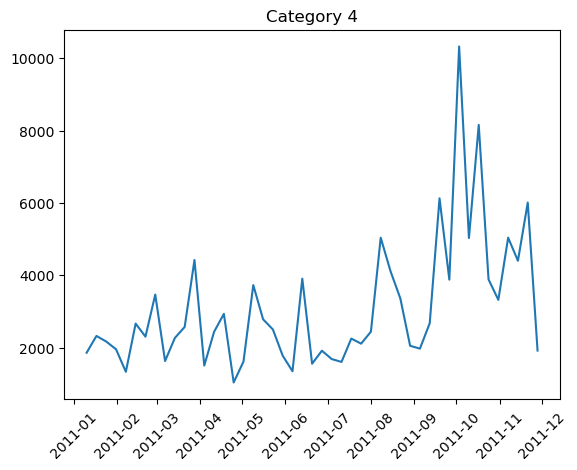

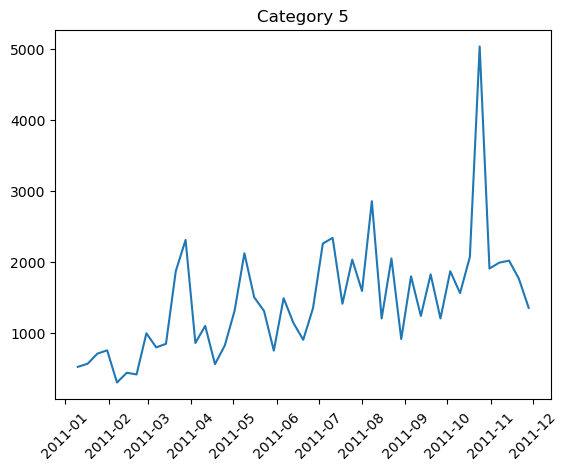

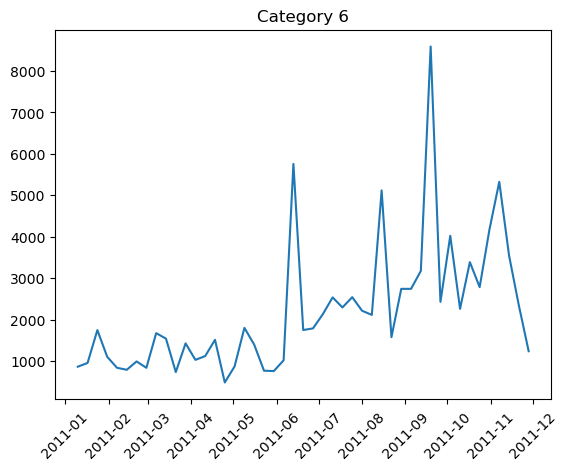

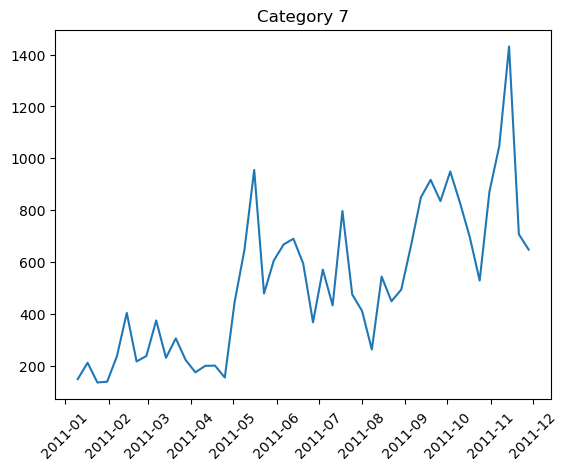

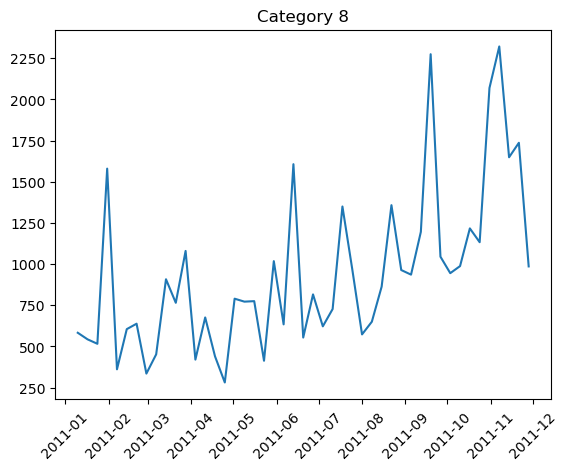

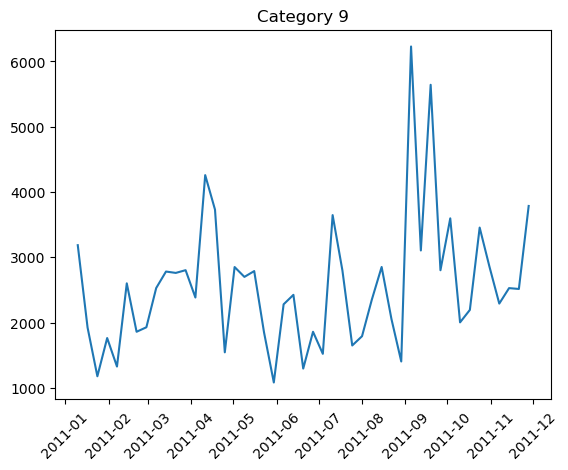

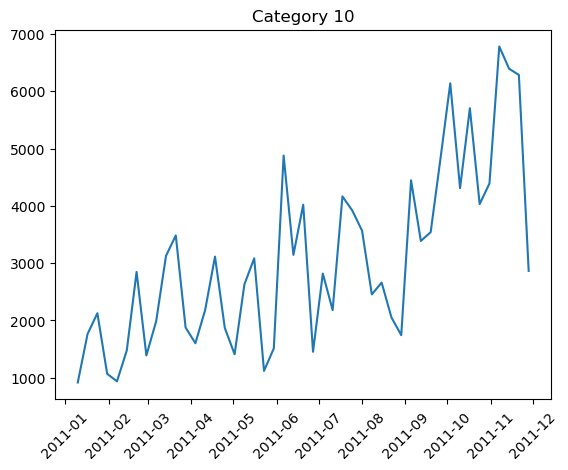

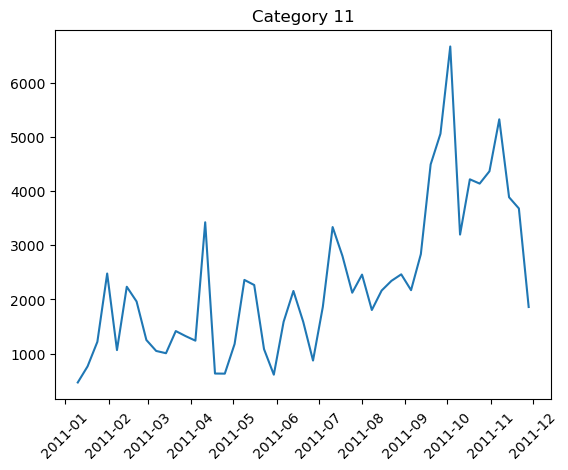

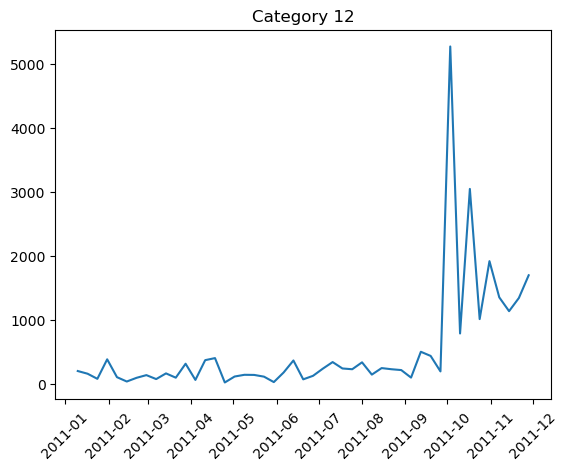

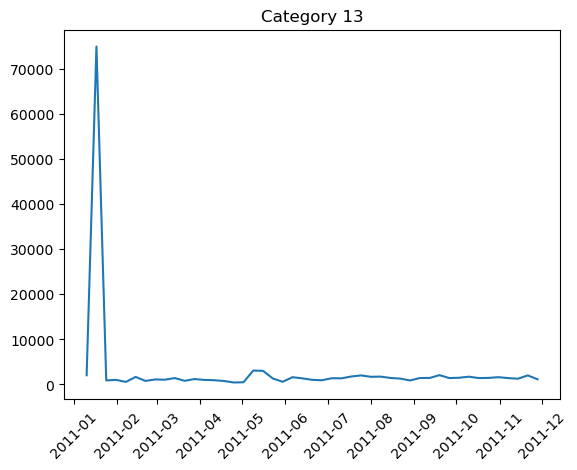

In [11]:
for column in sales_data.columns:
    plt.plot(sales_data[column])
    plt.title(f'Category {column}')
    plt.xticks(rotation = 45)
    plt.show()

<h2>5.3 Hyperparameter Tuning</h2>

In [13]:
changepoint_prior_scale_range = np.linspace(0.01, 1, num=5).tolist()
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
seasonality_mode = ['multiplicative', 'additive']

In [14]:
dicts = {}

period_weeks = 4
horizon_weeks = 4
initial_weeks = 42

# Converting weeks to days for the model
period_days = period_weeks * 7
horizon_days = horizon_weeks * 7
initial_days = initial_weeks * 7


for category in sales_data.columns:
  
    category_df = sales_data[category].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range,
        "holidays_prior_scale": holidays_prior_scale_range,
        "seasonality_mode": seasonality_mode
        
    }


    # Creating all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = [] 


    # Evaluating all parameters using cross validation
    for params in all_params:
        m = Prophet(**params).fit(category_df) 
        df_cv = cross_validation(m, initial=f"{initial_days} days", period=f"{period_days} days", horizon=f"{horizon_days} days")
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        mapes.append(df_p["mape"].values[0])

    # Finding the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    
    print(category)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
    params_dict["column"] = category 
    
    dicts[category] = params_dict

14:56:27 - cmdstanpy - INFO - Chain [1] start processing
14:56:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:27 - cmdstanpy - INFO - Chain [1] start processing
14:56:27 - cmdstanpy - INFO - Chain [1] done processing
14:56:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:28 - cmdstanpy - INFO - Chain [1] start processing
14:56:28 - cmdstanpy - INFO - Chain [1] done processing
14:56:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:29 - cmdstanpy - INFO - Chain [1] start processing
14:56:29 - cmdstanpy - INFO - Chain [1] done processing
14:56:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:29 - cmdstanpy - INFO - Chain [1] start processing
14:56:30 - cmdstanpy - INFO - Chain [1] done processing
14:56:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:30 - cmdstanpy - INFO - Chain [1] start processing
14:56:30 - cmdstanpy - INFO - Chain [1] done processing
14:56:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:31 - cmdstanpy - INFO - Chain [1] start processing
14:56:31 - cmdstanpy - INFO - Chain [1] done processing
14:56:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:32 - cmdstanpy - INFO - Chain [1] start processing
14:56:32 - cmdstanpy - INFO - Chain [1] done processing
14:56:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:33 - cmdstanpy - INFO - Chain [1] start processing
14:56:33 - cmdstanpy - INFO - Chain [1] done processing
14:56:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:34 - cmdstanpy - INFO - Chain [1] start processing
14:56:34 - cmdstanpy - INFO - Chain [1] done processing
14:56:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:35 - cmdstanpy - INFO - Chain [1] start processing
14:56:35 - cmdstanpy - INFO - Chain [1] done processing
14:56:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:35 - cmdstanpy - INFO - Chain [1] start processing
14:56:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:36 - cmdstanpy - INFO - Chain [1] start processing
14:56:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:36 - cmdstanpy - INFO - Chain [1] start processing
14:56:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:38 - cmdstanpy - INFO - Chain [1] start processing
14:56:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:38 - cmdstanpy - INFO - Chain [1] start processing
14:56:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:39 - cmdstanpy - INFO - Chain [1] start processing
14:56:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:39 - cmdstanpy - INFO - Chain [1] start processing
14:56:39 - cmdstanpy - INFO - Chain [1] done processing
14:56:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:40 - cmdstanpy - INFO - Chain [1] start processing
14:56:40 - cmdstanpy - INFO - Chain [1] done processing
14:56:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:41 - cmdstanpy - INFO - Chain [1] start processing
14:56:41 - cmdstanpy - INFO - Chain [1] done processing
14:56:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:42 - cmdstanpy - INFO - Chain [1] start processing
14:56:42 - cmdstanpy - INFO - Chain [1] done processing
14:56:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:42 - cmdstanpy - INFO - Chain [1] start processing
14:56:42 - cmdstanpy - INFO - Chain [1] done processing
14:56:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:43 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] done processing
14:56:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:45 - cmdstanpy - INFO - Chain [1] start processing
14:56:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:45 - cmdstanpy - INFO - Chain [1] start processing
14:56:45 - cmdstanpy - INFO - Chain [1] done processing
14:56:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:46 - cmdstanpy - INFO - Chain [1] start processing
14:56:46 - cmdstanpy - INFO - Chain [1] done processing
14:56:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:47 - cmdstanpy - INFO - Chain [1] start processing
14:56:47 - cmdstanpy - INFO - Chain [1] done processing
14:56:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:47 - cmdstanpy - INFO - Chain [1] start processing
14:56:48 - cmdstanpy - INFO - Chain [1] done processing
14:56:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:48 - cmdstanpy - INFO - Chain [1] start processing
14:56:48 - cmdstanpy - INFO - Chain [1] done processing
14:56:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:49 - cmdstanpy - INFO - Chain [1] start processing
14:56:49 - cmdstanpy - INFO - Chain [1] done processing
14:56:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:50 - cmdstanpy - INFO - Chain [1] done processing
14:56:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:51 - cmdstanpy - INFO - Chain [1] start processing
14:56:51 - cmdstanpy - INFO - Chain [1] done processing
14:56:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:52 - cmdstanpy - INFO - Chain [1] start processing
14:56:52 - cmdstanpy - INFO - Chain [1] done processing
14:56:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:53 - cmdstanpy - INFO - Chain [1] start processing
14:56:53 - cmdstanpy - INFO - Chain [1] done processing
14:56:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:53 - cmdstanpy - INFO - Chain [1] start processing
14:56:53 - cmdstanpy - INFO - Chain [1] done processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] done processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:55 - cmdstanpy - INFO - Chain [1] start processing
14:56:55 - cmdstanpy - INFO - Chain [1] done processing
14:56:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:56 - cmdstanpy - INFO - Chain [1] start processing
14:56:56 - cmdstanpy - INFO - Chain [1] done processing
14:56:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:56 - cmdstanpy - INFO - Chain [1] start processing
14:56:57 - cmdstanpy - INFO - Chain [1] done processing
14:56:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:57 - cmdstanpy - INFO - Chain [1] start processing
14:56:57 - cmdstanpy - INFO - Chain [1] done processing
14:56:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:58 - cmdstanpy - INFO - Chain [1] start processing
14:56:58 - cmdstanpy - INFO - Chain [1] done processing
14:56:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:56:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:56:59 - cmdstanpy - INFO - Chain [1] start processing
14:56:59 - cmdstanpy - INFO - Chain [1] done processing
14:57:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:57:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:00 - cmdstanpy - INFO - Chain [1] start processing
14:57:00 - cmdstanpy - INFO - Chain [1] done processing
14:57:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:57:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:01 - cmdstanpy - INFO - Chain [1] start processing
14:57:01 - cmdstanpy - INFO - Chain [1] done processing
14:57:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:57:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:02 - cmdstanpy - INFO - Chain [1] start processing
14:57:02 - cmdstanpy - INFO - Chain [1] done processing
14:57:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:57:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:03 - cmdstanpy - INFO - Chain [1] start processing
14:57:03 - cmdstanpy - INFO - Chain [1] done processing
14:57:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:57:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:04 - cmdstanpy - INFO - Chain [1] start processing
14:57:04 - cmdstanpy - INFO - Chain [1] done processing
14:57:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:57:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:05 - cmdstanpy - INFO - Chain [1] start processing
14:57:05 - cmdstanpy - INFO - Chain [1] done processing
14:57:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:57:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:06 - cmdstanpy - INFO - Chain [1] start processing
14:57:06 - cmdstanpy - INFO - Chain [1] done processing
14:57:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:57:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:06 - cmdstanpy - INFO - Chain [1] start processing
14:57:06 - cmdstanpy - INFO - Chain [1] done processing
14:57:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:57:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:07 - cmdstanpy - INFO - Chain [1] start processing
14:57:07 - cmdstanpy - INFO - Chain [1] done processing
14:57:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:57:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:08 - cmdstanpy - INFO - Chain [1] start processing
14:57:08 - cmdstanpy - INFO - Chain [1] done processing
14:57:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:57:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:09 - cmdstanpy - INFO - Chain [1] start processing
14:57:09 - cmdstanpy - INFO - Chain [1] done processing
14:57:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:57:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:10 - cmdstanpy - INFO - Chain [1] start processing
14:57:10 - cmdstanpy - INFO - Chain [1] done processing
14:57:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  1.353321e+08  11633.233778  10988.070432  0.322939  0.297591   

      smape  coverage  
0  0.318984      0.25  


14:57:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:11 - cmdstanpy - INFO - Chain [1] start processing
14:57:11 - cmdstanpy - INFO - Chain [1] done processing
14:57:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:12 - cmdstanpy - INFO - Chain [1] start processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:13 - cmdstanpy - INFO - Chain [1] start processing
14:57:13 - cmdstanpy - INFO - Chain [1] done processing
14:57:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:14 - cmdstanpy - INFO - Chain [1] start processing
14:57:14 - cmdstanpy - INFO - Chain [1] done processing
14:57:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:15 - cmdstanpy - INFO - Chain [1] start processing
14:57:15 - cmdstanpy - INFO - Chain [1] done processing
14:57:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:16 - cmdstanpy - INFO - Chain [1] start processing
14:57:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:17 - cmdstanpy - INFO - Chain [1] start processing
14:57:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:17 - cmdstanpy - INFO - Chain [1] start processing
14:57:17 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:19 - cmdstanpy - INFO - Chain [1] done processing
14:57:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:19 - cmdstanpy - INFO - Chain [1] start processing
14:57:20 - cmdstanpy - INFO - Chain [1] done processing
14:57:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:20 - cmdstanpy - INFO - Chain [1] start processing
14:57:21 - cmdstanpy - INFO - Chain [1] done processing
14:57:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:22 - cmdstanpy - INFO - Chain [1] start processing
14:57:22 - cmdstanpy - INFO - Chain [1] done processing
14:57:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:23 - cmdstanpy - INFO - Chain [1] start processing
14:57:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:24 - cmdstanpy - INFO - Chain [1] start processing
14:57:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:24 - cmdstanpy - INFO - Chain [1] start processing
14:57:25 - cmdstanpy - INFO - Chain [1] done processing
14:57:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:25 - cmdstanpy - INFO - Chain [1] start processing
14:57:26 - cmdstanpy - INFO - Chain [1] done processing
14:57:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:27 - cmdstanpy - INFO - Chain [1] start processing
14:57:27 - cmdstanpy - INFO - Chain [1] done processing
14:57:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:28 - cmdstanpy - INFO - Chain [1] start processing
14:57:28 - cmdstanpy - INFO - Chain [1] done processing
14:57:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:29 - cmdstanpy - INFO - Chain [1] start processing
14:57:29 - cmdstanpy - INFO - Chain [1] done processing
14:57:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:31 - cmdstanpy - INFO - Chain [1] start processing
14:57:31 - cmdstanpy - INFO - Chain [1] done processing
14:57:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:32 - cmdstanpy - INFO - Chain [1] start processing
14:57:32 - cmdstanpy - INFO - Chain [1] done processing
14:57:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:33 - cmdstanpy - INFO - Chain [1] start processing
14:57:33 - cmdstanpy - INFO - Chain [1] done processing
14:57:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:34 - cmdstanpy - INFO - Chain [1] start processing
14:57:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:35 - cmdstanpy - INFO - Chain [1] start processing
14:57:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:35 - cmdstanpy - INFO - Chain [1] start processing
14:57:36 - cmdstanpy - INFO - Chain [1] done processing
14:57:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:37 - cmdstanpy - INFO - Chain [1] start processing
14:57:37 - cmdstanpy - INFO - Chain [1] done processing
14:57:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:38 - cmdstanpy - INFO - Chain [1] start processing
14:57:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:39 - cmdstanpy - INFO - Chain [1] start processing
14:57:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:39 - cmdstanpy - INFO - Chain [1] start processing
14:57:39 - cmdstanpy - INFO - Chain [1] done processing
14:57:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:40 - cmdstanpy - INFO - Chain [1] start processing
14:57:41 - cmdstanpy - INFO - Chain [1] done processing
14:57:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:41 - cmdstanpy - INFO - Chain [1] start processing
14:57:42 - cmdstanpy - INFO - Chain [1] done processing
14:57:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:42 - cmdstanpy - INFO - Chain [1] start processing
14:57:43 - cmdstanpy - INFO - Chain [1] done processing
14:57:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:43 - cmdstanpy - INFO - Chain [1] start processing
14:57:44 - cmdstanpy - INFO - Chain [1] done processing
14:57:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:45 - cmdstanpy - INFO - Chain [1] start processing
14:57:45 - cmdstanpy - INFO - Chain [1] done processing
14:57:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:45 - cmdstanpy - INFO - Chain [1] start processing
14:57:46 - cmdstanpy - INFO - Chain [1] done processing
14:57:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:46 - cmdstanpy - INFO - Chain [1] start processing
14:57:47 - cmdstanpy - INFO - Chain [1] done processing
14:57:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:47 - cmdstanpy - INFO - Chain [1] start processing
14:57:48 - cmdstanpy - INFO - Chain [1] done processing
14:57:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:48 - cmdstanpy - INFO - Chain [1] start processing
14:57:49 - cmdstanpy - INFO - Chain [1] done processing
14:57:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:49 - cmdstanpy - INFO - Chain [1] start processing
14:57:49 - cmdstanpy - INFO - Chain [1] done processing
14:57:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:50 - cmdstanpy - INFO - Chain [1] start processing
14:57:51 - cmdstanpy - INFO - Chain [1] done processing
14:57:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:52 - cmdstanpy - INFO - Chain [1] start processing
14:57:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:53 - cmdstanpy - INFO - Chain [1] start processing
14:57:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:53 - cmdstanpy - INFO - Chain [1] start processing
14:57:53 - cmdstanpy - INFO - Chain [1] done processing
14:57:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:54 - cmdstanpy - INFO - Chain [1] start processing
14:57:54 - cmdstanpy - INFO - Chain [1] done processing
14:57:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:55 - cmdstanpy - INFO - Chain [1] start processing
14:57:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:56 - cmdstanpy - INFO - Chain [1] start processing
14:57:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:56 - cmdstanpy - INFO - Chain [1] start processing
14:57:56 - cmdstanpy - INFO - Chain [1] done processing
14:57:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:57 - cmdstanpy - INFO - Chain [1] start processing
14:57:58 - cmdstanpy - INFO - Chain [1] done processing
14:57:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:58 - cmdstanpy - INFO - Chain [1] start processing
14:57:58 - cmdstanpy - INFO - Chain [1] done processing
14:57:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:57:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:57:59 - cmdstanpy - INFO - Chain [1] start processing
14:58:00 - cmdstanpy - INFO - Chain [1] done processing
14:58:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:58:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:00 - cmdstanpy - INFO - Chain [1] start processing
14:58:01 - cmdstanpy - INFO - Chain [1] done processing
14:58:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:58:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:01 - cmdstanpy - INFO - Chain [1] start processing
14:58:02 - cmdstanpy - INFO - Chain [1] done processing
14:58:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:58:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:02 - cmdstanpy - INFO - Chain [1] start processing
14:58:03 - cmdstanpy - INFO - Chain [1] done processing
14:58:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:58:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:03 - cmdstanpy - INFO - Chain [1] start processing
14:58:04 - cmdstanpy - INFO - Chain [1] done processing
14:58:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:58:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:04 - cmdstanpy - INFO - Chain [1] start processing
14:58:05 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:58:05 - cmdstanpy - INFO - Chain [1] start processing
14:58:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:06 - cmdstanpy - INFO - Chain [1] start processing
14:58:06 - cmdstanpy - INFO - Chain [1] done processing
14:58:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.239473e+08  11133.16245  9277.498189  0.324355  0.184573   

     smape  coverage  
0  0.26523      0.25  


14:58:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:07 - cmdstanpy - INFO - Chain [1] start processing
14:58:07 - cmdstanpy - INFO - Chain [1] done processing
14:58:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:08 - cmdstanpy - INFO - Chain [1] start processing
14:58:08 - cmdstanpy - INFO - Chain [1] done processing
14:58:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:09 - cmdstanpy - INFO - Chain [1] start processing
14:58:10 - cmdstanpy - INFO - Chain [1] done processing
14:58:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:10 - cmdstanpy - INFO - Chain [1] start processing
14:58:11 - cmdstanpy - INFO - Chain [1] done processing
14:58:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:12 - cmdstanpy - INFO - Chain [1] start processing
14:58:12 - cmdstanpy - INFO - Chain [1] done processing
14:58:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:13 - cmdstanpy - INFO - Chain [1] start processing
14:58:13 - cmdstanpy - INFO - Chain [1] done processing
14:58:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:14 - cmdstanpy - INFO - Chain [1] start processing
14:58:14 - cmdstanpy - INFO - Chain [1] done processing
14:58:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:15 - cmdstanpy - INFO - Chain [1] start processing
14:58:15 - cmdstanpy - INFO - Chain [1] done processing
14:58:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:16 - cmdstanpy - INFO - Chain [1] start processing
14:58:16 - cmdstanpy - INFO - Chain [1] done processing
14:58:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:17 - cmdstanpy - INFO - Chain [1] start processing
14:58:17 - cmdstanpy - INFO - Chain [1] done processing
14:58:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:18 - cmdstanpy - INFO - Chain [1] start processing
14:58:18 - cmdstanpy - INFO - Chain [1] done processing
14:58:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:19 - cmdstanpy - INFO - Chain [1] start processing
14:58:19 - cmdstanpy - INFO - Chain [1] done processing
14:58:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:20 - cmdstanpy - INFO - Chain [1] start processing
14:58:21 - cmdstanpy - INFO - Chain [1] done processing
14:58:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:22 - cmdstanpy - INFO - Chain [1] start processing
14:58:22 - cmdstanpy - INFO - Chain [1] done processing
14:58:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:23 - cmdstanpy - INFO - Chain [1] start processing
14:58:23 - cmdstanpy - INFO - Chain [1] done processing
14:58:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:24 - cmdstanpy - INFO - Chain [1] start processing
14:58:24 - cmdstanpy - INFO - Chain [1] done processing
14:58:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:25 - cmdstanpy - INFO - Chain [1] start processing
14:58:25 - cmdstanpy - INFO - Chain [1] done processing
14:58:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:26 - cmdstanpy - INFO - Chain [1] start processing
14:58:26 - cmdstanpy - INFO - Chain [1] done processing
14:58:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:27 - cmdstanpy - INFO - Chain [1] start processing
14:58:28 - cmdstanpy - INFO - Chain [1] done processing
14:58:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:29 - cmdstanpy - INFO - Chain [1] start processing
14:58:29 - cmdstanpy - INFO - Chain [1] done processing
14:58:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424       0.5  


14:58:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:30 - cmdstanpy - INFO - Chain [1] start processing
14:58:30 - cmdstanpy - INFO - Chain [1] done processing
14:58:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:31 - cmdstanpy - INFO - Chain [1] start processing
14:58:31 - cmdstanpy - INFO - Chain [1] done processing
14:58:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:32 - cmdstanpy - INFO - Chain [1] start processing
14:58:32 - cmdstanpy - INFO - Chain [1] done processing
14:58:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:33 - cmdstanpy - INFO - Chain [1] start processing
14:58:33 - cmdstanpy - INFO - Chain [1] done processing
14:58:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:34 - cmdstanpy - INFO - Chain [1] start processing
14:58:35 - cmdstanpy - INFO - Chain [1] done processing
14:58:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:35 - cmdstanpy - INFO - Chain [1] start processing
14:58:36 - cmdstanpy - INFO - Chain [1] done processing
14:58:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:36 - cmdstanpy - INFO - Chain [1] start processing
14:58:37 - cmdstanpy - INFO - Chain [1] done processing
14:58:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:38 - cmdstanpy - INFO - Chain [1] start processing
14:58:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:38 - cmdstanpy - INFO - Chain [1] start processing
14:58:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:39 - cmdstanpy - INFO - Chain [1] start processing
14:58:39 - cmdstanpy - INFO - Chain [1] done processing
14:58:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:40 - cmdstanpy - INFO - Chain [1] start processing
14:58:40 - cmdstanpy - INFO - Chain [1] done processing
14:58:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:41 - cmdstanpy - INFO - Chain [1] start processing
14:58:41 - cmdstanpy - INFO - Chain [1] done processing
14:58:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:42 - cmdstanpy - INFO - Chain [1] start processing
14:58:42 - cmdstanpy - INFO - Chain [1] done processing
14:58:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:43 - cmdstanpy - INFO - Chain [1] start processing
14:58:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:44 - cmdstanpy - INFO - Chain [1] start processing
14:58:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:44 - cmdstanpy - INFO - Chain [1] start processing
14:58:44 - cmdstanpy - INFO - Chain [1] done processing
14:58:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:45 - cmdstanpy - INFO - Chain [1] start processing
14:58:45 - cmdstanpy - INFO - Chain [1] done processing
14:58:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:46 - cmdstanpy - INFO - Chain [1] start processing
14:58:47 - cmdstanpy - INFO - Chain [1] done processing
14:58:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:47 - cmdstanpy - INFO - Chain [1] start processing
14:58:48 - cmdstanpy - INFO - Chain [1] done processing
14:58:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:49 - cmdstanpy - INFO - Chain [1] start processing
14:58:49 - cmdstanpy - INFO - Chain [1] done processing
14:58:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:50 - cmdstanpy - INFO - Chain [1] start processing
14:58:50 - cmdstanpy - INFO - Chain [1] done processing
14:58:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:51 - cmdstanpy - INFO - Chain [1] start processing
14:58:51 - cmdstanpy - INFO - Chain [1] done processing
14:58:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:52 - cmdstanpy - INFO - Chain [1] start processing
14:58:52 - cmdstanpy - INFO - Chain [1] done processing
14:58:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:53 - cmdstanpy - INFO - Chain [1] start processing
14:58:53 - cmdstanpy - INFO - Chain [1] done processing
14:58:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:54 - cmdstanpy - INFO - Chain [1] start processing
14:58:54 - cmdstanpy - INFO - Chain [1] done processing
14:58:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:55 - cmdstanpy - INFO - Chain [1] start processing
14:58:55 - cmdstanpy - INFO - Chain [1] done processing
14:58:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:56 - cmdstanpy - INFO - Chain [1] start processing
14:58:57 - cmdstanpy - INFO - Chain [1] done processing
14:58:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:58 - cmdstanpy - INFO - Chain [1] start processing
14:58:58 - cmdstanpy - INFO - Chain [1] done processing
14:58:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:58:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:58:59 - cmdstanpy - INFO - Chain [1] start processing
14:58:59 - cmdstanpy - INFO - Chain [1] done processing
14:59:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:59:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:00 - cmdstanpy - INFO - Chain [1] start processing
14:59:00 - cmdstanpy - INFO - Chain [1] done processing
14:59:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:59:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:01 - cmdstanpy - INFO - Chain [1] start processing
14:59:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:59:02 - cmdstanpy - INFO - Chain [1] start processing
14:59:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:03 - cmdstanpy - INFO - Chain [1] start processing
14:59:03 - cmdstanpy - INFO - Chain [1] done processing
14:59:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.324230e+08  11507.518494  9440.022095  0.341289  0.154903   

      smape  coverage  
0  0.267424      0.25  


14:59:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:04 - cmdstanpy - INFO - Chain [1] start processing
14:59:04 - cmdstanpy - INFO - Chain [1] done processing
14:59:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:05 - cmdstanpy - INFO - Chain [1] start processing
14:59:05 - cmdstanpy - INFO - Chain [1] done processing
14:59:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:06 - cmdstanpy - INFO - Chain [1] start processing
14:59:07 - cmdstanpy - INFO - Chain [1] done processing
14:59:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:07 - cmdstanpy - INFO - Chain [1] start processing
14:59:08 - cmdstanpy - INFO - Chain [1] done processing
14:59:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:08 - cmdstanpy - INFO - Chain [1] start processing
14:59:09 - cmdstanpy - INFO - Chain [1] done processing
14:59:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:10 - cmdstanpy - INFO - Chain [1] start processing
14:59:10 - cmdstanpy - INFO - Chain [1] done processing
14:59:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:11 - cmdstanpy - INFO - Chain [1] start processing
14:59:11 - cmdstanpy - INFO - Chain [1] done processing
14:59:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:12 - cmdstanpy - INFO - Chain [1] start processing
14:59:12 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:13 - cmdstanpy - INFO - Chain [1] start processing
14:59:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:13 - cmdstanpy - INFO - Chain [1] start processing
14:59:14 - cmdstanpy - INFO - Chain [1] done processing
14:59:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:14 - cmdstanpy - INFO - Chain [1] start processing
14:59:15 - cmdstanpy - INFO - Chain [1] done processing
14:59:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794       0.5  


14:59:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:16 - cmdstanpy - INFO - Chain [1] start processing
14:59:16 - cmdstanpy - INFO - Chain [1] done processing
14:59:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:17 - cmdstanpy - INFO - Chain [1] start processing
14:59:17 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:18 - cmdstanpy - INFO - Chain [1] start processing
14:59:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:18 - cmdstanpy - INFO - Chain [1] start processing
14:59:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:20 - cmdstanpy - INFO - Chain [1] start processing
14:59:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:20 - cmdstanpy - INFO - Chain [1] start processing
14:59:21 - cmdstanpy - INFO - Chain [1] done processing
14:59:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794       0.5  


14:59:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:21 - cmdstanpy - INFO - Chain [1] start processing
14:59:22 - cmdstanpy - INFO - Chain [1] done processing
14:59:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:23 - cmdstanpy - INFO - Chain [1] start processing
14:59:23 - cmdstanpy - INFO - Chain [1] done processing
14:59:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:24 - cmdstanpy - INFO - Chain [1] start processing
14:59:24 - cmdstanpy - INFO - Chain [1] done processing
14:59:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:25 - cmdstanpy - INFO - Chain [1] start processing
14:59:25 - cmdstanpy - INFO - Chain [1] done processing
14:59:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:26 - cmdstanpy - INFO - Chain [1] start processing
14:59:27 - cmdstanpy - INFO - Chain [1] done processing
14:59:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:27 - cmdstanpy - INFO - Chain [1] start processing
14:59:28 - cmdstanpy - INFO - Chain [1] done processing
14:59:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:29 - cmdstanpy - INFO - Chain [1] start processing
14:59:29 - cmdstanpy - INFO - Chain [1] done processing
14:59:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:30 - cmdstanpy - INFO - Chain [1] start processing
14:59:30 - cmdstanpy - INFO - Chain [1] done processing
14:59:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:31 - cmdstanpy - INFO - Chain [1] start processing
14:59:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794       0.5  


14:59:32 - cmdstanpy - INFO - Chain [1] start processing
14:59:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:32 - cmdstanpy - INFO - Chain [1] start processing
14:59:33 - cmdstanpy - INFO - Chain [1] done processing
14:59:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:34 - cmdstanpy - INFO - Chain [1] start processing
14:59:34 - cmdstanpy - INFO - Chain [1] done processing
14:59:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:35 - cmdstanpy - INFO - Chain [1] start processing
14:59:35 - cmdstanpy - INFO - Chain [1] done processing
14:59:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:36 - cmdstanpy - INFO - Chain [1] start processing
14:59:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:37 - cmdstanpy - INFO - Chain [1] start processing
14:59:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:38 - cmdstanpy - INFO - Chain [1] start processing
14:59:38 - cmdstanpy - INFO - Chain [1] done processing
14:59:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:39 - cmdstanpy - INFO - Chain [1] start processing
14:59:39 - cmdstanpy - INFO - Chain [1] done processing
14:59:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:40 - cmdstanpy - INFO - Chain [1] start processing
14:59:41 - cmdstanpy - INFO - Chain [1] done processing
14:59:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:41 - cmdstanpy - INFO - Chain [1] start processing
14:59:42 - cmdstanpy - INFO - Chain [1] done processing
14:59:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:43 - cmdstanpy - INFO - Chain [1] start processing
14:59:43 - cmdstanpy - INFO - Chain [1] done processing
14:59:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:44 - cmdstanpy - INFO - Chain [1] start processing
14:59:44 - cmdstanpy - INFO - Chain [1] done processing
14:59:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:45 - cmdstanpy - INFO - Chain [1] start processing
14:59:46 - cmdstanpy - INFO - Chain [1] done processing
14:59:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:47 - cmdstanpy - INFO - Chain [1] start processing
14:59:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:47 - cmdstanpy - INFO - Chain [1] start processing
14:59:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:48 - cmdstanpy - INFO - Chain [1] start processing
14:59:48 - cmdstanpy - INFO - Chain [1] done processing
14:59:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:49 - cmdstanpy - INFO - Chain [1] start processing
14:59:49 - cmdstanpy - INFO - Chain [1] done processing
14:59:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:50 - cmdstanpy - INFO - Chain [1] start processing
14:59:51 - cmdstanpy - INFO - Chain [1] done processing
14:59:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794       0.5  


14:59:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:52 - cmdstanpy - INFO - Chain [1] start processing
14:59:52 - cmdstanpy - INFO - Chain [1] done processing
14:59:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:53 - cmdstanpy - INFO - Chain [1] start processing
14:59:54 - cmdstanpy - INFO - Chain [1] done processing
14:59:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:54 - cmdstanpy - INFO - Chain [1] start processing
14:59:55 - cmdstanpy - INFO - Chain [1] done processing
14:59:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:56 - cmdstanpy - INFO - Chain [1] start processing
14:59:56 - cmdstanpy - INFO - Chain [1] done processing
14:59:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:57 - cmdstanpy - INFO - Chain [1] start processing
14:59:57 - cmdstanpy - INFO - Chain [1] done processing
14:59:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:58 - cmdstanpy - INFO - Chain [1] start processing
14:59:58 - cmdstanpy - INFO - Chain [1] done processing
14:59:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


14:59:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

14:59:59 - cmdstanpy - INFO - Chain [1] start processing
15:00:00 - cmdstanpy - INFO - Chain [1] done processing
15:00:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


15:00:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:01 - cmdstanpy - INFO - Chain [1] start processing
15:00:01 - cmdstanpy - INFO - Chain [1] done processing
15:00:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


15:00:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:02 - cmdstanpy - INFO - Chain [1] start processing
15:00:03 - cmdstanpy - INFO - Chain [1] done processing
15:00:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794       0.5  


15:00:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:03 - cmdstanpy - INFO - Chain [1] start processing
15:00:04 - cmdstanpy - INFO - Chain [1] done processing
15:00:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


15:00:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:05 - cmdstanpy - INFO - Chain [1] start processing
15:00:05 - cmdstanpy - INFO - Chain [1] done processing
15:00:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


15:00:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:06 - cmdstanpy - INFO - Chain [1] start processing
15:00:06 - cmdstanpy - INFO - Chain [1] done processing
15:00:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  1.358112e+08  11653.805623  9485.943275  0.346268  0.145969   

     smape  coverage  
0  0.26794      0.25  


15:00:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:07 - cmdstanpy - INFO - Chain [1] start processing
15:00:08 - cmdstanpy - INFO - Chain [1] done processing
15:00:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293       0.5  


15:00:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:08 - cmdstanpy - INFO - Chain [1] start processing
15:00:09 - cmdstanpy - INFO - Chain [1] done processing
15:00:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:10 - cmdstanpy - INFO - Chain [1] start processing
15:00:10 - cmdstanpy - INFO - Chain [1] done processing
15:00:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293       0.5  


15:00:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:11 - cmdstanpy - INFO - Chain [1] start processing
15:00:12 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:12 - cmdstanpy - INFO - Chain [1] start processing
15:00:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:13 - cmdstanpy - INFO - Chain [1] start processing
15:00:13 - cmdstanpy - INFO - Chain [1] done processing
15:00:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:14 - cmdstanpy - INFO - Chain [1] start processing
15:00:14 - cmdstanpy - INFO - Chain [1] done processing
15:00:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:15 - cmdstanpy - INFO - Chain [1] start processing
15:00:16 - cmdstanpy - INFO - Chain [1] done processing
15:00:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:17 - cmdstanpy - INFO - Chain [1] start processing
15:00:17 - cmdstanpy - INFO - Chain [1] done processing
15:00:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:18 - cmdstanpy - INFO - Chain [1] start processing
15:00:18 - cmdstanpy - INFO - Chain [1] done processing
15:00:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:19 - cmdstanpy - INFO - Chain [1] start processing
15:00:20 - cmdstanpy - INFO - Chain [1] done processing
15:00:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293       0.5  


15:00:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:21 - cmdstanpy - INFO - Chain [1] start processing
15:00:21 - cmdstanpy - INFO - Chain [1] done processing
15:00:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:22 - cmdstanpy - INFO - Chain [1] start processing
15:00:22 - cmdstanpy - INFO - Chain [1] done processing
15:00:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:23 - cmdstanpy - INFO - Chain [1] start processing
15:00:24 - cmdstanpy - INFO - Chain [1] done processing
15:00:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:25 - cmdstanpy - INFO - Chain [1] start processing
15:00:25 - cmdstanpy - INFO - Chain [1] done processing
15:00:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:26 - cmdstanpy - INFO - Chain [1] start processing
15:00:26 - cmdstanpy - INFO - Chain [1] done processing
15:00:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:27 - cmdstanpy - INFO - Chain [1] start processing
15:00:27 - cmdstanpy - INFO - Chain [1] done processing
15:00:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:29 - cmdstanpy - INFO - Chain [1] start processing
15:00:29 - cmdstanpy - INFO - Chain [1] done processing
15:00:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:30 - cmdstanpy - INFO - Chain [1] start processing
15:00:30 - cmdstanpy - INFO - Chain [1] done processing
15:00:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293       0.5  


15:00:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:31 - cmdstanpy - INFO - Chain [1] start processing
15:00:32 - cmdstanpy - INFO - Chain [1] done processing
15:00:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:33 - cmdstanpy - INFO - Chain [1] start processing
15:00:33 - cmdstanpy - INFO - Chain [1] done processing
15:00:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:34 - cmdstanpy - INFO - Chain [1] start processing
15:00:34 - cmdstanpy - INFO - Chain [1] done processing
15:00:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:35 - cmdstanpy - INFO - Chain [1] start processing
15:00:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:36 - cmdstanpy - INFO - Chain [1] start processing
15:00:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:37 - cmdstanpy - INFO - Chain [1] start processing
15:00:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:37 - cmdstanpy - INFO - Chain [1] start processing
15:00:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:38 - cmdstanpy - INFO - Chain [1] start processing
15:00:38 - cmdstanpy - INFO - Chain [1] done processing
15:00:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:39 - cmdstanpy - INFO - Chain [1] start processing
15:00:40 - cmdstanpy - INFO - Chain [1] done processing
15:00:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293       0.5  


15:00:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:41 - cmdstanpy - INFO - Chain [1] start processing
15:00:41 - cmdstanpy - INFO - Chain [1] done processing
15:00:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:42 - cmdstanpy - INFO - Chain [1] start processing
15:00:43 - cmdstanpy - INFO - Chain [1] done processing
15:00:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:44 - cmdstanpy - INFO - Chain [1] start processing
15:00:44 - cmdstanpy - INFO - Chain [1] done processing
15:00:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293       0.5  


15:00:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:45 - cmdstanpy - INFO - Chain [1] start processing
15:00:45 - cmdstanpy - INFO - Chain [1] done processing
15:00:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:46 - cmdstanpy - INFO - Chain [1] start processing
15:00:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:47 - cmdstanpy - INFO - Chain [1] start processing
15:00:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:48 - cmdstanpy - INFO - Chain [1] start processing
15:00:48 - cmdstanpy - INFO - Chain [1] done processing
15:00:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293       0.5  


15:00:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:49 - cmdstanpy - INFO - Chain [1] start processing
15:00:49 - cmdstanpy - INFO - Chain [1] done processing
15:00:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:50 - cmdstanpy - INFO - Chain [1] start processing
15:00:51 - cmdstanpy - INFO - Chain [1] done processing
15:00:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:52 - cmdstanpy - INFO - Chain [1] start processing
15:00:52 - cmdstanpy - INFO - Chain [1] done processing
15:00:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:53 - cmdstanpy - INFO - Chain [1] start processing
15:00:53 - cmdstanpy - INFO - Chain [1] done processing
15:00:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:54 - cmdstanpy - INFO - Chain [1] start processing
15:00:55 - cmdstanpy - INFO - Chain [1] done processing
15:00:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:56 - cmdstanpy - INFO - Chain [1] start processing
15:00:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:57 - cmdstanpy - INFO - Chain [1] start processing
15:00:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:57 - cmdstanpy - INFO - Chain [1] start processing
15:00:58 - cmdstanpy - INFO - Chain [1] done processing
15:00:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:00:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:00:59 - cmdstanpy - INFO - Chain [1] start processing
15:00:59 - cmdstanpy - INFO - Chain [1] done processing
15:01:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293       0.5  


15:01:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:00 - cmdstanpy - INFO - Chain [1] start processing
15:01:01 - cmdstanpy - INFO - Chain [1] done processing
15:01:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:01:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:01 - cmdstanpy - INFO - Chain [1] start processing
15:01:02 - cmdstanpy - INFO - Chain [1] done processing
15:01:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:01:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:03 - cmdstanpy - INFO - Chain [1] start processing
15:01:03 - cmdstanpy - INFO - Chain [1] done processing
15:01:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293       0.5  


15:01:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:04 - cmdstanpy - INFO - Chain [1] start processing
15:01:05 - cmdstanpy - INFO - Chain [1] done processing
15:01:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:01:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:06 - cmdstanpy - INFO - Chain [1] start processing
15:01:06 - cmdstanpy - INFO - Chain [1] done processing
15:01:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:01:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:07 - cmdstanpy - INFO - Chain [1] start processing
15:01:07 - cmdstanpy - INFO - Chain [1] done processing
15:01:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:01:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:08 - cmdstanpy - INFO - Chain [1] start processing
15:01:09 - cmdstanpy - INFO - Chain [1] done processing
15:01:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:01:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:10 - cmdstanpy - INFO - Chain [1] start processing
15:01:10 - cmdstanpy - INFO - Chain [1] done processing
15:01:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:01:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:11 - cmdstanpy - INFO - Chain [1] start processing
15:01:11 - cmdstanpy - INFO - Chain [1] done processing
15:01:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  


15:01:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:12 - cmdstanpy - INFO - Chain [1] start processing
15:01:13 - cmdstanpy - INFO - Chain [1] done processing
15:01:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293       0.5  


15:01:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:14 - cmdstanpy - INFO - Chain [1] start processing
15:01:14 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse         mae      mape     mdape  \
0 28 days  1.381057e+08  11751.836115  9516.02684  0.349338  0.140661   

      smape  coverage  
0  0.268293      0.25  
-1
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.322939  
1         additive  0.322939  
2   multiplicative  0.322939  
3         additive  0.322939  
4   multiplicative  0.322939  


15:01:15 - cmdstanpy - INFO - Chain [1] start processing
15:01:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:15 - cmdstanpy - INFO - Chain [1] start processing
15:01:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:16 - cmdstanpy - INFO - Chain [1] start processing
15:01:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:16 - cmdstanpy - INFO - Chain [1] start processing
15:01:16 - cmdstanpy - INFO - Chain [1] done processing
15:01:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:17 - cmdstanpy - INFO - Chain [1] start processing
15:01:17 - cmdstanpy - INFO - Chain [1] done processing
15:01:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:18 - cmdstanpy - INFO - Chain [1] start processing
15:01:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:18 - cmdstanpy - INFO - Chain [1] start processing
15:01:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:19 - cmdstanpy - INFO - Chain [1] start processing
15:01:19 - cmdstanpy - INFO - Chain [1] done processing
15:01:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:20 - cmdstanpy - INFO - Chain [1] start processing
15:01:20 - cmdstanpy - INFO - Chain [1] done processing
15:01:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:21 - cmdstanpy - INFO - Chain [1] start processing
15:01:21 - cmdstanpy - INFO - Chain [1] done processing
15:01:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:22 - cmdstanpy - INFO - Chain [1] start processing
15:01:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:22 - cmdstanpy - INFO - Chain [1] start processing
15:01:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:23 - cmdstanpy - INFO - Chain [1] start processing
15:01:23 - cmdstanpy - INFO - Chain [1] done processing
15:01:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:23 - cmdstanpy - INFO - Chain [1] start processing
15:01:24 - cmdstanpy - INFO - Chain [1] done processing
15:01:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:24 - cmdstanpy - INFO - Chain [1] start processing
15:01:24 - cmdstanpy - INFO - Chain [1] done processing
15:01:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:25 - cmdstanpy - INFO - Chain [1] start processing
15:01:25 - cmdstanpy - INFO - Chain [1] done processing
15:01:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:26 - cmdstanpy - INFO - Chain [1] start processing
15:01:26 - cmdstanpy - INFO - Chain [1] done processing
15:01:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:27 - cmdstanpy - INFO - Chain [1] start processing
15:01:27 - cmdstanpy - INFO - Chain [1] done processing
15:01:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:28 - cmdstanpy - INFO - Chain [1] start processing
15:01:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:28 - cmdstanpy - INFO - Chain [1] start processing
15:01:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:29 - cmdstanpy - INFO - Chain [1] start processing
15:01:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:29 - cmdstanpy - INFO - Chain [1] start processing
15:01:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:30 - cmdstanpy - INFO - Chain [1] start processing
15:01:30 - cmdstanpy - INFO - Chain [1] done processing
15:01:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:31 - cmdstanpy - INFO - Chain [1] start processing
15:01:31 - cmdstanpy - INFO - Chain [1] done processing
15:01:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:32 - cmdstanpy - INFO - Chain [1] start processing
15:01:32 - cmdstanpy - INFO - Chain [1] done processing
15:01:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:33 - cmdstanpy - INFO - Chain [1] start processing
15:01:33 - cmdstanpy - INFO - Chain [1] done processing
15:01:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:34 - cmdstanpy - INFO - Chain [1] start processing
15:01:34 - cmdstanpy - INFO - Chain [1] done processing
15:01:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:34 - cmdstanpy - INFO - Chain [1] start processing
15:01:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:35 - cmdstanpy - INFO - Chain [1] start processing
15:01:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:36 - cmdstanpy - INFO - Chain [1] start processing
15:01:36 - cmdstanpy - INFO - Chain [1] done processing
15:01:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:37 - cmdstanpy - INFO - Chain [1] start processing
15:01:37 - cmdstanpy - INFO - Chain [1] done processing
15:01:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:37 - cmdstanpy - INFO - Chain [1] start processing
15:01:38 - cmdstanpy - INFO - Chain [1] done processing
15:01:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:38 - cmdstanpy - INFO - Chain [1] start processing
15:01:39 - cmdstanpy - INFO - Chain [1] done processing
15:01:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:39 - cmdstanpy - INFO - Chain [1] start processing
15:01:39 - cmdstanpy - INFO - Chain [1] done processing
15:01:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:40 - cmdstanpy - INFO - Chain [1] start processing
15:01:40 - cmdstanpy - INFO - Chain [1] done processing
15:01:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:41 - cmdstanpy - INFO - Chain [1] start processing
15:01:41 - cmdstanpy - INFO - Chain [1] done processing
15:01:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:42 - cmdstanpy - INFO - Chain [1] start processing
15:01:42 - cmdstanpy - INFO - Chain [1] done processing
15:01:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:43 - cmdstanpy - INFO - Chain [1] start processing
15:01:43 - cmdstanpy - INFO - Chain [1] done processing
15:01:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:43 - cmdstanpy - INFO - Chain [1] start processing
15:01:44 - cmdstanpy - INFO - Chain [1] done processing
15:01:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:44 - cmdstanpy - INFO - Chain [1] start processing
15:01:44 - cmdstanpy - INFO - Chain [1] done processing
15:01:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:45 - cmdstanpy - INFO - Chain [1] start processing
15:01:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:46 - cmdstanpy - INFO - Chain [1] start processing
15:01:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:46 - cmdstanpy - INFO - Chain [1] start processing
15:01:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:47 - cmdstanpy - INFO - Chain [1] start processing
15:01:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:47 - cmdstanpy - INFO - Chain [1] start processing
15:01:47 - cmdstanpy - INFO - Chain [1] done processing
15:01:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:48 - cmdstanpy - INFO - Chain [1] start processing
15:01:48 - cmdstanpy - INFO - Chain [1] done processing
15:01:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:49 - cmdstanpy - INFO - Chain [1] start processing
15:01:49 - cmdstanpy - INFO - Chain [1] done processing
15:01:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:50 - cmdstanpy - INFO - Chain [1] start processing
15:01:50 - cmdstanpy - INFO - Chain [1] done processing
15:01:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:51 - cmdstanpy - INFO - Chain [1] start processing
15:01:51 - cmdstanpy - INFO - Chain [1] done processing
15:01:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:52 - cmdstanpy - INFO - Chain [1] start processing
15:01:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:52 - cmdstanpy - INFO - Chain [1] start processing
15:01:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:53 - cmdstanpy - INFO - Chain [1] start processing
15:01:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:54 - cmdstanpy - INFO - Chain [1] start processing
15:01:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:54 - cmdstanpy - INFO - Chain [1] start processing
15:01:54 - cmdstanpy - INFO - Chain [1] done processing
15:01:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:55 - cmdstanpy - INFO - Chain [1] start processing
15:01:55 - cmdstanpy - INFO - Chain [1] done processing
15:01:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:56 - cmdstanpy - INFO - Chain [1] start processing
15:01:56 - cmdstanpy - INFO - Chain [1] done processing
15:01:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:57 - cmdstanpy - INFO - Chain [1] start processing
15:01:57 - cmdstanpy - INFO - Chain [1] done processing
15:01:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:58 - cmdstanpy - INFO - Chain [1] start processing
15:01:58 - cmdstanpy - INFO - Chain [1] done processing
15:01:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:58 - cmdstanpy - INFO - Chain [1] start processing
15:01:59 - cmdstanpy - INFO - Chain [1] done processing
15:01:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:01:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:01:59 - cmdstanpy - INFO - Chain [1] start processing
15:01:59 - cmdstanpy - INFO - Chain [1] done processing
15:02:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:02:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:00 - cmdstanpy - INFO - Chain [1] start processing
15:02:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae     mape     mdape  \
0 28 days  4.450671e+08  21096.614249  20635.488212  0.35844  0.238304   

      smape  coverage  
0  0.328242       0.0  


15:02:01 - cmdstanpy - INFO - Chain [1] start processing
15:02:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:01 - cmdstanpy - INFO - Chain [1] start processing
15:02:01 - cmdstanpy - INFO - Chain [1] done processing
15:02:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127       0.0  


15:02:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:02 - cmdstanpy - INFO - Chain [1] start processing
15:02:03 - cmdstanpy - INFO - Chain [1] done processing
15:02:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:03 - cmdstanpy - INFO - Chain [1] start processing
15:02:04 - cmdstanpy - INFO - Chain [1] done processing
15:02:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127       0.0  


15:02:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:05 - cmdstanpy - INFO - Chain [1] start processing
15:02:05 - cmdstanpy - INFO - Chain [1] done processing
15:02:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:06 - cmdstanpy - INFO - Chain [1] start processing
15:02:06 - cmdstanpy - INFO - Chain [1] done processing
15:02:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:07 - cmdstanpy - INFO - Chain [1] start processing
15:02:07 - cmdstanpy - INFO - Chain [1] done processing
15:02:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:08 - cmdstanpy - INFO - Chain [1] start processing
15:02:08 - cmdstanpy - INFO - Chain [1] done processing
15:02:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:09 - cmdstanpy - INFO - Chain [1] start processing
15:02:09 - cmdstanpy - INFO - Chain [1] done processing
15:02:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:10 - cmdstanpy - INFO - Chain [1] start processing
15:02:11 - cmdstanpy - INFO - Chain [1] done processing
15:02:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:11 - cmdstanpy - INFO - Chain [1] start processing
15:02:12 - cmdstanpy - INFO - Chain [1] done processing
15:02:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:12 - cmdstanpy - INFO - Chain [1] start processing
15:02:13 - cmdstanpy - INFO - Chain [1] done processing
15:02:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:14 - cmdstanpy - INFO - Chain [1] start processing
15:02:14 - cmdstanpy - INFO - Chain [1] done processing
15:02:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:15 - cmdstanpy - INFO - Chain [1] start processing
15:02:15 - cmdstanpy - INFO - Chain [1] done processing
15:02:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127       0.0  


15:02:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:16 - cmdstanpy - INFO - Chain [1] start processing
15:02:17 - cmdstanpy - INFO - Chain [1] done processing
15:02:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:18 - cmdstanpy - INFO - Chain [1] start processing
15:02:18 - cmdstanpy - INFO - Chain [1] done processing
15:02:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:19 - cmdstanpy - INFO - Chain [1] start processing
15:02:19 - cmdstanpy - INFO - Chain [1] done processing
15:02:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:20 - cmdstanpy - INFO - Chain [1] start processing
15:02:20 - cmdstanpy - INFO - Chain [1] done processing
15:02:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127       0.0  


15:02:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:21 - cmdstanpy - INFO - Chain [1] start processing
15:02:22 - cmdstanpy - INFO - Chain [1] done processing
15:02:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:22 - cmdstanpy - INFO - Chain [1] start processing
15:02:23 - cmdstanpy - INFO - Chain [1] done processing
15:02:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:24 - cmdstanpy - INFO - Chain [1] start processing
15:02:24 - cmdstanpy - INFO - Chain [1] done processing
15:02:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:25 - cmdstanpy - INFO - Chain [1] start processing
15:02:25 - cmdstanpy - INFO - Chain [1] done processing
15:02:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:26 - cmdstanpy - INFO - Chain [1] start processing
15:02:26 - cmdstanpy - INFO - Chain [1] done processing
15:02:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:27 - cmdstanpy - INFO - Chain [1] start processing
15:02:27 - cmdstanpy - INFO - Chain [1] done processing
15:02:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:28 - cmdstanpy - INFO - Chain [1] start processing
15:02:29 - cmdstanpy - INFO - Chain [1] done processing
15:02:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127       0.0  


15:02:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:29 - cmdstanpy - INFO - Chain [1] start processing
15:02:30 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:30 - cmdstanpy - INFO - Chain [1] start processing
15:02:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:31 - cmdstanpy - INFO - Chain [1] start processing
15:02:31 - cmdstanpy - INFO - Chain [1] done processing
15:02:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:32 - cmdstanpy - INFO - Chain [1] start processing
15:02:32 - cmdstanpy - INFO - Chain [1] done processing
15:02:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:33 - cmdstanpy - INFO - Chain [1] start processing
15:02:33 - cmdstanpy - INFO - Chain [1] done processing
15:02:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:34 - cmdstanpy - INFO - Chain [1] start processing
15:02:34 - cmdstanpy - INFO - Chain [1] done processing
15:02:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127       0.0  


15:02:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:35 - cmdstanpy - INFO - Chain [1] start processing
15:02:35 - cmdstanpy - INFO - Chain [1] done processing
15:02:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:36 - cmdstanpy - INFO - Chain [1] start processing
15:02:36 - cmdstanpy - INFO - Chain [1] done processing
15:02:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:37 - cmdstanpy - INFO - Chain [1] start processing
15:02:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:38 - cmdstanpy - INFO - Chain [1] start processing
15:02:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:38 - cmdstanpy - INFO - Chain [1] start processing
15:02:39 - cmdstanpy - INFO - Chain [1] done processing
15:02:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:40 - cmdstanpy - INFO - Chain [1] start processing
15:02:40 - cmdstanpy - INFO - Chain [1] done processing
15:02:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:41 - cmdstanpy - INFO - Chain [1] start processing
15:02:41 - cmdstanpy - INFO - Chain [1] done processing
15:02:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:42 - cmdstanpy - INFO - Chain [1] start processing
15:02:42 - cmdstanpy - INFO - Chain [1] done processing
15:02:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127       0.0  


15:02:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:43 - cmdstanpy - INFO - Chain [1] start processing
15:02:44 - cmdstanpy - INFO - Chain [1] done processing
15:02:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:45 - cmdstanpy - INFO - Chain [1] start processing
15:02:45 - cmdstanpy - INFO - Chain [1] done processing
15:02:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:46 - cmdstanpy - INFO - Chain [1] start processing
15:02:46 - cmdstanpy - INFO - Chain [1] done processing
15:02:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:47 - cmdstanpy - INFO - Chain [1] start processing
15:02:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:48 - cmdstanpy - INFO - Chain [1] start processing
15:02:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:48 - cmdstanpy - INFO - Chain [1] start processing
15:02:48 - cmdstanpy - INFO - Chain [1] done processing
15:02:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127       0.0  


15:02:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:49 - cmdstanpy - INFO - Chain [1] start processing
15:02:50 - cmdstanpy - INFO - Chain [1] done processing
15:02:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:50 - cmdstanpy - INFO - Chain [1] start processing
15:02:51 - cmdstanpy - INFO - Chain [1] done processing
15:02:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:52 - cmdstanpy - INFO - Chain [1] start processing
15:02:52 - cmdstanpy - INFO - Chain [1] done processing
15:02:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:53 - cmdstanpy - INFO - Chain [1] start processing
15:02:53 - cmdstanpy - INFO - Chain [1] done processing
15:02:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:54 - cmdstanpy - INFO - Chain [1] start processing
15:02:54 - cmdstanpy - INFO - Chain [1] done processing
15:02:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:55 - cmdstanpy - INFO - Chain [1] start processing
15:02:55 - cmdstanpy - INFO - Chain [1] done processing
15:02:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:56 - cmdstanpy - INFO - Chain [1] start processing
15:02:57 - cmdstanpy - INFO - Chain [1] done processing
15:02:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:57 - cmdstanpy - INFO - Chain [1] start processing
15:02:58 - cmdstanpy - INFO - Chain [1] done processing
15:02:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:02:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:02:59 - cmdstanpy - INFO - Chain [1] start processing
15:02:59 - cmdstanpy - INFO - Chain [1] done processing
15:02:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse          mae      mape     mdape  \
0 28 days  4.195556e+08  20483.056204  18154.05254  0.352168  0.174347   

      smape  coverage  
0  0.288127      0.25  


15:03:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:00 - cmdstanpy - INFO - Chain [1] start processing
15:03:00 - cmdstanpy - INFO - Chain [1] done processing
15:03:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:01 - cmdstanpy - INFO - Chain [1] start processing
15:03:01 - cmdstanpy - INFO - Chain [1] done processing
15:03:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:02 - cmdstanpy - INFO - Chain [1] start processing
15:03:03 - cmdstanpy - INFO - Chain [1] done processing
15:03:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:03 - cmdstanpy - INFO - Chain [1] start processing
15:03:04 - cmdstanpy - INFO - Chain [1] done processing
15:03:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:04 - cmdstanpy - INFO - Chain [1] start processing
15:03:05 - cmdstanpy - INFO - Chain [1] done processing
15:03:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:06 - cmdstanpy - INFO - Chain [1] start processing
15:03:06 - cmdstanpy - INFO - Chain [1] done processing
15:03:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:07 - cmdstanpy - INFO - Chain [1] start processing
15:03:07 - cmdstanpy - INFO - Chain [1] done processing
15:03:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:08 - cmdstanpy - INFO - Chain [1] start processing
15:03:08 - cmdstanpy - INFO - Chain [1] done processing
15:03:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:09 - cmdstanpy - INFO - Chain [1] start processing
15:03:09 - cmdstanpy - INFO - Chain [1] done processing
15:03:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:10 - cmdstanpy - INFO - Chain [1] start processing
15:03:11 - cmdstanpy - INFO - Chain [1] done processing
15:03:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:12 - cmdstanpy - INFO - Chain [1] start processing
15:03:12 - cmdstanpy - INFO - Chain [1] done processing
15:03:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:13 - cmdstanpy - INFO - Chain [1] start processing
15:03:13 - cmdstanpy - INFO - Chain [1] done processing
15:03:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:14 - cmdstanpy - INFO - Chain [1] start processing
15:03:15 - cmdstanpy - INFO - Chain [1] done processing
15:03:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:15 - cmdstanpy - INFO - Chain [1] start processing
15:03:16 - cmdstanpy - INFO - Chain [1] done processing
15:03:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:17 - cmdstanpy - INFO - Chain [1] start processing
15:03:17 - cmdstanpy - INFO - Chain [1] done processing
15:03:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:18 - cmdstanpy - INFO - Chain [1] start processing
15:03:18 - cmdstanpy - INFO - Chain [1] done processing
15:03:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:19 - cmdstanpy - INFO - Chain [1] start processing
15:03:20 - cmdstanpy - INFO - Chain [1] done processing
15:03:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:20 - cmdstanpy - INFO - Chain [1] start processing
15:03:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:21 - cmdstanpy - INFO - Chain [1] start processing
15:03:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:22 - cmdstanpy - INFO - Chain [1] start processing
15:03:22 - cmdstanpy - INFO - Chain [1] done processing
15:03:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:23 - cmdstanpy - INFO - Chain [1] start processing
15:03:24 - cmdstanpy - INFO - Chain [1] done processing
15:03:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:25 - cmdstanpy - INFO - Chain [1] start processing
15:03:25 - cmdstanpy - INFO - Chain [1] done processing
15:03:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:26 - cmdstanpy - INFO - Chain [1] start processing
15:03:26 - cmdstanpy - INFO - Chain [1] done processing
15:03:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:27 - cmdstanpy - INFO - Chain [1] start processing
15:03:28 - cmdstanpy - INFO - Chain [1] done processing
15:03:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:29 - cmdstanpy - INFO - Chain [1] start processing
15:03:29 - cmdstanpy - INFO - Chain [1] done processing
15:03:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:30 - cmdstanpy - INFO - Chain [1] start processing
15:03:30 - cmdstanpy - INFO - Chain [1] done processing
15:03:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:31 - cmdstanpy - INFO - Chain [1] start processing
15:03:31 - cmdstanpy - INFO - Chain [1] done processing
15:03:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:32 - cmdstanpy - INFO - Chain [1] start processing
15:03:32 - cmdstanpy - INFO - Chain [1] done processing
15:03:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:33 - cmdstanpy - INFO - Chain [1] start processing
15:03:34 - cmdstanpy - INFO - Chain [1] done processing
15:03:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:34 - cmdstanpy - INFO - Chain [1] start processing
15:03:35 - cmdstanpy - INFO - Chain [1] done processing
15:03:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:36 - cmdstanpy - INFO - Chain [1] start processing
15:03:36 - cmdstanpy - INFO - Chain [1] done processing
15:03:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:37 - cmdstanpy - INFO - Chain [1] start processing
15:03:37 - cmdstanpy - INFO - Chain [1] done processing
15:03:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:38 - cmdstanpy - INFO - Chain [1] start processing
15:03:38 - cmdstanpy - INFO - Chain [1] done processing
15:03:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:39 - cmdstanpy - INFO - Chain [1] start processing
15:03:39 - cmdstanpy - INFO - Chain [1] done processing
15:03:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:40 - cmdstanpy - INFO - Chain [1] start processing
15:03:41 - cmdstanpy - INFO - Chain [1] done processing
15:03:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:42 - cmdstanpy - INFO - Chain [1] start processing
15:03:42 - cmdstanpy - INFO - Chain [1] done processing
15:03:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:43 - cmdstanpy - INFO - Chain [1] start processing
15:03:44 - cmdstanpy - INFO - Chain [1] done processing
15:03:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:45 - cmdstanpy - INFO - Chain [1] start processing
15:03:45 - cmdstanpy - INFO - Chain [1] done processing
15:03:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:46 - cmdstanpy - INFO - Chain [1] start processing
15:03:46 - cmdstanpy - INFO - Chain [1] done processing
15:03:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:47 - cmdstanpy - INFO - Chain [1] start processing
15:03:47 - cmdstanpy - INFO - Chain [1] done processing
15:03:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:48 - cmdstanpy - INFO - Chain [1] start processing
15:03:48 - cmdstanpy - INFO - Chain [1] done processing
15:03:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:49 - cmdstanpy - INFO - Chain [1] start processing
15:03:49 - cmdstanpy - INFO - Chain [1] done processing
15:03:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:50 - cmdstanpy - INFO - Chain [1] start processing
15:03:51 - cmdstanpy - INFO - Chain [1] done processing
15:03:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:52 - cmdstanpy - INFO - Chain [1] start processing
15:03:52 - cmdstanpy - INFO - Chain [1] done processing
15:03:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:53 - cmdstanpy - INFO - Chain [1] start processing
15:03:53 - cmdstanpy - INFO - Chain [1] done processing
15:03:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:54 - cmdstanpy - INFO - Chain [1] start processing
15:03:55 - cmdstanpy - INFO - Chain [1] done processing
15:03:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:55 - cmdstanpy - INFO - Chain [1] start processing
15:03:56 - cmdstanpy - INFO - Chain [1] done processing
15:03:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:57 - cmdstanpy - INFO - Chain [1] start processing
15:03:57 - cmdstanpy - INFO - Chain [1] done processing
15:03:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:58 - cmdstanpy - INFO - Chain [1] done processing
15:03:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:03:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:03:59 - cmdstanpy - INFO - Chain [1] start processing
15:03:59 - cmdstanpy - INFO - Chain [1] done processing
15:04:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:04:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:00 - cmdstanpy - INFO - Chain [1] start processing
15:04:01 - cmdstanpy - INFO - Chain [1] done processing
15:04:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.548205e+08  21326.521905  16283.447892  0.349765  0.124844   

      smape  coverage  
0  0.258831       0.5  


15:04:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:02 - cmdstanpy - INFO - Chain [1] start processing
15:04:02 - cmdstanpy - INFO - Chain [1] done processing
15:04:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:03 - cmdstanpy - INFO - Chain [1] start processing
15:04:03 - cmdstanpy - INFO - Chain [1] done processing
15:04:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:04 - cmdstanpy - INFO - Chain [1] start processing
15:04:04 - cmdstanpy - INFO - Chain [1] done processing
15:04:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:05 - cmdstanpy - INFO - Chain [1] start processing
15:04:05 - cmdstanpy - INFO - Chain [1] done processing
15:04:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:06 - cmdstanpy - INFO - Chain [1] start processing
15:04:06 - cmdstanpy - INFO - Chain [1] done processing
15:04:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:07 - cmdstanpy - INFO - Chain [1] start processing
15:04:07 - cmdstanpy - INFO - Chain [1] done processing
15:04:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896      0.75  


15:04:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:08 - cmdstanpy - INFO - Chain [1] start processing
15:04:09 - cmdstanpy - INFO - Chain [1] done processing
15:04:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:10 - cmdstanpy - INFO - Chain [1] start processing
15:04:10 - cmdstanpy - INFO - Chain [1] done processing
15:04:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:11 - cmdstanpy - INFO - Chain [1] start processing
15:04:11 - cmdstanpy - INFO - Chain [1] done processing
15:04:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:12 - cmdstanpy - INFO - Chain [1] start processing
15:04:12 - cmdstanpy - INFO - Chain [1] done processing
15:04:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:13 - cmdstanpy - INFO - Chain [1] start processing
15:04:13 - cmdstanpy - INFO - Chain [1] done processing
15:04:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:14 - cmdstanpy - INFO - Chain [1] start processing
15:04:14 - cmdstanpy - INFO - Chain [1] done processing
15:04:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896      0.75  


15:04:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:15 - cmdstanpy - INFO - Chain [1] start processing
15:04:15 - cmdstanpy - INFO - Chain [1] done processing
15:04:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896      0.75  


15:04:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:16 - cmdstanpy - INFO - Chain [1] start processing
15:04:16 - cmdstanpy - INFO - Chain [1] done processing
15:04:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:17 - cmdstanpy - INFO - Chain [1] start processing
15:04:17 - cmdstanpy - INFO - Chain [1] done processing
15:04:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:18 - cmdstanpy - INFO - Chain [1] start processing
15:04:18 - cmdstanpy - INFO - Chain [1] done processing
15:04:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:19 - cmdstanpy - INFO - Chain [1] start processing
15:04:20 - cmdstanpy - INFO - Chain [1] done processing
15:04:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:21 - cmdstanpy - INFO - Chain [1] start processing
15:04:21 - cmdstanpy - INFO - Chain [1] done processing
15:04:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:22 - cmdstanpy - INFO - Chain [1] start processing
15:04:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:22 - cmdstanpy - INFO - Chain [1] start processing
15:04:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:23 - cmdstanpy - INFO - Chain [1] start processing
15:04:23 - cmdstanpy - INFO - Chain [1] done processing
15:04:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896      0.75  


15:04:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:24 - cmdstanpy - INFO - Chain [1] start processing
15:04:24 - cmdstanpy - INFO - Chain [1] done processing
15:04:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:25 - cmdstanpy - INFO - Chain [1] start processing
15:04:25 - cmdstanpy - INFO - Chain [1] done processing
15:04:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:26 - cmdstanpy - INFO - Chain [1] start processing
15:04:27 - cmdstanpy - INFO - Chain [1] done processing
15:04:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:27 - cmdstanpy - INFO - Chain [1] start processing
15:04:28 - cmdstanpy - INFO - Chain [1] done processing
15:04:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:29 - cmdstanpy - INFO - Chain [1] start processing
15:04:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:29 - cmdstanpy - INFO - Chain [1] start processing
15:04:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:30 - cmdstanpy - INFO - Chain [1] start processing
15:04:30 - cmdstanpy - INFO - Chain [1] done processing
15:04:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:31 - cmdstanpy - INFO - Chain [1] start processing
15:04:31 - cmdstanpy - INFO - Chain [1] done processing
15:04:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:32 - cmdstanpy - INFO - Chain [1] start processing
15:04:33 - cmdstanpy - INFO - Chain [1] done processing
15:04:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896      0.75  


15:04:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:34 - cmdstanpy - INFO - Chain [1] start processing
15:04:34 - cmdstanpy - INFO - Chain [1] done processing
15:04:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:35 - cmdstanpy - INFO - Chain [1] start processing
15:04:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:35 - cmdstanpy - INFO - Chain [1] start processing
15:04:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:36 - cmdstanpy - INFO - Chain [1] start processing
15:04:36 - cmdstanpy - INFO - Chain [1] done processing
15:04:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:37 - cmdstanpy - INFO - Chain [1] start processing
15:04:38 - cmdstanpy - INFO - Chain [1] done processing
15:04:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:39 - cmdstanpy - INFO - Chain [1] start processing
15:04:39 - cmdstanpy - INFO - Chain [1] done processing
15:04:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:40 - cmdstanpy - INFO - Chain [1] start processing
15:04:40 - cmdstanpy - INFO - Chain [1] done processing
15:04:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:41 - cmdstanpy - INFO - Chain [1] start processing
15:04:41 - cmdstanpy - INFO - Chain [1] done processing
15:04:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:42 - cmdstanpy - INFO - Chain [1] start processing
15:04:42 - cmdstanpy - INFO - Chain [1] done processing
15:04:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:43 - cmdstanpy - INFO - Chain [1] start processing
15:04:43 - cmdstanpy - INFO - Chain [1] done processing
15:04:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:44 - cmdstanpy - INFO - Chain [1] start processing
15:04:44 - cmdstanpy - INFO - Chain [1] done processing
15:04:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:45 - cmdstanpy - INFO - Chain [1] start processing
15:04:45 - cmdstanpy - INFO - Chain [1] done processing
15:04:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:46 - cmdstanpy - INFO - Chain [1] start processing
15:04:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:47 - cmdstanpy - INFO - Chain [1] start processing
15:04:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:47 - cmdstanpy - INFO - Chain [1] start processing
15:04:48 - cmdstanpy - INFO - Chain [1] done processing
15:04:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:49 - cmdstanpy - INFO - Chain [1] start processing
15:04:49 - cmdstanpy - INFO - Chain [1] done processing
15:04:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:50 - cmdstanpy - INFO - Chain [1] start processing
15:04:51 - cmdstanpy - INFO - Chain [1] done processing
15:04:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:51 - cmdstanpy - INFO - Chain [1] start processing
15:04:52 - cmdstanpy - INFO - Chain [1] done processing
15:04:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:53 - cmdstanpy - INFO - Chain [1] start processing
15:04:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896      0.75  


15:04:53 - cmdstanpy - INFO - Chain [1] start processing
15:04:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:54 - cmdstanpy - INFO - Chain [1] start processing
15:04:54 - cmdstanpy - INFO - Chain [1] done processing
15:04:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:55 - cmdstanpy - INFO - Chain [1] start processing
15:04:55 - cmdstanpy - INFO - Chain [1] done processing
15:04:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:56 - cmdstanpy - INFO - Chain [1] start processing
15:04:56 - cmdstanpy - INFO - Chain [1] done processing
15:04:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896      0.75  


15:04:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:57 - cmdstanpy - INFO - Chain [1] start processing
15:04:57 - cmdstanpy - INFO - Chain [1] done processing
15:04:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:04:58 - cmdstanpy - INFO - Chain [1] start processing
15:04:59 - cmdstanpy - INFO - Chain [1] done processing
15:04:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.745147e+08  21783.357965  15699.296488  0.348944  0.109425   

      smape  coverage  
0  0.249896       0.5  


15:04:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:00 - cmdstanpy - INFO - Chain [1] start processing
15:05:00 - cmdstanpy - INFO - Chain [1] done processing
15:05:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:01 - cmdstanpy - INFO - Chain [1] start processing
15:05:01 - cmdstanpy - INFO - Chain [1] done processing
15:05:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:02 - cmdstanpy - INFO - Chain [1] start processing
15:05:03 - cmdstanpy - INFO - Chain [1] done processing
15:05:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:04 - cmdstanpy - INFO - Chain [1] start processing
15:05:04 - cmdstanpy - INFO - Chain [1] done processing
15:05:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:05 - cmdstanpy - INFO - Chain [1] start processing
15:05:05 - cmdstanpy - INFO - Chain [1] done processing
15:05:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:06 - cmdstanpy - INFO - Chain [1] start processing
15:05:06 - cmdstanpy - INFO - Chain [1] done processing
15:05:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:07 - cmdstanpy - INFO - Chain [1] start processing
15:05:08 - cmdstanpy - INFO - Chain [1] done processing
15:05:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:08 - cmdstanpy - INFO - Chain [1] start processing
15:05:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:09 - cmdstanpy - INFO - Chain [1] start processing
15:05:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:10 - cmdstanpy - INFO - Chain [1] start processing
15:05:10 - cmdstanpy - INFO - Chain [1] done processing
15:05:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:11 - cmdstanpy - INFO - Chain [1] start processing
15:05:11 - cmdstanpy - INFO - Chain [1] done processing
15:05:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:12 - cmdstanpy - INFO - Chain [1] start processing
15:05:12 - cmdstanpy - INFO - Chain [1] done processing
15:05:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:13 - cmdstanpy - INFO - Chain [1] start processing
15:05:13 - cmdstanpy - INFO - Chain [1] done processing
15:05:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:14 - cmdstanpy - INFO - Chain [1] start processing
15:05:15 - cmdstanpy - INFO - Chain [1] done processing
15:05:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:15 - cmdstanpy - INFO - Chain [1] start processing
15:05:16 - cmdstanpy - INFO - Chain [1] done processing
15:05:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:17 - cmdstanpy - INFO - Chain [1] start processing
15:05:17 - cmdstanpy - INFO - Chain [1] done processing
15:05:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:18 - cmdstanpy - INFO - Chain [1] start processing
15:05:18 - cmdstanpy - INFO - Chain [1] done processing
15:05:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:19 - cmdstanpy - INFO - Chain [1] start processing
15:05:19 - cmdstanpy - INFO - Chain [1] done processing
15:05:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:20 - cmdstanpy - INFO - Chain [1] start processing
15:05:21 - cmdstanpy - INFO - Chain [1] done processing
15:05:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:22 - cmdstanpy - INFO - Chain [1] start processing
15:05:22 - cmdstanpy - INFO - Chain [1] done processing
15:05:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:23 - cmdstanpy - INFO - Chain [1] start processing
15:05:23 - cmdstanpy - INFO - Chain [1] done processing
15:05:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:24 - cmdstanpy - INFO - Chain [1] start processing
15:05:25 - cmdstanpy - INFO - Chain [1] done processing
15:05:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:25 - cmdstanpy - INFO - Chain [1] start processing
15:05:26 - cmdstanpy - INFO - Chain [1] done processing
15:05:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:27 - cmdstanpy - INFO - Chain [1] start processing
15:05:27 - cmdstanpy - INFO - Chain [1] done processing
15:05:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:28 - cmdstanpy - INFO - Chain [1] start processing
15:05:28 - cmdstanpy - INFO - Chain [1] done processing
15:05:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:29 - cmdstanpy - INFO - Chain [1] start processing
15:05:30 - cmdstanpy - INFO - Chain [1] done processing
15:05:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:30 - cmdstanpy - INFO - Chain [1] start processing
15:05:31 - cmdstanpy - INFO - Chain [1] done processing
15:05:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:32 - cmdstanpy - INFO - Chain [1] start processing
15:05:32 - cmdstanpy - INFO - Chain [1] done processing
15:05:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:33 - cmdstanpy - INFO - Chain [1] start processing
15:05:33 - cmdstanpy - INFO - Chain [1] done processing
15:05:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:34 - cmdstanpy - INFO - Chain [1] start processing
15:05:34 - cmdstanpy - INFO - Chain [1] done processing
15:05:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:35 - cmdstanpy - INFO - Chain [1] start processing
15:05:35 - cmdstanpy - INFO - Chain [1] done processing
15:05:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:36 - cmdstanpy - INFO - Chain [1] start processing
15:05:36 - cmdstanpy - INFO - Chain [1] done processing
15:05:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:37 - cmdstanpy - INFO - Chain [1] start processing
15:05:37 - cmdstanpy - INFO - Chain [1] done processing
15:05:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:38 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] done processing
15:05:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:40 - cmdstanpy - INFO - Chain [1] done processing
15:05:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:41 - cmdstanpy - INFO - Chain [1] start processing
15:05:41 - cmdstanpy - INFO - Chain [1] done processing
15:05:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:42 - cmdstanpy - INFO - Chain [1] start processing
15:05:42 - cmdstanpy - INFO - Chain [1] done processing
15:05:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:43 - cmdstanpy - INFO - Chain [1] start processing
15:05:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:44 - cmdstanpy - INFO - Chain [1] start processing
15:05:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:45 - cmdstanpy - INFO - Chain [1] start processing
15:05:45 - cmdstanpy - INFO - Chain [1] done processing
15:05:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:46 - cmdstanpy - INFO - Chain [1] start processing
15:05:46 - cmdstanpy - INFO - Chain [1] done processing
15:05:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:47 - cmdstanpy - INFO - Chain [1] start processing
15:05:48 - cmdstanpy - INFO - Chain [1] done processing
15:05:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:49 - cmdstanpy - INFO - Chain [1] start processing
15:05:49 - cmdstanpy - INFO - Chain [1] done processing
15:05:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:50 - cmdstanpy - INFO - Chain [1] start processing
15:05:50 - cmdstanpy - INFO - Chain [1] done processing
15:05:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:51 - cmdstanpy - INFO - Chain [1] start processing
15:05:52 - cmdstanpy - INFO - Chain [1] done processing
15:05:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:53 - cmdstanpy - INFO - Chain [1] start processing
15:05:53 - cmdstanpy - INFO - Chain [1] done processing
15:05:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:54 - cmdstanpy - INFO - Chain [1] start processing
15:05:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:55 - cmdstanpy - INFO - Chain [1] start processing
15:05:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:55 - cmdstanpy - INFO - Chain [1] start processing
15:05:56 - cmdstanpy - INFO - Chain [1] done processing
15:05:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:57 - cmdstanpy - INFO - Chain [1] start processing
15:05:57 - cmdstanpy - INFO - Chain [1] done processing
15:05:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945      0.75  


15:05:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:58 - cmdstanpy - INFO - Chain [1] start processing
15:05:58 - cmdstanpy - INFO - Chain [1] done processing
15:05:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:05:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:05:59 - cmdstanpy - INFO - Chain [1] start processing
15:05:59 - cmdstanpy - INFO - Chain [1] done processing
15:05:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  


15:06:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:00 - cmdstanpy - INFO - Chain [1] start processing
15:06:00 - cmdstanpy - INFO - Chain [1] done processing
15:06:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse          rmse           mae      mape     mdape  \
0 28 days  4.874991e+08  22079.381973  15373.099758  0.348513  0.100799   

      smape  coverage  
0  0.244945       0.5  
0
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode     mape  
0   multiplicative  0.35844  
1         additive  0.35844  
2   multiplicative  0.35844  
3         additive  0.35844  
4   multiplicative  0.35844  


15:06:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:01 - cmdstanpy - INFO - Chain [1] start processing
15:06:01 - cmdstanpy - INFO - Chain [1] done processing
15:06:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:02 - cmdstanpy - INFO - Chain [1] start processing
15:06:02 - cmdstanpy - INFO - Chain [1] done processing
15:06:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:03 - cmdstanpy - INFO - Chain [1] start processing
15:06:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:04 - cmdstanpy - INFO - Chain [1] start processing
15:06:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:04 - cmdstanpy - INFO - Chain [1] start processing
15:06:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:05 - cmdstanpy - INFO - Chain [1] start processing
15:06:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:06 - cmdstanpy - INFO - Chain [1] start processing
15:06:06 - cmdstanpy - INFO - Chain [1] done processing
15:06:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:07 - cmdstanpy - INFO - Chain [1] start processing
15:06:07 - cmdstanpy - INFO - Chain [1] done processing
15:06:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:08 - cmdstanpy - INFO - Chain [1] start processing
15:06:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:09 - cmdstanpy - INFO - Chain [1] start processing
15:06:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:09 - cmdstanpy - INFO - Chain [1] start processing
15:06:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:10 - cmdstanpy - INFO - Chain [1] start processing
15:06:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:10 - cmdstanpy - INFO - Chain [1] start processing
15:06:10 - cmdstanpy - INFO - Chain [1] done processing
15:06:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:11 - cmdstanpy - INFO - Chain [1] start processing
15:06:11 - cmdstanpy - INFO - Chain [1] done processing
15:06:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:12 - cmdstanpy - INFO - Chain [1] start processing
15:06:12 - cmdstanpy - INFO - Chain [1] done processing
15:06:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:12 - cmdstanpy - INFO - Chain [1] start processing
15:06:12 - cmdstanpy - INFO - Chain [1] done processing
15:06:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:13 - cmdstanpy - INFO - Chain [1] start processing
15:06:13 - cmdstanpy - INFO - Chain [1] done processing
15:06:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:14 - cmdstanpy - INFO - Chain [1] start processing
15:06:14 - cmdstanpy - INFO - Chain [1] done processing
15:06:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:15 - cmdstanpy - INFO - Chain [1] start processing
15:06:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:16 - cmdstanpy - INFO - Chain [1] start processing
15:06:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:16 - cmdstanpy - INFO - Chain [1] start processing
15:06:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:17 - cmdstanpy - INFO - Chain [1] start processing
15:06:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:17 - cmdstanpy - INFO - Chain [1] start processing
15:06:17 - cmdstanpy - INFO - Chain [1] done processing
15:06:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:18 - cmdstanpy - INFO - Chain [1] start processing
15:06:18 - cmdstanpy - INFO - Chain [1] done processing
15:06:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:19 - cmdstanpy - INFO - Chain [1] start processing
15:06:19 - cmdstanpy - INFO - Chain [1] done processing
15:06:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:19 - cmdstanpy - INFO - Chain [1] start processing
15:06:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:20 - cmdstanpy - INFO - Chain [1] start processing
15:06:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:20 - cmdstanpy - INFO - Chain [1] start processing
15:06:20 - cmdstanpy - INFO - Chain [1] done processing
15:06:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:21 - cmdstanpy - INFO - Chain [1] start processing
15:06:21 - cmdstanpy - INFO - Chain [1] done processing
15:06:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:22 - cmdstanpy - INFO - Chain [1] start processing
15:06:22 - cmdstanpy - INFO - Chain [1] done processing
15:06:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:23 - cmdstanpy - INFO - Chain [1] start processing
15:06:23 - cmdstanpy - INFO - Chain [1] done processing
15:06:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:24 - cmdstanpy - INFO - Chain [1] start processing
15:06:24 - cmdstanpy - INFO - Chain [1] done processing
15:06:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:25 - cmdstanpy - INFO - Chain [1] start processing
15:06:25 - cmdstanpy - INFO - Chain [1] done processing
15:06:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:26 - cmdstanpy - INFO - Chain [1] start processing
15:06:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:26 - cmdstanpy - INFO - Chain [1] start processing
15:06:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:27 - cmdstanpy - INFO - Chain [1] start processing
15:06:27 - cmdstanpy - INFO - Chain [1] done processing
15:06:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:28 - cmdstanpy - INFO - Chain [1] start processing
15:06:28 - cmdstanpy - INFO - Chain [1] done processing
15:06:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:29 - cmdstanpy - INFO - Chain [1] start processing
15:06:29 - cmdstanpy - INFO - Chain [1] done processing
15:06:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:30 - cmdstanpy - INFO - Chain [1] start processing
15:06:30 - cmdstanpy - INFO - Chain [1] done processing
15:06:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:31 - cmdstanpy - INFO - Chain [1] start processing
15:06:31 - cmdstanpy - INFO - Chain [1] done processing
15:06:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:32 - cmdstanpy - INFO - Chain [1] start processing
15:06:32 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:32 - cmdstanpy - INFO - Chain [1] start processing
15:06:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:33 - cmdstanpy - INFO - Chain [1] start processing
15:06:33 - cmdstanpy - INFO - Chain [1] done processing
15:06:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:34 - cmdstanpy - INFO - Chain [1] start processing
15:06:34 - cmdstanpy - INFO - Chain [1] done processing
15:06:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:35 - cmdstanpy - INFO - Chain [1] start processing
15:06:35 - cmdstanpy - INFO - Chain [1] done processing
15:06:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:36 - cmdstanpy - INFO - Chain [1] start processing
15:06:36 - cmdstanpy - INFO - Chain [1] done processing
15:06:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:36 - cmdstanpy - INFO - Chain [1] start processing
15:06:37 - cmdstanpy - INFO - Chain [1] done processing
15:06:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:37 - cmdstanpy - INFO - Chain [1] start processing
15:06:37 - cmdstanpy - INFO - Chain [1] done processing
15:06:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:38 - cmdstanpy - INFO - Chain [1] start processing
15:06:38 - cmdstanpy - INFO - Chain [1] done processing
15:06:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:39 - cmdstanpy - INFO - Chain [1] start processing
15:06:39 - cmdstanpy - INFO - Chain [1] done processing
15:06:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:40 - cmdstanpy - INFO - Chain [1] start processing
15:06:40 - cmdstanpy - INFO - Chain [1] done processing
15:06:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:41 - cmdstanpy - INFO - Chain [1] start processing
15:06:41 - cmdstanpy - INFO - Chain [1] done processing
15:06:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:42 - cmdstanpy - INFO - Chain [1] start processing
15:06:42 - cmdstanpy - INFO - Chain [1] done processing
15:06:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:43 - cmdstanpy - INFO - Chain [1] start processing
15:06:43 - cmdstanpy - INFO - Chain [1] done processing
15:06:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:43 - cmdstanpy - INFO - Chain [1] start processing
15:06:44 - cmdstanpy - INFO - Chain [1] done processing
15:06:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:44 - cmdstanpy - INFO - Chain [1] start processing
15:06:45 - cmdstanpy - INFO - Chain [1] done processing
15:06:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:45 - cmdstanpy - INFO - Chain [1] start processing
15:06:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:46 - cmdstanpy - INFO - Chain [1] start processing
15:06:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:46 - cmdstanpy - INFO - Chain [1] start processing
15:06:47 - cmdstanpy - INFO - Chain [1] done processing
15:06:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:47 - cmdstanpy - INFO - Chain [1] start processing
15:06:47 - cmdstanpy - INFO - Chain [1] done processing
15:06:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.116533e+07  7820.826552  6760.778011  0.341234  0.406005   

      smape  coverage  
0  0.435604      0.25  


15:06:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:48 - cmdstanpy - INFO - Chain [1] start processing
15:06:49 - cmdstanpy - INFO - Chain [1] done processing
15:06:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:06:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:50 - cmdstanpy - INFO - Chain [1] start processing
15:06:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:06:50 - cmdstanpy - INFO - Chain [1] start processing
15:06:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:51 - cmdstanpy - INFO - Chain [1] start processing
15:06:51 - cmdstanpy - INFO - Chain [1] done processing
15:06:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:06:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:52 - cmdstanpy - INFO - Chain [1] start processing
15:06:52 - cmdstanpy - INFO - Chain [1] done processing
15:06:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:06:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:53 - cmdstanpy - INFO - Chain [1] start processing
15:06:53 - cmdstanpy - INFO - Chain [1] done processing
15:06:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:06:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:54 - cmdstanpy - INFO - Chain [1] start processing
15:06:54 - cmdstanpy - INFO - Chain [1] done processing
15:06:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:06:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:55 - cmdstanpy - INFO - Chain [1] start processing
15:06:56 - cmdstanpy - INFO - Chain [1] done processing
15:06:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:06:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:57 - cmdstanpy - INFO - Chain [1] start processing
15:06:57 - cmdstanpy - INFO - Chain [1] done processing
15:06:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:06:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:58 - cmdstanpy - INFO - Chain [1] start processing
15:06:58 - cmdstanpy - INFO - Chain [1] done processing
15:06:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:06:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:06:59 - cmdstanpy - INFO - Chain [1] start processing
15:06:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:06:59 - cmdstanpy - INFO - Chain [1] start processing
15:07:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:00 - cmdstanpy - INFO - Chain [1] start processing
15:07:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:01 - cmdstanpy - INFO - Chain [1] start processing
15:07:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:01 - cmdstanpy - INFO - Chain [1] start processing
15:07:02 - cmdstanpy - INFO - Chain [1] done processing
15:07:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:03 - cmdstanpy - INFO - Chain [1] start processing
15:07:03 - cmdstanpy - INFO - Chain [1] done processing
15:07:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:04 - cmdstanpy - INFO - Chain [1] start processing
15:07:04 - cmdstanpy - INFO - Chain [1] done processing
15:07:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:05 - cmdstanpy - INFO - Chain [1] start processing
15:07:05 - cmdstanpy - INFO - Chain [1] done processing
15:07:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:06 - cmdstanpy - INFO - Chain [1] start processing
15:07:07 - cmdstanpy - INFO - Chain [1] done processing
15:07:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:07 - cmdstanpy - INFO - Chain [1] start processing
15:07:08 - cmdstanpy - INFO - Chain [1] done processing
15:07:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:08 - cmdstanpy - INFO - Chain [1] start processing
15:07:09 - cmdstanpy - INFO - Chain [1] done processing
15:07:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:10 - cmdstanpy - INFO - Chain [1] start processing
15:07:10 - cmdstanpy - INFO - Chain [1] done processing
15:07:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:11 - cmdstanpy - INFO - Chain [1] start processing
15:07:11 - cmdstanpy - INFO - Chain [1] done processing
15:07:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:12 - cmdstanpy - INFO - Chain [1] start processing
15:07:12 - cmdstanpy - INFO - Chain [1] done processing
15:07:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:13 - cmdstanpy - INFO - Chain [1] start processing
15:07:13 - cmdstanpy - INFO - Chain [1] done processing
15:07:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:14 - cmdstanpy - INFO - Chain [1] start processing
15:07:14 - cmdstanpy - INFO - Chain [1] done processing
15:07:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:15 - cmdstanpy - INFO - Chain [1] start processing
15:07:15 - cmdstanpy - INFO - Chain [1] done processing
15:07:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:16 - cmdstanpy - INFO - Chain [1] start processing
15:07:16 - cmdstanpy - INFO - Chain [1] done processing
15:07:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:17 - cmdstanpy - INFO - Chain [1] start processing
15:07:17 - cmdstanpy - INFO - Chain [1] done processing
15:07:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:18 - cmdstanpy - INFO - Chain [1] start processing
15:07:18 - cmdstanpy - INFO - Chain [1] done processing
15:07:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:19 - cmdstanpy - INFO - Chain [1] start processing
15:07:20 - cmdstanpy - INFO - Chain [1] done processing
15:07:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:21 - cmdstanpy - INFO - Chain [1] start processing
15:07:21 - cmdstanpy - INFO - Chain [1] done processing
15:07:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:22 - cmdstanpy - INFO - Chain [1] start processing
15:07:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:23 - cmdstanpy - INFO - Chain [1] start processing
15:07:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:23 - cmdstanpy - INFO - Chain [1] start processing
15:07:23 - cmdstanpy - INFO - Chain [1] done processing
15:07:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:24 - cmdstanpy - INFO - Chain [1] start processing
15:07:25 - cmdstanpy - INFO - Chain [1] done processing
15:07:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:26 - cmdstanpy - INFO - Chain [1] start processing
15:07:26 - cmdstanpy - INFO - Chain [1] done processing
15:07:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:27 - cmdstanpy - INFO - Chain [1] start processing
15:07:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:28 - cmdstanpy - INFO - Chain [1] start processing
15:07:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:28 - cmdstanpy - INFO - Chain [1] start processing
15:07:28 - cmdstanpy - INFO - Chain [1] done processing
15:07:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:29 - cmdstanpy - INFO - Chain [1] start processing
15:07:30 - cmdstanpy - INFO - Chain [1] done processing
15:07:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:31 - cmdstanpy - INFO - Chain [1] start processing
15:07:31 - cmdstanpy - INFO - Chain [1] done processing
15:07:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:32 - cmdstanpy - INFO - Chain [1] start processing
15:07:32 - cmdstanpy - INFO - Chain [1] done processing
15:07:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:33 - cmdstanpy - INFO - Chain [1] start processing
15:07:34 - cmdstanpy - INFO - Chain [1] done processing
15:07:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:34 - cmdstanpy - INFO - Chain [1] start processing
15:07:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:35 - cmdstanpy - INFO - Chain [1] start processing
15:07:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:36 - cmdstanpy - INFO - Chain [1] start processing
15:07:36 - cmdstanpy - INFO - Chain [1] done processing
15:07:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:37 - cmdstanpy - INFO - Chain [1] start processing
15:07:37 - cmdstanpy - INFO - Chain [1] done processing
15:07:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:38 - cmdstanpy - INFO - Chain [1] start processing
15:07:38 - cmdstanpy - INFO - Chain [1] done processing
15:07:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:39 - cmdstanpy - INFO - Chain [1] start processing
15:07:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:40 - cmdstanpy - INFO - Chain [1] start processing
15:07:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:40 - cmdstanpy - INFO - Chain [1] start processing
15:07:41 - cmdstanpy - INFO - Chain [1] done processing
15:07:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:41 - cmdstanpy - INFO - Chain [1] start processing
15:07:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:42 - cmdstanpy - INFO - Chain [1] start processing
15:07:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:43 - cmdstanpy - INFO - Chain [1] start processing
15:07:43 - cmdstanpy - INFO - Chain [1] done processing
15:07:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:44 - cmdstanpy - INFO - Chain [1] start processing
15:07:44 - cmdstanpy - INFO - Chain [1] done processing
15:07:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:45 - cmdstanpy - INFO - Chain [1] start processing
15:07:46 - cmdstanpy - INFO - Chain [1] done processing
15:07:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:46 - cmdstanpy - INFO - Chain [1] start processing
15:07:47 - cmdstanpy - INFO - Chain [1] done processing
15:07:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae    mape     mdape    smape  \
0 28 days  2.527081e+07  5027.007577  4655.378579  0.2968  0.233194  0.28138   

   coverage  
0      0.25  


15:07:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:47 - cmdstanpy - INFO - Chain [1] start processing
15:07:48 - cmdstanpy - INFO - Chain [1] done processing
15:07:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:07:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:49 - cmdstanpy - INFO - Chain [1] start processing
15:07:49 - cmdstanpy - INFO - Chain [1] done processing
15:07:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:07:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:50 - cmdstanpy - INFO - Chain [1] start processing
15:07:50 - cmdstanpy - INFO - Chain [1] done processing
15:07:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:07:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:51 - cmdstanpy - INFO - Chain [1] start processing
15:07:51 - cmdstanpy - INFO - Chain [1] done processing
15:07:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:07:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:52 - cmdstanpy - INFO - Chain [1] start processing
15:07:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:07:53 - cmdstanpy - INFO - Chain [1] start processing
15:07:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:53 - cmdstanpy - INFO - Chain [1] start processing
15:07:54 - cmdstanpy - INFO - Chain [1] done processing
15:07:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:07:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:55 - cmdstanpy - INFO - Chain [1] start processing
15:07:55 - cmdstanpy - INFO - Chain [1] done processing
15:07:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:07:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:56 - cmdstanpy - INFO - Chain [1] start processing
15:07:56 - cmdstanpy - INFO - Chain [1] done processing
15:07:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:07:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:57 - cmdstanpy - INFO - Chain [1] start processing
15:07:57 - cmdstanpy - INFO - Chain [1] done processing
15:07:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:07:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:58 - cmdstanpy - INFO - Chain [1] start processing
15:07:59 - cmdstanpy - INFO - Chain [1] done processing
15:07:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:07:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:07:59 - cmdstanpy - INFO - Chain [1] start processing
15:08:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:00 - cmdstanpy - INFO - Chain [1] start processing
15:08:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:01 - cmdstanpy - INFO - Chain [1] start processing
15:08:01 - cmdstanpy - INFO - Chain [1] done processing
15:08:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:02 - cmdstanpy - INFO - Chain [1] start processing
15:08:02 - cmdstanpy - INFO - Chain [1] done processing
15:08:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:03 - cmdstanpy - INFO - Chain [1] start processing
15:08:03 - cmdstanpy - INFO - Chain [1] done processing
15:08:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:04 - cmdstanpy - INFO - Chain [1] start processing
15:08:05 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:05 - cmdstanpy - INFO - Chain [1] start processing
15:08:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:06 - cmdstanpy - INFO - Chain [1] start processing
15:08:06 - cmdstanpy - INFO - Chain [1] done processing
15:08:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471      0.25  


15:08:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:07 - cmdstanpy - INFO - Chain [1] start processing
15:08:07 - cmdstanpy - INFO - Chain [1] done processing
15:08:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:08 - cmdstanpy - INFO - Chain [1] start processing
15:08:08 - cmdstanpy - INFO - Chain [1] done processing
15:08:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:09 - cmdstanpy - INFO - Chain [1] start processing
15:08:09 - cmdstanpy - INFO - Chain [1] done processing
15:08:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:10 - cmdstanpy - INFO - Chain [1] start processing
15:08:10 - cmdstanpy - INFO - Chain [1] done processing
15:08:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471      0.25  


15:08:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:11 - cmdstanpy - INFO - Chain [1] start processing
15:08:11 - cmdstanpy - INFO - Chain [1] done processing
15:08:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:12 - cmdstanpy - INFO - Chain [1] start processing
15:08:12 - cmdstanpy - INFO - Chain [1] done processing
15:08:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:13 - cmdstanpy - INFO - Chain [1] start processing
15:08:13 - cmdstanpy - INFO - Chain [1] done processing
15:08:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:14 - cmdstanpy - INFO - Chain [1] start processing
15:08:14 - cmdstanpy - INFO - Chain [1] done processing
15:08:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:15 - cmdstanpy - INFO - Chain [1] start processing
15:08:16 - cmdstanpy - INFO - Chain [1] done processing
15:08:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471      0.25  


15:08:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:16 - cmdstanpy - INFO - Chain [1] start processing
15:08:17 - cmdstanpy - INFO - Chain [1] done processing
15:08:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:17 - cmdstanpy - INFO - Chain [1] start processing
15:08:18 - cmdstanpy - INFO - Chain [1] done processing
15:08:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:18 - cmdstanpy - INFO - Chain [1] start processing
15:08:19 - cmdstanpy - INFO - Chain [1] done processing
15:08:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:20 - cmdstanpy - INFO - Chain [1] start processing
15:08:20 - cmdstanpy - INFO - Chain [1] done processing
15:08:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:21 - cmdstanpy - INFO - Chain [1] start processing
15:08:21 - cmdstanpy - INFO - Chain [1] done processing
15:08:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:22 - cmdstanpy - INFO - Chain [1] start processing
15:08:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:23 - cmdstanpy - INFO - Chain [1] start processing
15:08:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:23 - cmdstanpy - INFO - Chain [1] start processing
15:08:24 - cmdstanpy - INFO - Chain [1] done processing
15:08:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:24 - cmdstanpy - INFO - Chain [1] start processing
15:08:25 - cmdstanpy - INFO - Chain [1] done processing
15:08:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:26 - cmdstanpy - INFO - Chain [1] start processing
15:08:26 - cmdstanpy - INFO - Chain [1] done processing
15:08:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471      0.25  


15:08:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:27 - cmdstanpy - INFO - Chain [1] start processing
15:08:27 - cmdstanpy - INFO - Chain [1] done processing
15:08:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471      0.25  


15:08:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:28 - cmdstanpy - INFO - Chain [1] start processing
15:08:28 - cmdstanpy - INFO - Chain [1] done processing
15:08:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:29 - cmdstanpy - INFO - Chain [1] start processing
15:08:29 - cmdstanpy - INFO - Chain [1] done processing
15:08:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:30 - cmdstanpy - INFO - Chain [1] start processing
15:08:30 - cmdstanpy - INFO - Chain [1] done processing
15:08:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:31 - cmdstanpy - INFO - Chain [1] start processing
15:08:31 - cmdstanpy - INFO - Chain [1] done processing
15:08:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471      0.25  


15:08:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:32 - cmdstanpy - INFO - Chain [1] start processing
15:08:32 - cmdstanpy - INFO - Chain [1] done processing
15:08:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:33 - cmdstanpy - INFO - Chain [1] start processing
15:08:33 - cmdstanpy - INFO - Chain [1] done processing
15:08:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:34 - cmdstanpy - INFO - Chain [1] start processing
15:08:34 - cmdstanpy - INFO - Chain [1] done processing
15:08:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:35 - cmdstanpy - INFO - Chain [1] start processing
15:08:36 - cmdstanpy - INFO - Chain [1] done processing
15:08:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:37 - cmdstanpy - INFO - Chain [1] start processing
15:08:37 - cmdstanpy - INFO - Chain [1] done processing
15:08:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:38 - cmdstanpy - INFO - Chain [1] start processing
15:08:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:39 - cmdstanpy - INFO - Chain [1] start processing
15:08:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:39 - cmdstanpy - INFO - Chain [1] start processing
15:08:39 - cmdstanpy - INFO - Chain [1] done processing
15:08:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:40 - cmdstanpy - INFO - Chain [1] start processing
15:08:40 - cmdstanpy - INFO - Chain [1] done processing
15:08:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:41 - cmdstanpy - INFO - Chain [1] start processing
15:08:41 - cmdstanpy - INFO - Chain [1] done processing
15:08:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471      0.25  


15:08:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:42 - cmdstanpy - INFO - Chain [1] start processing
15:08:43 - cmdstanpy - INFO - Chain [1] done processing
15:08:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:43 - cmdstanpy - INFO - Chain [1] start processing
15:08:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.444965e+07  4944.658256  4251.424795  0.288407  0.190564   

     smape  coverage  
0  0.25471       0.5  


15:08:45 - cmdstanpy - INFO - Chain [1] start processing
15:08:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:45 - cmdstanpy - INFO - Chain [1] start processing
15:08:46 - cmdstanpy - INFO - Chain [1] done processing
15:08:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:08:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:47 - cmdstanpy - INFO - Chain [1] start processing
15:08:47 - cmdstanpy - INFO - Chain [1] done processing
15:08:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:08:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:48 - cmdstanpy - INFO - Chain [1] start processing
15:08:49 - cmdstanpy - INFO - Chain [1] done processing
15:08:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:08:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:49 - cmdstanpy - INFO - Chain [1] start processing
15:08:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:08:50 - cmdstanpy - INFO - Chain [1] start processing
15:08:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:51 - cmdstanpy - INFO - Chain [1] start processing
15:08:51 - cmdstanpy - INFO - Chain [1] done processing
15:08:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:08:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:52 - cmdstanpy - INFO - Chain [1] start processing
15:08:52 - cmdstanpy - INFO - Chain [1] done processing
15:08:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:08:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:53 - cmdstanpy - INFO - Chain [1] start processing
15:08:54 - cmdstanpy - INFO - Chain [1] done processing
15:08:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:08:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:55 - cmdstanpy - INFO - Chain [1] start processing
15:08:55 - cmdstanpy - INFO - Chain [1] done processing
15:08:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:08:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:56 - cmdstanpy - INFO - Chain [1] start processing
15:08:57 - cmdstanpy - INFO - Chain [1] done processing
15:08:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:08:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:58 - cmdstanpy - INFO - Chain [1] start processing
15:08:58 - cmdstanpy - INFO - Chain [1] done processing
15:08:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:08:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:08:59 - cmdstanpy - INFO - Chain [1] start processing
15:08:59 - cmdstanpy - INFO - Chain [1] done processing
15:09:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:00 - cmdstanpy - INFO - Chain [1] start processing
15:09:01 - cmdstanpy - INFO - Chain [1] done processing
15:09:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:02 - cmdstanpy - INFO - Chain [1] start processing
15:09:02 - cmdstanpy - INFO - Chain [1] done processing
15:09:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:03 - cmdstanpy - INFO - Chain [1] start processing
15:09:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:04 - cmdstanpy - INFO - Chain [1] start processing
15:09:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:04 - cmdstanpy - INFO - Chain [1] start processing
15:09:05 - cmdstanpy - INFO - Chain [1] done processing
15:09:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:06 - cmdstanpy - INFO - Chain [1] start processing
15:09:06 - cmdstanpy - INFO - Chain [1] done processing
15:09:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:07 - cmdstanpy - INFO - Chain [1] start processing
15:09:07 - cmdstanpy - INFO - Chain [1] done processing
15:09:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:08 - cmdstanpy - INFO - Chain [1] start processing
15:09:08 - cmdstanpy - INFO - Chain [1] done processing
15:09:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:09 - cmdstanpy - INFO - Chain [1] start processing
15:09:10 - cmdstanpy - INFO - Chain [1] done processing
15:09:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:11 - cmdstanpy - INFO - Chain [1] start processing
15:09:11 - cmdstanpy - INFO - Chain [1] done processing
15:09:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:12 - cmdstanpy - INFO - Chain [1] start processing
15:09:12 - cmdstanpy - INFO - Chain [1] done processing
15:09:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:13 - cmdstanpy - INFO - Chain [1] start processing
15:09:13 - cmdstanpy - INFO - Chain [1] done processing
15:09:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:14 - cmdstanpy - INFO - Chain [1] start processing
15:09:15 - cmdstanpy - INFO - Chain [1] done processing
15:09:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:16 - cmdstanpy - INFO - Chain [1] start processing
15:09:16 - cmdstanpy - INFO - Chain [1] done processing
15:09:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:17 - cmdstanpy - INFO - Chain [1] start processing
15:09:18 - cmdstanpy - INFO - Chain [1] done processing
15:09:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:18 - cmdstanpy - INFO - Chain [1] start processing
15:09:19 - cmdstanpy - INFO - Chain [1] done processing
15:09:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:20 - cmdstanpy - INFO - Chain [1] start processing
15:09:20 - cmdstanpy - INFO - Chain [1] done processing
15:09:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:21 - cmdstanpy - INFO - Chain [1] start processing
15:09:22 - cmdstanpy - INFO - Chain [1] done processing
15:09:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:23 - cmdstanpy - INFO - Chain [1] start processing
15:09:23 - cmdstanpy - INFO - Chain [1] done processing
15:09:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:24 - cmdstanpy - INFO - Chain [1] start processing
15:09:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:25 - cmdstanpy - INFO - Chain [1] start processing
15:09:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:25 - cmdstanpy - INFO - Chain [1] start processing
15:09:26 - cmdstanpy - INFO - Chain [1] done processing
15:09:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:26 - cmdstanpy - INFO - Chain [1] start processing
15:09:27 - cmdstanpy - INFO - Chain [1] done processing
15:09:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:28 - cmdstanpy - INFO - Chain [1] start processing
15:09:28 - cmdstanpy - INFO - Chain [1] done processing
15:09:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:29 - cmdstanpy - INFO - Chain [1] start processing
15:09:29 - cmdstanpy - INFO - Chain [1] done processing
15:09:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:30 - cmdstanpy - INFO - Chain [1] start processing
15:09:31 - cmdstanpy - INFO - Chain [1] done processing
15:09:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:32 - cmdstanpy - INFO - Chain [1] start processing
15:09:32 - cmdstanpy - INFO - Chain [1] done processing
15:09:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:33 - cmdstanpy - INFO - Chain [1] start processing
15:09:33 - cmdstanpy - INFO - Chain [1] done processing
15:09:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:34 - cmdstanpy - INFO - Chain [1] start processing
15:09:34 - cmdstanpy - INFO - Chain [1] done processing
15:09:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:35 - cmdstanpy - INFO - Chain [1] start processing
15:09:36 - cmdstanpy - INFO - Chain [1] done processing
15:09:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:37 - cmdstanpy - INFO - Chain [1] start processing
15:09:37 - cmdstanpy - INFO - Chain [1] done processing
15:09:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:38 - cmdstanpy - INFO - Chain [1] start processing
15:09:38 - cmdstanpy - INFO - Chain [1] done processing
15:09:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:39 - cmdstanpy - INFO - Chain [1] start processing
15:09:40 - cmdstanpy - INFO - Chain [1] done processing
15:09:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:41 - cmdstanpy - INFO - Chain [1] start processing
15:09:41 - cmdstanpy - INFO - Chain [1] done processing
15:09:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:42 - cmdstanpy - INFO - Chain [1] start processing
15:09:43 - cmdstanpy - INFO - Chain [1] done processing
15:09:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:44 - cmdstanpy - INFO - Chain [1] start processing
15:09:44 - cmdstanpy - INFO - Chain [1] done processing
15:09:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:45 - cmdstanpy - INFO - Chain [1] start processing
15:09:45 - cmdstanpy - INFO - Chain [1] done processing
15:09:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:46 - cmdstanpy - INFO - Chain [1] start processing
15:09:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:47 - cmdstanpy - INFO - Chain [1] start processing
15:09:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:48 - cmdstanpy - INFO - Chain [1] start processing
15:09:48 - cmdstanpy - INFO - Chain [1] done processing
15:09:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:49 - cmdstanpy - INFO - Chain [1] start processing
15:09:49 - cmdstanpy - INFO - Chain [1] done processing
15:09:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:50 - cmdstanpy - INFO - Chain [1] start processing
15:09:51 - cmdstanpy - INFO - Chain [1] done processing
15:09:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae     mape     mdape  \
0 28 days  2.457581e+07  4957.399509  4133.278173  0.28593  0.178112   

      smape  coverage  
0  0.247088       0.5  


15:09:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:52 - cmdstanpy - INFO - Chain [1] start processing
15:09:52 - cmdstanpy - INFO - Chain [1] done processing
15:09:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:09:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:53 - cmdstanpy - INFO - Chain [1] start processing
15:09:54 - cmdstanpy - INFO - Chain [1] done processing
15:09:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:09:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:55 - cmdstanpy - INFO - Chain [1] start processing
15:09:55 - cmdstanpy - INFO - Chain [1] done processing
15:09:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:09:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:56 - cmdstanpy - INFO - Chain [1] start processing
15:09:56 - cmdstanpy - INFO - Chain [1] done processing
15:09:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:09:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:57 - cmdstanpy - INFO - Chain [1] start processing
15:09:58 - cmdstanpy - INFO - Chain [1] done processing
15:09:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:09:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:09:59 - cmdstanpy - INFO - Chain [1] start processing
15:09:59 - cmdstanpy - INFO - Chain [1] done processing
15:09:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:00 - cmdstanpy - INFO - Chain [1] start processing
15:10:00 - cmdstanpy - INFO - Chain [1] done processing
15:10:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:01 - cmdstanpy - INFO - Chain [1] start processing
15:10:02 - cmdstanpy - INFO - Chain [1] done processing
15:10:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:03 - cmdstanpy - INFO - Chain [1] start processing
15:10:03 - cmdstanpy - INFO - Chain [1] done processing
15:10:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:04 - cmdstanpy - INFO - Chain [1] start processing
15:10:05 - cmdstanpy - INFO - Chain [1] done processing
15:10:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:06 - cmdstanpy - INFO - Chain [1] start processing
15:10:06 - cmdstanpy - INFO - Chain [1] done processing
15:10:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:08 - cmdstanpy - INFO - Chain [1] start processing
15:10:08 - cmdstanpy - INFO - Chain [1] done processing
15:10:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:09 - cmdstanpy - INFO - Chain [1] start processing
15:10:09 - cmdstanpy - INFO - Chain [1] done processing
15:10:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:10 - cmdstanpy - INFO - Chain [1] start processing
15:10:11 - cmdstanpy - INFO - Chain [1] done processing
15:10:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:12 - cmdstanpy - INFO - Chain [1] start processing
15:10:12 - cmdstanpy - INFO - Chain [1] done processing
15:10:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:13 - cmdstanpy - INFO - Chain [1] start processing
15:10:13 - cmdstanpy - INFO - Chain [1] done processing
15:10:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:14 - cmdstanpy - INFO - Chain [1] start processing
15:10:14 - cmdstanpy - INFO - Chain [1] done processing
15:10:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:15 - cmdstanpy - INFO - Chain [1] start processing
15:10:16 - cmdstanpy - INFO - Chain [1] done processing
15:10:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:17 - cmdstanpy - INFO - Chain [1] start processing
15:10:17 - cmdstanpy - INFO - Chain [1] done processing
15:10:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:18 - cmdstanpy - INFO - Chain [1] start processing
15:10:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:19 - cmdstanpy - INFO - Chain [1] start processing
15:10:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:20 - cmdstanpy - INFO - Chain [1] start processing
15:10:20 - cmdstanpy - INFO - Chain [1] done processing
15:10:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:21 - cmdstanpy - INFO - Chain [1] start processing
15:10:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:22 - cmdstanpy - INFO - Chain [1] start processing
15:10:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:23 - cmdstanpy - INFO - Chain [1] start processing
15:10:23 - cmdstanpy - INFO - Chain [1] done processing
15:10:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:24 - cmdstanpy - INFO - Chain [1] start processing
15:10:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:25 - cmdstanpy - INFO - Chain [1] start processing
15:10:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:25 - cmdstanpy - INFO - Chain [1] start processing
15:10:26 - cmdstanpy - INFO - Chain [1] done processing
15:10:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:27 - cmdstanpy - INFO - Chain [1] start processing
15:10:27 - cmdstanpy - INFO - Chain [1] done processing
15:10:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:28 - cmdstanpy - INFO - Chain [1] start processing
15:10:28 - cmdstanpy - INFO - Chain [1] done processing
15:10:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:29 - cmdstanpy - INFO - Chain [1] start processing
15:10:30 - cmdstanpy - INFO - Chain [1] done processing
15:10:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:31 - cmdstanpy - INFO - Chain [1] start processing
15:10:31 - cmdstanpy - INFO - Chain [1] done processing
15:10:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:32 - cmdstanpy - INFO - Chain [1] start processing
15:10:33 - cmdstanpy - INFO - Chain [1] done processing
15:10:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:34 - cmdstanpy - INFO - Chain [1] start processing
15:10:34 - cmdstanpy - INFO - Chain [1] done processing
15:10:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:35 - cmdstanpy - INFO - Chain [1] start processing
15:10:35 - cmdstanpy - INFO - Chain [1] done processing
15:10:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:36 - cmdstanpy - INFO - Chain [1] start processing
15:10:37 - cmdstanpy - INFO - Chain [1] done processing
15:10:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:38 - cmdstanpy - INFO - Chain [1] start processing
15:10:38 - cmdstanpy - INFO - Chain [1] done processing
15:10:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:39 - cmdstanpy - INFO - Chain [1] start processing
15:10:40 - cmdstanpy - INFO - Chain [1] done processing
15:10:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:41 - cmdstanpy - INFO - Chain [1] start processing
15:10:41 - cmdstanpy - INFO - Chain [1] done processing
15:10:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:42 - cmdstanpy - INFO - Chain [1] start processing
15:10:42 - cmdstanpy - INFO - Chain [1] done processing
15:10:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:43 - cmdstanpy - INFO - Chain [1] start processing
15:10:44 - cmdstanpy - INFO - Chain [1] done processing
15:10:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:45 - cmdstanpy - INFO - Chain [1] start processing
15:10:45 - cmdstanpy - INFO - Chain [1] done processing
15:10:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:46 - cmdstanpy - INFO - Chain [1] start processing
15:10:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:47 - cmdstanpy - INFO - Chain [1] start processing
15:10:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:47 - cmdstanpy - INFO - Chain [1] start processing
15:10:48 - cmdstanpy - INFO - Chain [1] done processing
15:10:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:49 - cmdstanpy - INFO - Chain [1] start processing
15:10:49 - cmdstanpy - INFO - Chain [1] done processing
15:10:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:50 - cmdstanpy - INFO - Chain [1] start processing
15:10:51 - cmdstanpy - INFO - Chain [1] done processing
15:10:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:52 - cmdstanpy - INFO - Chain [1] start processing
15:10:52 - cmdstanpy - INFO - Chain [1] done processing
15:10:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:53 - cmdstanpy - INFO - Chain [1] start processing
15:10:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:54 - cmdstanpy - INFO - Chain [1] start processing
15:10:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:54 - cmdstanpy - INFO - Chain [1] start processing
15:10:55 - cmdstanpy - INFO - Chain [1] done processing
15:10:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:56 - cmdstanpy - INFO - Chain [1] start processing
15:10:56 - cmdstanpy - INFO - Chain [1] done processing
15:10:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:57 - cmdstanpy - INFO - Chain [1] start processing
15:10:57 - cmdstanpy - INFO - Chain [1] done processing
15:10:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:58 - cmdstanpy - INFO - Chain [1] start processing
15:10:58 - cmdstanpy - INFO - Chain [1] done processing
15:10:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  


15:10:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:10:59 - cmdstanpy - INFO - Chain [1] start processing
15:11:00 - cmdstanpy - INFO - Chain [1] done processing
15:11:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.475853e+07  4975.794439  4058.771605  0.284428  0.170216   

     smape  coverage  
0  0.24231       0.5  
1
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.341234  
1         additive  0.341234  
2   multiplicative  0.341234  
3         additive  0.341234  
4   multiplicative  0.341234  


15:11:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:00 - cmdstanpy - INFO - Chain [1] start processing
15:11:01 - cmdstanpy - INFO - Chain [1] done processing
15:11:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:01 - cmdstanpy - INFO - Chain [1] start processing
15:11:02 - cmdstanpy - INFO - Chain [1] done processing
15:11:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:02 - cmdstanpy - INFO - Chain [1] start processing
15:11:02 - cmdstanpy - INFO - Chain [1] done processing
15:11:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:03 - cmdstanpy - INFO - Chain [1] start processing
15:11:03 - cmdstanpy - INFO - Chain [1] done processing
15:11:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:04 - cmdstanpy - INFO - Chain [1] start processing
15:11:04 - cmdstanpy - INFO - Chain [1] done processing
15:11:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:05 - cmdstanpy - INFO - Chain [1] start processing
15:11:05 - cmdstanpy - INFO - Chain [1] done processing
15:11:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:06 - cmdstanpy - INFO - Chain [1] start processing
15:11:06 - cmdstanpy - INFO - Chain [1] done processing
15:11:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:07 - cmdstanpy - INFO - Chain [1] start processing
15:11:07 - cmdstanpy - INFO - Chain [1] done processing
15:11:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:08 - cmdstanpy - INFO - Chain [1] start processing
15:11:08 - cmdstanpy - INFO - Chain [1] done processing
15:11:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:09 - cmdstanpy - INFO - Chain [1] start processing
15:11:09 - cmdstanpy - INFO - Chain [1] done processing
15:11:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:09 - cmdstanpy - INFO - Chain [1] start processing
15:11:09 - cmdstanpy - INFO - Chain [1] done processing
15:11:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:10 - cmdstanpy - INFO - Chain [1] start processing
15:11:10 - cmdstanpy - INFO - Chain [1] done processing
15:11:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:11 - cmdstanpy - INFO - Chain [1] start processing
15:11:11 - cmdstanpy - INFO - Chain [1] done processing
15:11:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:12 - cmdstanpy - INFO - Chain [1] start processing
15:11:12 - cmdstanpy - INFO - Chain [1] done processing
15:11:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:13 - cmdstanpy - INFO - Chain [1] start processing
15:11:13 - cmdstanpy - INFO - Chain [1] done processing
15:11:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:14 - cmdstanpy - INFO - Chain [1] start processing
15:11:14 - cmdstanpy - INFO - Chain [1] done processing
15:11:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:15 - cmdstanpy - INFO - Chain [1] start processing
15:11:15 - cmdstanpy - INFO - Chain [1] done processing
15:11:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:16 - cmdstanpy - INFO - Chain [1] start processing
15:11:16 - cmdstanpy - INFO - Chain [1] done processing
15:11:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:17 - cmdstanpy - INFO - Chain [1] start processing
15:11:17 - cmdstanpy - INFO - Chain [1] done processing
15:11:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:17 - cmdstanpy - INFO - Chain [1] start processing
15:11:18 - cmdstanpy - INFO - Chain [1] done processing
15:11:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:18 - cmdstanpy - INFO - Chain [1] start processing
15:11:18 - cmdstanpy - INFO - Chain [1] done processing
15:11:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:19 - cmdstanpy - INFO - Chain [1] start processing
15:11:19 - cmdstanpy - INFO - Chain [1] done processing
15:11:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:20 - cmdstanpy - INFO - Chain [1] start processing
15:11:20 - cmdstanpy - INFO - Chain [1] done processing
15:11:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:21 - cmdstanpy - INFO - Chain [1] start processing
15:11:21 - cmdstanpy - INFO - Chain [1] done processing
15:11:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:22 - cmdstanpy - INFO - Chain [1] start processing
15:11:22 - cmdstanpy - INFO - Chain [1] done processing
15:11:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:23 - cmdstanpy - INFO - Chain [1] start processing
15:11:23 - cmdstanpy - INFO - Chain [1] done processing
15:11:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:24 - cmdstanpy - INFO - Chain [1] start processing
15:11:24 - cmdstanpy - INFO - Chain [1] done processing
15:11:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:25 - cmdstanpy - INFO - Chain [1] start processing
15:11:25 - cmdstanpy - INFO - Chain [1] done processing
15:11:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:26 - cmdstanpy - INFO - Chain [1] start processing
15:11:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:26 - cmdstanpy - INFO - Chain [1] start processing
15:11:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:27 - cmdstanpy - INFO - Chain [1] start processing
15:11:27 - cmdstanpy - INFO - Chain [1] done processing
15:11:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:28 - cmdstanpy - INFO - Chain [1] start processing
15:11:28 - cmdstanpy - INFO - Chain [1] done processing
15:11:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:29 - cmdstanpy - INFO - Chain [1] start processing
15:11:29 - cmdstanpy - INFO - Chain [1] done processing
15:11:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:30 - cmdstanpy - INFO - Chain [1] start processing
15:11:30 - cmdstanpy - INFO - Chain [1] done processing
15:11:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:30 - cmdstanpy - INFO - Chain [1] start processing
15:11:31 - cmdstanpy - INFO - Chain [1] done processing
15:11:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:31 - cmdstanpy - INFO - Chain [1] start processing
15:11:32 - cmdstanpy - INFO - Chain [1] done processing
15:11:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:32 - cmdstanpy - INFO - Chain [1] start processing
15:11:32 - cmdstanpy - INFO - Chain [1] done processing
15:11:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:33 - cmdstanpy - INFO - Chain [1] start processing
15:11:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:34 - cmdstanpy - INFO - Chain [1] start processing
15:11:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:34 - cmdstanpy - INFO - Chain [1] start processing
15:11:34 - cmdstanpy - INFO - Chain [1] done processing
15:11:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:35 - cmdstanpy - INFO - Chain [1] start processing
15:11:35 - cmdstanpy - INFO - Chain [1] done processing
15:11:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:36 - cmdstanpy - INFO - Chain [1] start processing
15:11:36 - cmdstanpy - INFO - Chain [1] done processing
15:11:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:37 - cmdstanpy - INFO - Chain [1] start processing
15:11:37 - cmdstanpy - INFO - Chain [1] done processing
15:11:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:38 - cmdstanpy - INFO - Chain [1] start processing
15:11:38 - cmdstanpy - INFO - Chain [1] done processing
15:11:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:39 - cmdstanpy - INFO - Chain [1] start processing
15:11:39 - cmdstanpy - INFO - Chain [1] done processing
15:11:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:40 - cmdstanpy - INFO - Chain [1] start processing
15:11:40 - cmdstanpy - INFO - Chain [1] done processing
15:11:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:41 - cmdstanpy - INFO - Chain [1] start processing
15:11:41 - cmdstanpy - INFO - Chain [1] done processing
15:11:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:42 - cmdstanpy - INFO - Chain [1] start processing
15:11:42 - cmdstanpy - INFO - Chain [1] done processing
15:11:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:42 - cmdstanpy - INFO - Chain [1] start processing
15:11:43 - cmdstanpy - INFO - Chain [1] done processing
15:11:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:43 - cmdstanpy - INFO - Chain [1] start processing
15:11:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:44 - cmdstanpy - INFO - Chain [1] start processing
15:11:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:45 - cmdstanpy - INFO - Chain [1] start processing
15:11:45 - cmdstanpy - INFO - Chain [1] done processing
15:11:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:46 - cmdstanpy - INFO - Chain [1] start processing
15:11:46 - cmdstanpy - INFO - Chain [1] done processing
15:11:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19279.085098  138.849145  136.508085  0.743939  0.467973  0.552239   

   coverage  
0       1.0  


15:11:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:46 - cmdstanpy - INFO - Chain [1] start processing
15:11:46 - cmdstanpy - INFO - Chain [1] done processing
15:11:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:11:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:47 - cmdstanpy - INFO - Chain [1] start processing
15:11:47 - cmdstanpy - INFO - Chain [1] done processing
15:11:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:11:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:48 - cmdstanpy - INFO - Chain [1] start processing
15:11:48 - cmdstanpy - INFO - Chain [1] done processing
15:11:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:11:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:49 - cmdstanpy - INFO - Chain [1] start processing
15:11:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:11:50 - cmdstanpy - INFO - Chain [1] start processing
15:11:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:50 - cmdstanpy - INFO - Chain [1] start processing
15:11:50 - cmdstanpy - INFO - Chain [1] done processing
15:11:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:11:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:51 - cmdstanpy - INFO - Chain [1] start processing
15:11:51 - cmdstanpy - INFO - Chain [1] done processing
15:11:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:11:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:52 - cmdstanpy - INFO - Chain [1] start processing
15:11:52 - cmdstanpy - INFO - Chain [1] done processing
15:11:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:11:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:53 - cmdstanpy - INFO - Chain [1] start processing
15:11:53 - cmdstanpy - INFO - Chain [1] done processing
15:11:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:11:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:53 - cmdstanpy - INFO - Chain [1] start processing
15:11:54 - cmdstanpy - INFO - Chain [1] done processing
15:11:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:11:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:54 - cmdstanpy - INFO - Chain [1] start processing
15:11:55 - cmdstanpy - INFO - Chain [1] done processing
15:11:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:11:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:55 - cmdstanpy - INFO - Chain [1] start processing
15:11:55 - cmdstanpy - INFO - Chain [1] done processing
15:11:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:11:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:56 - cmdstanpy - INFO - Chain [1] start processing
15:11:56 - cmdstanpy - INFO - Chain [1] done processing
15:11:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:11:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:57 - cmdstanpy - INFO - Chain [1] start processing
15:11:57 - cmdstanpy - INFO - Chain [1] done processing
15:11:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:11:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:58 - cmdstanpy - INFO - Chain [1] start processing
15:11:58 - cmdstanpy - INFO - Chain [1] done processing
15:11:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:11:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:11:59 - cmdstanpy - INFO - Chain [1] start processing
15:11:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:00 - cmdstanpy - INFO - Chain [1] start processing
15:12:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:00 - cmdstanpy - INFO - Chain [1] start processing
15:12:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:00 - cmdstanpy - INFO - Chain [1] start processing
15:12:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:01 - cmdstanpy - INFO - Chain [1] start processing
15:12:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:01 - cmdstanpy - INFO - Chain [1] start processing
15:12:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:02 - cmdstanpy - INFO - Chain [1] start processing
15:12:02 - cmdstanpy - INFO - Chain [1] done processing
15:12:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:02 - cmdstanpy - INFO - Chain [1] start processing
15:12:03 - cmdstanpy - INFO - Chain [1] done processing
15:12:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:03 - cmdstanpy - INFO - Chain [1] start processing
15:12:03 - cmdstanpy - INFO - Chain [1] done processing
15:12:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:04 - cmdstanpy - INFO - Chain [1] start processing
15:12:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:05 - cmdstanpy - INFO - Chain [1] start processing
15:12:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:05 - cmdstanpy - INFO - Chain [1] start processing
15:12:05 - cmdstanpy - INFO - Chain [1] done processing
15:12:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:06 - cmdstanpy - INFO - Chain [1] start processing
15:12:06 - cmdstanpy - INFO - Chain [1] done processing
15:12:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:07 - cmdstanpy - INFO - Chain [1] start processing
15:12:07 - cmdstanpy - INFO - Chain [1] done processing
15:12:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:07 - cmdstanpy - INFO - Chain [1] start processing
15:12:08 - cmdstanpy - INFO - Chain [1] done processing
15:12:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:08 - cmdstanpy - INFO - Chain [1] start processing
15:12:08 - cmdstanpy - INFO - Chain [1] done processing
15:12:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:09 - cmdstanpy - INFO - Chain [1] start processing
15:12:09 - cmdstanpy - INFO - Chain [1] done processing
15:12:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:10 - cmdstanpy - INFO - Chain [1] start processing
15:12:10 - cmdstanpy - INFO - Chain [1] done processing
15:12:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:11 - cmdstanpy - INFO - Chain [1] start processing
15:12:11 - cmdstanpy - INFO - Chain [1] done processing
15:12:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:12 - cmdstanpy - INFO - Chain [1] start processing
15:12:12 - cmdstanpy - INFO - Chain [1] done processing
15:12:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:12 - cmdstanpy - INFO - Chain [1] start processing
15:12:12 - cmdstanpy - INFO - Chain [1] done processing
15:12:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:13 - cmdstanpy - INFO - Chain [1] start processing
15:12:13 - cmdstanpy - INFO - Chain [1] done processing
15:12:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:14 - cmdstanpy - INFO - Chain [1] start processing
15:12:14 - cmdstanpy - INFO - Chain [1] done processing
15:12:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:15 - cmdstanpy - INFO - Chain [1] start processing
15:12:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:16 - cmdstanpy - INFO - Chain [1] start processing
15:12:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:16 - cmdstanpy - INFO - Chain [1] start processing
15:12:16 - cmdstanpy - INFO - Chain [1] done processing
15:12:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:17 - cmdstanpy - INFO - Chain [1] start processing
15:12:17 - cmdstanpy - INFO - Chain [1] done processing
15:12:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:18 - cmdstanpy - INFO - Chain [1] start processing
15:12:18 - cmdstanpy - INFO - Chain [1] done processing
15:12:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:19 - cmdstanpy - INFO - Chain [1] start processing
15:12:19 - cmdstanpy - INFO - Chain [1] done processing
15:12:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:19 - cmdstanpy - INFO - Chain [1] start processing
15:12:19 - cmdstanpy - INFO - Chain [1] done processing
15:12:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:20 - cmdstanpy - INFO - Chain [1] start processing
15:12:20 - cmdstanpy - INFO - Chain [1] done processing
15:12:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:21 - cmdstanpy - INFO - Chain [1] start processing
15:12:21 - cmdstanpy - INFO - Chain [1] done processing
15:12:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:22 - cmdstanpy - INFO - Chain [1] start processing
15:12:22 - cmdstanpy - INFO - Chain [1] done processing
15:12:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:22 - cmdstanpy - INFO - Chain [1] start processing
15:12:23 - cmdstanpy - INFO - Chain [1] done processing
15:12:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:23 - cmdstanpy - INFO - Chain [1] start processing
15:12:23 - cmdstanpy - INFO - Chain [1] done processing
15:12:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:24 - cmdstanpy - INFO - Chain [1] start processing
15:12:24 - cmdstanpy - INFO - Chain [1] done processing
15:12:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:25 - cmdstanpy - INFO - Chain [1] start processing
15:12:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:26 - cmdstanpy - INFO - Chain [1] start processing
15:12:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:26 - cmdstanpy - INFO - Chain [1] start processing
15:12:26 - cmdstanpy - INFO - Chain [1] done processing
15:12:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:27 - cmdstanpy - INFO - Chain [1] start processing
15:12:27 - cmdstanpy - INFO - Chain [1] done processing
15:12:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:28 - cmdstanpy - INFO - Chain [1] start processing
15:12:28 - cmdstanpy - INFO - Chain [1] done processing
15:12:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:29 - cmdstanpy - INFO - Chain [1] start processing
15:12:29 - cmdstanpy - INFO - Chain [1] done processing
15:12:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  19261.814955  138.786941  136.488079  0.755246  0.475153  0.551396   

   coverage  
0       1.0  


15:12:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:29 - cmdstanpy - INFO - Chain [1] start processing
15:12:30 - cmdstanpy - INFO - Chain [1] done processing
15:12:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:30 - cmdstanpy - INFO - Chain [1] start processing
15:12:31 - cmdstanpy - INFO - Chain [1] done processing
15:12:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:31 - cmdstanpy - INFO - Chain [1] start processing
15:12:32 - cmdstanpy - INFO - Chain [1] done processing
15:12:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:33 - cmdstanpy - INFO - Chain [1] start processing
15:12:33 - cmdstanpy - INFO - Chain [1] done processing
15:12:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:34 - cmdstanpy - INFO - Chain [1] start processing
15:12:34 - cmdstanpy - INFO - Chain [1] done processing
15:12:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:35 - cmdstanpy - INFO - Chain [1] start processing
15:12:35 - cmdstanpy - INFO - Chain [1] done processing
15:12:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:36 - cmdstanpy - INFO - Chain [1] start processing
15:12:36 - cmdstanpy - INFO - Chain [1] done processing
15:12:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:36 - cmdstanpy - INFO - Chain [1] start processing
15:12:37 - cmdstanpy - INFO - Chain [1] done processing
15:12:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:37 - cmdstanpy - INFO - Chain [1] start processing
15:12:37 - cmdstanpy - INFO - Chain [1] done processing
15:12:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:38 - cmdstanpy - INFO - Chain [1] start processing
15:12:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:39 - cmdstanpy - INFO - Chain [1] start processing
15:12:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:39 - cmdstanpy - INFO - Chain [1] start processing
15:12:39 - cmdstanpy - INFO - Chain [1] done processing
15:12:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:40 - cmdstanpy - INFO - Chain [1] start processing
15:12:40 - cmdstanpy - INFO - Chain [1] done processing
15:12:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:41 - cmdstanpy - INFO - Chain [1] start processing
15:12:41 - cmdstanpy - INFO - Chain [1] done processing
15:12:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:42 - cmdstanpy - INFO - Chain [1] start processing
15:12:42 - cmdstanpy - INFO - Chain [1] done processing
15:12:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:43 - cmdstanpy - INFO - Chain [1] start processing
15:12:43 - cmdstanpy - INFO - Chain [1] done processing
15:12:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:44 - cmdstanpy - INFO - Chain [1] start processing
15:12:44 - cmdstanpy - INFO - Chain [1] done processing
15:12:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:45 - cmdstanpy - INFO - Chain [1] start processing
15:12:45 - cmdstanpy - INFO - Chain [1] done processing
15:12:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:46 - cmdstanpy - INFO - Chain [1] start processing
15:12:46 - cmdstanpy - INFO - Chain [1] done processing
15:12:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:47 - cmdstanpy - INFO - Chain [1] start processing
15:12:47 - cmdstanpy - INFO - Chain [1] done processing
15:12:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:48 - cmdstanpy - INFO - Chain [1] start processing
15:12:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:48 - cmdstanpy - INFO - Chain [1] start processing
15:12:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:49 - cmdstanpy - INFO - Chain [1] start processing
15:12:49 - cmdstanpy - INFO - Chain [1] done processing
15:12:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:50 - cmdstanpy - INFO - Chain [1] start processing
15:12:50 - cmdstanpy - INFO - Chain [1] done processing
15:12:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:50 - cmdstanpy - INFO - Chain [1] start processing
15:12:51 - cmdstanpy - INFO - Chain [1] done processing
15:12:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:52 - cmdstanpy - INFO - Chain [1] start processing
15:12:52 - cmdstanpy - INFO - Chain [1] done processing
15:12:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:53 - cmdstanpy - INFO - Chain [1] start processing
15:12:53 - cmdstanpy - INFO - Chain [1] done processing
15:12:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:53 - cmdstanpy - INFO - Chain [1] start processing
15:12:54 - cmdstanpy - INFO - Chain [1] done processing
15:12:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:54 - cmdstanpy - INFO - Chain [1] start processing
15:12:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:55 - cmdstanpy - INFO - Chain [1] start processing
15:12:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:55 - cmdstanpy - INFO - Chain [1] start processing
15:12:56 - cmdstanpy - INFO - Chain [1] done processing
15:12:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:56 - cmdstanpy - INFO - Chain [1] start processing
15:12:57 - cmdstanpy - INFO - Chain [1] done processing
15:12:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:57 - cmdstanpy - INFO - Chain [1] start processing
15:12:58 - cmdstanpy - INFO - Chain [1] done processing
15:12:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:58 - cmdstanpy - INFO - Chain [1] start processing
15:12:59 - cmdstanpy - INFO - Chain [1] done processing
15:12:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:12:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:12:59 - cmdstanpy - INFO - Chain [1] start processing
15:13:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:00 - cmdstanpy - INFO - Chain [1] start processing
15:13:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:00 - cmdstanpy - INFO - Chain [1] start processing
15:13:01 - cmdstanpy - INFO - Chain [1] done processing
15:13:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:01 - cmdstanpy - INFO - Chain [1] start processing
15:13:01 - cmdstanpy - INFO - Chain [1] done processing
15:13:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:02 - cmdstanpy - INFO - Chain [1] start processing
15:13:02 - cmdstanpy - INFO - Chain [1] done processing
15:13:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:03 - cmdstanpy - INFO - Chain [1] start processing
15:13:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:04 - cmdstanpy - INFO - Chain [1] start processing
15:13:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:04 - cmdstanpy - INFO - Chain [1] start processing
15:13:04 - cmdstanpy - INFO - Chain [1] done processing
15:13:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:05 - cmdstanpy - INFO - Chain [1] start processing
15:13:05 - cmdstanpy - INFO - Chain [1] done processing
15:13:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:06 - cmdstanpy - INFO - Chain [1] start processing
15:13:06 - cmdstanpy - INFO - Chain [1] done processing
15:13:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:07 - cmdstanpy - INFO - Chain [1] start processing
15:13:07 - cmdstanpy - INFO - Chain [1] done processing
15:13:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:08 - cmdstanpy - INFO - Chain [1] start processing
15:13:08 - cmdstanpy - INFO - Chain [1] done processing
15:13:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:09 - cmdstanpy - INFO - Chain [1] start processing
15:13:09 - cmdstanpy - INFO - Chain [1] done processing
15:13:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:10 - cmdstanpy - INFO - Chain [1] start processing
15:13:10 - cmdstanpy - INFO - Chain [1] done processing
15:13:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:11 - cmdstanpy - INFO - Chain [1] start processing
15:13:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:11 - cmdstanpy - INFO - Chain [1] start processing
15:13:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:12 - cmdstanpy - INFO - Chain [1] start processing
15:13:12 - cmdstanpy - INFO - Chain [1] done processing
15:13:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:12 - cmdstanpy - INFO - Chain [1] start processing
15:13:13 - cmdstanpy - INFO - Chain [1] done processing
15:13:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:13 - cmdstanpy - INFO - Chain [1] start processing
15:13:14 - cmdstanpy - INFO - Chain [1] done processing
15:13:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:14 - cmdstanpy - INFO - Chain [1] start processing
15:13:14 - cmdstanpy - INFO - Chain [1] done processing
15:13:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:15 - cmdstanpy - INFO - Chain [1] start processing
15:13:15 - cmdstanpy - INFO - Chain [1] done processing
15:13:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:16 - cmdstanpy - INFO - Chain [1] start processing
15:13:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  23022.885029  151.73294  131.141885  0.521198  0.504709  0.531129   

   coverage  
0       1.0  


15:13:17 - cmdstanpy - INFO - Chain [1] start processing
15:13:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:17 - cmdstanpy - INFO - Chain [1] start processing
15:13:17 - cmdstanpy - INFO - Chain [1] done processing
15:13:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:18 - cmdstanpy - INFO - Chain [1] start processing
15:13:18 - cmdstanpy - INFO - Chain [1] done processing
15:13:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:19 - cmdstanpy - INFO - Chain [1] start processing
15:13:19 - cmdstanpy - INFO - Chain [1] done processing
15:13:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:20 - cmdstanpy - INFO - Chain [1] start processing
15:13:20 - cmdstanpy - INFO - Chain [1] done processing
15:13:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:21 - cmdstanpy - INFO - Chain [1] start processing
15:13:21 - cmdstanpy - INFO - Chain [1] done processing
15:13:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:22 - cmdstanpy - INFO - Chain [1] start processing
15:13:22 - cmdstanpy - INFO - Chain [1] done processing
15:13:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:23 - cmdstanpy - INFO - Chain [1] start processing
15:13:23 - cmdstanpy - INFO - Chain [1] done processing
15:13:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:24 - cmdstanpy - INFO - Chain [1] start processing
15:13:24 - cmdstanpy - INFO - Chain [1] done processing
15:13:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:25 - cmdstanpy - INFO - Chain [1] start processing
15:13:25 - cmdstanpy - INFO - Chain [1] done processing
15:13:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:26 - cmdstanpy - INFO - Chain [1] start processing
15:13:26 - cmdstanpy - INFO - Chain [1] done processing
15:13:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:27 - cmdstanpy - INFO - Chain [1] start processing
15:13:27 - cmdstanpy - INFO - Chain [1] done processing
15:13:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:28 - cmdstanpy - INFO - Chain [1] start processing
15:13:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:28 - cmdstanpy - INFO - Chain [1] start processing
15:13:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:29 - cmdstanpy - INFO - Chain [1] start processing
15:13:29 - cmdstanpy - INFO - Chain [1] done processing
15:13:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:30 - cmdstanpy - INFO - Chain [1] start processing
15:13:30 - cmdstanpy - INFO - Chain [1] done processing
15:13:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:31 - cmdstanpy - INFO - Chain [1] start processing
15:13:31 - cmdstanpy - INFO - Chain [1] done processing
15:13:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:32 - cmdstanpy - INFO - Chain [1] start processing
15:13:32 - cmdstanpy - INFO - Chain [1] done processing
15:13:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:33 - cmdstanpy - INFO - Chain [1] start processing
15:13:33 - cmdstanpy - INFO - Chain [1] done processing
15:13:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:34 - cmdstanpy - INFO - Chain [1] start processing
15:13:34 - cmdstanpy - INFO - Chain [1] done processing
15:13:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:35 - cmdstanpy - INFO - Chain [1] start processing
15:13:35 - cmdstanpy - INFO - Chain [1] done processing
15:13:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:36 - cmdstanpy - INFO - Chain [1] start processing
15:13:36 - cmdstanpy - INFO - Chain [1] done processing
15:13:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:37 - cmdstanpy - INFO - Chain [1] start processing
15:13:37 - cmdstanpy - INFO - Chain [1] done processing
15:13:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:38 - cmdstanpy - INFO - Chain [1] start processing
15:13:38 - cmdstanpy - INFO - Chain [1] done processing
15:13:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:39 - cmdstanpy - INFO - Chain [1] start processing
15:13:39 - cmdstanpy - INFO - Chain [1] done processing
15:13:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:40 - cmdstanpy - INFO - Chain [1] start processing
15:13:40 - cmdstanpy - INFO - Chain [1] done processing
15:13:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:41 - cmdstanpy - INFO - Chain [1] start processing
15:13:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:41 - cmdstanpy - INFO - Chain [1] start processing
15:13:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:42 - cmdstanpy - INFO - Chain [1] start processing
15:13:42 - cmdstanpy - INFO - Chain [1] done processing
15:13:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:42 - cmdstanpy - INFO - Chain [1] start processing
15:13:43 - cmdstanpy - INFO - Chain [1] done processing
15:13:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:43 - cmdstanpy - INFO - Chain [1] start processing
15:13:44 - cmdstanpy - INFO - Chain [1] done processing
15:13:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:44 - cmdstanpy - INFO - Chain [1] start processing
15:13:44 - cmdstanpy - INFO - Chain [1] done processing
15:13:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:45 - cmdstanpy - INFO - Chain [1] start processing
15:13:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:46 - cmdstanpy - INFO - Chain [1] start processing
15:13:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:46 - cmdstanpy - INFO - Chain [1] start processing
15:13:47 - cmdstanpy - INFO - Chain [1] done processing
15:13:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:47 - cmdstanpy - INFO - Chain [1] start processing
15:13:47 - cmdstanpy - INFO - Chain [1] done processing
15:13:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:48 - cmdstanpy - INFO - Chain [1] start processing
15:13:48 - cmdstanpy - INFO - Chain [1] done processing
15:13:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:49 - cmdstanpy - INFO - Chain [1] start processing
15:13:50 - cmdstanpy - INFO - Chain [1] done processing
15:13:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:50 - cmdstanpy - INFO - Chain [1] start processing
15:13:50 - cmdstanpy - INFO - Chain [1] done processing
15:13:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:51 - cmdstanpy - INFO - Chain [1] start processing
15:13:51 - cmdstanpy - INFO - Chain [1] done processing
15:13:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:52 - cmdstanpy - INFO - Chain [1] start processing
15:13:52 - cmdstanpy - INFO - Chain [1] done processing
15:13:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:53 - cmdstanpy - INFO - Chain [1] start processing
15:13:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:54 - cmdstanpy - INFO - Chain [1] start processing
15:13:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:54 - cmdstanpy - INFO - Chain [1] start processing
15:13:54 - cmdstanpy - INFO - Chain [1] done processing
15:13:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:55 - cmdstanpy - INFO - Chain [1] start processing
15:13:55 - cmdstanpy - INFO - Chain [1] done processing
15:13:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:56 - cmdstanpy - INFO - Chain [1] start processing
15:13:56 - cmdstanpy - INFO - Chain [1] done processing
15:13:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:57 - cmdstanpy - INFO - Chain [1] start processing
15:13:57 - cmdstanpy - INFO - Chain [1] done processing
15:13:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:58 - cmdstanpy - INFO - Chain [1] start processing
15:13:59 - cmdstanpy - INFO - Chain [1] done processing
15:13:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:13:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:13:59 - cmdstanpy - INFO - Chain [1] start processing
15:13:59 - cmdstanpy - INFO - Chain [1] done processing
15:14:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:14:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:00 - cmdstanpy - INFO - Chain [1] start processing
15:14:00 - cmdstanpy - INFO - Chain [1] done processing
15:14:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:14:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:01 - cmdstanpy - INFO - Chain [1] start processing
15:14:01 - cmdstanpy - INFO - Chain [1] done processing
15:14:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:14:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:02 - cmdstanpy - INFO - Chain [1] start processing
15:14:02 - cmdstanpy - INFO - Chain [1] done processing
15:14:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:14:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:03 - cmdstanpy - INFO - Chain [1] start processing
15:14:03 - cmdstanpy - INFO - Chain [1] done processing
15:14:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:14:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:04 - cmdstanpy - INFO - Chain [1] start processing
15:14:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:14:05 - cmdstanpy - INFO - Chain [1] start processing
15:14:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:05 - cmdstanpy - INFO - Chain [1] start processing
15:14:05 - cmdstanpy - INFO - Chain [1] done processing
15:14:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  25343.877766  159.197606  129.933136  0.468686  0.542374  0.519788   

   coverage  
0       1.0  


15:14:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:06 - cmdstanpy - INFO - Chain [1] start processing
15:14:06 - cmdstanpy - INFO - Chain [1] done processing
15:14:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:07 - cmdstanpy - INFO - Chain [1] start processing
15:14:07 - cmdstanpy - INFO - Chain [1] done processing
15:14:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:08 - cmdstanpy - INFO - Chain [1] start processing
15:14:08 - cmdstanpy - INFO - Chain [1] done processing
15:14:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:09 - cmdstanpy - INFO - Chain [1] start processing
15:14:09 - cmdstanpy - INFO - Chain [1] done processing
15:14:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:10 - cmdstanpy - INFO - Chain [1] start processing
15:14:10 - cmdstanpy - INFO - Chain [1] done processing
15:14:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:11 - cmdstanpy - INFO - Chain [1] start processing
15:14:11 - cmdstanpy - INFO - Chain [1] done processing
15:14:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:12 - cmdstanpy - INFO - Chain [1] start processing
15:14:13 - cmdstanpy - INFO - Chain [1] done processing
15:14:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:13 - cmdstanpy - INFO - Chain [1] start processing
15:14:13 - cmdstanpy - INFO - Chain [1] done processing
15:14:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:14 - cmdstanpy - INFO - Chain [1] start processing
15:14:15 - cmdstanpy - INFO - Chain [1] done processing
15:14:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:15 - cmdstanpy - INFO - Chain [1] start processing
15:14:16 - cmdstanpy - INFO - Chain [1] done processing
15:14:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:16 - cmdstanpy - INFO - Chain [1] start processing
15:14:16 - cmdstanpy - INFO - Chain [1] done processing
15:14:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:17 - cmdstanpy - INFO - Chain [1] start processing
15:14:17 - cmdstanpy - INFO - Chain [1] done processing
15:14:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:18 - cmdstanpy - INFO - Chain [1] start processing
15:14:18 - cmdstanpy - INFO - Chain [1] done processing
15:14:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:19 - cmdstanpy - INFO - Chain [1] start processing
15:14:19 - cmdstanpy - INFO - Chain [1] done processing
15:14:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:20 - cmdstanpy - INFO - Chain [1] start processing
15:14:20 - cmdstanpy - INFO - Chain [1] done processing
15:14:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:21 - cmdstanpy - INFO - Chain [1] start processing
15:14:21 - cmdstanpy - INFO - Chain [1] done processing
15:14:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:22 - cmdstanpy - INFO - Chain [1] start processing
15:14:22 - cmdstanpy - INFO - Chain [1] done processing
15:14:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:23 - cmdstanpy - INFO - Chain [1] start processing
15:14:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:23 - cmdstanpy - INFO - Chain [1] start processing
15:14:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:24 - cmdstanpy - INFO - Chain [1] start processing
15:14:24 - cmdstanpy - INFO - Chain [1] done processing
15:14:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:25 - cmdstanpy - INFO - Chain [1] start processing
15:14:25 - cmdstanpy - INFO - Chain [1] done processing
15:14:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:26 - cmdstanpy - INFO - Chain [1] start processing
15:14:26 - cmdstanpy - INFO - Chain [1] done processing
15:14:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:27 - cmdstanpy - INFO - Chain [1] start processing
15:14:27 - cmdstanpy - INFO - Chain [1] done processing
15:14:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:28 - cmdstanpy - INFO - Chain [1] start processing
15:14:28 - cmdstanpy - INFO - Chain [1] done processing
15:14:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:29 - cmdstanpy - INFO - Chain [1] start processing
15:14:29 - cmdstanpy - INFO - Chain [1] done processing
15:14:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:30 - cmdstanpy - INFO - Chain [1] start processing
15:14:30 - cmdstanpy - INFO - Chain [1] done processing
15:14:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:31 - cmdstanpy - INFO - Chain [1] start processing
15:14:31 - cmdstanpy - INFO - Chain [1] done processing
15:14:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:32 - cmdstanpy - INFO - Chain [1] start processing
15:14:32 - cmdstanpy - INFO - Chain [1] done processing
15:14:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:33 - cmdstanpy - INFO - Chain [1] start processing
15:14:33 - cmdstanpy - INFO - Chain [1] done processing
15:14:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:34 - cmdstanpy - INFO - Chain [1] start processing
15:14:34 - cmdstanpy - INFO - Chain [1] done processing
15:14:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:35 - cmdstanpy - INFO - Chain [1] start processing
15:14:35 - cmdstanpy - INFO - Chain [1] done processing
15:14:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:36 - cmdstanpy - INFO - Chain [1] start processing
15:14:36 - cmdstanpy - INFO - Chain [1] done processing
15:14:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:37 - cmdstanpy - INFO - Chain [1] start processing
15:14:37 - cmdstanpy - INFO - Chain [1] done processing
15:14:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:39 - cmdstanpy - INFO - Chain [1] start processing
15:14:39 - cmdstanpy - INFO - Chain [1] done processing
15:14:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:40 - cmdstanpy - INFO - Chain [1] start processing
15:14:40 - cmdstanpy - INFO - Chain [1] done processing
15:14:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:40 - cmdstanpy - INFO - Chain [1] start processing
15:14:41 - cmdstanpy - INFO - Chain [1] done processing
15:14:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:41 - cmdstanpy - INFO - Chain [1] start processing
15:14:42 - cmdstanpy - INFO - Chain [1] done processing
15:14:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:42 - cmdstanpy - INFO - Chain [1] start processing
15:14:43 - cmdstanpy - INFO - Chain [1] done processing
15:14:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:43 - cmdstanpy - INFO - Chain [1] start processing
15:14:44 - cmdstanpy - INFO - Chain [1] done processing
15:14:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:45 - cmdstanpy - INFO - Chain [1] start processing
15:14:45 - cmdstanpy - INFO - Chain [1] done processing
15:14:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:46 - cmdstanpy - INFO - Chain [1] start processing
15:14:46 - cmdstanpy - INFO - Chain [1] done processing
15:14:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:46 - cmdstanpy - INFO - Chain [1] start processing
15:14:47 - cmdstanpy - INFO - Chain [1] done processing
15:14:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:47 - cmdstanpy - INFO - Chain [1] start processing
15:14:48 - cmdstanpy - INFO - Chain [1] done processing
15:14:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:48 - cmdstanpy - INFO - Chain [1] start processing
15:14:49 - cmdstanpy - INFO - Chain [1] done processing
15:14:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:49 - cmdstanpy - INFO - Chain [1] start processing
15:14:49 - cmdstanpy - INFO - Chain [1] done processing
15:14:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:50 - cmdstanpy - INFO - Chain [1] start processing
15:14:50 - cmdstanpy - INFO - Chain [1] done processing
15:14:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:51 - cmdstanpy - INFO - Chain [1] start processing
15:14:51 - cmdstanpy - INFO - Chain [1] done processing
15:14:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:52 - cmdstanpy - INFO - Chain [1] start processing
15:14:52 - cmdstanpy - INFO - Chain [1] done processing
15:14:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:53 - cmdstanpy - INFO - Chain [1] start processing
15:14:53 - cmdstanpy - INFO - Chain [1] done processing
15:14:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:54 - cmdstanpy - INFO - Chain [1] start processing
15:14:54 - cmdstanpy - INFO - Chain [1] done processing
15:14:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  


15:14:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:55 - cmdstanpy - INFO - Chain [1] start processing
15:14:55 - cmdstanpy - INFO - Chain [1] done processing
15:14:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape    smape  \
0 28 days  26706.176145  163.420244  129.335146  0.442515  0.56118  0.51277   

   coverage  
0       1.0  
2
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.743939  
1         additive  0.743939  
2   multiplicative  0.743939  
3         additive  0.743939  
4   multiplicative  0.743939  


15:14:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:56 - cmdstanpy - INFO - Chain [1] start processing
15:14:56 - cmdstanpy - INFO - Chain [1] done processing
15:14:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:14:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:56 - cmdstanpy - INFO - Chain [1] start processing
15:14:56 - cmdstanpy - INFO - Chain [1] done processing
15:14:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0      0.75  


15:14:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:57 - cmdstanpy - INFO - Chain [1] start processing
15:14:57 - cmdstanpy - INFO - Chain [1] done processing
15:14:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:14:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:58 - cmdstanpy - INFO - Chain [1] start processing
15:14:58 - cmdstanpy - INFO - Chain [1] done processing
15:14:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:14:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:59 - cmdstanpy - INFO - Chain [1] start processing
15:14:59 - cmdstanpy - INFO - Chain [1] done processing
15:14:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:14:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:14:59 - cmdstanpy - INFO - Chain [1] start processing
15:15:00 - cmdstanpy - INFO - Chain [1] done processing
15:15:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:00 - cmdstanpy - INFO - Chain [1] start processing
15:15:00 - cmdstanpy - INFO - Chain [1] done processing
15:15:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:01 - cmdstanpy - INFO - Chain [1] start processing
15:15:01 - cmdstanpy - INFO - Chain [1] done processing
15:15:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:02 - cmdstanpy - INFO - Chain [1] start processing
15:15:02 - cmdstanpy - INFO - Chain [1] done processing
15:15:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0      0.75  


15:15:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0      0.75  


15:15:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:04 - cmdstanpy - INFO - Chain [1] done processing
15:15:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:04 - cmdstanpy - INFO - Chain [1] start processing
15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:05 - cmdstanpy - INFO - Chain [1] start processing
15:15:05 - cmdstanpy - INFO - Chain [1] done processing
15:15:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0      0.75  


15:15:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:06 - cmdstanpy - INFO - Chain [1] start processing
15:15:06 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:07 - cmdstanpy - INFO - Chain [1] start processing
15:15:07 - cmdstanpy - INFO - Chain [1] done processing
15:15:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0      0.75  


15:15:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:08 - cmdstanpy - INFO - Chain [1] start processing
15:15:08 - cmdstanpy - INFO - Chain [1] done processing
15:15:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:09 - cmdstanpy - INFO - Chain [1] start processing
15:15:09 - cmdstanpy - INFO - Chain [1] done processing
15:15:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:09 - cmdstanpy - INFO - Chain [1] start processing
15:15:09 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:11 - cmdstanpy - INFO - Chain [1] start processing
15:15:11 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:12 - cmdstanpy - INFO - Chain [1] start processing
15:15:12 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:12 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:13 - cmdstanpy - INFO - Chain [1] start processing
15:15:13 - cmdstanpy - INFO - Chain [1] done processing
15:15:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0      0.75  


15:15:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:14 - cmdstanpy - INFO - Chain [1] start processing
15:15:14 - cmdstanpy - INFO - Chain [1] done processing
15:15:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:15 - cmdstanpy - INFO - Chain [1] start processing
15:15:15 - cmdstanpy - INFO - Chain [1] done processing
15:15:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:15 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:17 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:18 - cmdstanpy - INFO - Chain [1] start processing
15:15:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:19 - cmdstanpy - INFO - Chain [1] start processing
15:15:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:20 - cmdstanpy - INFO - Chain [1] start processing
15:15:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0      0.75  


15:15:20 - cmdstanpy - INFO - Chain [1] start processing
15:15:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:21 - cmdstanpy - INFO - Chain [1] start processing
15:15:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0      0.75  


15:15:21 - cmdstanpy - INFO - Chain [1] start processing
15:15:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:22 - cmdstanpy - INFO - Chain [1] start processing
15:15:22 - cmdstanpy - INFO - Chain [1] done processing
15:15:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:23 - cmdstanpy - INFO - Chain [1] start processing
15:15:23 - cmdstanpy - INFO - Chain [1] done processing
15:15:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:23 - cmdstanpy - INFO - Chain [1] start processing
15:15:23 - cmdstanpy - INFO - Chain [1] done processing
15:15:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:24 - cmdstanpy - INFO - Chain [1] start processing
15:15:24 - cmdstanpy - INFO - Chain [1] done processing
15:15:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0      0.75  


15:15:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:25 - cmdstanpy - INFO - Chain [1] start processing
15:15:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:25 - cmdstanpy - INFO - Chain [1] start processing
15:15:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:26 - cmdstanpy - INFO - Chain [1] start processing
15:15:26 - cmdstanpy - INFO - Chain [1] done processing
15:15:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0      0.75  


15:15:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:27 - cmdstanpy - INFO - Chain [1] start processing
15:15:27 - cmdstanpy - INFO - Chain [1] done processing
15:15:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0      0.75  


15:15:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:27 - cmdstanpy - INFO - Chain [1] start processing
15:15:28 - cmdstanpy - INFO - Chain [1] done processing
15:15:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0      0.75  


15:15:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:28 - cmdstanpy - INFO - Chain [1] start processing
15:15:29 - cmdstanpy - INFO - Chain [1] done processing
15:15:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:29 - cmdstanpy - INFO - Chain [1] start processing
15:15:29 - cmdstanpy - INFO - Chain [1] done processing
15:15:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0      0.75  


15:15:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:30 - cmdstanpy - INFO - Chain [1] start processing
15:15:30 - cmdstanpy - INFO - Chain [1] done processing
15:15:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0      0.75  


15:15:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:31 - cmdstanpy - INFO - Chain [1] start processing
15:15:31 - cmdstanpy - INFO - Chain [1] done processing
15:15:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:32 - cmdstanpy - INFO - Chain [1] start processing
15:15:32 - cmdstanpy - INFO - Chain [1] done processing
15:15:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:33 - cmdstanpy - INFO - Chain [1] start processing
15:15:33 - cmdstanpy - INFO - Chain [1] done processing
15:15:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0      0.75  


15:15:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:34 - cmdstanpy - INFO - Chain [1] start processing
15:15:34 - cmdstanpy - INFO - Chain [1] done processing
15:15:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:34 - cmdstanpy - INFO - Chain [1] start processing
15:15:34 - cmdstanpy - INFO - Chain [1] done processing
15:15:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:35 - cmdstanpy - INFO - Chain [1] start processing
15:15:35 - cmdstanpy - INFO - Chain [1] done processing
15:15:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:36 - cmdstanpy - INFO - Chain [1] start processing
15:15:36 - cmdstanpy - INFO - Chain [1] done processing
15:15:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:37 - cmdstanpy - INFO - Chain [1] start processing
15:15:37 - cmdstanpy - INFO - Chain [1] done processing
15:15:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:38 - cmdstanpy - INFO - Chain [1] start processing
15:15:38 - cmdstanpy - INFO - Chain [1] done processing
15:15:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse     mae      mape     mdape     smape  \
0 28 days  3.262054e+06  1806.115638  1324.0  0.296426  0.225931  0.273464   

   coverage  
0       0.5  


15:15:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:39 - cmdstanpy - INFO - Chain [1] start processing
15:15:39 - cmdstanpy - INFO - Chain [1] done processing
15:15:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:40 - cmdstanpy - INFO - Chain [1] start processing
15:15:40 - cmdstanpy - INFO - Chain [1] done processing
15:15:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:41 - cmdstanpy - INFO - Chain [1] start processing
15:15:41 - cmdstanpy - INFO - Chain [1] done processing
15:15:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:42 - cmdstanpy - INFO - Chain [1] start processing
15:15:42 - cmdstanpy - INFO - Chain [1] done processing
15:15:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:43 - cmdstanpy - INFO - Chain [1] start processing
15:15:43 - cmdstanpy - INFO - Chain [1] done processing
15:15:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:44 - cmdstanpy - INFO - Chain [1] start processing
15:15:44 - cmdstanpy - INFO - Chain [1] done processing
15:15:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:45 - cmdstanpy - INFO - Chain [1] start processing
15:15:45 - cmdstanpy - INFO - Chain [1] done processing
15:15:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:46 - cmdstanpy - INFO - Chain [1] start processing
15:15:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:47 - cmdstanpy - INFO - Chain [1] start processing
15:15:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:47 - cmdstanpy - INFO - Chain [1] start processing
15:15:47 - cmdstanpy - INFO - Chain [1] done processing
15:15:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:48 - cmdstanpy - INFO - Chain [1] start processing
15:15:48 - cmdstanpy - INFO - Chain [1] done processing
15:15:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:49 - cmdstanpy - INFO - Chain [1] start processing
15:15:49 - cmdstanpy - INFO - Chain [1] done processing
15:15:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:50 - cmdstanpy - INFO - Chain [1] start processing
15:15:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:51 - cmdstanpy - INFO - Chain [1] start processing
15:15:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:51 - cmdstanpy - INFO - Chain [1] start processing
15:15:52 - cmdstanpy - INFO - Chain [1] done processing
15:15:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:53 - cmdstanpy - INFO - Chain [1] start processing
15:15:53 - cmdstanpy - INFO - Chain [1] done processing
15:15:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:54 - cmdstanpy - INFO - Chain [1] start processing
15:15:54 - cmdstanpy - INFO - Chain [1] done processing
15:15:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:55 - cmdstanpy - INFO - Chain [1] start processing
15:15:55 - cmdstanpy - INFO - Chain [1] done processing
15:15:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:56 - cmdstanpy - INFO - Chain [1] start processing
15:15:56 - cmdstanpy - INFO - Chain [1] done processing
15:15:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:57 - cmdstanpy - INFO - Chain [1] start processing
15:15:57 - cmdstanpy - INFO - Chain [1] done processing
15:15:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:58 - cmdstanpy - INFO - Chain [1] start processing
15:15:58 - cmdstanpy - INFO - Chain [1] done processing
15:15:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:15:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:15:59 - cmdstanpy - INFO - Chain [1] start processing
15:15:59 - cmdstanpy - INFO - Chain [1] done processing
15:15:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:00 - cmdstanpy - INFO - Chain [1] start processing
15:16:00 - cmdstanpy - INFO - Chain [1] done processing
15:16:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:01 - cmdstanpy - INFO - Chain [1] start processing
15:16:01 - cmdstanpy - INFO - Chain [1] done processing
15:16:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:02 - cmdstanpy - INFO - Chain [1] start processing
15:16:02 - cmdstanpy - INFO - Chain [1] done processing
15:16:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:03 - cmdstanpy - INFO - Chain [1] start processing
15:16:03 - cmdstanpy - INFO - Chain [1] done processing
15:16:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:04 - cmdstanpy - INFO - Chain [1] start processing
15:16:05 - cmdstanpy - INFO - Chain [1] done processing
15:16:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:06 - cmdstanpy - INFO - Chain [1] start processing
15:16:06 - cmdstanpy - INFO - Chain [1] done processing
15:16:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:07 - cmdstanpy - INFO - Chain [1] start processing
15:16:07 - cmdstanpy - INFO - Chain [1] done processing
15:16:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:08 - cmdstanpy - INFO - Chain [1] start processing
15:16:08 - cmdstanpy - INFO - Chain [1] done processing
15:16:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:09 - cmdstanpy - INFO - Chain [1] start processing
15:16:09 - cmdstanpy - INFO - Chain [1] done processing
15:16:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:10 - cmdstanpy - INFO - Chain [1] start processing
15:16:10 - cmdstanpy - INFO - Chain [1] done processing
15:16:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:11 - cmdstanpy - INFO - Chain [1] start processing
15:16:11 - cmdstanpy - INFO - Chain [1] done processing
15:16:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:12 - cmdstanpy - INFO - Chain [1] start processing
15:16:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:13 - cmdstanpy - INFO - Chain [1] start processing
15:16:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:13 - cmdstanpy - INFO - Chain [1] start processing
15:16:14 - cmdstanpy - INFO - Chain [1] done processing
15:16:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:15 - cmdstanpy - INFO - Chain [1] start processing
15:16:15 - cmdstanpy - INFO - Chain [1] done processing
15:16:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:16 - cmdstanpy - INFO - Chain [1] start processing
15:16:16 - cmdstanpy - INFO - Chain [1] done processing
15:16:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:17 - cmdstanpy - INFO - Chain [1] start processing
15:16:17 - cmdstanpy - INFO - Chain [1] done processing
15:16:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:18 - cmdstanpy - INFO - Chain [1] start processing
15:16:18 - cmdstanpy - INFO - Chain [1] done processing
15:16:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:19 - cmdstanpy - INFO - Chain [1] start processing
15:16:19 - cmdstanpy - INFO - Chain [1] done processing
15:16:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:20 - cmdstanpy - INFO - Chain [1] start processing
15:16:20 - cmdstanpy - INFO - Chain [1] done processing
15:16:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:21 - cmdstanpy - INFO - Chain [1] start processing
15:16:21 - cmdstanpy - INFO - Chain [1] done processing
15:16:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:22 - cmdstanpy - INFO - Chain [1] start processing
15:16:23 - cmdstanpy - INFO - Chain [1] done processing
15:16:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:23 - cmdstanpy - INFO - Chain [1] start processing
15:16:24 - cmdstanpy - INFO - Chain [1] done processing
15:16:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:24 - cmdstanpy - INFO - Chain [1] start processing
15:16:25 - cmdstanpy - INFO - Chain [1] done processing
15:16:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:26 - cmdstanpy - INFO - Chain [1] start processing
15:16:26 - cmdstanpy - INFO - Chain [1] done processing
15:16:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:27 - cmdstanpy - INFO - Chain [1] start processing
15:16:27 - cmdstanpy - INFO - Chain [1] done processing
15:16:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:28 - cmdstanpy - INFO - Chain [1] start processing
15:16:28 - cmdstanpy - INFO - Chain [1] done processing
15:16:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:29 - cmdstanpy - INFO - Chain [1] start processing
15:16:29 - cmdstanpy - INFO - Chain [1] done processing
15:16:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:30 - cmdstanpy - INFO - Chain [1] start processing
15:16:30 - cmdstanpy - INFO - Chain [1] done processing
15:16:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:31 - cmdstanpy - INFO - Chain [1] start processing
15:16:31 - cmdstanpy - INFO - Chain [1] done processing
15:16:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:32 - cmdstanpy - INFO - Chain [1] start processing
15:16:32 - cmdstanpy - INFO - Chain [1] done processing
15:16:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.998129e+06  1999.532302  1808.585883  0.466998  0.264063   

      smape  coverage  
0  0.362938       0.5  


15:16:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:33 - cmdstanpy - INFO - Chain [1] start processing
15:16:33 - cmdstanpy - INFO - Chain [1] done processing
15:16:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:34 - cmdstanpy - INFO - Chain [1] start processing
15:16:35 - cmdstanpy - INFO - Chain [1] done processing
15:16:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:35 - cmdstanpy - INFO - Chain [1] start processing
15:16:36 - cmdstanpy - INFO - Chain [1] done processing
15:16:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:37 - cmdstanpy - INFO - Chain [1] start processing
15:16:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:37 - cmdstanpy - INFO - Chain [1] start processing
15:16:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:38 - cmdstanpy - INFO - Chain [1] start processing
15:16:38 - cmdstanpy - INFO - Chain [1] done processing
15:16:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:39 - cmdstanpy - INFO - Chain [1] start processing
15:16:39 - cmdstanpy - INFO - Chain [1] done processing
15:16:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:40 - cmdstanpy - INFO - Chain [1] start processing
15:16:41 - cmdstanpy - INFO - Chain [1] done processing
15:16:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:41 - cmdstanpy - INFO - Chain [1] start processing
15:16:42 - cmdstanpy - INFO - Chain [1] done processing
15:16:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:43 - cmdstanpy - INFO - Chain [1] start processing
15:16:43 - cmdstanpy - INFO - Chain [1] done processing
15:16:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:44 - cmdstanpy - INFO - Chain [1] start processing
15:16:44 - cmdstanpy - INFO - Chain [1] done processing
15:16:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:45 - cmdstanpy - INFO - Chain [1] start processing
15:16:46 - cmdstanpy - INFO - Chain [1] done processing
15:16:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:46 - cmdstanpy - INFO - Chain [1] start processing
15:16:47 - cmdstanpy - INFO - Chain [1] done processing
15:16:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:48 - cmdstanpy - INFO - Chain [1] start processing
15:16:48 - cmdstanpy - INFO - Chain [1] done processing
15:16:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:49 - cmdstanpy - INFO - Chain [1] start processing
15:16:49 - cmdstanpy - INFO - Chain [1] done processing
15:16:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:50 - cmdstanpy - INFO - Chain [1] start processing
15:16:50 - cmdstanpy - INFO - Chain [1] done processing
15:16:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:51 - cmdstanpy - INFO - Chain [1] start processing
15:16:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:52 - cmdstanpy - INFO - Chain [1] start processing
15:16:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:53 - cmdstanpy - INFO - Chain [1] start processing
15:16:53 - cmdstanpy - INFO - Chain [1] done processing
15:16:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:54 - cmdstanpy - INFO - Chain [1] start processing
15:16:54 - cmdstanpy - INFO - Chain [1] done processing
15:16:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:55 - cmdstanpy - INFO - Chain [1] start processing
15:16:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:56 - cmdstanpy - INFO - Chain [1] start processing
15:16:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:56 - cmdstanpy - INFO - Chain [1] start processing
15:16:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:57 - cmdstanpy - INFO - Chain [1] start processing
15:16:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:58 - cmdstanpy - INFO - Chain [1] start processing
15:16:58 - cmdstanpy - INFO - Chain [1] done processing
15:16:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:16:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:16:59 - cmdstanpy - INFO - Chain [1] start processing
15:16:59 - cmdstanpy - INFO - Chain [1] done processing
15:17:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:00 - cmdstanpy - INFO - Chain [1] start processing
15:17:00 - cmdstanpy - INFO - Chain [1] done processing
15:17:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:01 - cmdstanpy - INFO - Chain [1] start processing
15:17:02 - cmdstanpy - INFO - Chain [1] done processing
15:17:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:03 - cmdstanpy - INFO - Chain [1] start processing
15:17:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:03 - cmdstanpy - INFO - Chain [1] start processing
15:17:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:04 - cmdstanpy - INFO - Chain [1] start processing
15:17:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:04 - cmdstanpy - INFO - Chain [1] start processing
15:17:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:06 - cmdstanpy - INFO - Chain [1] start processing
15:17:06 - cmdstanpy - INFO - Chain [1] done processing
15:17:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:07 - cmdstanpy - INFO - Chain [1] start processing
15:17:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:08 - cmdstanpy - INFO - Chain [1] start processing
15:17:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:08 - cmdstanpy - INFO - Chain [1] start processing
15:17:08 - cmdstanpy - INFO - Chain [1] done processing
15:17:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:09 - cmdstanpy - INFO - Chain [1] start processing
15:17:10 - cmdstanpy - INFO - Chain [1] done processing
15:17:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:11 - cmdstanpy - INFO - Chain [1] start processing
15:17:11 - cmdstanpy - INFO - Chain [1] done processing
15:17:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:12 - cmdstanpy - INFO - Chain [1] start processing
15:17:12 - cmdstanpy - INFO - Chain [1] done processing
15:17:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:13 - cmdstanpy - INFO - Chain [1] start processing
15:17:14 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:14 - cmdstanpy - INFO - Chain [1] start processing
15:17:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:15 - cmdstanpy - INFO - Chain [1] start processing
15:17:15 - cmdstanpy - INFO - Chain [1] done processing
15:17:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:16 - cmdstanpy - INFO - Chain [1] start processing
15:17:16 - cmdstanpy - INFO - Chain [1] done processing
15:17:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:17 - cmdstanpy - INFO - Chain [1] start processing
15:17:18 - cmdstanpy - INFO - Chain [1] done processing
15:17:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:19 - cmdstanpy - INFO - Chain [1] start processing
15:17:19 - cmdstanpy - INFO - Chain [1] done processing
15:17:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:20 - cmdstanpy - INFO - Chain [1] start processing
15:17:20 - cmdstanpy - INFO - Chain [1] done processing
15:17:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:21 - cmdstanpy - INFO - Chain [1] start processing
15:17:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:22 - cmdstanpy - INFO - Chain [1] start processing
15:17:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:23 - cmdstanpy - INFO - Chain [1] start processing
15:17:23 - cmdstanpy - INFO - Chain [1] done processing
15:17:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:24 - cmdstanpy - INFO - Chain [1] start processing
15:17:24 - cmdstanpy - INFO - Chain [1] done processing
15:17:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:25 - cmdstanpy - INFO - Chain [1] start processing
15:17:25 - cmdstanpy - INFO - Chain [1] done processing
15:17:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:26 - cmdstanpy - INFO - Chain [1] start processing
15:17:27 - cmdstanpy - INFO - Chain [1] done processing
15:17:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:28 - cmdstanpy - INFO - Chain [1] start processing
15:17:28 - cmdstanpy - INFO - Chain [1] done processing
15:17:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:29 - cmdstanpy - INFO - Chain [1] start processing
15:17:29 - cmdstanpy - INFO - Chain [1] done processing
15:17:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:30 - cmdstanpy - INFO - Chain [1] start processing
15:17:30 - cmdstanpy - INFO - Chain [1] done processing
15:17:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:31 - cmdstanpy - INFO - Chain [1] start processing
15:17:31 - cmdstanpy - INFO - Chain [1] done processing
15:17:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:32 - cmdstanpy - INFO - Chain [1] start processing
15:17:33 - cmdstanpy - INFO - Chain [1] done processing
15:17:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:33 - cmdstanpy - INFO - Chain [1] start processing
15:17:34 - cmdstanpy - INFO - Chain [1] done processing
15:17:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:35 - cmdstanpy - INFO - Chain [1] start processing
15:17:35 - cmdstanpy - INFO - Chain [1] done processing
15:17:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.027269e+06  2455.049594  2221.698176  0.608148  0.394805   

      smape  coverage  
0  0.424242      0.25  


15:17:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:36 - cmdstanpy - INFO - Chain [1] start processing
15:17:36 - cmdstanpy - INFO - Chain [1] done processing
15:17:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:37 - cmdstanpy - INFO - Chain [1] start processing
15:17:37 - cmdstanpy - INFO - Chain [1] done processing
15:17:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:38 - cmdstanpy - INFO - Chain [1] start processing
15:17:38 - cmdstanpy - INFO - Chain [1] done processing
15:17:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:39 - cmdstanpy - INFO - Chain [1] start processing
15:17:40 - cmdstanpy - INFO - Chain [1] done processing
15:17:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:41 - cmdstanpy - INFO - Chain [1] start processing
15:17:41 - cmdstanpy - INFO - Chain [1] done processing
15:17:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:42 - cmdstanpy - INFO - Chain [1] start processing
15:17:42 - cmdstanpy - INFO - Chain [1] done processing
15:17:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:43 - cmdstanpy - INFO - Chain [1] start processing
15:17:43 - cmdstanpy - INFO - Chain [1] done processing
15:17:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:44 - cmdstanpy - INFO - Chain [1] start processing
15:17:45 - cmdstanpy - INFO - Chain [1] done processing
15:17:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:46 - cmdstanpy - INFO - Chain [1] start processing
15:17:46 - cmdstanpy - INFO - Chain [1] done processing
15:17:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:47 - cmdstanpy - INFO - Chain [1] start processing
15:17:47 - cmdstanpy - INFO - Chain [1] done processing
15:17:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:48 - cmdstanpy - INFO - Chain [1] start processing
15:17:49 - cmdstanpy - INFO - Chain [1] done processing
15:17:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:49 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing
15:17:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:51 - cmdstanpy - INFO - Chain [1] start processing
15:17:51 - cmdstanpy - INFO - Chain [1] done processing
15:17:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:52 - cmdstanpy - INFO - Chain [1] start processing
15:17:52 - cmdstanpy - INFO - Chain [1] done processing
15:17:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:53 - cmdstanpy - INFO - Chain [1] start processing
15:17:53 - cmdstanpy - INFO - Chain [1] done processing
15:17:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:54 - cmdstanpy - INFO - Chain [1] start processing
15:17:55 - cmdstanpy - INFO - Chain [1] done processing
15:17:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:55 - cmdstanpy - INFO - Chain [1] start processing
15:17:56 - cmdstanpy - INFO - Chain [1] done processing
15:17:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:57 - cmdstanpy - INFO - Chain [1] start processing
15:17:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:58 - cmdstanpy - INFO - Chain [1] start processing
15:17:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:17:58 - cmdstanpy - INFO - Chain [1] start processing
15:17:59 - cmdstanpy - INFO - Chain [1] done processing
15:17:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:17:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:00 - cmdstanpy - INFO - Chain [1] start processing
15:18:00 - cmdstanpy - INFO - Chain [1] done processing
15:18:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing
15:18:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:02 - cmdstanpy - INFO - Chain [1] start processing
15:18:02 - cmdstanpy - INFO - Chain [1] done processing
15:18:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:03 - cmdstanpy - INFO - Chain [1] start processing
15:18:04 - cmdstanpy - INFO - Chain [1] done processing
15:18:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:05 - cmdstanpy - INFO - Chain [1] start processing
15:18:05 - cmdstanpy - INFO - Chain [1] done processing
15:18:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:06 - cmdstanpy - INFO - Chain [1] start processing
15:18:06 - cmdstanpy - INFO - Chain [1] done processing
15:18:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:07 - cmdstanpy - INFO - Chain [1] start processing
15:18:08 - cmdstanpy - INFO - Chain [1] done processing
15:18:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:09 - cmdstanpy - INFO - Chain [1] start processing
15:18:10 - cmdstanpy - INFO - Chain [1] done processing
15:18:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:11 - cmdstanpy - INFO - Chain [1] start processing
15:18:11 - cmdstanpy - INFO - Chain [1] done processing
15:18:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:12 - cmdstanpy - INFO - Chain [1] start processing
15:18:12 - cmdstanpy - INFO - Chain [1] done processing
15:18:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:13 - cmdstanpy - INFO - Chain [1] start processing
15:18:14 - cmdstanpy - INFO - Chain [1] done processing
15:18:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:15 - cmdstanpy - INFO - Chain [1] start processing
15:18:15 - cmdstanpy - INFO - Chain [1] done processing
15:18:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:16 - cmdstanpy - INFO - Chain [1] start processing
15:18:16 - cmdstanpy - INFO - Chain [1] done processing
15:18:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:17 - cmdstanpy - INFO - Chain [1] start processing
15:18:18 - cmdstanpy - INFO - Chain [1] done processing
15:18:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:19 - cmdstanpy - INFO - Chain [1] start processing
15:18:19 - cmdstanpy - INFO - Chain [1] done processing
15:18:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:20 - cmdstanpy - INFO - Chain [1] start processing
15:18:20 - cmdstanpy - INFO - Chain [1] done processing
15:18:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:21 - cmdstanpy - INFO - Chain [1] start processing
15:18:21 - cmdstanpy - INFO - Chain [1] done processing
15:18:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:22 - cmdstanpy - INFO - Chain [1] start processing
15:18:23 - cmdstanpy - INFO - Chain [1] done processing
15:18:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:24 - cmdstanpy - INFO - Chain [1] start processing
15:18:24 - cmdstanpy - INFO - Chain [1] done processing
15:18:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:25 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1] done processing
15:18:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:26 - cmdstanpy - INFO - Chain [1] start processing
15:18:26 - cmdstanpy - INFO - Chain [1] done processing
15:18:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:27 - cmdstanpy - INFO - Chain [1] start processing
15:18:28 - cmdstanpy - INFO - Chain [1] done processing
15:18:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:29 - cmdstanpy - INFO - Chain [1] start processing
15:18:29 - cmdstanpy - INFO - Chain [1] done processing
15:18:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:30 - cmdstanpy - INFO - Chain [1] start processing
15:18:30 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:30 - cmdstanpy - INFO - Chain [1] start processing
15:18:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:31 - cmdstanpy - INFO - Chain [1] start processing
15:18:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:32 - cmdstanpy - INFO - Chain [1] start processing
15:18:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:32 - cmdstanpy - INFO - Chain [1] start processing
15:18:33 - cmdstanpy - INFO - Chain [1] done processing
15:18:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:34 - cmdstanpy - INFO - Chain [1] start processing
15:18:34 - cmdstanpy - INFO - Chain [1] done processing
15:18:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:35 - cmdstanpy - INFO - Chain [1] start processing
15:18:35 - cmdstanpy - INFO - Chain [1] done processing
15:18:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:36 - cmdstanpy - INFO - Chain [1] start processing
15:18:36 - cmdstanpy - INFO - Chain [1] done processing
15:18:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:37 - cmdstanpy - INFO - Chain [1] start processing
15:18:38 - cmdstanpy - INFO - Chain [1] done processing
15:18:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:39 - cmdstanpy - INFO - Chain [1] start processing
15:18:39 - cmdstanpy - INFO - Chain [1] done processing
15:18:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.889107e+06  2624.710827  2347.033869  0.650971  0.444504   

      smape  coverage  
0  0.440706      0.25  


15:18:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:40 - cmdstanpy - INFO - Chain [1] start processing
15:18:40 - cmdstanpy - INFO - Chain [1] done processing
15:18:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:18:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:41 - cmdstanpy - INFO - Chain [1] start processing
15:18:41 - cmdstanpy - INFO - Chain [1] done processing
15:18:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:18:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:42 - cmdstanpy - INFO - Chain [1] start processing
15:18:42 - cmdstanpy - INFO - Chain [1] done processing
15:18:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:18:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:43 - cmdstanpy - INFO - Chain [1] start processing
15:18:43 - cmdstanpy - INFO - Chain [1] done processing
15:18:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:18:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:44 - cmdstanpy - INFO - Chain [1] start processing
15:18:45 - cmdstanpy - INFO - Chain [1] done processing
15:18:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:18:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:45 - cmdstanpy - INFO - Chain [1] start processing
15:18:46 - cmdstanpy - INFO - Chain [1] done processing
15:18:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:18:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:46 - cmdstanpy - INFO - Chain [1] start processing
15:18:47 - cmdstanpy - INFO - Chain [1] done processing
15:18:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:18:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:48 - cmdstanpy - INFO - Chain [1] start processing
15:18:48 - cmdstanpy - INFO - Chain [1] done processing
15:18:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:18:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:49 - cmdstanpy - INFO - Chain [1] start processing
15:18:49 - cmdstanpy - INFO - Chain [1] done processing
15:18:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:18:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:50 - cmdstanpy - INFO - Chain [1] start processing
15:18:50 - cmdstanpy - INFO - Chain [1] done processing
15:18:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:18:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:51 - cmdstanpy - INFO - Chain [1] start processing
15:18:51 - cmdstanpy - INFO - Chain [1] done processing
15:18:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:18:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:52 - cmdstanpy - INFO - Chain [1] start processing
15:18:53 - cmdstanpy - INFO - Chain [1] done processing
15:18:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:18:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:54 - cmdstanpy - INFO - Chain [1] start processing
15:18:54 - cmdstanpy - INFO - Chain [1] done processing
15:18:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:18:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:55 - cmdstanpy - INFO - Chain [1] start processing
15:18:55 - cmdstanpy - INFO - Chain [1] done processing
15:18:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:18:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:56 - cmdstanpy - INFO - Chain [1] start processing
15:18:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:18:57 - cmdstanpy - INFO - Chain [1] start processing
15:18:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:57 - cmdstanpy - INFO - Chain [1] start processing
15:18:58 - cmdstanpy - INFO - Chain [1] done processing
15:18:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:18:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:18:59 - cmdstanpy - INFO - Chain [1] start processing
15:18:59 - cmdstanpy - INFO - Chain [1] done processing
15:18:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:18:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:00 - cmdstanpy - INFO - Chain [1] start processing
15:19:00 - cmdstanpy - INFO - Chain [1] done processing
15:19:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:01 - cmdstanpy - INFO - Chain [1] start processing
15:19:01 - cmdstanpy - INFO - Chain [1] done processing
15:19:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:02 - cmdstanpy - INFO - Chain [1] start processing
15:19:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:04 - cmdstanpy - INFO - Chain [1] done processing
15:19:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:05 - cmdstanpy - INFO - Chain [1] start processing
15:19:05 - cmdstanpy - INFO - Chain [1] done processing
15:19:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:06 - cmdstanpy - INFO - Chain [1] start processing
15:19:06 - cmdstanpy - INFO - Chain [1] done processing
15:19:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:07 - cmdstanpy - INFO - Chain [1] start processing
15:19:08 - cmdstanpy - INFO - Chain [1] done processing
15:19:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:09 - cmdstanpy - INFO - Chain [1] start processing
15:19:09 - cmdstanpy - INFO - Chain [1] done processing
15:19:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:10 - cmdstanpy - INFO - Chain [1] start processing
15:19:10 - cmdstanpy - INFO - Chain [1] done processing
15:19:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:11 - cmdstanpy - INFO - Chain [1] start processing
15:19:11 - cmdstanpy - INFO - Chain [1] done processing
15:19:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:12 - cmdstanpy - INFO - Chain [1] start processing
15:19:12 - cmdstanpy - INFO - Chain [1] done processing
15:19:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:13 - cmdstanpy - INFO - Chain [1] start processing
15:19:13 - cmdstanpy - INFO - Chain [1] done processing
15:19:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:14 - cmdstanpy - INFO - Chain [1] start processing
15:19:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:15 - cmdstanpy - INFO - Chain [1] start processing
15:19:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:16 - cmdstanpy - INFO - Chain [1] start processing
15:19:16 - cmdstanpy - INFO - Chain [1] done processing
15:19:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:17 - cmdstanpy - INFO - Chain [1] start processing
15:19:17 - cmdstanpy - INFO - Chain [1] done processing
15:19:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:18 - cmdstanpy - INFO - Chain [1] start processing
15:19:18 - cmdstanpy - INFO - Chain [1] done processing
15:19:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:19 - cmdstanpy - INFO - Chain [1] start processing
15:19:20 - cmdstanpy - INFO - Chain [1] done processing
15:19:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:20 - cmdstanpy - INFO - Chain [1] start processing
15:19:21 - cmdstanpy - INFO - Chain [1] done processing
15:19:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:22 - cmdstanpy - INFO - Chain [1] start processing
15:19:22 - cmdstanpy - INFO - Chain [1] done processing
15:19:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:23 - cmdstanpy - INFO - Chain [1] start processing
15:19:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:23 - cmdstanpy - INFO - Chain [1] start processing
15:19:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:24 - cmdstanpy - INFO - Chain [1] start processing
15:19:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:25 - cmdstanpy - INFO - Chain [1] start processing
15:19:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:25 - cmdstanpy - INFO - Chain [1] start processing
15:19:25 - cmdstanpy - INFO - Chain [1] done processing
15:19:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:26 - cmdstanpy - INFO - Chain [1] start processing
15:19:27 - cmdstanpy - INFO - Chain [1] done processing
15:19:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:28 - cmdstanpy - INFO - Chain [1] start processing
15:19:28 - cmdstanpy - INFO - Chain [1] done processing
15:19:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:29 - cmdstanpy - INFO - Chain [1] start processing
15:19:29 - cmdstanpy - INFO - Chain [1] done processing
15:19:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:30 - cmdstanpy - INFO - Chain [1] start processing
15:19:30 - cmdstanpy - INFO - Chain [1] done processing
15:19:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:31 - cmdstanpy - INFO - Chain [1] start processing
15:19:31 - cmdstanpy - INFO - Chain [1] done processing
15:19:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:32 - cmdstanpy - INFO - Chain [1] start processing
15:19:33 - cmdstanpy - INFO - Chain [1] done processing
15:19:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:34 - cmdstanpy - INFO - Chain [1] start processing
15:19:34 - cmdstanpy - INFO - Chain [1] done processing
15:19:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:35 - cmdstanpy - INFO - Chain [1] start processing
15:19:35 - cmdstanpy - INFO - Chain [1] done processing
15:19:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:36 - cmdstanpy - INFO - Chain [1] start processing
15:19:37 - cmdstanpy - INFO - Chain [1] done processing
15:19:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:37 - cmdstanpy - INFO - Chain [1] start processing
15:19:38 - cmdstanpy - INFO - Chain [1] done processing
15:19:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  


15:19:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:39 - cmdstanpy - INFO - Chain [1] start processing
15:19:39 - cmdstanpy - INFO - Chain [1] done processing
15:19:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  7.364667e+06  2713.791908  2409.934095  0.672458  0.46952   

      smape  coverage  
0  0.448644      0.25  
3
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.296426  
1         additive  0.296426  
2   multiplicative  0.296426  
3         additive  0.296426  
4   multiplicative  0.296426  


15:19:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:40 - cmdstanpy - INFO - Chain [1] start processing
15:19:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:40 - cmdstanpy - INFO - Chain [1] start processing
15:19:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:41 - cmdstanpy - INFO - Chain [1] start processing
15:19:41 - cmdstanpy - INFO - Chain [1] done processing
15:19:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:41 - cmdstanpy - INFO - Chain [1] start processing
15:19:41 - cmdstanpy - INFO - Chain [1] done processing
15:19:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:42 - cmdstanpy - INFO - Chain [1] start processing
15:19:42 - cmdstanpy - INFO - Chain [1] done processing
15:19:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:43 - cmdstanpy - INFO - Chain [1] start processing
15:19:43 - cmdstanpy - INFO - Chain [1] done processing
15:19:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:44 - cmdstanpy - INFO - Chain [1] start processing
15:19:44 - cmdstanpy - INFO - Chain [1] done processing
15:19:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:45 - cmdstanpy - INFO - Chain [1] start processing
15:19:45 - cmdstanpy - INFO - Chain [1] done processing
15:19:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:46 - cmdstanpy - INFO - Chain [1] start processing
15:19:46 - cmdstanpy - INFO - Chain [1] done processing
15:19:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:47 - cmdstanpy - INFO - Chain [1] start processing
15:19:47 - cmdstanpy - INFO - Chain [1] done processing
15:19:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:47 - cmdstanpy - INFO - Chain [1] start processing
15:19:48 - cmdstanpy - INFO - Chain [1] done processing
15:19:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:48 - cmdstanpy - INFO - Chain [1] start processing
15:19:48 - cmdstanpy - INFO - Chain [1] done processing
15:19:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:49 - cmdstanpy - INFO - Chain [1] start processing
15:19:49 - cmdstanpy - INFO - Chain [1] done processing
15:19:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:50 - cmdstanpy - INFO - Chain [1] start processing
15:19:50 - cmdstanpy - INFO - Chain [1] done processing
15:19:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:51 - cmdstanpy - INFO - Chain [1] start processing
15:19:51 - cmdstanpy - INFO - Chain [1] done processing
15:19:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:52 - cmdstanpy - INFO - Chain [1] start processing
15:19:52 - cmdstanpy - INFO - Chain [1] done processing
15:19:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:52 - cmdstanpy - INFO - Chain [1] start processing
15:19:53 - cmdstanpy - INFO - Chain [1] done processing
15:19:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:53 - cmdstanpy - INFO - Chain [1] start processing
15:19:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:54 - cmdstanpy - INFO - Chain [1] start processing
15:19:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:54 - cmdstanpy - INFO - Chain [1] start processing
15:19:54 - cmdstanpy - INFO - Chain [1] done processing
15:19:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:55 - cmdstanpy - INFO - Chain [1] start processing
15:19:55 - cmdstanpy - INFO - Chain [1] done processing
15:19:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:56 - cmdstanpy - INFO - Chain [1] start processing
15:19:56 - cmdstanpy - INFO - Chain [1] done processing
15:19:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:57 - cmdstanpy - INFO - Chain [1] start processing
15:19:57 - cmdstanpy - INFO - Chain [1] done processing
15:19:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:58 - cmdstanpy - INFO - Chain [1] start processing
15:19:58 - cmdstanpy - INFO - Chain [1] done processing
15:19:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:58 - cmdstanpy - INFO - Chain [1] start processing
15:19:58 - cmdstanpy - INFO - Chain [1] done processing
15:19:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:19:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:59 - cmdstanpy - INFO - Chain [1] start processing
15:19:59 - cmdstanpy - INFO - Chain [1] done processing
15:20:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:00 - cmdstanpy - INFO - Chain [1] start processing
15:20:00 - cmdstanpy - INFO - Chain [1] done processing
15:20:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:01 - cmdstanpy - INFO - Chain [1] start processing
15:20:01 - cmdstanpy - INFO - Chain [1] done processing
15:20:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:02 - cmdstanpy - INFO - Chain [1] start processing
15:20:02 - cmdstanpy - INFO - Chain [1] done processing
15:20:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:03 - cmdstanpy - INFO - Chain [1] start processing
15:20:03 - cmdstanpy - INFO - Chain [1] done processing
15:20:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:03 - cmdstanpy - INFO - Chain [1] start processing
15:20:04 - cmdstanpy - INFO - Chain [1] done processing
15:20:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:04 - cmdstanpy - INFO - Chain [1] start processing
15:20:04 - cmdstanpy - INFO - Chain [1] done processing
15:20:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:05 - cmdstanpy - INFO - Chain [1] start processing
15:20:05 - cmdstanpy - INFO - Chain [1] done processing
15:20:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:06 - cmdstanpy - INFO - Chain [1] start processing
15:20:06 - cmdstanpy - INFO - Chain [1] done processing
15:20:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:07 - cmdstanpy - INFO - Chain [1] start processing
15:20:07 - cmdstanpy - INFO - Chain [1] done processing
15:20:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:08 - cmdstanpy - INFO - Chain [1] start processing
15:20:08 - cmdstanpy - INFO - Chain [1] done processing
15:20:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:09 - cmdstanpy - INFO - Chain [1] start processing
15:20:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:10 - cmdstanpy - INFO - Chain [1] start processing
15:20:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:10 - cmdstanpy - INFO - Chain [1] start processing
15:20:10 - cmdstanpy - INFO - Chain [1] done processing
15:20:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:11 - cmdstanpy - INFO - Chain [1] start processing
15:20:11 - cmdstanpy - INFO - Chain [1] done processing
15:20:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:12 - cmdstanpy - INFO - Chain [1] start processing
15:20:12 - cmdstanpy - INFO - Chain [1] done processing
15:20:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:13 - cmdstanpy - INFO - Chain [1] start processing
15:20:13 - cmdstanpy - INFO - Chain [1] done processing
15:20:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:13 - cmdstanpy - INFO - Chain [1] start processing
15:20:14 - cmdstanpy - INFO - Chain [1] done processing
15:20:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:14 - cmdstanpy - INFO - Chain [1] start processing
15:20:14 - cmdstanpy - INFO - Chain [1] done processing
15:20:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:15 - cmdstanpy - INFO - Chain [1] start processing
15:20:15 - cmdstanpy - INFO - Chain [1] done processing
15:20:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:16 - cmdstanpy - INFO - Chain [1] start processing
15:20:16 - cmdstanpy - INFO - Chain [1] done processing
15:20:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:17 - cmdstanpy - INFO - Chain [1] start processing
15:20:17 - cmdstanpy - INFO - Chain [1] done processing
15:20:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:18 - cmdstanpy - INFO - Chain [1] start processing
15:20:18 - cmdstanpy - INFO - Chain [1] done processing
15:20:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:19 - cmdstanpy - INFO - Chain [1] start processing
15:20:19 - cmdstanpy - INFO - Chain [1] done processing
15:20:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:19 - cmdstanpy - INFO - Chain [1] start processing
15:20:19 - cmdstanpy - INFO - Chain [1] done processing
15:20:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:20 - cmdstanpy - INFO - Chain [1] start processing
15:20:20 - cmdstanpy - INFO - Chain [1] done processing
15:20:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:21 - cmdstanpy - INFO - Chain [1] start processing
15:20:21 - cmdstanpy - INFO - Chain [1] done processing
15:20:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:22 - cmdstanpy - INFO - Chain [1] start processing
15:20:22 - cmdstanpy - INFO - Chain [1] done processing
15:20:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  2.572114e+06  1603.781212  1218.489316  0.467949  0.147576   

      smape  coverage  
0  0.311547      0.75  


15:20:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:23 - cmdstanpy - INFO - Chain [1] start processing
15:20:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:23 - cmdstanpy - INFO - Chain [1] start processing
15:20:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:24 - cmdstanpy - INFO - Chain [1] start processing
15:20:24 - cmdstanpy - INFO - Chain [1] done processing
15:20:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:25 - cmdstanpy - INFO - Chain [1] start processing
15:20:25 - cmdstanpy - INFO - Chain [1] done processing
15:20:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:26 - cmdstanpy - INFO - Chain [1] start processing
15:20:26 - cmdstanpy - INFO - Chain [1] done processing
15:20:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:27 - cmdstanpy - INFO - Chain [1] start processing
15:20:27 - cmdstanpy - INFO - Chain [1] done processing
15:20:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:28 - cmdstanpy - INFO - Chain [1] start processing
15:20:28 - cmdstanpy - INFO - Chain [1] done processing
15:20:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:29 - cmdstanpy - INFO - Chain [1] start processing
15:20:30 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:30 - cmdstanpy - INFO - Chain [1] start processing
15:20:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:31 - cmdstanpy - INFO - Chain [1] start processing
15:20:31 - cmdstanpy - INFO - Chain [1] done processing
15:20:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:32 - cmdstanpy - INFO - Chain [1] start processing
15:20:32 - cmdstanpy - INFO - Chain [1] done processing
15:20:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:33 - cmdstanpy - INFO - Chain [1] start processing
15:20:33 - cmdstanpy - INFO - Chain [1] done processing
15:20:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:34 - cmdstanpy - INFO - Chain [1] start processing
15:20:34 - cmdstanpy - INFO - Chain [1] done processing
15:20:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:35 - cmdstanpy - INFO - Chain [1] start processing
15:20:35 - cmdstanpy - INFO - Chain [1] done processing
15:20:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:36 - cmdstanpy - INFO - Chain [1] start processing
15:20:36 - cmdstanpy - INFO - Chain [1] done processing
15:20:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:37 - cmdstanpy - INFO - Chain [1] start processing
15:20:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:38 - cmdstanpy - INFO - Chain [1] start processing
15:20:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:38 - cmdstanpy - INFO - Chain [1] start processing
15:20:39 - cmdstanpy - INFO - Chain [1] done processing
15:20:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:40 - cmdstanpy - INFO - Chain [1] start processing
15:20:40 - cmdstanpy - INFO - Chain [1] done processing
15:20:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:41 - cmdstanpy - INFO - Chain [1] start processing
15:20:41 - cmdstanpy - INFO - Chain [1] done processing
15:20:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:42 - cmdstanpy - INFO - Chain [1] start processing
15:20:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:43 - cmdstanpy - INFO - Chain [1] start processing
15:20:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:43 - cmdstanpy - INFO - Chain [1] start processing
15:20:43 - cmdstanpy - INFO - Chain [1] done processing
15:20:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:44 - cmdstanpy - INFO - Chain [1] start processing
15:20:44 - cmdstanpy - INFO - Chain [1] done processing
15:20:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:45 - cmdstanpy - INFO - Chain [1] start processing
15:20:46 - cmdstanpy - INFO - Chain [1] done processing
15:20:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:47 - cmdstanpy - INFO - Chain [1] start processing
15:20:47 - cmdstanpy - INFO - Chain [1] done processing
15:20:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:48 - cmdstanpy - INFO - Chain [1] start processing
15:20:48 - cmdstanpy - INFO - Chain [1] done processing
15:20:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:49 - cmdstanpy - INFO - Chain [1] start processing
15:20:49 - cmdstanpy - INFO - Chain [1] done processing
15:20:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:50 - cmdstanpy - INFO - Chain [1] start processing
15:20:50 - cmdstanpy - INFO - Chain [1] done processing
15:20:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:51 - cmdstanpy - INFO - Chain [1] start processing
15:20:51 - cmdstanpy - INFO - Chain [1] done processing
15:20:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:52 - cmdstanpy - INFO - Chain [1] start processing
15:20:53 - cmdstanpy - INFO - Chain [1] done processing
15:20:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:53 - cmdstanpy - INFO - Chain [1] start processing
15:20:54 - cmdstanpy - INFO - Chain [1] done processing
15:20:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:54 - cmdstanpy - INFO - Chain [1] start processing
15:20:55 - cmdstanpy - INFO - Chain [1] done processing
15:20:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:56 - cmdstanpy - INFO - Chain [1] start processing
15:20:56 - cmdstanpy - INFO - Chain [1] done processing
15:20:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:57 - cmdstanpy - INFO - Chain [1] start processing
15:20:57 - cmdstanpy - INFO - Chain [1] done processing
15:20:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:58 - cmdstanpy - INFO - Chain [1] start processing
15:20:58 - cmdstanpy - INFO - Chain [1] done processing
15:20:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:20:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:59 - cmdstanpy - INFO - Chain [1] start processing
15:20:59 - cmdstanpy - INFO - Chain [1] done processing
15:20:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:00 - cmdstanpy - INFO - Chain [1] start processing
15:21:00 - cmdstanpy - INFO - Chain [1] done processing
15:21:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:01 - cmdstanpy - INFO - Chain [1] start processing
15:21:01 - cmdstanpy - INFO - Chain [1] done processing
15:21:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:02 - cmdstanpy - INFO - Chain [1] start processing
15:21:02 - cmdstanpy - INFO - Chain [1] done processing
15:21:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:03 - cmdstanpy - INFO - Chain [1] start processing
15:21:04 - cmdstanpy - INFO - Chain [1] done processing
15:21:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:05 - cmdstanpy - INFO - Chain [1] start processing
15:21:05 - cmdstanpy - INFO - Chain [1] done processing
15:21:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:06 - cmdstanpy - INFO - Chain [1] start processing
15:21:06 - cmdstanpy - INFO - Chain [1] done processing
15:21:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:07 - cmdstanpy - INFO - Chain [1] start processing
15:21:07 - cmdstanpy - INFO - Chain [1] done processing
15:21:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:08 - cmdstanpy - INFO - Chain [1] start processing
15:21:08 - cmdstanpy - INFO - Chain [1] done processing
15:21:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:09 - cmdstanpy - INFO - Chain [1] start processing
15:21:09 - cmdstanpy - INFO - Chain [1] done processing
15:21:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:10 - cmdstanpy - INFO - Chain [1] start processing
15:21:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:10 - cmdstanpy - INFO - Chain [1] start processing
15:21:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:11 - cmdstanpy - INFO - Chain [1] start processing
15:21:11 - cmdstanpy - INFO - Chain [1] done processing
15:21:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:12 - cmdstanpy - INFO - Chain [1] start processing
15:21:12 - cmdstanpy - INFO - Chain [1] done processing
15:21:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:13 - cmdstanpy - INFO - Chain [1] start processing
15:21:13 - cmdstanpy - INFO - Chain [1] done processing
15:21:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:14 - cmdstanpy - INFO - Chain [1] start processing
15:21:15 - cmdstanpy - INFO - Chain [1] done processing
15:21:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:15 - cmdstanpy - INFO - Chain [1] start processing
15:21:16 - cmdstanpy - INFO - Chain [1] done processing
15:21:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:16 - cmdstanpy - INFO - Chain [1] start processing
15:21:17 - cmdstanpy - INFO - Chain [1] done processing
15:21:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:18 - cmdstanpy - INFO - Chain [1] start processing
15:21:18 - cmdstanpy - INFO - Chain [1] done processing
15:21:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse          mae      mape     mdape     smape  \
0 28 days  4.787982e+06  2188.1457  1521.874519  0.644212  0.200358  0.353622   

   coverage  
0      0.75  


15:21:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:19 - cmdstanpy - INFO - Chain [1] start processing
15:21:19 - cmdstanpy - INFO - Chain [1] done processing
15:21:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:20 - cmdstanpy - INFO - Chain [1] start processing
15:21:20 - cmdstanpy - INFO - Chain [1] done processing
15:21:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:21 - cmdstanpy - INFO - Chain [1] start processing
15:21:21 - cmdstanpy - INFO - Chain [1] done processing
15:21:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:22 - cmdstanpy - INFO - Chain [1] start processing
15:21:22 - cmdstanpy - INFO - Chain [1] done processing
15:21:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:23 - cmdstanpy - INFO - Chain [1] start processing
15:21:23 - cmdstanpy - INFO - Chain [1] done processing
15:21:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:24 - cmdstanpy - INFO - Chain [1] start processing
15:21:25 - cmdstanpy - INFO - Chain [1] done processing
15:21:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:25 - cmdstanpy - INFO - Chain [1] start processing
15:21:26 - cmdstanpy - INFO - Chain [1] done processing
15:21:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:27 - cmdstanpy - INFO - Chain [1] start processing
15:21:27 - cmdstanpy - INFO - Chain [1] done processing
15:21:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:28 - cmdstanpy - INFO - Chain [1] start processing
15:21:28 - cmdstanpy - INFO - Chain [1] done processing
15:21:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:29 - cmdstanpy - INFO - Chain [1] start processing
15:21:29 - cmdstanpy - INFO - Chain [1] done processing
15:21:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:30 - cmdstanpy - INFO - Chain [1] start processing
15:21:30 - cmdstanpy - INFO - Chain [1] done processing
15:21:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:31 - cmdstanpy - INFO - Chain [1] start processing
15:21:31 - cmdstanpy - INFO - Chain [1] done processing
15:21:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:32 - cmdstanpy - INFO - Chain [1] start processing
15:21:33 - cmdstanpy - INFO - Chain [1] done processing
15:21:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:33 - cmdstanpy - INFO - Chain [1] start processing
15:21:34 - cmdstanpy - INFO - Chain [1] done processing
15:21:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:34 - cmdstanpy - INFO - Chain [1] start processing
15:21:35 - cmdstanpy - INFO - Chain [1] done processing
15:21:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:36 - cmdstanpy - INFO - Chain [1] start processing
15:21:36 - cmdstanpy - INFO - Chain [1] done processing
15:21:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:37 - cmdstanpy - INFO - Chain [1] start processing
15:21:37 - cmdstanpy - INFO - Chain [1] done processing
15:21:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:38 - cmdstanpy - INFO - Chain [1] start processing
15:21:38 - cmdstanpy - INFO - Chain [1] done processing
15:21:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:39 - cmdstanpy - INFO - Chain [1] start processing
15:21:39 - cmdstanpy - INFO - Chain [1] done processing
15:21:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:40 - cmdstanpy - INFO - Chain [1] start processing
15:21:40 - cmdstanpy - INFO - Chain [1] done processing
15:21:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:41 - cmdstanpy - INFO - Chain [1] start processing
15:21:41 - cmdstanpy - INFO - Chain [1] done processing
15:21:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:42 - cmdstanpy - INFO - Chain [1] start processing
15:21:43 - cmdstanpy - INFO - Chain [1] done processing
15:21:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:43 - cmdstanpy - INFO - Chain [1] start processing
15:21:44 - cmdstanpy - INFO - Chain [1] done processing
15:21:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:44 - cmdstanpy - INFO - Chain [1] start processing
15:21:45 - cmdstanpy - INFO - Chain [1] done processing
15:21:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158       0.5  


15:21:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:46 - cmdstanpy - INFO - Chain [1] start processing
15:21:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:46 - cmdstanpy - INFO - Chain [1] start processing
15:21:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:47 - cmdstanpy - INFO - Chain [1] start processing
15:21:47 - cmdstanpy - INFO - Chain [1] done processing
15:21:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:48 - cmdstanpy - INFO - Chain [1] start processing
15:21:48 - cmdstanpy - INFO - Chain [1] done processing
15:21:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:49 - cmdstanpy - INFO - Chain [1] start processing
15:21:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:50 - cmdstanpy - INFO - Chain [1] start processing
15:21:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:50 - cmdstanpy - INFO - Chain [1] start processing
15:21:51 - cmdstanpy - INFO - Chain [1] done processing
15:21:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:51 - cmdstanpy - INFO - Chain [1] start processing
15:21:52 - cmdstanpy - INFO - Chain [1] done processing
15:21:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:52 - cmdstanpy - INFO - Chain [1] start processing
15:21:53 - cmdstanpy - INFO - Chain [1] done processing
15:21:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:54 - cmdstanpy - INFO - Chain [1] start processing
15:21:54 - cmdstanpy - INFO - Chain [1] done processing
15:21:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:55 - cmdstanpy - INFO - Chain [1] start processing
15:21:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:56 - cmdstanpy - INFO - Chain [1] start processing
15:21:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:56 - cmdstanpy - INFO - Chain [1] start processing
15:21:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:57 - cmdstanpy - INFO - Chain [1] start processing
15:21:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:57 - cmdstanpy - INFO - Chain [1] start processing
15:21:58 - cmdstanpy - INFO - Chain [1] done processing
15:21:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:21:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:59 - cmdstanpy - INFO - Chain [1] start processing
15:21:59 - cmdstanpy - INFO - Chain [1] done processing
15:21:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:22:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:00 - cmdstanpy - INFO - Chain [1] start processing
15:22:00 - cmdstanpy - INFO - Chain [1] done processing
15:22:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:22:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:01 - cmdstanpy - INFO - Chain [1] start processing
15:22:01 - cmdstanpy - INFO - Chain [1] done processing
15:22:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:22:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:02 - cmdstanpy - INFO - Chain [1] start processing
15:22:02 - cmdstanpy - INFO - Chain [1] done processing
15:22:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:22:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:03 - cmdstanpy - INFO - Chain [1] start processing
15:22:03 - cmdstanpy - INFO - Chain [1] done processing
15:22:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:22:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:04 - cmdstanpy - INFO - Chain [1] start processing
15:22:05 - cmdstanpy - INFO - Chain [1] done processing
15:22:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:22:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:05 - cmdstanpy - INFO - Chain [1] start processing
15:22:06 - cmdstanpy - INFO - Chain [1] done processing
15:22:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:22:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:07 - cmdstanpy - INFO - Chain [1] start processing
15:22:07 - cmdstanpy - INFO - Chain [1] done processing
15:22:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:22:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:08 - cmdstanpy - INFO - Chain [1] start processing
15:22:08 - cmdstanpy - INFO - Chain [1] done processing
15:22:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:22:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:09 - cmdstanpy - INFO - Chain [1] start processing
15:22:09 - cmdstanpy - INFO - Chain [1] done processing
15:22:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:22:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:10 - cmdstanpy - INFO - Chain [1] start processing
15:22:10 - cmdstanpy - INFO - Chain [1] done processing
15:22:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:22:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:11 - cmdstanpy - INFO - Chain [1] start processing
15:22:12 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:22:12 - cmdstanpy - INFO - Chain [1] start processing
15:22:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:13 - cmdstanpy - INFO - Chain [1] start processing
15:22:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:22:13 - cmdstanpy - INFO - Chain [1] start processing
15:22:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:14 - cmdstanpy - INFO - Chain [1] start processing
15:22:14 - cmdstanpy - INFO - Chain [1] done processing
15:22:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:22:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:15 - cmdstanpy - INFO - Chain [1] start processing
15:22:15 - cmdstanpy - INFO - Chain [1] done processing
15:22:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.796663e+06  2407.625984  1757.755785  0.719213  0.258365   

      smape  coverage  
0  0.389158      0.75  


15:22:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:16 - cmdstanpy - INFO - Chain [1] start processing
15:22:17 - cmdstanpy - INFO - Chain [1] done processing
15:22:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:18 - cmdstanpy - INFO - Chain [1] start processing
15:22:18 - cmdstanpy - INFO - Chain [1] done processing
15:22:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:19 - cmdstanpy - INFO - Chain [1] start processing
15:22:19 - cmdstanpy - INFO - Chain [1] done processing
15:22:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575      0.75  


15:22:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:20 - cmdstanpy - INFO - Chain [1] start processing
15:22:20 - cmdstanpy - INFO - Chain [1] done processing
15:22:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:21 - cmdstanpy - INFO - Chain [1] start processing
15:22:21 - cmdstanpy - INFO - Chain [1] done processing
15:22:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:22 - cmdstanpy - INFO - Chain [1] start processing
15:22:23 - cmdstanpy - INFO - Chain [1] done processing
15:22:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575      0.75  


15:22:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:24 - cmdstanpy - INFO - Chain [1] start processing
15:22:24 - cmdstanpy - INFO - Chain [1] done processing
15:22:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:25 - cmdstanpy - INFO - Chain [1] start processing
15:22:25 - cmdstanpy - INFO - Chain [1] done processing
15:22:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:26 - cmdstanpy - INFO - Chain [1] start processing
15:22:26 - cmdstanpy - INFO - Chain [1] done processing
15:22:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:27 - cmdstanpy - INFO - Chain [1] start processing
15:22:27 - cmdstanpy - INFO - Chain [1] done processing
15:22:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:28 - cmdstanpy - INFO - Chain [1] start processing
15:22:29 - cmdstanpy - INFO - Chain [1] done processing
15:22:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:29 - cmdstanpy - INFO - Chain [1] start processing
15:22:30 - cmdstanpy - INFO - Chain [1] done processing
15:22:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575      0.75  


15:22:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:31 - cmdstanpy - INFO - Chain [1] start processing
15:22:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:31 - cmdstanpy - INFO - Chain [1] start processing
15:22:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:32 - cmdstanpy - INFO - Chain [1] start processing
15:22:32 - cmdstanpy - INFO - Chain [1] done processing
15:22:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:33 - cmdstanpy - INFO - Chain [1] start processing
15:22:33 - cmdstanpy - INFO - Chain [1] done processing
15:22:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:34 - cmdstanpy - INFO - Chain [1] start processing
15:22:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575      0.75  


15:22:35 - cmdstanpy - INFO - Chain [1] start processing
15:22:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:36 - cmdstanpy - INFO - Chain [1] start processing
15:22:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:37 - cmdstanpy - INFO - Chain [1] start processing
15:22:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:37 - cmdstanpy - INFO - Chain [1] start processing
15:22:38 - cmdstanpy - INFO - Chain [1] done processing
15:22:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:38 - cmdstanpy - INFO - Chain [1] start processing
15:22:39 - cmdstanpy - INFO - Chain [1] done processing
15:22:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:39 - cmdstanpy - INFO - Chain [1] start processing
15:22:40 - cmdstanpy - INFO - Chain [1] done processing
15:22:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:41 - cmdstanpy - INFO - Chain [1] start processing
15:22:41 - cmdstanpy - INFO - Chain [1] done processing
15:22:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:42 - cmdstanpy - INFO - Chain [1] start processing
15:22:42 - cmdstanpy - INFO - Chain [1] done processing
15:22:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:43 - cmdstanpy - INFO - Chain [1] start processing
15:22:43 - cmdstanpy - INFO - Chain [1] done processing
15:22:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575      0.75  


15:22:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:44 - cmdstanpy - INFO - Chain [1] start processing
15:22:44 - cmdstanpy - INFO - Chain [1] done processing
15:22:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:45 - cmdstanpy - INFO - Chain [1] start processing
15:22:45 - cmdstanpy - INFO - Chain [1] done processing
15:22:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:46 - cmdstanpy - INFO - Chain [1] start processing
15:22:47 - cmdstanpy - INFO - Chain [1] done processing
15:22:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:47 - cmdstanpy - INFO - Chain [1] start processing
15:22:48 - cmdstanpy - INFO - Chain [1] done processing
15:22:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575      0.75  


15:22:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:48 - cmdstanpy - INFO - Chain [1] start processing
15:22:49 - cmdstanpy - INFO - Chain [1] done processing
15:22:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:50 - cmdstanpy - INFO - Chain [1] start processing
15:22:50 - cmdstanpy - INFO - Chain [1] done processing
15:22:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:51 - cmdstanpy - INFO - Chain [1] start processing
15:22:51 - cmdstanpy - INFO - Chain [1] done processing
15:22:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:52 - cmdstanpy - INFO - Chain [1] start processing
15:22:53 - cmdstanpy - INFO - Chain [1] done processing
15:22:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575      0.75  


15:22:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:54 - cmdstanpy - INFO - Chain [1] start processing
15:22:54 - cmdstanpy - INFO - Chain [1] done processing
15:22:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575      0.75  


15:22:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:55 - cmdstanpy - INFO - Chain [1] start processing
15:22:55 - cmdstanpy - INFO - Chain [1] done processing
15:22:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:56 - cmdstanpy - INFO - Chain [1] start processing
15:22:57 - cmdstanpy - INFO - Chain [1] done processing
15:22:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:58 - cmdstanpy - INFO - Chain [1] start processing
15:22:58 - cmdstanpy - INFO - Chain [1] done processing
15:22:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:22:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:22:59 - cmdstanpy - INFO - Chain [1] start processing
15:22:59 - cmdstanpy - INFO - Chain [1] done processing
15:22:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575      0.75  


15:23:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:00 - cmdstanpy - INFO - Chain [1] start processing
15:23:00 - cmdstanpy - INFO - Chain [1] done processing
15:23:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:23:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:01 - cmdstanpy - INFO - Chain [1] start processing
15:23:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:23:02 - cmdstanpy - INFO - Chain [1] start processing
15:23:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:02 - cmdstanpy - INFO - Chain [1] start processing
15:23:03 - cmdstanpy - INFO - Chain [1] done processing
15:23:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:23:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:04 - cmdstanpy - INFO - Chain [1] start processing
15:23:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:23:04 - cmdstanpy - INFO - Chain [1] start processing
15:23:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:05 - cmdstanpy - INFO - Chain [1] start processing
15:23:05 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575      0.75  


15:23:06 - cmdstanpy - INFO - Chain [1] start processing
15:23:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:06 - cmdstanpy - INFO - Chain [1] start processing
15:23:07 - cmdstanpy - INFO - Chain [1] done processing
15:23:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:23:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:07 - cmdstanpy - INFO - Chain [1] start processing
15:23:08 - cmdstanpy - INFO - Chain [1] done processing
15:23:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:23:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:09 - cmdstanpy - INFO - Chain [1] start processing
15:23:09 - cmdstanpy - INFO - Chain [1] done processing
15:23:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:23:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:10 - cmdstanpy - INFO - Chain [1] start processing
15:23:10 - cmdstanpy - INFO - Chain [1] done processing
15:23:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:23:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:11 - cmdstanpy - INFO - Chain [1] start processing
15:23:11 - cmdstanpy - INFO - Chain [1] done processing
15:23:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575      0.75  


15:23:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:12 - cmdstanpy - INFO - Chain [1] start processing
15:23:12 - cmdstanpy - INFO - Chain [1] done processing
15:23:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575      0.75  


15:23:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:13 - cmdstanpy - INFO - Chain [1] start processing
15:23:14 - cmdstanpy - INFO - Chain [1] done processing
15:23:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:23:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:15 - cmdstanpy - INFO - Chain [1] start processing
15:23:15 - cmdstanpy - INFO - Chain [1] done processing
15:23:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575       0.5  


15:23:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:16 - cmdstanpy - INFO - Chain [1] start processing
15:23:16 - cmdstanpy - INFO - Chain [1] done processing
15:23:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  6.595381e+06  2568.147302  1958.729731  0.777526  0.29679   

      smape  coverage  
0  0.418575      0.75  


15:23:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:17 - cmdstanpy - INFO - Chain [1] start processing
15:23:17 - cmdstanpy - INFO - Chain [1] done processing
15:23:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:23:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:18 - cmdstanpy - INFO - Chain [1] start processing
15:23:19 - cmdstanpy - INFO - Chain [1] done processing
15:23:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:23:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:20 - cmdstanpy - INFO - Chain [1] start processing
15:23:20 - cmdstanpy - INFO - Chain [1] done processing
15:23:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:23:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:21 - cmdstanpy - INFO - Chain [1] start processing
15:23:21 - cmdstanpy - INFO - Chain [1] done processing
15:23:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:22 - cmdstanpy - INFO - Chain [1] start processing
15:23:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:23:23 - cmdstanpy - INFO - Chain [1] start processing
15:23:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:23 - cmdstanpy - INFO - Chain [1] start processing
15:23:24 - cmdstanpy - INFO - Chain [1] done processing
15:23:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:25 - cmdstanpy - INFO - Chain [1] start processing
15:23:25 - cmdstanpy - INFO - Chain [1] done processing
15:23:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:23:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:26 - cmdstanpy - INFO - Chain [1] start processing
15:23:26 - cmdstanpy - INFO - Chain [1] done processing
15:23:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:27 - cmdstanpy - INFO - Chain [1] start processing
15:23:27 - cmdstanpy - INFO - Chain [1] done processing
15:23:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:28 - cmdstanpy - INFO - Chain [1] start processing
15:23:28 - cmdstanpy - INFO - Chain [1] done processing
15:23:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:29 - cmdstanpy - INFO - Chain [1] start processing
15:23:30 - cmdstanpy - INFO - Chain [1] done processing
15:23:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:31 - cmdstanpy - INFO - Chain [1] start processing
15:23:31 - cmdstanpy - INFO - Chain [1] done processing
15:23:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:23:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:32 - cmdstanpy - INFO - Chain [1] start processing
15:23:32 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:23:32 - cmdstanpy - INFO - Chain [1] start processing
15:23:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:33 - cmdstanpy - INFO - Chain [1] start processing
15:23:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:23:34 - cmdstanpy - INFO - Chain [1] start processing
15:23:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:35 - cmdstanpy - INFO - Chain [1] start processing
15:23:35 - cmdstanpy - INFO - Chain [1] done processing
15:23:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:36 - cmdstanpy - INFO - Chain [1] start processing
15:23:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:36 - cmdstanpy - INFO - Chain [1] start processing
15:23:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:37 - cmdstanpy - INFO - Chain [1] start processing
15:23:37 - cmdstanpy - INFO - Chain [1] done processing
15:23:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:23:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:38 - cmdstanpy - INFO - Chain [1] start processing
15:23:39 - cmdstanpy - INFO - Chain [1] done processing
15:23:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:23:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:40 - cmdstanpy - INFO - Chain [1] start processing
15:23:40 - cmdstanpy - INFO - Chain [1] done processing
15:23:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:23:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:41 - cmdstanpy - INFO - Chain [1] start processing
15:23:41 - cmdstanpy - INFO - Chain [1] done processing
15:23:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:42 - cmdstanpy - INFO - Chain [1] start processing
15:23:42 - cmdstanpy - INFO - Chain [1] done processing
15:23:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:43 - cmdstanpy - INFO - Chain [1] start processing
15:23:43 - cmdstanpy - INFO - Chain [1] done processing
15:23:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:44 - cmdstanpy - INFO - Chain [1] start processing
15:23:44 - cmdstanpy - INFO - Chain [1] done processing
15:23:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:45 - cmdstanpy - INFO - Chain [1] start processing
15:23:46 - cmdstanpy - INFO - Chain [1] done processing
15:23:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:23:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:47 - cmdstanpy - INFO - Chain [1] start processing
15:23:47 - cmdstanpy - INFO - Chain [1] done processing
15:23:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:48 - cmdstanpy - INFO - Chain [1] start processing
15:23:48 - cmdstanpy - INFO - Chain [1] done processing
15:23:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:23:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:49 - cmdstanpy - INFO - Chain [1] start processing
15:23:49 - cmdstanpy - INFO - Chain [1] done processing
15:23:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:50 - cmdstanpy - INFO - Chain [1] start processing
15:23:51 - cmdstanpy - INFO - Chain [1] done processing
15:23:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:52 - cmdstanpy - INFO - Chain [1] start processing
15:23:52 - cmdstanpy - INFO - Chain [1] done processing
15:23:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:53 - cmdstanpy - INFO - Chain [1] start processing
15:23:53 - cmdstanpy - INFO - Chain [1] done processing
15:23:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:54 - cmdstanpy - INFO - Chain [1] start processing
15:23:54 - cmdstanpy - INFO - Chain [1] done processing
15:23:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:55 - cmdstanpy - INFO - Chain [1] start processing
15:23:56 - cmdstanpy - INFO - Chain [1] done processing
15:23:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:23:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:57 - cmdstanpy - INFO - Chain [1] start processing
15:23:57 - cmdstanpy - INFO - Chain [1] done processing
15:23:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:23:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:58 - cmdstanpy - INFO - Chain [1] start processing
15:23:58 - cmdstanpy - INFO - Chain [1] done processing
15:23:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:23:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:23:59 - cmdstanpy - INFO - Chain [1] start processing
15:23:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:24:00 - cmdstanpy - INFO - Chain [1] start processing
15:24:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:00 - cmdstanpy - INFO - Chain [1] start processing
15:24:01 - cmdstanpy - INFO - Chain [1] done processing
15:24:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:24:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:02 - cmdstanpy - INFO - Chain [1] start processing
15:24:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:24:03 - cmdstanpy - INFO - Chain [1] start processing
15:24:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:03 - cmdstanpy - INFO - Chain [1] start processing
15:24:04 - cmdstanpy - INFO - Chain [1] done processing
15:24:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:24:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:05 - cmdstanpy - INFO - Chain [1] start processing
15:24:05 - cmdstanpy - INFO - Chain [1] done processing
15:24:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:24:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:06 - cmdstanpy - INFO - Chain [1] start processing
15:24:06 - cmdstanpy - INFO - Chain [1] done processing
15:24:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:24:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:07 - cmdstanpy - INFO - Chain [1] start processing
15:24:07 - cmdstanpy - INFO - Chain [1] done processing
15:24:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:24:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:08 - cmdstanpy - INFO - Chain [1] start processing
15:24:08 - cmdstanpy - INFO - Chain [1] done processing
15:24:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:24:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:10 - cmdstanpy - INFO - Chain [1] start processing
15:24:10 - cmdstanpy - INFO - Chain [1] done processing
15:24:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:24:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:11 - cmdstanpy - INFO - Chain [1] start processing
15:24:11 - cmdstanpy - INFO - Chain [1] done processing
15:24:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:24:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:12 - cmdstanpy - INFO - Chain [1] start processing
15:24:12 - cmdstanpy - INFO - Chain [1] done processing
15:24:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:24:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:13 - cmdstanpy - INFO - Chain [1] start processing
15:24:13 - cmdstanpy - INFO - Chain [1] done processing
15:24:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:24:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:14 - cmdstanpy - INFO - Chain [1] start processing
15:24:15 - cmdstanpy - INFO - Chain [1] done processing
15:24:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:24:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:16 - cmdstanpy - INFO - Chain [1] start processing
15:24:16 - cmdstanpy - INFO - Chain [1] done processing
15:24:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848      0.75  


15:24:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:17 - cmdstanpy - INFO - Chain [1] start processing
15:24:17 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  


15:24:17 - cmdstanpy - INFO - Chain [1] start processing
15:24:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:18 - cmdstanpy - INFO - Chain [1] start processing
15:24:18 - cmdstanpy - INFO - Chain [1] done processing
15:24:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  6.509279e+06  2551.328782  1939.404076  0.771656  0.293574   

      smape  coverage  
0  0.415848       0.5  
4
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.467949  
1         additive  0.467949  
2   multiplicative  0.467949  
3         additive  0.467949  
4   multiplicative  0.467949  


15:24:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:19 - cmdstanpy - INFO - Chain [1] start processing
15:24:19 - cmdstanpy - INFO - Chain [1] done processing
15:24:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:20 - cmdstanpy - INFO - Chain [1] start processing
15:24:20 - cmdstanpy - INFO - Chain [1] done processing
15:24:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:21 - cmdstanpy - INFO - Chain [1] start processing
15:24:21 - cmdstanpy - INFO - Chain [1] done processing
15:24:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:22 - cmdstanpy - INFO - Chain [1] start processing
15:24:22 - cmdstanpy - INFO - Chain [1] done processing
15:24:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:23 - cmdstanpy - INFO - Chain [1] start processing
15:24:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:23 - cmdstanpy - INFO - Chain [1] start processing
15:24:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:24 - cmdstanpy - INFO - Chain [1] start processing
15:24:24 - cmdstanpy - INFO - Chain [1] done processing
15:24:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:25 - cmdstanpy - INFO - Chain [1] start processing
15:24:25 - cmdstanpy - INFO - Chain [1] done processing
15:24:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:25 - cmdstanpy - INFO - Chain [1] start processing
15:24:26 - cmdstanpy - INFO - Chain [1] done processing
15:24:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:26 - cmdstanpy - INFO - Chain [1] start processing
15:24:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:27 - cmdstanpy - INFO - Chain [1] start processing
15:24:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:27 - cmdstanpy - INFO - Chain [1] start processing
15:24:27 - cmdstanpy - INFO - Chain [1] done processing
15:24:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:28 - cmdstanpy - INFO - Chain [1] start processing
15:24:28 - cmdstanpy - INFO - Chain [1] done processing
15:24:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:29 - cmdstanpy - INFO - Chain [1] start processing
15:24:29 - cmdstanpy - INFO - Chain [1] done processing
15:24:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:30 - cmdstanpy - INFO - Chain [1] start processing
15:24:30 - cmdstanpy - INFO - Chain [1] done processing
15:24:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:31 - cmdstanpy - INFO - Chain [1] start processing
15:24:31 - cmdstanpy - INFO - Chain [1] done processing
15:24:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:32 - cmdstanpy - INFO - Chain [1] start processing
15:24:32 - cmdstanpy - INFO - Chain [1] done processing
15:24:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:33 - cmdstanpy - INFO - Chain [1] start processing
15:24:33 - cmdstanpy - INFO - Chain [1] done processing
15:24:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:34 - cmdstanpy - INFO - Chain [1] start processing
15:24:34 - cmdstanpy - INFO - Chain [1] done processing
15:24:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:35 - cmdstanpy - INFO - Chain [1] start processing
15:24:35 - cmdstanpy - INFO - Chain [1] done processing
15:24:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:36 - cmdstanpy - INFO - Chain [1] start processing
15:24:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:36 - cmdstanpy - INFO - Chain [1] start processing
15:24:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:37 - cmdstanpy - INFO - Chain [1] start processing
15:24:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:37 - cmdstanpy - INFO - Chain [1] start processing
15:24:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:38 - cmdstanpy - INFO - Chain [1] start processing
15:24:38 - cmdstanpy - INFO - Chain [1] done processing
15:24:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:38 - cmdstanpy - INFO - Chain [1] start processing
15:24:39 - cmdstanpy - INFO - Chain [1] done processing
15:24:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:39 - cmdstanpy - INFO - Chain [1] start processing
15:24:39 - cmdstanpy - INFO - Chain [1] done processing
15:24:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:40 - cmdstanpy - INFO - Chain [1] start processing
15:24:40 - cmdstanpy - INFO - Chain [1] done processing
15:24:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:41 - cmdstanpy - INFO - Chain [1] start processing
15:24:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:41 - cmdstanpy - INFO - Chain [1] start processing
15:24:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:42 - cmdstanpy - INFO - Chain [1] start processing
15:24:42 - cmdstanpy - INFO - Chain [1] done processing
15:24:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:43 - cmdstanpy - INFO - Chain [1] start processing
15:24:43 - cmdstanpy - INFO - Chain [1] done processing
15:24:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:44 - cmdstanpy - INFO - Chain [1] start processing
15:24:44 - cmdstanpy - INFO - Chain [1] done processing
15:24:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:45 - cmdstanpy - INFO - Chain [1] start processing
15:24:45 - cmdstanpy - INFO - Chain [1] done processing
15:24:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:46 - cmdstanpy - INFO - Chain [1] start processing
15:24:46 - cmdstanpy - INFO - Chain [1] done processing
15:24:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:46 - cmdstanpy - INFO - Chain [1] start processing
15:24:47 - cmdstanpy - INFO - Chain [1] done processing
15:24:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:47 - cmdstanpy - INFO - Chain [1] start processing
15:24:47 - cmdstanpy - INFO - Chain [1] done processing
15:24:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:48 - cmdstanpy - INFO - Chain [1] start processing
15:24:48 - cmdstanpy - INFO - Chain [1] done processing
15:24:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:49 - cmdstanpy - INFO - Chain [1] start processing
15:24:49 - cmdstanpy - INFO - Chain [1] done processing
15:24:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:50 - cmdstanpy - INFO - Chain [1] start processing
15:24:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:50 - cmdstanpy - INFO - Chain [1] start processing
15:24:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:51 - cmdstanpy - INFO - Chain [1] start processing
15:24:51 - cmdstanpy - INFO - Chain [1] done processing
15:24:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:52 - cmdstanpy - INFO - Chain [1] start processing
15:24:52 - cmdstanpy - INFO - Chain [1] done processing
15:24:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:53 - cmdstanpy - INFO - Chain [1] start processing
15:24:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:54 - cmdstanpy - INFO - Chain [1] start processing
15:24:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:54 - cmdstanpy - INFO - Chain [1] start processing
15:24:54 - cmdstanpy - INFO - Chain [1] done processing
15:24:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:55 - cmdstanpy - INFO - Chain [1] start processing
15:24:55 - cmdstanpy - INFO - Chain [1] done processing
15:24:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:56 - cmdstanpy - INFO - Chain [1] start processing
15:24:56 - cmdstanpy - INFO - Chain [1] done processing
15:24:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:56 - cmdstanpy - INFO - Chain [1] start processing
15:24:57 - cmdstanpy - INFO - Chain [1] done processing
15:24:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:57 - cmdstanpy - INFO - Chain [1] start processing
15:24:58 - cmdstanpy - INFO - Chain [1] done processing
15:24:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:58 - cmdstanpy - INFO - Chain [1] start processing
15:24:58 - cmdstanpy - INFO - Chain [1] done processing
15:24:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:24:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:24:59 - cmdstanpy - INFO - Chain [1] start processing
15:24:59 - cmdstanpy - INFO - Chain [1] done processing
15:25:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:25:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:00 - cmdstanpy - INFO - Chain [1] start processing
15:25:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:25:01 - cmdstanpy - INFO - Chain [1] start processing
15:25:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:01 - cmdstanpy - INFO - Chain [1] start processing
15:25:01 - cmdstanpy - INFO - Chain [1] done processing
15:25:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:25:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:02 - cmdstanpy - INFO - Chain [1] start processing
15:25:02 - cmdstanpy - INFO - Chain [1] done processing
15:25:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:25:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:03 - cmdstanpy - INFO - Chain [1] start processing
15:25:03 - cmdstanpy - INFO - Chain [1] done processing
15:25:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:25:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:04 - cmdstanpy - INFO - Chain [1] start processing
15:25:04 - cmdstanpy - INFO - Chain [1] done processing
15:25:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  465488.766711  682.267372  608.853412  0.381506  0.271114   

      smape  coverage  
0  0.301628      0.75  


15:25:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:05 - cmdstanpy - INFO - Chain [1] start processing
15:25:05 - cmdstanpy - INFO - Chain [1] done processing
15:25:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:06 - cmdstanpy - INFO - Chain [1] start processing
15:25:06 - cmdstanpy - INFO - Chain [1] done processing
15:25:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:07 - cmdstanpy - INFO - Chain [1] start processing
15:25:08 - cmdstanpy - INFO - Chain [1] done processing
15:25:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:09 - cmdstanpy - INFO - Chain [1] start processing
15:25:09 - cmdstanpy - INFO - Chain [1] done processing
15:25:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:10 - cmdstanpy - INFO - Chain [1] start processing
15:25:10 - cmdstanpy - INFO - Chain [1] done processing
15:25:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:11 - cmdstanpy - INFO - Chain [1] start processing
15:25:11 - cmdstanpy - INFO - Chain [1] done processing
15:25:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:12 - cmdstanpy - INFO - Chain [1] start processing
15:25:12 - cmdstanpy - INFO - Chain [1] done processing
15:25:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:13 - cmdstanpy - INFO - Chain [1] start processing
15:25:14 - cmdstanpy - INFO - Chain [1] done processing
15:25:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:15 - cmdstanpy - INFO - Chain [1] start processing
15:25:15 - cmdstanpy - INFO - Chain [1] done processing
15:25:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:16 - cmdstanpy - INFO - Chain [1] start processing
15:25:16 - cmdstanpy - INFO - Chain [1] done processing
15:25:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:17 - cmdstanpy - INFO - Chain [1] start processing
15:25:17 - cmdstanpy - INFO - Chain [1] done processing
15:25:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:18 - cmdstanpy - INFO - Chain [1] start processing
15:25:18 - cmdstanpy - INFO - Chain [1] done processing
15:25:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:19 - cmdstanpy - INFO - Chain [1] start processing
15:25:19 - cmdstanpy - INFO - Chain [1] done processing
15:25:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:20 - cmdstanpy - INFO - Chain [1] start processing
15:25:21 - cmdstanpy - INFO - Chain [1] done processing
15:25:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:22 - cmdstanpy - INFO - Chain [1] start processing
15:25:22 - cmdstanpy - INFO - Chain [1] done processing
15:25:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:23 - cmdstanpy - INFO - Chain [1] start processing
15:25:23 - cmdstanpy - INFO - Chain [1] done processing
15:25:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:24 - cmdstanpy - INFO - Chain [1] start processing
15:25:24 - cmdstanpy - INFO - Chain [1] done processing
15:25:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:25 - cmdstanpy - INFO - Chain [1] start processing
15:25:25 - cmdstanpy - INFO - Chain [1] done processing
15:25:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:26 - cmdstanpy - INFO - Chain [1] start processing
15:25:26 - cmdstanpy - INFO - Chain [1] done processing
15:25:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:27 - cmdstanpy - INFO - Chain [1] start processing
15:25:27 - cmdstanpy - INFO - Chain [1] done processing
15:25:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:28 - cmdstanpy - INFO - Chain [1] start processing
15:25:29 - cmdstanpy - INFO - Chain [1] done processing
15:25:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:30 - cmdstanpy - INFO - Chain [1] start processing
15:25:30 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:30 - cmdstanpy - INFO - Chain [1] start processing
15:25:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:31 - cmdstanpy - INFO - Chain [1] start processing
15:25:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:31 - cmdstanpy - INFO - Chain [1] start processing
15:25:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:32 - cmdstanpy - INFO - Chain [1] start processing
15:25:32 - cmdstanpy - INFO - Chain [1] done processing
15:25:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:33 - cmdstanpy - INFO - Chain [1] start processing
15:25:33 - cmdstanpy - INFO - Chain [1] done processing
15:25:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:34 - cmdstanpy - INFO - Chain [1] start processing
15:25:34 - cmdstanpy - INFO - Chain [1] done processing
15:25:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:35 - cmdstanpy - INFO - Chain [1] start processing
15:25:36 - cmdstanpy - INFO - Chain [1] done processing
15:25:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:37 - cmdstanpy - INFO - Chain [1] start processing
15:25:37 - cmdstanpy - INFO - Chain [1] done processing
15:25:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:38 - cmdstanpy - INFO - Chain [1] start processing
15:25:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:38 - cmdstanpy - INFO - Chain [1] start processing
15:25:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:39 - cmdstanpy - INFO - Chain [1] start processing
15:25:39 - cmdstanpy - INFO - Chain [1] done processing
15:25:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:40 - cmdstanpy - INFO - Chain [1] start processing
15:25:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:41 - cmdstanpy - INFO - Chain [1] start processing
15:25:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:41 - cmdstanpy - INFO - Chain [1] start processing
15:25:41 - cmdstanpy - INFO - Chain [1] done processing
15:25:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:42 - cmdstanpy - INFO - Chain [1] start processing
15:25:42 - cmdstanpy - INFO - Chain [1] done processing
15:25:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:43 - cmdstanpy - INFO - Chain [1] start processing
15:25:44 - cmdstanpy - INFO - Chain [1] done processing
15:25:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:45 - cmdstanpy - INFO - Chain [1] start processing
15:25:45 - cmdstanpy - INFO - Chain [1] done processing
15:25:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:46 - cmdstanpy - INFO - Chain [1] start processing
15:25:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:47 - cmdstanpy - INFO - Chain [1] start processing
15:25:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:47 - cmdstanpy - INFO - Chain [1] start processing
15:25:47 - cmdstanpy - INFO - Chain [1] done processing
15:25:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:48 - cmdstanpy - INFO - Chain [1] start processing
15:25:48 - cmdstanpy - INFO - Chain [1] done processing
15:25:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:50 - cmdstanpy - INFO - Chain [1] start processing
15:25:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:50 - cmdstanpy - INFO - Chain [1] start processing
15:25:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:51 - cmdstanpy - INFO - Chain [1] start processing
15:25:51 - cmdstanpy - INFO - Chain [1] done processing
15:25:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:52 - cmdstanpy - INFO - Chain [1] start processing
15:25:52 - cmdstanpy - INFO - Chain [1] done processing
15:25:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:53 - cmdstanpy - INFO - Chain [1] start processing
15:25:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:54 - cmdstanpy - INFO - Chain [1] start processing
15:25:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:54 - cmdstanpy - INFO - Chain [1] start processing
15:25:54 - cmdstanpy - INFO - Chain [1] done processing
15:25:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:55 - cmdstanpy - INFO - Chain [1] start processing
15:25:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:56 - cmdstanpy - INFO - Chain [1] start processing
15:25:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:57 - cmdstanpy - INFO - Chain [1] start processing
15:25:57 - cmdstanpy - INFO - Chain [1] done processing
15:25:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:58 - cmdstanpy - INFO - Chain [1] start processing
15:25:58 - cmdstanpy - INFO - Chain [1] done processing
15:25:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:25:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:25:59 - cmdstanpy - INFO - Chain [1] start processing
15:25:59 - cmdstanpy - INFO - Chain [1] done processing
15:25:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:26:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:00 - cmdstanpy - INFO - Chain [1] start processing
15:26:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:26:01 - cmdstanpy - INFO - Chain [1] start processing
15:26:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:01 - cmdstanpy - INFO - Chain [1] start processing
15:26:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:26:02 - cmdstanpy - INFO - Chain [1] start processing
15:26:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:03 - cmdstanpy - INFO - Chain [1] start processing
15:26:03 - cmdstanpy - INFO - Chain [1] done processing
15:26:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  434601.141278  659.242855  583.220873  0.366659  0.25746  0.291146   

   coverage  
0      0.75  


15:26:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:04 - cmdstanpy - INFO - Chain [1] start processing
15:26:04 - cmdstanpy - INFO - Chain [1] done processing
15:26:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:05 - cmdstanpy - INFO - Chain [1] start processing
15:26:05 - cmdstanpy - INFO - Chain [1] done processing
15:26:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:06 - cmdstanpy - INFO - Chain [1] start processing
15:26:07 - cmdstanpy - INFO - Chain [1] done processing
15:26:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:08 - cmdstanpy - INFO - Chain [1] start processing
15:26:08 - cmdstanpy - INFO - Chain [1] done processing
15:26:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:09 - cmdstanpy - INFO - Chain [1] start processing
15:26:09 - cmdstanpy - INFO - Chain [1] done processing
15:26:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:10 - cmdstanpy - INFO - Chain [1] start processing
15:26:10 - cmdstanpy - INFO - Chain [1] done processing
15:26:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:11 - cmdstanpy - INFO - Chain [1] start processing
15:26:11 - cmdstanpy - INFO - Chain [1] done processing
15:26:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:12 - cmdstanpy - INFO - Chain [1] start processing
15:26:12 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:13 - cmdstanpy - INFO - Chain [1] start processing
15:26:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:14 - cmdstanpy - INFO - Chain [1] start processing
15:26:14 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:14 - cmdstanpy - INFO - Chain [1] start processing
15:26:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:15 - cmdstanpy - INFO - Chain [1] start processing
15:26:15 - cmdstanpy - INFO - Chain [1] done processing
15:26:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:16 - cmdstanpy - INFO - Chain [1] start processing
15:26:16 - cmdstanpy - INFO - Chain [1] done processing
15:26:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:17 - cmdstanpy - INFO - Chain [1] start processing
15:26:17 - cmdstanpy - INFO - Chain [1] done processing
15:26:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:18 - cmdstanpy - INFO - Chain [1] start processing
15:26:19 - cmdstanpy - INFO - Chain [1] done processing
15:26:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:20 - cmdstanpy - INFO - Chain [1] start processing
15:26:20 - cmdstanpy - INFO - Chain [1] done processing
15:26:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:21 - cmdstanpy - INFO - Chain [1] start processing
15:26:21 - cmdstanpy - INFO - Chain [1] done processing
15:26:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:22 - cmdstanpy - INFO - Chain [1] start processing
15:26:22 - cmdstanpy - INFO - Chain [1] done processing
15:26:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:23 - cmdstanpy - INFO - Chain [1] start processing
15:26:24 - cmdstanpy - INFO - Chain [1] done processing
15:26:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:25 - cmdstanpy - INFO - Chain [1] start processing
15:26:25 - cmdstanpy - INFO - Chain [1] done processing
15:26:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:26 - cmdstanpy - INFO - Chain [1] start processing
15:26:26 - cmdstanpy - INFO - Chain [1] done processing
15:26:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:27 - cmdstanpy - INFO - Chain [1] start processing
15:26:27 - cmdstanpy - INFO - Chain [1] done processing
15:26:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:28 - cmdstanpy - INFO - Chain [1] start processing
15:26:28 - cmdstanpy - INFO - Chain [1] done processing
15:26:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:29 - cmdstanpy - INFO - Chain [1] start processing
15:26:29 - cmdstanpy - INFO - Chain [1] done processing
15:26:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:30 - cmdstanpy - INFO - Chain [1] start processing
15:26:30 - cmdstanpy - INFO - Chain [1] done processing
15:26:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:31 - cmdstanpy - INFO - Chain [1] start processing
15:26:32 - cmdstanpy - INFO - Chain [1] done processing
15:26:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:33 - cmdstanpy - INFO - Chain [1] start processing
15:26:33 - cmdstanpy - INFO - Chain [1] done processing
15:26:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:34 - cmdstanpy - INFO - Chain [1] start processing
15:26:34 - cmdstanpy - INFO - Chain [1] done processing
15:26:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:35 - cmdstanpy - INFO - Chain [1] start processing
15:26:35 - cmdstanpy - INFO - Chain [1] done processing
15:26:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:36 - cmdstanpy - INFO - Chain [1] start processing
15:26:36 - cmdstanpy - INFO - Chain [1] done processing
15:26:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:37 - cmdstanpy - INFO - Chain [1] start processing
15:26:38 - cmdstanpy - INFO - Chain [1] done processing
15:26:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:39 - cmdstanpy - INFO - Chain [1] start processing
15:26:39 - cmdstanpy - INFO - Chain [1] done processing
15:26:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:40 - cmdstanpy - INFO - Chain [1] start processing
15:26:40 - cmdstanpy - INFO - Chain [1] done processing
15:26:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:41 - cmdstanpy - INFO - Chain [1] start processing
15:26:41 - cmdstanpy - INFO - Chain [1] done processing
15:26:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:42 - cmdstanpy - INFO - Chain [1] start processing
15:26:42 - cmdstanpy - INFO - Chain [1] done processing
15:26:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:44 - cmdstanpy - INFO - Chain [1] start processing
15:26:44 - cmdstanpy - INFO - Chain [1] done processing
15:26:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:45 - cmdstanpy - INFO - Chain [1] start processing
15:26:45 - cmdstanpy - INFO - Chain [1] done processing
15:26:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:46 - cmdstanpy - INFO - Chain [1] start processing
15:26:46 - cmdstanpy - INFO - Chain [1] done processing
15:26:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:47 - cmdstanpy - INFO - Chain [1] start processing
15:26:47 - cmdstanpy - INFO - Chain [1] done processing
15:26:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:48 - cmdstanpy - INFO - Chain [1] start processing
15:26:49 - cmdstanpy - INFO - Chain [1] done processing
15:26:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:50 - cmdstanpy - INFO - Chain [1] start processing
15:26:50 - cmdstanpy - INFO - Chain [1] done processing
15:26:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:51 - cmdstanpy - INFO - Chain [1] start processing
15:26:51 - cmdstanpy - INFO - Chain [1] done processing
15:26:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:52 - cmdstanpy - INFO - Chain [1] start processing
15:26:52 - cmdstanpy - INFO - Chain [1] done processing
15:26:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:53 - cmdstanpy - INFO - Chain [1] start processing
15:26:53 - cmdstanpy - INFO - Chain [1] done processing
15:26:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:54 - cmdstanpy - INFO - Chain [1] start processing
15:26:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:55 - cmdstanpy - INFO - Chain [1] start processing
15:26:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:55 - cmdstanpy - INFO - Chain [1] start processing
15:26:56 - cmdstanpy - INFO - Chain [1] done processing
15:26:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:57 - cmdstanpy - INFO - Chain [1] start processing
15:26:57 - cmdstanpy - INFO - Chain [1] done processing
15:26:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:58 - cmdstanpy - INFO - Chain [1] start processing
15:26:58 - cmdstanpy - INFO - Chain [1] done processing
15:26:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:26:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:26:59 - cmdstanpy - INFO - Chain [1] start processing
15:26:59 - cmdstanpy - INFO - Chain [1] done processing
15:26:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:27:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:00 - cmdstanpy - INFO - Chain [1] start processing
15:27:00 - cmdstanpy - INFO - Chain [1] done processing
15:27:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:27:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:01 - cmdstanpy - INFO - Chain [1] start processing
15:27:01 - cmdstanpy - INFO - Chain [1] done processing
15:27:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:27:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:02 - cmdstanpy - INFO - Chain [1] start processing
15:27:02 - cmdstanpy - INFO - Chain [1] done processing
15:27:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape    mdape     smape  \
0 28 days  435047.41682  659.581244  583.517381  0.366846  0.25762  0.291265   

   coverage  
0      0.75  


15:27:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:04 - cmdstanpy - INFO - Chain [1] start processing
15:27:04 - cmdstanpy - INFO - Chain [1] done processing
15:27:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:05 - cmdstanpy - INFO - Chain [1] start processing
15:27:05 - cmdstanpy - INFO - Chain [1] done processing
15:27:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:06 - cmdstanpy - INFO - Chain [1] start processing
15:27:06 - cmdstanpy - INFO - Chain [1] done processing
15:27:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:07 - cmdstanpy - INFO - Chain [1] start processing
15:27:07 - cmdstanpy - INFO - Chain [1] done processing
15:27:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0      0.75  


15:27:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:08 - cmdstanpy - INFO - Chain [1] start processing
15:27:09 - cmdstanpy - INFO - Chain [1] done processing
15:27:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:10 - cmdstanpy - INFO - Chain [1] start processing
15:27:10 - cmdstanpy - INFO - Chain [1] done processing
15:27:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:11 - cmdstanpy - INFO - Chain [1] start processing
15:27:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:12 - cmdstanpy - INFO - Chain [1] start processing
15:27:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:12 - cmdstanpy - INFO - Chain [1] start processing
15:27:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:13 - cmdstanpy - INFO - Chain [1] start processing
15:27:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:14 - cmdstanpy - INFO - Chain [1] start processing
15:27:14 - cmdstanpy - INFO - Chain [1] done processing
15:27:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:15 - cmdstanpy - INFO - Chain [1] start processing
15:27:16 - cmdstanpy - INFO - Chain [1] done processing
15:27:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:17 - cmdstanpy - INFO - Chain [1] start processing
15:27:17 - cmdstanpy - INFO - Chain [1] done processing
15:27:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:18 - cmdstanpy - INFO - Chain [1] start processing
15:27:18 - cmdstanpy - INFO - Chain [1] done processing
15:27:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:19 - cmdstanpy - INFO - Chain [1] start processing
15:27:20 - cmdstanpy - INFO - Chain [1] done processing
15:27:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:21 - cmdstanpy - INFO - Chain [1] start processing
15:27:21 - cmdstanpy - INFO - Chain [1] done processing
15:27:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:22 - cmdstanpy - INFO - Chain [1] start processing
15:27:22 - cmdstanpy - INFO - Chain [1] done processing
15:27:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:23 - cmdstanpy - INFO - Chain [1] start processing
15:27:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:24 - cmdstanpy - INFO - Chain [1] start processing
15:27:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:25 - cmdstanpy - INFO - Chain [1] start processing
15:27:25 - cmdstanpy - INFO - Chain [1] done processing
15:27:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:26 - cmdstanpy - INFO - Chain [1] start processing
15:27:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:27 - cmdstanpy - INFO - Chain [1] start processing
15:27:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:27 - cmdstanpy - INFO - Chain [1] start processing
15:27:28 - cmdstanpy - INFO - Chain [1] done processing
15:27:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:29 - cmdstanpy - INFO - Chain [1] start processing
15:27:29 - cmdstanpy - INFO - Chain [1] done processing
15:27:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:30 - cmdstanpy - INFO - Chain [1] start processing
15:27:30 - cmdstanpy - INFO - Chain [1] done processing
15:27:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:31 - cmdstanpy - INFO - Chain [1] start processing
15:27:31 - cmdstanpy - INFO - Chain [1] done processing
15:27:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:33 - cmdstanpy - INFO - Chain [1] start processing
15:27:33 - cmdstanpy - INFO - Chain [1] done processing
15:27:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:34 - cmdstanpy - INFO - Chain [1] start processing
15:27:34 - cmdstanpy - INFO - Chain [1] done processing
15:27:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:35 - cmdstanpy - INFO - Chain [1] start processing
15:27:35 - cmdstanpy - INFO - Chain [1] done processing
15:27:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:37 - cmdstanpy - INFO - Chain [1] start processing
15:27:37 - cmdstanpy - INFO - Chain [1] done processing
15:27:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:38 - cmdstanpy - INFO - Chain [1] start processing
15:27:38 - cmdstanpy - INFO - Chain [1] done processing
15:27:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0      0.75  


15:27:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:39 - cmdstanpy - INFO - Chain [1] start processing
15:27:39 - cmdstanpy - INFO - Chain [1] done processing
15:27:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:40 - cmdstanpy - INFO - Chain [1] start processing
15:27:41 - cmdstanpy - INFO - Chain [1] done processing
15:27:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:42 - cmdstanpy - INFO - Chain [1] start processing
15:27:42 - cmdstanpy - INFO - Chain [1] done processing
15:27:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:43 - cmdstanpy - INFO - Chain [1] start processing
15:27:43 - cmdstanpy - INFO - Chain [1] done processing
15:27:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:44 - cmdstanpy - INFO - Chain [1] start processing
15:27:45 - cmdstanpy - INFO - Chain [1] done processing
15:27:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:46 - cmdstanpy - INFO - Chain [1] start processing
15:27:46 - cmdstanpy - INFO - Chain [1] done processing
15:27:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:47 - cmdstanpy - INFO - Chain [1] start processing
15:27:47 - cmdstanpy - INFO - Chain [1] done processing
15:27:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:48 - cmdstanpy - INFO - Chain [1] start processing
15:27:48 - cmdstanpy - INFO - Chain [1] done processing
15:27:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:49 - cmdstanpy - INFO - Chain [1] start processing
15:27:50 - cmdstanpy - INFO - Chain [1] done processing
15:27:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:51 - cmdstanpy - INFO - Chain [1] start processing
15:27:51 - cmdstanpy - INFO - Chain [1] done processing
15:27:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:52 - cmdstanpy - INFO - Chain [1] start processing
15:27:52 - cmdstanpy - INFO - Chain [1] done processing
15:27:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:53 - cmdstanpy - INFO - Chain [1] start processing
15:27:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:54 - cmdstanpy - INFO - Chain [1] start processing
15:27:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:55 - cmdstanpy - INFO - Chain [1] start processing
15:27:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:55 - cmdstanpy - INFO - Chain [1] start processing
15:27:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:56 - cmdstanpy - INFO - Chain [1] start processing
15:27:56 - cmdstanpy - INFO - Chain [1] done processing
15:27:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:57 - cmdstanpy - INFO - Chain [1] start processing
15:27:58 - cmdstanpy - INFO - Chain [1] done processing
15:27:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:27:59 - cmdstanpy - INFO - Chain [1] start processing
15:27:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:27:59 - cmdstanpy - INFO - Chain [1] start processing
15:28:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:00 - cmdstanpy - INFO - Chain [1] start processing
15:28:00 - cmdstanpy - INFO - Chain [1] done processing
15:28:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:28:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:01 - cmdstanpy - INFO - Chain [1] start processing
15:28:02 - cmdstanpy - INFO - Chain [1] done processing
15:28:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:28:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:03 - cmdstanpy - INFO - Chain [1] start processing
15:28:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:28:03 - cmdstanpy - INFO - Chain [1] start processing
15:28:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:04 - cmdstanpy - INFO - Chain [1] start processing
15:28:04 - cmdstanpy - INFO - Chain [1] done processing
15:28:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:28:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:05 - cmdstanpy - INFO - Chain [1] start processing
15:28:06 - cmdstanpy - INFO - Chain [1] done processing
15:28:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:28:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:07 - cmdstanpy - INFO - Chain [1] start processing
15:28:07 - cmdstanpy - INFO - Chain [1] done processing
15:28:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:28:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:08 - cmdstanpy - INFO - Chain [1] start processing
15:28:08 - cmdstanpy - INFO - Chain [1] done processing
15:28:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse         mae      mape     mdape     smape  \
0 28 days  772891.87948  879.142696  811.615069  0.501347  0.379567  0.379582   

   coverage  
0       0.5  


15:28:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:09 - cmdstanpy - INFO - Chain [1] start processing
15:28:09 - cmdstanpy - INFO - Chain [1] done processing
15:28:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:10 - cmdstanpy - INFO - Chain [1] start processing
15:28:11 - cmdstanpy - INFO - Chain [1] done processing
15:28:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:12 - cmdstanpy - INFO - Chain [1] start processing
15:28:12 - cmdstanpy - INFO - Chain [1] done processing
15:28:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:13 - cmdstanpy - INFO - Chain [1] start processing
15:28:13 - cmdstanpy - INFO - Chain [1] done processing
15:28:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:14 - cmdstanpy - INFO - Chain [1] start processing
15:28:15 - cmdstanpy - INFO - Chain [1] done processing
15:28:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:16 - cmdstanpy - INFO - Chain [1] start processing
15:28:16 - cmdstanpy - INFO - Chain [1] done processing
15:28:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:17 - cmdstanpy - INFO - Chain [1] start processing
15:28:17 - cmdstanpy - INFO - Chain [1] done processing
15:28:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:18 - cmdstanpy - INFO - Chain [1] start processing
15:28:18 - cmdstanpy - INFO - Chain [1] done processing
15:28:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:20 - cmdstanpy - INFO - Chain [1] start processing
15:28:20 - cmdstanpy - INFO - Chain [1] done processing
15:28:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:21 - cmdstanpy - INFO - Chain [1] start processing
15:28:21 - cmdstanpy - INFO - Chain [1] done processing
15:28:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:22 - cmdstanpy - INFO - Chain [1] start processing
15:28:22 - cmdstanpy - INFO - Chain [1] done processing
15:28:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:24 - cmdstanpy - INFO - Chain [1] start processing
15:28:24 - cmdstanpy - INFO - Chain [1] done processing
15:28:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:25 - cmdstanpy - INFO - Chain [1] start processing
15:28:25 - cmdstanpy - INFO - Chain [1] done processing
15:28:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:26 - cmdstanpy - INFO - Chain [1] start processing
15:28:27 - cmdstanpy - INFO - Chain [1] done processing
15:28:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:28 - cmdstanpy - INFO - Chain [1] start processing
15:28:28 - cmdstanpy - INFO - Chain [1] done processing
15:28:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:29 - cmdstanpy - INFO - Chain [1] start processing
15:28:29 - cmdstanpy - INFO - Chain [1] done processing
15:28:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:30 - cmdstanpy - INFO - Chain [1] start processing
15:28:31 - cmdstanpy - INFO - Chain [1] done processing
15:28:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:32 - cmdstanpy - INFO - Chain [1] start processing
15:28:32 - cmdstanpy - INFO - Chain [1] done processing
15:28:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:33 - cmdstanpy - INFO - Chain [1] start processing
15:28:33 - cmdstanpy - INFO - Chain [1] done processing
15:28:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:35 - cmdstanpy - INFO - Chain [1] start processing
15:28:35 - cmdstanpy - INFO - Chain [1] done processing
15:28:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:36 - cmdstanpy - INFO - Chain [1] start processing
15:28:36 - cmdstanpy - INFO - Chain [1] done processing
15:28:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:37 - cmdstanpy - INFO - Chain [1] start processing
15:28:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:38 - cmdstanpy - INFO - Chain [1] start processing
15:28:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:39 - cmdstanpy - INFO - Chain [1] start processing
15:28:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:39 - cmdstanpy - INFO - Chain [1] start processing
15:28:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:40 - cmdstanpy - INFO - Chain [1] start processing
15:28:40 - cmdstanpy - INFO - Chain [1] done processing
15:28:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:41 - cmdstanpy - INFO - Chain [1] start processing
15:28:41 - cmdstanpy - INFO - Chain [1] done processing
15:28:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:43 - cmdstanpy - INFO - Chain [1] start processing
15:28:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:43 - cmdstanpy - INFO - Chain [1] start processing
15:28:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:44 - cmdstanpy - INFO - Chain [1] start processing
15:28:44 - cmdstanpy - INFO - Chain [1] done processing
15:28:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:45 - cmdstanpy - INFO - Chain [1] start processing
15:28:45 - cmdstanpy - INFO - Chain [1] done processing
15:28:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:47 - cmdstanpy - INFO - Chain [1] start processing
15:28:47 - cmdstanpy - INFO - Chain [1] done processing
15:28:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:48 - cmdstanpy - INFO - Chain [1] start processing
15:28:48 - cmdstanpy - INFO - Chain [1] done processing
15:28:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:49 - cmdstanpy - INFO - Chain [1] start processing
15:28:50 - cmdstanpy - INFO - Chain [1] done processing
15:28:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:51 - cmdstanpy - INFO - Chain [1] start processing
15:28:51 - cmdstanpy - INFO - Chain [1] done processing
15:28:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:52 - cmdstanpy - INFO - Chain [1] start processing
15:28:52 - cmdstanpy - INFO - Chain [1] done processing
15:28:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:54 - cmdstanpy - INFO - Chain [1] start processing
15:28:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:54 - cmdstanpy - INFO - Chain [1] start processing
15:28:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:55 - cmdstanpy - INFO - Chain [1] start processing
15:28:55 - cmdstanpy - INFO - Chain [1] done processing
15:28:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:56 - cmdstanpy - INFO - Chain [1] start processing
15:28:57 - cmdstanpy - INFO - Chain [1] done processing
15:28:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:58 - cmdstanpy - INFO - Chain [1] start processing
15:28:58 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:28:59 - cmdstanpy - INFO - Chain [1] start processing
15:28:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:28:59 - cmdstanpy - INFO - Chain [1] start processing
15:28:59 - cmdstanpy - INFO - Chain [1] done processing
15:29:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:29:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:01 - cmdstanpy - INFO - Chain [1] start processing
15:29:01 - cmdstanpy - INFO - Chain [1] done processing
15:29:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:29:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:02 - cmdstanpy - INFO - Chain [1] start processing
15:29:02 - cmdstanpy - INFO - Chain [1] done processing
15:29:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:29:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:03 - cmdstanpy - INFO - Chain [1] start processing
15:29:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:29:04 - cmdstanpy - INFO - Chain [1] start processing
15:29:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:05 - cmdstanpy - INFO - Chain [1] start processing
15:29:05 - cmdstanpy - INFO - Chain [1] done processing
15:29:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:29:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:06 - cmdstanpy - INFO - Chain [1] start processing
15:29:06 - cmdstanpy - INFO - Chain [1] done processing
15:29:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:29:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:07 - cmdstanpy - INFO - Chain [1] start processing
15:29:07 - cmdstanpy - INFO - Chain [1] done processing
15:29:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:29:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:09 - cmdstanpy - INFO - Chain [1] start processing
15:29:09 - cmdstanpy - INFO - Chain [1] done processing
15:29:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:29:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:10 - cmdstanpy - INFO - Chain [1] start processing
15:29:10 - cmdstanpy - INFO - Chain [1] done processing
15:29:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:29:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:11 - cmdstanpy - INFO - Chain [1] start processing
15:29:11 - cmdstanpy - INFO - Chain [1] done processing
15:29:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:29:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:13 - cmdstanpy - INFO - Chain [1] start processing
15:29:13 - cmdstanpy - INFO - Chain [1] done processing
15:29:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:29:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:14 - cmdstanpy - INFO - Chain [1] start processing
15:29:14 - cmdstanpy - INFO - Chain [1] done processing
15:29:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  


15:29:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:15 - cmdstanpy - INFO - Chain [1] start processing
15:29:15 - cmdstanpy - INFO - Chain [1] done processing
15:29:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  929545.254774  964.129273  898.318836  0.552524  0.425931   

      smape  coverage  
0  0.410714       0.5  
5
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.381506  
1         additive  0.381506  
2   multiplicative  0.381506  
3         additive  0.381506  
4   multiplicative  0.381506  


15:29:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:16 - cmdstanpy - INFO - Chain [1] start processing
15:29:16 - cmdstanpy - INFO - Chain [1] done processing
15:29:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:17 - cmdstanpy - INFO - Chain [1] start processing
15:29:17 - cmdstanpy - INFO - Chain [1] done processing
15:29:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:18 - cmdstanpy - INFO - Chain [1] start processing
15:29:18 - cmdstanpy - INFO - Chain [1] done processing
15:29:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:19 - cmdstanpy - INFO - Chain [1] start processing
15:29:19 - cmdstanpy - INFO - Chain [1] done processing
15:29:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:20 - cmdstanpy - INFO - Chain [1] start processing
15:29:20 - cmdstanpy - INFO - Chain [1] done processing
15:29:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:21 - cmdstanpy - INFO - Chain [1] start processing
15:29:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:21 - cmdstanpy - INFO - Chain [1] start processing
15:29:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:22 - cmdstanpy - INFO - Chain [1] start processing
15:29:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:22 - cmdstanpy - INFO - Chain [1] start processing
15:29:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:23 - cmdstanpy - INFO - Chain [1] start processing
15:29:23 - cmdstanpy - INFO - Chain [1] done processing
15:29:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:24 - cmdstanpy - INFO - Chain [1] start processing
15:29:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:24 - cmdstanpy - INFO - Chain [1] start processing
15:29:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:25 - cmdstanpy - INFO - Chain [1] start processing
15:29:25 - cmdstanpy - INFO - Chain [1] done processing
15:29:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:26 - cmdstanpy - INFO - Chain [1] start processing
15:29:26 - cmdstanpy - INFO - Chain [1] done processing
15:29:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:26 - cmdstanpy - INFO - Chain [1] start processing
15:29:27 - cmdstanpy - INFO - Chain [1] done processing
15:29:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:27 - cmdstanpy - INFO - Chain [1] start processing
15:29:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:28 - cmdstanpy - INFO - Chain [1] start processing
15:29:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:28 - cmdstanpy - INFO - Chain [1] start processing
15:29:29 - cmdstanpy - INFO - Chain [1] done processing
15:29:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:29 - cmdstanpy - INFO - Chain [1] start processing
15:29:29 - cmdstanpy - INFO - Chain [1] done processing
15:29:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:30 - cmdstanpy - INFO - Chain [1] start processing
15:29:30 - cmdstanpy - INFO - Chain [1] done processing
15:29:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:31 - cmdstanpy - INFO - Chain [1] start processing
15:29:31 - cmdstanpy - INFO - Chain [1] done processing
15:29:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:32 - cmdstanpy - INFO - Chain [1] start processing
15:29:32 - cmdstanpy - INFO - Chain [1] done processing
15:29:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:33 - cmdstanpy - INFO - Chain [1] start processing
15:29:33 - cmdstanpy - INFO - Chain [1] done processing
15:29:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:33 - cmdstanpy - INFO - Chain [1] start processing
15:29:34 - cmdstanpy - INFO - Chain [1] done processing
15:29:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:34 - cmdstanpy - INFO - Chain [1] start processing
15:29:34 - cmdstanpy - INFO - Chain [1] done processing
15:29:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:35 - cmdstanpy - INFO - Chain [1] start processing
15:29:35 - cmdstanpy - INFO - Chain [1] done processing
15:29:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.75  


15:29:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:36 - cmdstanpy - INFO - Chain [1] start processing
15:29:36 - cmdstanpy - INFO - Chain [1] done processing
15:29:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.75  


15:29:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:37 - cmdstanpy - INFO - Chain [1] start processing
15:29:37 - cmdstanpy - INFO - Chain [1] done processing
15:29:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:37 - cmdstanpy - INFO - Chain [1] start processing
15:29:38 - cmdstanpy - INFO - Chain [1] done processing
15:29:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:38 - cmdstanpy - INFO - Chain [1] start processing
15:29:38 - cmdstanpy - INFO - Chain [1] done processing
15:29:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:39 - cmdstanpy - INFO - Chain [1] start processing
15:29:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:40 - cmdstanpy - INFO - Chain [1] start processing
15:29:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:40 - cmdstanpy - INFO - Chain [1] start processing
15:29:40 - cmdstanpy - INFO - Chain [1] done processing
15:29:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:41 - cmdstanpy - INFO - Chain [1] start processing
15:29:41 - cmdstanpy - INFO - Chain [1] done processing
15:29:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:42 - cmdstanpy - INFO - Chain [1] start processing
15:29:42 - cmdstanpy - INFO - Chain [1] done processing
15:29:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:43 - cmdstanpy - INFO - Chain [1] start processing
15:29:43 - cmdstanpy - INFO - Chain [1] done processing
15:29:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:44 - cmdstanpy - INFO - Chain [1] start processing
15:29:44 - cmdstanpy - INFO - Chain [1] done processing
15:29:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:44 - cmdstanpy - INFO - Chain [1] start processing
15:29:45 - cmdstanpy - INFO - Chain [1] done processing
15:29:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:45 - cmdstanpy - INFO - Chain [1] start processing
15:29:45 - cmdstanpy - INFO - Chain [1] done processing
15:29:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:46 - cmdstanpy - INFO - Chain [1] start processing
15:29:46 - cmdstanpy - INFO - Chain [1] done processing
15:29:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:47 - cmdstanpy - INFO - Chain [1] start processing
15:29:47 - cmdstanpy - INFO - Chain [1] done processing
15:29:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:47 - cmdstanpy - INFO - Chain [1] start processing
15:29:47 - cmdstanpy - INFO - Chain [1] done processing
15:29:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:48 - cmdstanpy - INFO - Chain [1] start processing
15:29:48 - cmdstanpy - INFO - Chain [1] done processing
15:29:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:49 - cmdstanpy - INFO - Chain [1] start processing
15:29:49 - cmdstanpy - INFO - Chain [1] done processing
15:29:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:50 - cmdstanpy - INFO - Chain [1] start processing
15:29:50 - cmdstanpy - INFO - Chain [1] done processing
15:29:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:51 - cmdstanpy - INFO - Chain [1] start processing
15:29:51 - cmdstanpy - INFO - Chain [1] done processing
15:29:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.75  


15:29:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:52 - cmdstanpy - INFO - Chain [1] start processing
15:29:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:52 - cmdstanpy - INFO - Chain [1] start processing
15:29:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:53 - cmdstanpy - INFO - Chain [1] start processing
15:29:53 - cmdstanpy - INFO - Chain [1] done processing
15:29:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:53 - cmdstanpy - INFO - Chain [1] start processing
15:29:54 - cmdstanpy - INFO - Chain [1] done processing
15:29:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:54 - cmdstanpy - INFO - Chain [1] start processing
15:29:54 - cmdstanpy - INFO - Chain [1] done processing
15:29:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:55 - cmdstanpy - INFO - Chain [1] start processing
15:29:55 - cmdstanpy - INFO - Chain [1] done processing
15:29:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:56 - cmdstanpy - INFO - Chain [1] start processing
15:29:56 - cmdstanpy - INFO - Chain [1] done processing
15:29:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:57 - cmdstanpy - INFO - Chain [1] start processing
15:29:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104      0.25  


15:29:57 - cmdstanpy - INFO - Chain [1] start processing
15:29:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:58 - cmdstanpy - INFO - Chain [1] start processing
15:29:58 - cmdstanpy - INFO - Chain [1] done processing
15:29:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:29:59 - cmdstanpy - INFO - Chain [1] start processing
15:29:59 - cmdstanpy - INFO - Chain [1] done processing
15:29:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209022e+06  1791.374397  1565.176879  0.831208  0.487854   

      smape  coverage  
0  0.499104       0.5  


15:29:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:00 - cmdstanpy - INFO - Chain [1] start processing
15:30:00 - cmdstanpy - INFO - Chain [1] done processing
15:30:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:01 - cmdstanpy - INFO - Chain [1] start processing
15:30:01 - cmdstanpy - INFO - Chain [1] done processing
15:30:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:01 - cmdstanpy - INFO - Chain [1] start processing
15:30:02 - cmdstanpy - INFO - Chain [1] done processing
15:30:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:03 - cmdstanpy - INFO - Chain [1] start processing
15:30:03 - cmdstanpy - INFO - Chain [1] done processing
15:30:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:04 - cmdstanpy - INFO - Chain [1] start processing
15:30:04 - cmdstanpy - INFO - Chain [1] done processing
15:30:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:05 - cmdstanpy - INFO - Chain [1] start processing
15:30:05 - cmdstanpy - INFO - Chain [1] done processing
15:30:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:05 - cmdstanpy - INFO - Chain [1] start processing
15:30:06 - cmdstanpy - INFO - Chain [1] done processing
15:30:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:06 - cmdstanpy - INFO - Chain [1] start processing
15:30:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348      0.25  


15:30:07 - cmdstanpy - INFO - Chain [1] start processing
15:30:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:07 - cmdstanpy - INFO - Chain [1] start processing
15:30:07 - cmdstanpy - INFO - Chain [1] done processing
15:30:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:08 - cmdstanpy - INFO - Chain [1] start processing
15:30:08 - cmdstanpy - INFO - Chain [1] done processing
15:30:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:09 - cmdstanpy - INFO - Chain [1] start processing
15:30:09 - cmdstanpy - INFO - Chain [1] done processing
15:30:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348      0.25  


15:30:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:10 - cmdstanpy - INFO - Chain [1] start processing
15:30:10 - cmdstanpy - INFO - Chain [1] done processing
15:30:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:11 - cmdstanpy - INFO - Chain [1] start processing
15:30:11 - cmdstanpy - INFO - Chain [1] done processing
15:30:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:12 - cmdstanpy - INFO - Chain [1] start processing
15:30:12 - cmdstanpy - INFO - Chain [1] done processing
15:30:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:13 - cmdstanpy - INFO - Chain [1] start processing
15:30:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:14 - cmdstanpy - INFO - Chain [1] start processing
15:30:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:14 - cmdstanpy - INFO - Chain [1] start processing
15:30:14 - cmdstanpy - INFO - Chain [1] done processing
15:30:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:15 - cmdstanpy - INFO - Chain [1] start processing
15:30:15 - cmdstanpy - INFO - Chain [1] done processing
15:30:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348      0.25  


15:30:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:16 - cmdstanpy - INFO - Chain [1] start processing
15:30:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:16 - cmdstanpy - INFO - Chain [1] start processing
15:30:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:17 - cmdstanpy - INFO - Chain [1] start processing
15:30:17 - cmdstanpy - INFO - Chain [1] done processing
15:30:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:18 - cmdstanpy - INFO - Chain [1] start processing
15:30:18 - cmdstanpy - INFO - Chain [1] done processing
15:30:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:19 - cmdstanpy - INFO - Chain [1] start processing
15:30:19 - cmdstanpy - INFO - Chain [1] done processing
15:30:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:20 - cmdstanpy - INFO - Chain [1] start processing
15:30:20 - cmdstanpy - INFO - Chain [1] done processing
15:30:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:20 - cmdstanpy - INFO - Chain [1] start processing
15:30:21 - cmdstanpy - INFO - Chain [1] done processing
15:30:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:21 - cmdstanpy - INFO - Chain [1] start processing
15:30:21 - cmdstanpy - INFO - Chain [1] done processing
15:30:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:22 - cmdstanpy - INFO - Chain [1] start processing
15:30:23 - cmdstanpy - INFO - Chain [1] done processing
15:30:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:23 - cmdstanpy - INFO - Chain [1] start processing
15:30:24 - cmdstanpy - INFO - Chain [1] done processing
15:30:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:24 - cmdstanpy - INFO - Chain [1] start processing
15:30:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:25 - cmdstanpy - INFO - Chain [1] start processing
15:30:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:26 - cmdstanpy - INFO - Chain [1] start processing
15:30:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:26 - cmdstanpy - INFO - Chain [1] start processing
15:30:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:27 - cmdstanpy - INFO - Chain [1] start processing
15:30:27 - cmdstanpy - INFO - Chain [1] done processing
15:30:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:28 - cmdstanpy - INFO - Chain [1] start processing
15:30:28 - cmdstanpy - INFO - Chain [1] done processing
15:30:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:29 - cmdstanpy - INFO - Chain [1] start processing
15:30:29 - cmdstanpy - INFO - Chain [1] done processing
15:30:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:30 - cmdstanpy - INFO - Chain [1] start processing
15:30:30 - cmdstanpy - INFO - Chain [1] done processing
15:30:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:31 - cmdstanpy - INFO - Chain [1] start processing
15:30:31 - cmdstanpy - INFO - Chain [1] done processing
15:30:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348      0.25  


15:30:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:31 - cmdstanpy - INFO - Chain [1] start processing
15:30:32 - cmdstanpy - INFO - Chain [1] done processing
15:30:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:32 - cmdstanpy - INFO - Chain [1] start processing
15:30:33 - cmdstanpy - INFO - Chain [1] done processing
15:30:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:33 - cmdstanpy - INFO - Chain [1] start processing
15:30:33 - cmdstanpy - INFO - Chain [1] done processing
15:30:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348      0.25  


15:30:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:34 - cmdstanpy - INFO - Chain [1] start processing
15:30:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:35 - cmdstanpy - INFO - Chain [1] start processing
15:30:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:35 - cmdstanpy - INFO - Chain [1] start processing
15:30:35 - cmdstanpy - INFO - Chain [1] done processing
15:30:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:36 - cmdstanpy - INFO - Chain [1] start processing
15:30:37 - cmdstanpy - INFO - Chain [1] done processing
15:30:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:37 - cmdstanpy - INFO - Chain [1] start processing
15:30:37 - cmdstanpy - INFO - Chain [1] done processing
15:30:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:38 - cmdstanpy - INFO - Chain [1] start processing
15:30:38 - cmdstanpy - INFO - Chain [1] done processing
15:30:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:39 - cmdstanpy - INFO - Chain [1] start processing
15:30:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:40 - cmdstanpy - INFO - Chain [1] start processing
15:30:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:40 - cmdstanpy - INFO - Chain [1] start processing
15:30:41 - cmdstanpy - INFO - Chain [1] done processing
15:30:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:41 - cmdstanpy - INFO - Chain [1] start processing
15:30:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:42 - cmdstanpy - INFO - Chain [1] start processing
15:30:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:42 - cmdstanpy - INFO - Chain [1] start processing
15:30:43 - cmdstanpy - INFO - Chain [1] done processing
15:30:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:43 - cmdstanpy - INFO - Chain [1] start processing
15:30:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:44 - cmdstanpy - INFO - Chain [1] start processing
15:30:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:44 - cmdstanpy - INFO - Chain [1] start processing
15:30:45 - cmdstanpy - INFO - Chain [1] done processing
15:30:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:45 - cmdstanpy - INFO - Chain [1] start processing
15:30:45 - cmdstanpy - INFO - Chain [1] done processing
15:30:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:46 - cmdstanpy - INFO - Chain [1] start processing
15:30:46 - cmdstanpy - INFO - Chain [1] done processing
15:30:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348       0.5  


15:30:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:47 - cmdstanpy - INFO - Chain [1] start processing
15:30:47 - cmdstanpy - INFO - Chain [1] done processing
15:30:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.383860e+06  1839.527054  1615.132319  0.863824  0.500209   

      smape  coverage  
0  0.509348      0.25  


15:30:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:48 - cmdstanpy - INFO - Chain [1] start processing
15:30:49 - cmdstanpy - INFO - Chain [1] done processing
15:30:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:30:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:50 - cmdstanpy - INFO - Chain [1] start processing
15:30:50 - cmdstanpy - INFO - Chain [1] done processing
15:30:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:30:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:51 - cmdstanpy - INFO - Chain [1] start processing
15:30:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:30:51 - cmdstanpy - INFO - Chain [1] start processing
15:30:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:52 - cmdstanpy - INFO - Chain [1] start processing
15:30:52 - cmdstanpy - INFO - Chain [1] done processing
15:30:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:30:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:53 - cmdstanpy - INFO - Chain [1] start processing
15:30:53 - cmdstanpy - INFO - Chain [1] done processing
15:30:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:30:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:54 - cmdstanpy - INFO - Chain [1] start processing
15:30:54 - cmdstanpy - INFO - Chain [1] done processing
15:30:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:30:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:55 - cmdstanpy - INFO - Chain [1] start processing
15:30:55 - cmdstanpy - INFO - Chain [1] done processing
15:30:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:30:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:56 - cmdstanpy - INFO - Chain [1] start processing
15:30:56 - cmdstanpy - INFO - Chain [1] done processing
15:30:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:30:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:57 - cmdstanpy - INFO - Chain [1] start processing
15:30:57 - cmdstanpy - INFO - Chain [1] done processing
15:30:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:30:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:58 - cmdstanpy - INFO - Chain [1] start processing
15:30:58 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:30:59 - cmdstanpy - INFO - Chain [1] start processing
15:30:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:30:59 - cmdstanpy - INFO - Chain [1] start processing
15:31:00 - cmdstanpy - INFO - Chain [1] done processing
15:31:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:01 - cmdstanpy - INFO - Chain [1] start processing
15:31:01 - cmdstanpy - INFO - Chain [1] done processing
15:31:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:02 - cmdstanpy - INFO - Chain [1] start processing
15:31:02 - cmdstanpy - INFO - Chain [1] done processing
15:31:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:03 - cmdstanpy - INFO - Chain [1] start processing
15:31:03 - cmdstanpy - INFO - Chain [1] done processing
15:31:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:04 - cmdstanpy - INFO - Chain [1] start processing
15:31:04 - cmdstanpy - INFO - Chain [1] done processing
15:31:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:05 - cmdstanpy - INFO - Chain [1] start processing
15:31:05 - cmdstanpy - INFO - Chain [1] done processing
15:31:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:06 - cmdstanpy - INFO - Chain [1] start processing
15:31:06 - cmdstanpy - INFO - Chain [1] done processing
15:31:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:07 - cmdstanpy - INFO - Chain [1] start processing
15:31:07 - cmdstanpy - INFO - Chain [1] done processing
15:31:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:08 - cmdstanpy - INFO - Chain [1] start processing
15:31:08 - cmdstanpy - INFO - Chain [1] done processing
15:31:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:09 - cmdstanpy - INFO - Chain [1] start processing
15:31:09 - cmdstanpy - INFO - Chain [1] done processing
15:31:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:10 - cmdstanpy - INFO - Chain [1] start processing
15:31:10 - cmdstanpy - INFO - Chain [1] done processing
15:31:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:11 - cmdstanpy - INFO - Chain [1] start processing
15:31:12 - cmdstanpy - INFO - Chain [1] done processing
15:31:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:12 - cmdstanpy - INFO - Chain [1] start processing
15:31:12 - cmdstanpy - INFO - Chain [1] done processing
15:31:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:13 - cmdstanpy - INFO - Chain [1] start processing
15:31:13 - cmdstanpy - INFO - Chain [1] done processing
15:31:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:15 - cmdstanpy - INFO - Chain [1] start processing
15:31:15 - cmdstanpy - INFO - Chain [1] done processing
15:31:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:16 - cmdstanpy - INFO - Chain [1] start processing
15:31:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:16 - cmdstanpy - INFO - Chain [1] start processing
15:31:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:17 - cmdstanpy - INFO - Chain [1] start processing
15:31:17 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:17 - cmdstanpy - INFO - Chain [1] start processing
15:31:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:18 - cmdstanpy - INFO - Chain [1] start processing
15:31:18 - cmdstanpy - INFO - Chain [1] done processing
15:31:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:19 - cmdstanpy - INFO - Chain [1] start processing
15:31:19 - cmdstanpy - INFO - Chain [1] done processing
15:31:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:20 - cmdstanpy - INFO - Chain [1] start processing
15:31:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:21 - cmdstanpy - INFO - Chain [1] start processing
15:31:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:21 - cmdstanpy - INFO - Chain [1] start processing
15:31:22 - cmdstanpy - INFO - Chain [1] done processing
15:31:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:23 - cmdstanpy - INFO - Chain [1] start processing
15:31:23 - cmdstanpy - INFO - Chain [1] done processing
15:31:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:24 - cmdstanpy - INFO - Chain [1] start processing
15:31:24 - cmdstanpy - INFO - Chain [1] done processing
15:31:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:25 - cmdstanpy - INFO - Chain [1] start processing
15:31:25 - cmdstanpy - INFO - Chain [1] done processing
15:31:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:26 - cmdstanpy - INFO - Chain [1] start processing
15:31:27 - cmdstanpy - INFO - Chain [1] done processing
15:31:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:27 - cmdstanpy - INFO - Chain [1] start processing
15:31:28 - cmdstanpy - INFO - Chain [1] done processing
15:31:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:28 - cmdstanpy - INFO - Chain [1] start processing
15:31:29 - cmdstanpy - INFO - Chain [1] done processing
15:31:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:29 - cmdstanpy - INFO - Chain [1] start processing
15:31:30 - cmdstanpy - INFO - Chain [1] done processing
15:31:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:30 - cmdstanpy - INFO - Chain [1] start processing
15:31:31 - cmdstanpy - INFO - Chain [1] done processing
15:31:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:32 - cmdstanpy - INFO - Chain [1] start processing
15:31:32 - cmdstanpy - INFO - Chain [1] done processing
15:31:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:33 - cmdstanpy - INFO - Chain [1] start processing
15:31:33 - cmdstanpy - INFO - Chain [1] done processing
15:31:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:34 - cmdstanpy - INFO - Chain [1] start processing
15:31:34 - cmdstanpy - INFO - Chain [1] done processing
15:31:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:35 - cmdstanpy - INFO - Chain [1] start processing
15:31:35 - cmdstanpy - INFO - Chain [1] done processing
15:31:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:36 - cmdstanpy - INFO - Chain [1] start processing
15:31:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:37 - cmdstanpy - INFO - Chain [1] start processing
15:31:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:37 - cmdstanpy - INFO - Chain [1] start processing
15:31:37 - cmdstanpy - INFO - Chain [1] done processing
15:31:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:38 - cmdstanpy - INFO - Chain [1] start processing
15:31:38 - cmdstanpy - INFO - Chain [1] done processing
15:31:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:39 - cmdstanpy - INFO - Chain [1] start processing
15:31:39 - cmdstanpy - INFO - Chain [1] done processing
15:31:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:40 - cmdstanpy - INFO - Chain [1] start processing
15:31:41 - cmdstanpy - INFO - Chain [1] done processing
15:31:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:42 - cmdstanpy - INFO - Chain [1] start processing
15:31:42 - cmdstanpy - INFO - Chain [1] done processing
15:31:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:43 - cmdstanpy - INFO - Chain [1] start processing
15:31:43 - cmdstanpy - INFO - Chain [1] done processing
15:31:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.778826e+06  1943.920293  1713.73835  0.928044  0.524695   

      smape  coverage  
0  0.528549       0.5  


15:31:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:44 - cmdstanpy - INFO - Chain [1] start processing
15:31:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:31:45 - cmdstanpy - INFO - Chain [1] start processing
15:31:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:45 - cmdstanpy - INFO - Chain [1] start processing
15:31:45 - cmdstanpy - INFO - Chain [1] done processing
15:31:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:31:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:46 - cmdstanpy - INFO - Chain [1] start processing
15:31:46 - cmdstanpy - INFO - Chain [1] done processing
15:31:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:31:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:47 - cmdstanpy - INFO - Chain [1] start processing
15:31:47 - cmdstanpy - INFO - Chain [1] done processing
15:31:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:31:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:48 - cmdstanpy - INFO - Chain [1] start processing
15:31:48 - cmdstanpy - INFO - Chain [1] done processing
15:31:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:31:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:49 - cmdstanpy - INFO - Chain [1] start processing
15:31:49 - cmdstanpy - INFO - Chain [1] done processing
15:31:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:31:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:50 - cmdstanpy - INFO - Chain [1] start processing
15:31:50 - cmdstanpy - INFO - Chain [1] done processing
15:31:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:31:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:51 - cmdstanpy - INFO - Chain [1] start processing
15:31:51 - cmdstanpy - INFO - Chain [1] done processing
15:31:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:31:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:52 - cmdstanpy - INFO - Chain [1] start processing
15:31:52 - cmdstanpy - INFO - Chain [1] done processing
15:31:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:31:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:53 - cmdstanpy - INFO - Chain [1] start processing
15:31:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:31:54 - cmdstanpy - INFO - Chain [1] start processing
15:31:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:54 - cmdstanpy - INFO - Chain [1] start processing
15:31:54 - cmdstanpy - INFO - Chain [1] done processing
15:31:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:31:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:55 - cmdstanpy - INFO - Chain [1] start processing
15:31:55 - cmdstanpy - INFO - Chain [1] done processing
15:31:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:31:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:56 - cmdstanpy - INFO - Chain [1] start processing
15:31:56 - cmdstanpy - INFO - Chain [1] done processing
15:31:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:31:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:57 - cmdstanpy - INFO - Chain [1] start processing
15:31:57 - cmdstanpy - INFO - Chain [1] done processing
15:31:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:31:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:58 - cmdstanpy - INFO - Chain [1] start processing
15:31:58 - cmdstanpy - INFO - Chain [1] done processing
15:31:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:31:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:31:59 - cmdstanpy - INFO - Chain [1] start processing
15:31:59 - cmdstanpy - INFO - Chain [1] done processing
15:32:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:00 - cmdstanpy - INFO - Chain [1] start processing
15:32:01 - cmdstanpy - INFO - Chain [1] done processing
15:32:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:01 - cmdstanpy - INFO - Chain [1] start processing
15:32:02 - cmdstanpy - INFO - Chain [1] done processing
15:32:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:02 - cmdstanpy - INFO - Chain [1] start processing
15:32:02 - cmdstanpy - INFO - Chain [1] done processing
15:32:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:03 - cmdstanpy - INFO - Chain [1] start processing
15:32:03 - cmdstanpy - INFO - Chain [1] done processing
15:32:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:04 - cmdstanpy - INFO - Chain [1] start processing
15:32:05 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:05 - cmdstanpy - INFO - Chain [1] start processing
15:32:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:06 - cmdstanpy - INFO - Chain [1] start processing
15:32:06 - cmdstanpy - INFO - Chain [1] done processing
15:32:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:07 - cmdstanpy - INFO - Chain [1] start processing
15:32:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:07 - cmdstanpy - INFO - Chain [1] start processing
15:32:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:08 - cmdstanpy - INFO - Chain [1] start processing
15:32:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:08 - cmdstanpy - INFO - Chain [1] start processing
15:32:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:09 - cmdstanpy - INFO - Chain [1] start processing
15:32:09 - cmdstanpy - INFO - Chain [1] done processing
15:32:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:10 - cmdstanpy - INFO - Chain [1] start processing
15:32:10 - cmdstanpy - INFO - Chain [1] done processing
15:32:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:11 - cmdstanpy - INFO - Chain [1] start processing
15:32:11 - cmdstanpy - INFO - Chain [1] done processing
15:32:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:12 - cmdstanpy - INFO - Chain [1] start processing
15:32:12 - cmdstanpy - INFO - Chain [1] done processing
15:32:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:13 - cmdstanpy - INFO - Chain [1] start processing
15:32:13 - cmdstanpy - INFO - Chain [1] done processing
15:32:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:14 - cmdstanpy - INFO - Chain [1] start processing
15:32:14 - cmdstanpy - INFO - Chain [1] done processing
15:32:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:15 - cmdstanpy - INFO - Chain [1] start processing
15:32:15 - cmdstanpy - INFO - Chain [1] done processing
15:32:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:16 - cmdstanpy - INFO - Chain [1] start processing
15:32:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:17 - cmdstanpy - INFO - Chain [1] start processing
15:32:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:17 - cmdstanpy - INFO - Chain [1] start processing
15:32:17 - cmdstanpy - INFO - Chain [1] done processing
15:32:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:18 - cmdstanpy - INFO - Chain [1] start processing
15:32:19 - cmdstanpy - INFO - Chain [1] done processing
15:32:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:19 - cmdstanpy - INFO - Chain [1] start processing
15:32:20 - cmdstanpy - INFO - Chain [1] done processing
15:32:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:20 - cmdstanpy - INFO - Chain [1] start processing
15:32:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:21 - cmdstanpy - INFO - Chain [1] start processing
15:32:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:21 - cmdstanpy - INFO - Chain [1] start processing
15:32:21 - cmdstanpy - INFO - Chain [1] done processing
15:32:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:22 - cmdstanpy - INFO - Chain [1] start processing
15:32:22 - cmdstanpy - INFO - Chain [1] done processing
15:32:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:23 - cmdstanpy - INFO - Chain [1] start processing
15:32:23 - cmdstanpy - INFO - Chain [1] done processing
15:32:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:24 - cmdstanpy - INFO - Chain [1] start processing
15:32:24 - cmdstanpy - INFO - Chain [1] done processing
15:32:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:25 - cmdstanpy - INFO - Chain [1] start processing
15:32:25 - cmdstanpy - INFO - Chain [1] done processing
15:32:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:26 - cmdstanpy - INFO - Chain [1] start processing
15:32:26 - cmdstanpy - INFO - Chain [1] done processing
15:32:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:27 - cmdstanpy - INFO - Chain [1] start processing
15:32:27 - cmdstanpy - INFO - Chain [1] done processing
15:32:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:28 - cmdstanpy - INFO - Chain [1] start processing
15:32:28 - cmdstanpy - INFO - Chain [1] done processing
15:32:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:29 - cmdstanpy - INFO - Chain [1] start processing
15:32:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:30 - cmdstanpy - INFO - Chain [1] start processing
15:32:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:30 - cmdstanpy - INFO - Chain [1] start processing
15:32:31 - cmdstanpy - INFO - Chain [1] done processing
15:32:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:31 - cmdstanpy - INFO - Chain [1] start processing
15:32:32 - cmdstanpy - INFO - Chain [1] done processing
15:32:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:32 - cmdstanpy - INFO - Chain [1] start processing
15:32:33 - cmdstanpy - INFO - Chain [1] done processing
15:32:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:34 - cmdstanpy - INFO - Chain [1] start processing
15:32:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:34 - cmdstanpy - INFO - Chain [1] start processing
15:32:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:35 - cmdstanpy - INFO - Chain [1] start processing
15:32:35 - cmdstanpy - INFO - Chain [1] done processing
15:32:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse          mae      mape     mdape  \
0 28 days  3.880627e+06  1969.93075  1736.856456  0.943119  0.530425   

      smape  coverage  
0  0.532864       0.5  


15:32:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:36 - cmdstanpy - INFO - Chain [1] start processing
15:32:36 - cmdstanpy - INFO - Chain [1] done processing
15:32:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:37 - cmdstanpy - INFO - Chain [1] start processing
15:32:37 - cmdstanpy - INFO - Chain [1] done processing
15:32:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:38 - cmdstanpy - INFO - Chain [1] start processing
15:32:39 - cmdstanpy - INFO - Chain [1] done processing
15:32:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:40 - cmdstanpy - INFO - Chain [1] start processing
15:32:40 - cmdstanpy - INFO - Chain [1] done processing
15:32:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:41 - cmdstanpy - INFO - Chain [1] start processing
15:32:41 - cmdstanpy - INFO - Chain [1] done processing
15:32:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:43 - cmdstanpy - INFO - Chain [1] start processing
15:32:43 - cmdstanpy - INFO - Chain [1] done processing
15:32:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:44 - cmdstanpy - INFO - Chain [1] start processing
15:32:44 - cmdstanpy - INFO - Chain [1] done processing
15:32:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:45 - cmdstanpy - INFO - Chain [1] start processing
15:32:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:46 - cmdstanpy - INFO - Chain [1] start processing
15:32:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:47 - cmdstanpy - INFO - Chain [1] start processing
15:32:47 - cmdstanpy - INFO - Chain [1] done processing
15:32:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:48 - cmdstanpy - INFO - Chain [1] start processing
15:32:48 - cmdstanpy - INFO - Chain [1] done processing
15:32:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:49 - cmdstanpy - INFO - Chain [1] start processing
15:32:50 - cmdstanpy - INFO - Chain [1] done processing
15:32:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:51 - cmdstanpy - INFO - Chain [1] start processing
15:32:51 - cmdstanpy - INFO - Chain [1] done processing
15:32:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:52 - cmdstanpy - INFO - Chain [1] start processing
15:32:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:52 - cmdstanpy - INFO - Chain [1] start processing
15:32:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:53 - cmdstanpy - INFO - Chain [1] start processing
15:32:53 - cmdstanpy - INFO - Chain [1] done processing
15:32:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:54 - cmdstanpy - INFO - Chain [1] start processing
15:32:55 - cmdstanpy - INFO - Chain [1] done processing
15:32:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:56 - cmdstanpy - INFO - Chain [1] start processing
15:32:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:56 - cmdstanpy - INFO - Chain [1] start processing
15:32:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:57 - cmdstanpy - INFO - Chain [1] start processing
15:32:57 - cmdstanpy - INFO - Chain [1] done processing
15:32:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:32:58 - cmdstanpy - INFO - Chain [1] start processing
15:32:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:32:59 - cmdstanpy - INFO - Chain [1] start processing
15:33:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:00 - cmdstanpy - INFO - Chain [1] start processing
15:33:00 - cmdstanpy - INFO - Chain [1] done processing
15:33:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:01 - cmdstanpy - INFO - Chain [1] start processing
15:33:01 - cmdstanpy - INFO - Chain [1] done processing
15:33:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:02 - cmdstanpy - INFO - Chain [1] start processing
15:33:02 - cmdstanpy - INFO - Chain [1] done processing
15:33:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:03 - cmdstanpy - INFO - Chain [1] start processing
15:33:04 - cmdstanpy - INFO - Chain [1] done processing
15:33:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:05 - cmdstanpy - INFO - Chain [1] start processing
15:33:05 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:05 - cmdstanpy - INFO - Chain [1] start processing
15:33:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:06 - cmdstanpy - INFO - Chain [1] start processing
15:33:06 - cmdstanpy - INFO - Chain [1] done processing
15:33:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:07 - cmdstanpy - INFO - Chain [1] start processing
15:33:08 - cmdstanpy - INFO - Chain [1] done processing
15:33:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:09 - cmdstanpy - INFO - Chain [1] start processing
15:33:09 - cmdstanpy - INFO - Chain [1] done processing
15:33:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:10 - cmdstanpy - INFO - Chain [1] start processing
15:33:10 - cmdstanpy - INFO - Chain [1] done processing
15:33:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:11 - cmdstanpy - INFO - Chain [1] start processing
15:33:11 - cmdstanpy - INFO - Chain [1] done processing
15:33:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:12 - cmdstanpy - INFO - Chain [1] start processing
15:33:12 - cmdstanpy - INFO - Chain [1] done processing
15:33:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:13 - cmdstanpy - INFO - Chain [1] start processing
15:33:14 - cmdstanpy - INFO - Chain [1] done processing
15:33:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:15 - cmdstanpy - INFO - Chain [1] start processing
15:33:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:15 - cmdstanpy - INFO - Chain [1] start processing
15:33:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:16 - cmdstanpy - INFO - Chain [1] start processing
15:33:17 - cmdstanpy - INFO - Chain [1] done processing
15:33:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:18 - cmdstanpy - INFO - Chain [1] start processing
15:33:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:18 - cmdstanpy - INFO - Chain [1] start processing
15:33:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:19 - cmdstanpy - INFO - Chain [1] start processing
15:33:19 - cmdstanpy - INFO - Chain [1] done processing
15:33:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:20 - cmdstanpy - INFO - Chain [1] start processing
15:33:21 - cmdstanpy - INFO - Chain [1] done processing
15:33:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:22 - cmdstanpy - INFO - Chain [1] start processing
15:33:22 - cmdstanpy - INFO - Chain [1] done processing
15:33:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:23 - cmdstanpy - INFO - Chain [1] start processing
15:33:24 - cmdstanpy - INFO - Chain [1] done processing
15:33:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:25 - cmdstanpy - INFO - Chain [1] start processing
15:33:25 - cmdstanpy - INFO - Chain [1] done processing
15:33:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:26 - cmdstanpy - INFO - Chain [1] start processing
15:33:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:27 - cmdstanpy - INFO - Chain [1] start processing
15:33:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:27 - cmdstanpy - INFO - Chain [1] start processing
15:33:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:28 - cmdstanpy - INFO - Chain [1] start processing
15:33:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:29 - cmdstanpy - INFO - Chain [1] start processing
15:33:29 - cmdstanpy - INFO - Chain [1] done processing
15:33:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:30 - cmdstanpy - INFO - Chain [1] start processing
15:33:30 - cmdstanpy - INFO - Chain [1] done processing
15:33:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:32 - cmdstanpy - INFO - Chain [1] start processing
15:33:32 - cmdstanpy - INFO - Chain [1] done processing
15:33:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:33 - cmdstanpy - INFO - Chain [1] start processing
15:33:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:34 - cmdstanpy - INFO - Chain [1] start processing
15:33:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:35 - cmdstanpy - INFO - Chain [1] start processing
15:33:35 - cmdstanpy - INFO - Chain [1] done processing
15:33:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:36 - cmdstanpy - INFO - Chain [1] start processing
15:33:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:37 - cmdstanpy - INFO - Chain [1] start processing
15:33:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:37 - cmdstanpy - INFO - Chain [1] start processing
15:33:38 - cmdstanpy - INFO - Chain [1] done processing
15:33:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:38 - cmdstanpy - INFO - Chain [1] start processing
15:33:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:39 - cmdstanpy - INFO - Chain [1] start processing
15:33:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:40 - cmdstanpy - INFO - Chain [1] start processing
15:33:40 - cmdstanpy - INFO - Chain [1] done processing
15:33:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  


15:33:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:41 - cmdstanpy - INFO - Chain [1] start processing
15:33:41 - cmdstanpy - INFO - Chain [1] done processing
15:33:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.987054e+06  1996.760798  1760.191572  0.958291  0.536236   

      smape  coverage  
0  0.537153       0.5  
6
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.831208  
1         additive  0.831208  
2   multiplicative  0.831208  
3         additive  0.831208  
4   multiplicative  0.831208  


15:33:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:42 - cmdstanpy - INFO - Chain [1] start processing
15:33:42 - cmdstanpy - INFO - Chain [1] done processing
15:33:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:33:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:43 - cmdstanpy - INFO - Chain [1] start processing
15:33:43 - cmdstanpy - INFO - Chain [1] done processing
15:33:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:33:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:44 - cmdstanpy - INFO - Chain [1] start processing
15:33:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:33:44 - cmdstanpy - INFO - Chain [1] start processing
15:33:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:45 - cmdstanpy - INFO - Chain [1] start processing
15:33:45 - cmdstanpy - INFO - Chain [1] done processing
15:33:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:33:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:46 - cmdstanpy - INFO - Chain [1] start processing
15:33:46 - cmdstanpy - INFO - Chain [1] done processing
15:33:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:33:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:47 - cmdstanpy - INFO - Chain [1] start processing
15:33:47 - cmdstanpy - INFO - Chain [1] done processing
15:33:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:33:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:47 - cmdstanpy - INFO - Chain [1] start processing
15:33:48 - cmdstanpy - INFO - Chain [1] done processing
15:33:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:33:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:48 - cmdstanpy - INFO - Chain [1] start processing
15:33:49 - cmdstanpy - INFO - Chain [1] done processing
15:33:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:33:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:49 - cmdstanpy - INFO - Chain [1] start processing
15:33:49 - cmdstanpy - INFO - Chain [1] done processing
15:33:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:33:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:50 - cmdstanpy - INFO - Chain [1] start processing
15:33:50 - cmdstanpy - INFO - Chain [1] done processing
15:33:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:33:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:51 - cmdstanpy - INFO - Chain [1] start processing
15:33:51 - cmdstanpy - INFO - Chain [1] done processing
15:33:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:33:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:52 - cmdstanpy - INFO - Chain [1] start processing
15:33:52 - cmdstanpy - INFO - Chain [1] done processing
15:33:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:33:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:53 - cmdstanpy - INFO - Chain [1] start processing
15:33:53 - cmdstanpy - INFO - Chain [1] done processing
15:33:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:33:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:54 - cmdstanpy - INFO - Chain [1] start processing
15:33:54 - cmdstanpy - INFO - Chain [1] done processing
15:33:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:33:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:55 - cmdstanpy - INFO - Chain [1] start processing
15:33:55 - cmdstanpy - INFO - Chain [1] done processing
15:33:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:33:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:56 - cmdstanpy - INFO - Chain [1] start processing
15:33:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:33:56 - cmdstanpy - INFO - Chain [1] start processing
15:33:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:57 - cmdstanpy - INFO - Chain [1] start processing
15:33:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:33:57 - cmdstanpy - INFO - Chain [1] start processing
15:33:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:58 - cmdstanpy - INFO - Chain [1] start processing
15:33:58 - cmdstanpy - INFO - Chain [1] done processing
15:33:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:33:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:33:59 - cmdstanpy - INFO - Chain [1] start processing
15:33:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:33:59 - cmdstanpy - INFO - Chain [1] start processing
15:33:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:00 - cmdstanpy - INFO - Chain [1] start processing
15:34:00 - cmdstanpy - INFO - Chain [1] done processing
15:34:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:34:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:01 - cmdstanpy - INFO - Chain [1] start processing
15:34:01 - cmdstanpy - INFO - Chain [1] done processing
15:34:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:34:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:02 - cmdstanpy - INFO - Chain [1] start processing
15:34:02 - cmdstanpy - INFO - Chain [1] done processing
15:34:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:34:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:03 - cmdstanpy - INFO - Chain [1] start processing
15:34:03 - cmdstanpy - INFO - Chain [1] done processing
15:34:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:34:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:04 - cmdstanpy - INFO - Chain [1] start processing
15:34:04 - cmdstanpy - INFO - Chain [1] done processing
15:34:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:34:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:04 - cmdstanpy - INFO - Chain [1] start processing
15:34:05 - cmdstanpy - INFO - Chain [1] done processing
15:34:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:34:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:05 - cmdstanpy - INFO - Chain [1] start processing
15:34:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:34:06 - cmdstanpy - INFO - Chain [1] start processing
15:34:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:06 - cmdstanpy - INFO - Chain [1] start processing
15:34:06 - cmdstanpy - INFO - Chain [1] done processing
15:34:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:34:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:07 - cmdstanpy - INFO - Chain [1] start processing
15:34:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:34:08 - cmdstanpy - INFO - Chain [1] start processing
15:34:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:08 - cmdstanpy - INFO - Chain [1] start processing
15:34:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:34:09 - cmdstanpy - INFO - Chain [1] start processing
15:34:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:09 - cmdstanpy - INFO - Chain [1] start processing
15:34:09 - cmdstanpy - INFO - Chain [1] done processing
15:34:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:34:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:10 - cmdstanpy - INFO - Chain [1] start processing
15:34:10 - cmdstanpy - INFO - Chain [1] done processing
15:34:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:34:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:11 - cmdstanpy - INFO - Chain [1] start processing
15:34:11 - cmdstanpy - INFO - Chain [1] done processing
15:34:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:34:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:12 - cmdstanpy - INFO - Chain [1] start processing
15:34:12 - cmdstanpy - INFO - Chain [1] done processing
15:34:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:34:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:13 - cmdstanpy - INFO - Chain [1] start processing
15:34:13 - cmdstanpy - INFO - Chain [1] done processing
15:34:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:34:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:14 - cmdstanpy - INFO - Chain [1] start processing
15:34:14 - cmdstanpy - INFO - Chain [1] done processing
15:34:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:34:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:14 - cmdstanpy - INFO - Chain [1] start processing
15:34:15 - cmdstanpy - INFO - Chain [1] done processing
15:34:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:34:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:15 - cmdstanpy - INFO - Chain [1] start processing
15:34:16 - cmdstanpy - INFO - Chain [1] done processing
15:34:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:34:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:16 - cmdstanpy - INFO - Chain [1] start processing
15:34:17 - cmdstanpy - INFO - Chain [1] done processing
15:34:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:34:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:17 - cmdstanpy - INFO - Chain [1] start processing
15:34:18 - cmdstanpy - INFO - Chain [1] done processing
15:34:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:34:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:18 - cmdstanpy - INFO - Chain [1] start processing
15:34:18 - cmdstanpy - INFO - Chain [1] done processing
15:34:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:34:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:19 - cmdstanpy - INFO - Chain [1] start processing
15:34:19 - cmdstanpy - INFO - Chain [1] done processing
15:34:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:34:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:20 - cmdstanpy - INFO - Chain [1] start processing
15:34:20 - cmdstanpy - INFO - Chain [1] done processing
15:34:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:34:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:21 - cmdstanpy - INFO - Chain [1] start processing
15:34:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:34:22 - cmdstanpy - INFO - Chain [1] start processing
15:34:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:22 - cmdstanpy - INFO - Chain [1] start processing
15:34:22 - cmdstanpy - INFO - Chain [1] done processing
15:34:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:34:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:23 - cmdstanpy - INFO - Chain [1] start processing
15:34:23 - cmdstanpy - INFO - Chain [1] done processing
15:34:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:34:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:24 - cmdstanpy - INFO - Chain [1] start processing
15:34:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:34:24 - cmdstanpy - INFO - Chain [1] start processing
15:34:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:25 - cmdstanpy - INFO - Chain [1] start processing
15:34:25 - cmdstanpy - INFO - Chain [1] done processing
15:34:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:34:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:26 - cmdstanpy - INFO - Chain [1] start processing
15:34:26 - cmdstanpy - INFO - Chain [1] done processing
15:34:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:34:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:27 - cmdstanpy - INFO - Chain [1] start processing
15:34:27 - cmdstanpy - INFO - Chain [1] done processing
15:34:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0       0.5  


15:34:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:28 - cmdstanpy - INFO - Chain [1] start processing
15:34:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae     mape    mdape     smape  \
0 28 days  120364.29521  346.935578  295.91183  0.29047  0.27404  0.310151   

   coverage  
0      0.25  


15:34:29 - cmdstanpy - INFO - Chain [1] start processing
15:34:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:29 - cmdstanpy - INFO - Chain [1] start processing
15:34:29 - cmdstanpy - INFO - Chain [1] done processing
15:34:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:34:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:30 - cmdstanpy - INFO - Chain [1] start processing
15:34:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:34:31 - cmdstanpy - INFO - Chain [1] start processing
15:34:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:32 - cmdstanpy - INFO - Chain [1] start processing
15:34:32 - cmdstanpy - INFO - Chain [1] done processing
15:34:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:34:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:33 - cmdstanpy - INFO - Chain [1] start processing
15:34:33 - cmdstanpy - INFO - Chain [1] done processing
15:34:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:34:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:34 - cmdstanpy - INFO - Chain [1] start processing
15:34:34 - cmdstanpy - INFO - Chain [1] done processing
15:34:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:34:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:35 - cmdstanpy - INFO - Chain [1] start processing
15:34:35 - cmdstanpy - INFO - Chain [1] done processing
15:34:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:34:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:36 - cmdstanpy - INFO - Chain [1] start processing
15:34:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:34:37 - cmdstanpy - INFO - Chain [1] start processing
15:34:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:37 - cmdstanpy - INFO - Chain [1] start processing
15:34:38 - cmdstanpy - INFO - Chain [1] done processing
15:34:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:34:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:38 - cmdstanpy - INFO - Chain [1] start processing
15:34:39 - cmdstanpy - INFO - Chain [1] done processing
15:34:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:34:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:40 - cmdstanpy - INFO - Chain [1] start processing
15:34:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:34:40 - cmdstanpy - INFO - Chain [1] start processing
15:34:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:41 - cmdstanpy - INFO - Chain [1] start processing
15:34:41 - cmdstanpy - INFO - Chain [1] done processing
15:34:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:34:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:42 - cmdstanpy - INFO - Chain [1] start processing
15:34:42 - cmdstanpy - INFO - Chain [1] done processing
15:34:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:34:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:43 - cmdstanpy - INFO - Chain [1] start processing
15:34:43 - cmdstanpy - INFO - Chain [1] done processing
15:34:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:34:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:44 - cmdstanpy - INFO - Chain [1] start processing
15:34:44 - cmdstanpy - INFO - Chain [1] done processing
15:34:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:34:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:45 - cmdstanpy - INFO - Chain [1] start processing
15:34:45 - cmdstanpy - INFO - Chain [1] done processing
15:34:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:34:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:46 - cmdstanpy - INFO - Chain [1] start processing
15:34:46 - cmdstanpy - INFO - Chain [1] done processing
15:34:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:34:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:47 - cmdstanpy - INFO - Chain [1] start processing
15:34:47 - cmdstanpy - INFO - Chain [1] done processing
15:34:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:34:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:48 - cmdstanpy - INFO - Chain [1] start processing
15:34:48 - cmdstanpy - INFO - Chain [1] done processing
15:34:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:34:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:49 - cmdstanpy - INFO - Chain [1] start processing
15:34:49 - cmdstanpy - INFO - Chain [1] done processing
15:34:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:34:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:50 - cmdstanpy - INFO - Chain [1] start processing
15:34:50 - cmdstanpy - INFO - Chain [1] done processing
15:34:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:34:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:51 - cmdstanpy - INFO - Chain [1] start processing
15:34:51 - cmdstanpy - INFO - Chain [1] done processing
15:34:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:34:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:52 - cmdstanpy - INFO - Chain [1] start processing
15:34:52 - cmdstanpy - INFO - Chain [1] done processing
15:34:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:34:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:53 - cmdstanpy - INFO - Chain [1] start processing
15:34:53 - cmdstanpy - INFO - Chain [1] done processing
15:34:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:34:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:54 - cmdstanpy - INFO - Chain [1] start processing
15:34:54 - cmdstanpy - INFO - Chain [1] done processing
15:34:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:34:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:55 - cmdstanpy - INFO - Chain [1] start processing
15:34:55 - cmdstanpy - INFO - Chain [1] done processing
15:34:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:34:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:56 - cmdstanpy - INFO - Chain [1] start processing
15:34:56 - cmdstanpy - INFO - Chain [1] done processing
15:34:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:34:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:57 - cmdstanpy - INFO - Chain [1] start processing
15:34:57 - cmdstanpy - INFO - Chain [1] done processing
15:34:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:34:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:58 - cmdstanpy - INFO - Chain [1] start processing
15:34:58 - cmdstanpy - INFO - Chain [1] done processing
15:34:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:34:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:34:59 - cmdstanpy - INFO - Chain [1] start processing
15:34:59 - cmdstanpy - INFO - Chain [1] done processing
15:34:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:34:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:00 - cmdstanpy - INFO - Chain [1] start processing
15:35:00 - cmdstanpy - INFO - Chain [1] done processing
15:35:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:35:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:01 - cmdstanpy - INFO - Chain [1] start processing
15:35:01 - cmdstanpy - INFO - Chain [1] done processing
15:35:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:35:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:02 - cmdstanpy - INFO - Chain [1] start processing
15:35:02 - cmdstanpy - INFO - Chain [1] done processing
15:35:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:35:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:03 - cmdstanpy - INFO - Chain [1] start processing
15:35:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:35:04 - cmdstanpy - INFO - Chain [1] start processing
15:35:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:04 - cmdstanpy - INFO - Chain [1] start processing
15:35:04 - cmdstanpy - INFO - Chain [1] done processing
15:35:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:35:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:05 - cmdstanpy - INFO - Chain [1] start processing
15:35:05 - cmdstanpy - INFO - Chain [1] done processing
15:35:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.75  


15:35:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:06 - cmdstanpy - INFO - Chain [1] start processing
15:35:06 - cmdstanpy - INFO - Chain [1] done processing
15:35:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:35:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:07 - cmdstanpy - INFO - Chain [1] start processing
15:35:07 - cmdstanpy - INFO - Chain [1] done processing
15:35:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:35:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:08 - cmdstanpy - INFO - Chain [1] start processing
15:35:08 - cmdstanpy - INFO - Chain [1] done processing
15:35:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:35:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:09 - cmdstanpy - INFO - Chain [1] start processing
15:35:09 - cmdstanpy - INFO - Chain [1] done processing
15:35:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:35:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:10 - cmdstanpy - INFO - Chain [1] start processing
15:35:10 - cmdstanpy - INFO - Chain [1] done processing
15:35:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:35:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:11 - cmdstanpy - INFO - Chain [1] start processing
15:35:11 - cmdstanpy - INFO - Chain [1] done processing
15:35:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:35:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:12 - cmdstanpy - INFO - Chain [1] start processing
15:35:12 - cmdstanpy - INFO - Chain [1] done processing
15:35:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:35:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:13 - cmdstanpy - INFO - Chain [1] start processing
15:35:13 - cmdstanpy - INFO - Chain [1] done processing
15:35:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:35:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:14 - cmdstanpy - INFO - Chain [1] start processing
15:35:14 - cmdstanpy - INFO - Chain [1] done processing
15:35:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:35:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:15 - cmdstanpy - INFO - Chain [1] start processing
15:35:15 - cmdstanpy - INFO - Chain [1] done processing
15:35:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:35:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:16 - cmdstanpy - INFO - Chain [1] start processing
15:35:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:35:17 - cmdstanpy - INFO - Chain [1] start processing
15:35:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:17 - cmdstanpy - INFO - Chain [1] start processing
15:35:17 - cmdstanpy - INFO - Chain [1] done processing
15:35:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:35:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:18 - cmdstanpy - INFO - Chain [1] start processing
15:35:19 - cmdstanpy - INFO - Chain [1] done processing
15:35:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:35:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:19 - cmdstanpy - INFO - Chain [1] start processing
15:35:20 - cmdstanpy - INFO - Chain [1] done processing
15:35:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0       0.5  


15:35:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:20 - cmdstanpy - INFO - Chain [1] start processing
15:35:21 - cmdstanpy - INFO - Chain [1] done processing
15:35:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae     mape     mdape     smape  \
0 28 days  120089.116438  346.538766  295.934596  0.29088  0.274428  0.310174   

   coverage  
0      0.25  


15:35:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:21 - cmdstanpy - INFO - Chain [1] start processing
15:35:22 - cmdstanpy - INFO - Chain [1] done processing
15:35:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:22 - cmdstanpy - INFO - Chain [1] start processing
15:35:23 - cmdstanpy - INFO - Chain [1] done processing
15:35:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:24 - cmdstanpy - INFO - Chain [1] start processing
15:35:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:25 - cmdstanpy - INFO - Chain [1] start processing
15:35:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:26 - cmdstanpy - INFO - Chain [1] start processing
15:35:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:26 - cmdstanpy - INFO - Chain [1] start processing
15:35:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:27 - cmdstanpy - INFO - Chain [1] start processing
15:35:27 - cmdstanpy - INFO - Chain [1] done processing
15:35:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:28 - cmdstanpy - INFO - Chain [1] start processing
15:35:28 - cmdstanpy - INFO - Chain [1] done processing
15:35:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:29 - cmdstanpy - INFO - Chain [1] start processing
15:35:29 - cmdstanpy - INFO - Chain [1] done processing
15:35:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:30 - cmdstanpy - INFO - Chain [1] start processing
15:35:30 - cmdstanpy - INFO - Chain [1] done processing
15:35:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:31 - cmdstanpy - INFO - Chain [1] start processing
15:35:32 - cmdstanpy - INFO - Chain [1] done processing
15:35:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487      0.25  


15:35:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:32 - cmdstanpy - INFO - Chain [1] start processing
15:35:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:33 - cmdstanpy - INFO - Chain [1] start processing
15:35:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:34 - cmdstanpy - INFO - Chain [1] start processing
15:35:34 - cmdstanpy - INFO - Chain [1] done processing
15:35:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:35 - cmdstanpy - INFO - Chain [1] start processing
15:35:35 - cmdstanpy - INFO - Chain [1] done processing
15:35:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:36 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing
15:35:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:37 - cmdstanpy - INFO - Chain [1] start processing
15:35:37 - cmdstanpy - INFO - Chain [1] done processing
15:35:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:38 - cmdstanpy - INFO - Chain [1] start processing
15:35:38 - cmdstanpy - INFO - Chain [1] done processing
15:35:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487      0.25  


15:35:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:39 - cmdstanpy - INFO - Chain [1] start processing
15:35:39 - cmdstanpy - INFO - Chain [1] done processing
15:35:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:40 - cmdstanpy - INFO - Chain [1] start processing
15:35:41 - cmdstanpy - INFO - Chain [1] done processing
15:35:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:41 - cmdstanpy - INFO - Chain [1] start processing
15:35:42 - cmdstanpy - INFO - Chain [1] done processing
15:35:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487      0.25  


15:35:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:42 - cmdstanpy - INFO - Chain [1] start processing
15:35:43 - cmdstanpy - INFO - Chain [1] done processing
15:35:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:44 - cmdstanpy - INFO - Chain [1] start processing
15:35:44 - cmdstanpy - INFO - Chain [1] done processing
15:35:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:45 - cmdstanpy - INFO - Chain [1] start processing
15:35:45 - cmdstanpy - INFO - Chain [1] done processing
15:35:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:46 - cmdstanpy - INFO - Chain [1] start processing
15:35:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487      0.25  


15:35:46 - cmdstanpy - INFO - Chain [1] start processing
15:35:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:47 - cmdstanpy - INFO - Chain [1] start processing
15:35:47 - cmdstanpy - INFO - Chain [1] done processing
15:35:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:48 - cmdstanpy - INFO - Chain [1] start processing
15:35:48 - cmdstanpy - INFO - Chain [1] done processing
15:35:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:49 - cmdstanpy - INFO - Chain [1] start processing
15:35:49 - cmdstanpy - INFO - Chain [1] done processing
15:35:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:50 - cmdstanpy - INFO - Chain [1] start processing
15:35:50 - cmdstanpy - INFO - Chain [1] done processing
15:35:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:51 - cmdstanpy - INFO - Chain [1] start processing
15:35:52 - cmdstanpy - INFO - Chain [1] done processing
15:35:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:52 - cmdstanpy - INFO - Chain [1] start processing
15:35:53 - cmdstanpy - INFO - Chain [1] done processing
15:35:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:54 - cmdstanpy - INFO - Chain [1] start processing
15:35:54 - cmdstanpy - INFO - Chain [1] done processing
15:35:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:55 - cmdstanpy - INFO - Chain [1] start processing
15:35:55 - cmdstanpy - INFO - Chain [1] done processing
15:35:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:56 - cmdstanpy - INFO - Chain [1] start processing
15:35:56 - cmdstanpy - INFO - Chain [1] done processing
15:35:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:57 - cmdstanpy - INFO - Chain [1] start processing
15:35:57 - cmdstanpy - INFO - Chain [1] done processing
15:35:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:35:58 - cmdstanpy - INFO - Chain [1] start processing
15:35:59 - cmdstanpy - INFO - Chain [1] done processing
15:35:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:35:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:00 - cmdstanpy - INFO - Chain [1] start processing
15:36:00 - cmdstanpy - INFO - Chain [1] done processing
15:36:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487      0.25  


15:36:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:01 - cmdstanpy - INFO - Chain [1] start processing
15:36:01 - cmdstanpy - INFO - Chain [1] done processing
15:36:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:36:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:02 - cmdstanpy - INFO - Chain [1] start processing
15:36:02 - cmdstanpy - INFO - Chain [1] done processing
15:36:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487      0.25  


15:36:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:03 - cmdstanpy - INFO - Chain [1] start processing
15:36:03 - cmdstanpy - INFO - Chain [1] done processing
15:36:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:36:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:04 - cmdstanpy - INFO - Chain [1] start processing
15:36:04 - cmdstanpy - INFO - Chain [1] done processing
15:36:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:36:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:05 - cmdstanpy - INFO - Chain [1] start processing
15:36:06 - cmdstanpy - INFO - Chain [1] done processing
15:36:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:36:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:06 - cmdstanpy - INFO - Chain [1] start processing
15:36:07 - cmdstanpy - INFO - Chain [1] done processing
15:36:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:36:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:08 - cmdstanpy - INFO - Chain [1] start processing
15:36:08 - cmdstanpy - INFO - Chain [1] done processing
15:36:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:36:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:09 - cmdstanpy - INFO - Chain [1] start processing
15:36:09 - cmdstanpy - INFO - Chain [1] done processing
15:36:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:36:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:10 - cmdstanpy - INFO - Chain [1] start processing
15:36:10 - cmdstanpy - INFO - Chain [1] done processing
15:36:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:36:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:11 - cmdstanpy - INFO - Chain [1] start processing
15:36:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:36:12 - cmdstanpy - INFO - Chain [1] start processing
15:36:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:12 - cmdstanpy - INFO - Chain [1] start processing
15:36:12 - cmdstanpy - INFO - Chain [1] done processing
15:36:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:36:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:13 - cmdstanpy - INFO - Chain [1] start processing
15:36:13 - cmdstanpy - INFO - Chain [1] done processing
15:36:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487      0.25  


15:36:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:14 - cmdstanpy - INFO - Chain [1] start processing
15:36:14 - cmdstanpy - INFO - Chain [1] done processing
15:36:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:36:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:15 - cmdstanpy - INFO - Chain [1] start processing
15:36:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:36:16 - cmdstanpy - INFO - Chain [1] start processing
15:36:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:16 - cmdstanpy - INFO - Chain [1] start processing
15:36:17 - cmdstanpy - INFO - Chain [1] done processing
15:36:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:36:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:17 - cmdstanpy - INFO - Chain [1] start processing
15:36:18 - cmdstanpy - INFO - Chain [1] done processing
15:36:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  121654.711679  348.790355  295.333858  0.287721  0.271103   

      smape  coverage  
0  0.309487       0.5  


15:36:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:18 - cmdstanpy - INFO - Chain [1] start processing
15:36:19 - cmdstanpy - INFO - Chain [1] done processing
15:36:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:20 - cmdstanpy - INFO - Chain [1] start processing
15:36:20 - cmdstanpy - INFO - Chain [1] done processing
15:36:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:21 - cmdstanpy - INFO - Chain [1] start processing
15:36:22 - cmdstanpy - INFO - Chain [1] done processing
15:36:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:23 - cmdstanpy - INFO - Chain [1] start processing
15:36:23 - cmdstanpy - INFO - Chain [1] done processing
15:36:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:24 - cmdstanpy - INFO - Chain [1] start processing
15:36:24 - cmdstanpy - INFO - Chain [1] done processing
15:36:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:25 - cmdstanpy - INFO - Chain [1] start processing
15:36:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:26 - cmdstanpy - INFO - Chain [1] start processing
15:36:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:27 - cmdstanpy - INFO - Chain [1] start processing
15:36:27 - cmdstanpy - INFO - Chain [1] done processing
15:36:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:28 - cmdstanpy - INFO - Chain [1] start processing
15:36:28 - cmdstanpy - INFO - Chain [1] done processing
15:36:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:29 - cmdstanpy - INFO - Chain [1] start processing
15:36:30 - cmdstanpy - INFO - Chain [1] done processing
15:36:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:31 - cmdstanpy - INFO - Chain [1] start processing
15:36:31 - cmdstanpy - INFO - Chain [1] done processing
15:36:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:32 - cmdstanpy - INFO - Chain [1] start processing
15:36:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:33 - cmdstanpy - INFO - Chain [1] start processing
15:36:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:34 - cmdstanpy - INFO - Chain [1] start processing
15:36:34 - cmdstanpy - INFO - Chain [1] done processing
15:36:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:35 - cmdstanpy - INFO - Chain [1] start processing
15:36:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:36 - cmdstanpy - INFO - Chain [1] start processing
15:36:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:36 - cmdstanpy - INFO - Chain [1] start processing
15:36:37 - cmdstanpy - INFO - Chain [1] done processing
15:36:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:38 - cmdstanpy - INFO - Chain [1] start processing
15:36:38 - cmdstanpy - INFO - Chain [1] done processing
15:36:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:39 - cmdstanpy - INFO - Chain [1] start processing
15:36:39 - cmdstanpy - INFO - Chain [1] done processing
15:36:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:40 - cmdstanpy - INFO - Chain [1] start processing
15:36:41 - cmdstanpy - INFO - Chain [1] done processing
15:36:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:42 - cmdstanpy - INFO - Chain [1] start processing
15:36:42 - cmdstanpy - INFO - Chain [1] done processing
15:36:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:43 - cmdstanpy - INFO - Chain [1] start processing
15:36:43 - cmdstanpy - INFO - Chain [1] done processing
15:36:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:44 - cmdstanpy - INFO - Chain [1] start processing
15:36:45 - cmdstanpy - INFO - Chain [1] done processing
15:36:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:45 - cmdstanpy - INFO - Chain [1] start processing
15:36:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804       0.5  


15:36:46 - cmdstanpy - INFO - Chain [1] start processing
15:36:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:47 - cmdstanpy - INFO - Chain [1] start processing
15:36:47 - cmdstanpy - INFO - Chain [1] done processing
15:36:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:48 - cmdstanpy - INFO - Chain [1] start processing
15:36:49 - cmdstanpy - INFO - Chain [1] done processing
15:36:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:49 - cmdstanpy - INFO - Chain [1] start processing
15:36:50 - cmdstanpy - INFO - Chain [1] done processing
15:36:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:51 - cmdstanpy - INFO - Chain [1] start processing
15:36:51 - cmdstanpy - INFO - Chain [1] done processing
15:36:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:52 - cmdstanpy - INFO - Chain [1] start processing
15:36:53 - cmdstanpy - INFO - Chain [1] done processing
15:36:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:53 - cmdstanpy - INFO - Chain [1] start processing
15:36:54 - cmdstanpy - INFO - Chain [1] done processing
15:36:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:55 - cmdstanpy - INFO - Chain [1] start processing
15:36:55 - cmdstanpy - INFO - Chain [1] done processing
15:36:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:56 - cmdstanpy - INFO - Chain [1] start processing
15:36:57 - cmdstanpy - INFO - Chain [1] done processing
15:36:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:58 - cmdstanpy - INFO - Chain [1] start processing
15:36:58 - cmdstanpy - INFO - Chain [1] done processing
15:36:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:36:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:36:59 - cmdstanpy - INFO - Chain [1] start processing
15:36:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:00 - cmdstanpy - INFO - Chain [1] start processing
15:37:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:00 - cmdstanpy - INFO - Chain [1] start processing
15:37:01 - cmdstanpy - INFO - Chain [1] done processing
15:37:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:02 - cmdstanpy - INFO - Chain [1] start processing
15:37:02 - cmdstanpy - INFO - Chain [1] done processing
15:37:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:03 - cmdstanpy - INFO - Chain [1] start processing
15:37:03 - cmdstanpy - INFO - Chain [1] done processing
15:37:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:04 - cmdstanpy - INFO - Chain [1] start processing
15:37:04 - cmdstanpy - INFO - Chain [1] done processing
15:37:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:05 - cmdstanpy - INFO - Chain [1] start processing
15:37:06 - cmdstanpy - INFO - Chain [1] done processing
15:37:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:07 - cmdstanpy - INFO - Chain [1] start processing
15:37:07 - cmdstanpy - INFO - Chain [1] done processing
15:37:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:08 - cmdstanpy - INFO - Chain [1] start processing
15:37:09 - cmdstanpy - INFO - Chain [1] done processing
15:37:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:10 - cmdstanpy - INFO - Chain [1] start processing
15:37:10 - cmdstanpy - INFO - Chain [1] done processing
15:37:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:11 - cmdstanpy - INFO - Chain [1] start processing
15:37:12 - cmdstanpy - INFO - Chain [1] done processing
15:37:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:12 - cmdstanpy - INFO - Chain [1] start processing
15:37:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:13 - cmdstanpy - INFO - Chain [1] start processing
15:37:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:14 - cmdstanpy - INFO - Chain [1] start processing
15:37:14 - cmdstanpy - INFO - Chain [1] done processing
15:37:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:15 - cmdstanpy - INFO - Chain [1] start processing
15:37:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:16 - cmdstanpy - INFO - Chain [1] start processing
15:37:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:16 - cmdstanpy - INFO - Chain [1] start processing
15:37:17 - cmdstanpy - INFO - Chain [1] done processing
15:37:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:18 - cmdstanpy - INFO - Chain [1] start processing
15:37:18 - cmdstanpy - INFO - Chain [1] done processing
15:37:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:19 - cmdstanpy - INFO - Chain [1] start processing
15:37:20 - cmdstanpy - INFO - Chain [1] done processing
15:37:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804       0.5  


15:37:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:21 - cmdstanpy - INFO - Chain [1] start processing
15:37:21 - cmdstanpy - INFO - Chain [1] done processing
15:37:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:22 - cmdstanpy - INFO - Chain [1] start processing
15:37:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:23 - cmdstanpy - INFO - Chain [1] start processing
15:37:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:23 - cmdstanpy - INFO - Chain [1] start processing
15:37:24 - cmdstanpy - INFO - Chain [1] done processing
15:37:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:25 - cmdstanpy - INFO - Chain [1] start processing
15:37:25 - cmdstanpy - INFO - Chain [1] done processing
15:37:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  117267.230458  342.443032  299.211477  0.301436  0.294982   

      smape  coverage  
0  0.313804      0.25  


15:37:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:26 - cmdstanpy - INFO - Chain [1] start processing
15:37:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:37:27 - cmdstanpy - INFO - Chain [1] start processing
15:37:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:28 - cmdstanpy - INFO - Chain [1] start processing
15:37:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:37:29 - cmdstanpy - INFO - Chain [1] start processing
15:37:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:29 - cmdstanpy - INFO - Chain [1] start processing
15:37:30 - cmdstanpy - INFO - Chain [1] done processing
15:37:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:37:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:31 - cmdstanpy - INFO - Chain [1] start processing
15:37:31 - cmdstanpy - INFO - Chain [1] done processing
15:37:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:37:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:32 - cmdstanpy - INFO - Chain [1] start processing
15:37:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:37:33 - cmdstanpy - INFO - Chain [1] start processing
15:37:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:34 - cmdstanpy - INFO - Chain [1] start processing
15:37:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:37:34 - cmdstanpy - INFO - Chain [1] start processing
15:37:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:35 - cmdstanpy - INFO - Chain [1] start processing
15:37:36 - cmdstanpy - INFO - Chain [1] done processing
15:37:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:37:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:36 - cmdstanpy - INFO - Chain [1] start processing
15:37:37 - cmdstanpy - INFO - Chain [1] done processing
15:37:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:37:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:38 - cmdstanpy - INFO - Chain [1] start processing
15:37:38 - cmdstanpy - INFO - Chain [1] done processing
15:37:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:37:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:39 - cmdstanpy - INFO - Chain [1] start processing
15:37:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:37:40 - cmdstanpy - INFO - Chain [1] start processing
15:37:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:41 - cmdstanpy - INFO - Chain [1] start processing
15:37:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:37:42 - cmdstanpy - INFO - Chain [1] start processing
15:37:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:42 - cmdstanpy - INFO - Chain [1] start processing
15:37:43 - cmdstanpy - INFO - Chain [1] done processing
15:37:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:37:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:44 - cmdstanpy - INFO - Chain [1] start processing
15:37:44 - cmdstanpy - INFO - Chain [1] done processing
15:37:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:37:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:45 - cmdstanpy - INFO - Chain [1] start processing
15:37:45 - cmdstanpy - INFO - Chain [1] done processing
15:37:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:37:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:46 - cmdstanpy - INFO - Chain [1] start processing
15:37:47 - cmdstanpy - INFO - Chain [1] done processing
15:37:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:37:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:48 - cmdstanpy - INFO - Chain [1] start processing
15:37:48 - cmdstanpy - INFO - Chain [1] done processing
15:37:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:37:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:49 - cmdstanpy - INFO - Chain [1] start processing
15:37:50 - cmdstanpy - INFO - Chain [1] done processing
15:37:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:37:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:51 - cmdstanpy - INFO - Chain [1] start processing
15:37:51 - cmdstanpy - INFO - Chain [1] done processing
15:37:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:37:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:53 - cmdstanpy - INFO - Chain [1] start processing
15:37:53 - cmdstanpy - INFO - Chain [1] done processing
15:37:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:37:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:54 - cmdstanpy - INFO - Chain [1] start processing
15:37:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:37:55 - cmdstanpy - INFO - Chain [1] start processing
15:37:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:56 - cmdstanpy - INFO - Chain [1] start processing
15:37:56 - cmdstanpy - INFO - Chain [1] done processing
15:37:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:37:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:57 - cmdstanpy - INFO - Chain [1] start processing
15:37:58 - cmdstanpy - INFO - Chain [1] done processing
15:37:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:37:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:37:59 - cmdstanpy - INFO - Chain [1] start processing
15:37:59 - cmdstanpy - INFO - Chain [1] done processing
15:37:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:38:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:00 - cmdstanpy - INFO - Chain [1] start processing
15:38:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:38:01 - cmdstanpy - INFO - Chain [1] start processing
15:38:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:01 - cmdstanpy - INFO - Chain [1] start processing
15:38:02 - cmdstanpy - INFO - Chain [1] done processing
15:38:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:38:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:03 - cmdstanpy - INFO - Chain [1] start processing
15:38:03 - cmdstanpy - INFO - Chain [1] done processing
15:38:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:38:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:04 - cmdstanpy - INFO - Chain [1] start processing
15:38:05 - cmdstanpy - INFO - Chain [1] done processing
15:38:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:38:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:06 - cmdstanpy - INFO - Chain [1] start processing
15:38:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:38:06 - cmdstanpy - INFO - Chain [1] start processing
15:38:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:07 - cmdstanpy - INFO - Chain [1] start processing
15:38:08 - cmdstanpy - INFO - Chain [1] done processing
15:38:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:38:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:09 - cmdstanpy - INFO - Chain [1] start processing
15:38:09 - cmdstanpy - INFO - Chain [1] done processing
15:38:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:38:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:10 - cmdstanpy - INFO - Chain [1] start processing
15:38:10 - cmdstanpy - INFO - Chain [1] done processing
15:38:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:38:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:11 - cmdstanpy - INFO - Chain [1] start processing
15:38:12 - cmdstanpy - INFO - Chain [1] done processing
15:38:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:38:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:13 - cmdstanpy - INFO - Chain [1] start processing
15:38:13 - cmdstanpy - INFO - Chain [1] done processing
15:38:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:38:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:14 - cmdstanpy - INFO - Chain [1] start processing
15:38:15 - cmdstanpy - INFO - Chain [1] done processing
15:38:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:38:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:16 - cmdstanpy - INFO - Chain [1] start processing
15:38:16 - cmdstanpy - INFO - Chain [1] done processing
15:38:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:38:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:17 - cmdstanpy - INFO - Chain [1] start processing
15:38:17 - cmdstanpy - INFO - Chain [1] done processing
15:38:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:38:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:18 - cmdstanpy - INFO - Chain [1] start processing
15:38:19 - cmdstanpy - INFO - Chain [1] done processing
15:38:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:38:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:20 - cmdstanpy - INFO - Chain [1] start processing
15:38:20 - cmdstanpy - INFO - Chain [1] done processing
15:38:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:38:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:21 - cmdstanpy - INFO - Chain [1] start processing
15:38:22 - cmdstanpy - INFO - Chain [1] done processing
15:38:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:38:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:23 - cmdstanpy - INFO - Chain [1] start processing
15:38:23 - cmdstanpy - INFO - Chain [1] done processing
15:38:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:38:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:24 - cmdstanpy - INFO - Chain [1] start processing
15:38:24 - cmdstanpy - INFO - Chain [1] done processing
15:38:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:38:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:25 - cmdstanpy - INFO - Chain [1] start processing
15:38:26 - cmdstanpy - INFO - Chain [1] done processing
15:38:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:38:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:27 - cmdstanpy - INFO - Chain [1] start processing
15:38:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:38:28 - cmdstanpy - INFO - Chain [1] start processing
15:38:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:28 - cmdstanpy - INFO - Chain [1] start processing
15:38:29 - cmdstanpy - INFO - Chain [1] done processing
15:38:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:38:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:30 - cmdstanpy - INFO - Chain [1] start processing
15:38:30 - cmdstanpy - INFO - Chain [1] done processing
15:38:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:38:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:31 - cmdstanpy - INFO - Chain [1] start processing
15:38:32 - cmdstanpy - INFO - Chain [1] done processing
15:38:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:38:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:33 - cmdstanpy - INFO - Chain [1] start processing
15:38:33 - cmdstanpy - INFO - Chain [1] done processing
15:38:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:38:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:34 - cmdstanpy - INFO - Chain [1] start processing
15:38:35 - cmdstanpy - INFO - Chain [1] done processing
15:38:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  


15:38:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:36 - cmdstanpy - INFO - Chain [1] start processing
15:38:36 - cmdstanpy - INFO - Chain [1] done processing
15:38:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0       0.0  


15:38:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:37 - cmdstanpy - INFO - Chain [1] start processing
15:38:37 - cmdstanpy - INFO - Chain [1] done processing
15:38:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse       rmse         mae      mape     mdape     smape  \
0 28 days  113414.672849  336.77095  305.433681  0.323788  0.335952  0.319855   

   coverage  
0      0.25  
7
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode     mape  
0   multiplicative  0.29047  
1         additive  0.29047  
2   multiplicative  0.29047  
3         additive  0.29047  
4   multiplicative  0.29047  


15:38:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:39 - cmdstanpy - INFO - Chain [1] start processing
15:38:39 - cmdstanpy - INFO - Chain [1] done processing
15:38:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:38:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:40 - cmdstanpy - INFO - Chain [1] start processing
15:38:40 - cmdstanpy - INFO - Chain [1] done processing
15:38:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:38:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:42 - cmdstanpy - INFO - Chain [1] start processing
15:38:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:38:42 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:43 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] done processing
15:38:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:38:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:45 - cmdstanpy - INFO - Chain [1] start processing
15:38:45 - cmdstanpy - INFO - Chain [1] done processing
15:38:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:38:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:46 - cmdstanpy - INFO - Chain [1] start processing
15:38:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:38:47 - cmdstanpy - INFO - Chain [1] start processing
15:38:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:48 - cmdstanpy - INFO - Chain [1] start processing
15:38:48 - cmdstanpy - INFO - Chain [1] done processing
15:38:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:38:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:49 - cmdstanpy - INFO - Chain [1] start processing
15:38:50 - cmdstanpy - INFO - Chain [1] done processing
15:38:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:38:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:51 - cmdstanpy - INFO - Chain [1] start processing
15:38:51 - cmdstanpy - INFO - Chain [1] done processing
15:38:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:38:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:52 - cmdstanpy - INFO - Chain [1] start processing
15:38:53 - cmdstanpy - INFO - Chain [1] done processing
15:38:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:38:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:54 - cmdstanpy - INFO - Chain [1] start processing
15:38:54 - cmdstanpy - INFO - Chain [1] done processing
15:38:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:38:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:55 - cmdstanpy - INFO - Chain [1] start processing
15:38:56 - cmdstanpy - INFO - Chain [1] done processing
15:38:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:38:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:57 - cmdstanpy - INFO - Chain [1] start processing
15:38:57 - cmdstanpy - INFO - Chain [1] done processing
15:38:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:38:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:38:58 - cmdstanpy - INFO - Chain [1] start processing
15:38:59 - cmdstanpy - INFO - Chain [1] done processing
15:38:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:00 - cmdstanpy - INFO - Chain [1] start processing
15:39:00 - cmdstanpy - INFO - Chain [1] done processing
15:39:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:01 - cmdstanpy - INFO - Chain [1] start processing
15:39:02 - cmdstanpy - INFO - Chain [1] done processing
15:39:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:03 - cmdstanpy - INFO - Chain [1] start processing
15:39:03 - cmdstanpy - INFO - Chain [1] done processing
15:39:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:04 - cmdstanpy - INFO - Chain [1] start processing
15:39:05 - cmdstanpy - INFO - Chain [1] done processing
15:39:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:06 - cmdstanpy - INFO - Chain [1] start processing
15:39:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:07 - cmdstanpy - INFO - Chain [1] start processing
15:39:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:07 - cmdstanpy - INFO - Chain [1] start processing
15:39:08 - cmdstanpy - INFO - Chain [1] done processing
15:39:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:09 - cmdstanpy - INFO - Chain [1] start processing
15:39:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:09 - cmdstanpy - INFO - Chain [1] start processing
15:39:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:10 - cmdstanpy - INFO - Chain [1] start processing
15:39:11 - cmdstanpy - INFO - Chain [1] done processing
15:39:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:12 - cmdstanpy - INFO - Chain [1] start processing
15:39:12 - cmdstanpy - INFO - Chain [1] done processing
15:39:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:14 - cmdstanpy - INFO - Chain [1] start processing
15:39:14 - cmdstanpy - INFO - Chain [1] done processing
15:39:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:15 - cmdstanpy - INFO - Chain [1] start processing
15:39:15 - cmdstanpy - INFO - Chain [1] done processing
15:39:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:17 - cmdstanpy - INFO - Chain [1] start processing
15:39:17 - cmdstanpy - INFO - Chain [1] done processing
15:39:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:18 - cmdstanpy - INFO - Chain [1] start processing
15:39:18 - cmdstanpy - INFO - Chain [1] done processing
15:39:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:20 - cmdstanpy - INFO - Chain [1] start processing
15:39:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:21 - cmdstanpy - INFO - Chain [1] start processing
15:39:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:22 - cmdstanpy - INFO - Chain [1] start processing
15:39:22 - cmdstanpy - INFO - Chain [1] done processing
15:39:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:23 - cmdstanpy - INFO - Chain [1] start processing
15:39:23 - cmdstanpy - INFO - Chain [1] done processing
15:39:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:24 - cmdstanpy - INFO - Chain [1] start processing
15:39:25 - cmdstanpy - INFO - Chain [1] done processing
15:39:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:26 - cmdstanpy - INFO - Chain [1] start processing
15:39:26 - cmdstanpy - INFO - Chain [1] done processing
15:39:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:27 - cmdstanpy - INFO - Chain [1] start processing
15:39:28 - cmdstanpy - INFO - Chain [1] done processing
15:39:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:29 - cmdstanpy - INFO - Chain [1] start processing
15:39:29 - cmdstanpy - INFO - Chain [1] done processing
15:39:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:31 - cmdstanpy - INFO - Chain [1] start processing
15:39:31 - cmdstanpy - INFO - Chain [1] done processing
15:39:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:32 - cmdstanpy - INFO - Chain [1] start processing
15:39:32 - cmdstanpy - INFO - Chain [1] done processing
15:39:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:34 - cmdstanpy - INFO - Chain [1] start processing
15:39:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:34 - cmdstanpy - INFO - Chain [1] start processing
15:39:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:35 - cmdstanpy - INFO - Chain [1] start processing
15:39:35 - cmdstanpy - INFO - Chain [1] done processing
15:39:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:36 - cmdstanpy - INFO - Chain [1] start processing
15:39:36 - cmdstanpy - INFO - Chain [1] done processing
15:39:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:38 - cmdstanpy - INFO - Chain [1] start processing
15:39:38 - cmdstanpy - INFO - Chain [1] done processing
15:39:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:39 - cmdstanpy - INFO - Chain [1] start processing
15:39:39 - cmdstanpy - INFO - Chain [1] done processing
15:39:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:40 - cmdstanpy - INFO - Chain [1] start processing
15:39:41 - cmdstanpy - INFO - Chain [1] done processing
15:39:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:42 - cmdstanpy - INFO - Chain [1] start processing
15:39:42 - cmdstanpy - INFO - Chain [1] done processing
15:39:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:43 - cmdstanpy - INFO - Chain [1] start processing
15:39:43 - cmdstanpy - INFO - Chain [1] done processing
15:39:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:44 - cmdstanpy - INFO - Chain [1] start processing
15:39:45 - cmdstanpy - INFO - Chain [1] done processing
15:39:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:46 - cmdstanpy - INFO - Chain [1] start processing
15:39:46 - cmdstanpy - INFO - Chain [1] done processing
15:39:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:47 - cmdstanpy - INFO - Chain [1] start processing
15:39:48 - cmdstanpy - INFO - Chain [1] done processing
15:39:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:49 - cmdstanpy - INFO - Chain [1] start processing
15:39:49 - cmdstanpy - INFO - Chain [1] done processing
15:39:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:50 - cmdstanpy - INFO - Chain [1] start processing
15:39:50 - cmdstanpy - INFO - Chain [1] done processing
15:39:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:52 - cmdstanpy - INFO - Chain [1] start processing
15:39:52 - cmdstanpy - INFO - Chain [1] done processing
15:39:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  375078.682207  612.436676  539.336533  0.314122  0.298875   

      smape  coverage  
0  0.347267      0.75  


15:39:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:53 - cmdstanpy - INFO - Chain [1] start processing
15:39:53 - cmdstanpy - INFO - Chain [1] done processing
15:39:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:39:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:54 - cmdstanpy - INFO - Chain [1] start processing
15:39:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:39:54 - cmdstanpy - INFO - Chain [1] start processing
15:39:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:55 - cmdstanpy - INFO - Chain [1] start processing
15:39:55 - cmdstanpy - INFO - Chain [1] done processing
15:39:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:39:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:56 - cmdstanpy - INFO - Chain [1] start processing
15:39:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:39:56 - cmdstanpy - INFO - Chain [1] start processing
15:39:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:57 - cmdstanpy - INFO - Chain [1] start processing
15:39:57 - cmdstanpy - INFO - Chain [1] done processing
15:39:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:39:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:58 - cmdstanpy - INFO - Chain [1] start processing
15:39:58 - cmdstanpy - INFO - Chain [1] done processing
15:39:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:39:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:39:59 - cmdstanpy - INFO - Chain [1] start processing
15:39:59 - cmdstanpy - INFO - Chain [1] done processing
15:39:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:00 - cmdstanpy - INFO - Chain [1] start processing
15:40:00 - cmdstanpy - INFO - Chain [1] done processing
15:40:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:01 - cmdstanpy - INFO - Chain [1] start processing
15:40:01 - cmdstanpy - INFO - Chain [1] done processing
15:40:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:02 - cmdstanpy - INFO - Chain [1] start processing
15:40:02 - cmdstanpy - INFO - Chain [1] done processing
15:40:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:03 - cmdstanpy - INFO - Chain [1] start processing
15:40:03 - cmdstanpy - INFO - Chain [1] done processing
15:40:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:04 - cmdstanpy - INFO - Chain [1] start processing
15:40:04 - cmdstanpy - INFO - Chain [1] done processing
15:40:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:05 - cmdstanpy - INFO - Chain [1] start processing
15:40:05 - cmdstanpy - INFO - Chain [1] done processing
15:40:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:06 - cmdstanpy - INFO - Chain [1] start processing
15:40:06 - cmdstanpy - INFO - Chain [1] done processing
15:40:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:07 - cmdstanpy - INFO - Chain [1] start processing
15:40:07 - cmdstanpy - INFO - Chain [1] done processing
15:40:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:07 - cmdstanpy - INFO - Chain [1] start processing
15:40:08 - cmdstanpy - INFO - Chain [1] done processing
15:40:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:08 - cmdstanpy - INFO - Chain [1] start processing
15:40:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:09 - cmdstanpy - INFO - Chain [1] start processing
15:40:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:09 - cmdstanpy - INFO - Chain [1] start processing
15:40:10 - cmdstanpy - INFO - Chain [1] done processing
15:40:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:10 - cmdstanpy - INFO - Chain [1] start processing
15:40:11 - cmdstanpy - INFO - Chain [1] done processing
15:40:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:11 - cmdstanpy - INFO - Chain [1] start processing
15:40:12 - cmdstanpy - INFO - Chain [1] done processing
15:40:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:12 - cmdstanpy - INFO - Chain [1] start processing
15:40:13 - cmdstanpy - INFO - Chain [1] done processing
15:40:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:13 - cmdstanpy - INFO - Chain [1] start processing
15:40:13 - cmdstanpy - INFO - Chain [1] done processing
15:40:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:14 - cmdstanpy - INFO - Chain [1] start processing
15:40:14 - cmdstanpy - INFO - Chain [1] done processing
15:40:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:15 - cmdstanpy - INFO - Chain [1] start processing
15:40:15 - cmdstanpy - INFO - Chain [1] done processing
15:40:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:16 - cmdstanpy - INFO - Chain [1] start processing
15:40:16 - cmdstanpy - INFO - Chain [1] done processing
15:40:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:17 - cmdstanpy - INFO - Chain [1] start processing
15:40:17 - cmdstanpy - INFO - Chain [1] done processing
15:40:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:18 - cmdstanpy - INFO - Chain [1] start processing
15:40:18 - cmdstanpy - INFO - Chain [1] done processing
15:40:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:19 - cmdstanpy - INFO - Chain [1] start processing
15:40:19 - cmdstanpy - INFO - Chain [1] done processing
15:40:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:20 - cmdstanpy - INFO - Chain [1] start processing
15:40:20 - cmdstanpy - INFO - Chain [1] done processing
15:40:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:21 - cmdstanpy - INFO - Chain [1] start processing
15:40:21 - cmdstanpy - INFO - Chain [1] done processing
15:40:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:22 - cmdstanpy - INFO - Chain [1] start processing
15:40:22 - cmdstanpy - INFO - Chain [1] done processing
15:40:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:23 - cmdstanpy - INFO - Chain [1] start processing
15:40:23 - cmdstanpy - INFO - Chain [1] done processing
15:40:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:23 - cmdstanpy - INFO - Chain [1] start processing
15:40:24 - cmdstanpy - INFO - Chain [1] done processing
15:40:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:24 - cmdstanpy - INFO - Chain [1] start processing
15:40:25 - cmdstanpy - INFO - Chain [1] done processing
15:40:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:25 - cmdstanpy - INFO - Chain [1] start processing
15:40:26 - cmdstanpy - INFO - Chain [1] done processing
15:40:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:26 - cmdstanpy - INFO - Chain [1] start processing
15:40:26 - cmdstanpy - INFO - Chain [1] done processing
15:40:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:27 - cmdstanpy - INFO - Chain [1] start processing
15:40:27 - cmdstanpy - INFO - Chain [1] done processing
15:40:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:28 - cmdstanpy - INFO - Chain [1] start processing
15:40:28 - cmdstanpy - INFO - Chain [1] done processing
15:40:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:29 - cmdstanpy - INFO - Chain [1] start processing
15:40:29 - cmdstanpy - INFO - Chain [1] done processing
15:40:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:30 - cmdstanpy - INFO - Chain [1] start processing
15:40:30 - cmdstanpy - INFO - Chain [1] done processing
15:40:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:30 - cmdstanpy - INFO - Chain [1] start processing
15:40:31 - cmdstanpy - INFO - Chain [1] done processing
15:40:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:31 - cmdstanpy - INFO - Chain [1] start processing
15:40:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:32 - cmdstanpy - INFO - Chain [1] start processing
15:40:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:32 - cmdstanpy - INFO - Chain [1] start processing
15:40:32 - cmdstanpy - INFO - Chain [1] done processing
15:40:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:33 - cmdstanpy - INFO - Chain [1] start processing
15:40:33 - cmdstanpy - INFO - Chain [1] done processing
15:40:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:34 - cmdstanpy - INFO - Chain [1] start processing
15:40:34 - cmdstanpy - INFO - Chain [1] done processing
15:40:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:35 - cmdstanpy - INFO - Chain [1] start processing
15:40:35 - cmdstanpy - INFO - Chain [1] done processing
15:40:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:36 - cmdstanpy - INFO - Chain [1] start processing
15:40:36 - cmdstanpy - INFO - Chain [1] done processing
15:40:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:37 - cmdstanpy - INFO - Chain [1] start processing
15:40:37 - cmdstanpy - INFO - Chain [1] done processing
15:40:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112       0.5  


15:40:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:38 - cmdstanpy - INFO - Chain [1] start processing
15:40:38 - cmdstanpy - INFO - Chain [1] done processing
15:40:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:39 - cmdstanpy - INFO - Chain [1] start processing
15:40:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  343927.861341  586.453631  516.103342  0.308648  0.313416   

      smape  coverage  
0  0.330112      0.75  


15:40:40 - cmdstanpy - INFO - Chain [1] start processing
15:40:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:40 - cmdstanpy - INFO - Chain [1] start processing
15:40:41 - cmdstanpy - INFO - Chain [1] done processing
15:40:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:41 - cmdstanpy - INFO - Chain [1] start processing
15:40:42 - cmdstanpy - INFO - Chain [1] done processing
15:40:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:42 - cmdstanpy - INFO - Chain [1] start processing
15:40:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:43 - cmdstanpy - INFO - Chain [1] start processing
15:40:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:43 - cmdstanpy - INFO - Chain [1] start processing
15:40:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:44 - cmdstanpy - INFO - Chain [1] start processing
15:40:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:44 - cmdstanpy - INFO - Chain [1] start processing
15:40:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:45 - cmdstanpy - INFO - Chain [1] start processing
15:40:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:46 - cmdstanpy - INFO - Chain [1] start processing
15:40:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:46 - cmdstanpy - INFO - Chain [1] start processing
15:40:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:47 - cmdstanpy - INFO - Chain [1] start processing
15:40:47 - cmdstanpy - INFO - Chain [1] done processing
15:40:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:48 - cmdstanpy - INFO - Chain [1] start processing
15:40:48 - cmdstanpy - INFO - Chain [1] done processing
15:40:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:49 - cmdstanpy - INFO - Chain [1] start processing
15:40:50 - cmdstanpy - INFO - Chain [1] done processing
15:40:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:50 - cmdstanpy - INFO - Chain [1] start processing
15:40:51 - cmdstanpy - INFO - Chain [1] done processing
15:40:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:51 - cmdstanpy - INFO - Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] done processing
15:40:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:52 - cmdstanpy - INFO - Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] done processing
15:40:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:53 - cmdstanpy - INFO - Chain [1] start processing
15:40:53 - cmdstanpy - INFO - Chain [1] done processing
15:40:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:54 - cmdstanpy - INFO - Chain [1] start processing
15:40:54 - cmdstanpy - INFO - Chain [1] done processing
15:40:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:55 - cmdstanpy - INFO - Chain [1] start processing
15:40:55 - cmdstanpy - INFO - Chain [1] done processing
15:40:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:56 - cmdstanpy - INFO - Chain [1] start processing
15:40:56 - cmdstanpy - INFO - Chain [1] done processing
15:40:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:57 - cmdstanpy - INFO - Chain [1] start processing
15:40:57 - cmdstanpy - INFO - Chain [1] done processing
15:40:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:58 - cmdstanpy - INFO - Chain [1] start processing
15:40:58 - cmdstanpy - INFO - Chain [1] done processing
15:40:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:40:59 - cmdstanpy - INFO - Chain [1] start processing
15:40:59 - cmdstanpy - INFO - Chain [1] done processing
15:40:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:40:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:00 - cmdstanpy - INFO - Chain [1] start processing
15:41:00 - cmdstanpy - INFO - Chain [1] done processing
15:41:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:01 - cmdstanpy - INFO - Chain [1] start processing
15:41:01 - cmdstanpy - INFO - Chain [1] done processing
15:41:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:02 - cmdstanpy - INFO - Chain [1] start processing
15:41:02 - cmdstanpy - INFO - Chain [1] done processing
15:41:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:02 - cmdstanpy - INFO - Chain [1] start processing
15:41:03 - cmdstanpy - INFO - Chain [1] done processing
15:41:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:03 - cmdstanpy - INFO - Chain [1] start processing
15:41:04 - cmdstanpy - INFO - Chain [1] done processing
15:41:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:04 - cmdstanpy - INFO - Chain [1] start processing
15:41:05 - cmdstanpy - INFO - Chain [1] done processing
15:41:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:05 - cmdstanpy - INFO - Chain [1] start processing
15:41:05 - cmdstanpy - INFO - Chain [1] done processing
15:41:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:06 - cmdstanpy - INFO - Chain [1] start processing
15:41:06 - cmdstanpy - INFO - Chain [1] done processing
15:41:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:07 - cmdstanpy - INFO - Chain [1] start processing
15:41:07 - cmdstanpy - INFO - Chain [1] done processing
15:41:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:08 - cmdstanpy - INFO - Chain [1] start processing
15:41:08 - cmdstanpy - INFO - Chain [1] done processing
15:41:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:09 - cmdstanpy - INFO - Chain [1] start processing
15:41:09 - cmdstanpy - INFO - Chain [1] done processing
15:41:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:10 - cmdstanpy - INFO - Chain [1] start processing
15:41:10 - cmdstanpy - INFO - Chain [1] done processing
15:41:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:11 - cmdstanpy - INFO - Chain [1] start processing
15:41:11 - cmdstanpy - INFO - Chain [1] done processing
15:41:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:12 - cmdstanpy - INFO - Chain [1] start processing
15:41:12 - cmdstanpy - INFO - Chain [1] done processing
15:41:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:13 - cmdstanpy - INFO - Chain [1] start processing
15:41:13 - cmdstanpy - INFO - Chain [1] done processing
15:41:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:14 - cmdstanpy - INFO - Chain [1] start processing
15:41:14 - cmdstanpy - INFO - Chain [1] done processing
15:41:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:15 - cmdstanpy - INFO - Chain [1] start processing
15:41:15 - cmdstanpy - INFO - Chain [1] done processing
15:41:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:16 - cmdstanpy - INFO - Chain [1] start processing
15:41:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:16 - cmdstanpy - INFO - Chain [1] start processing
15:41:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:17 - cmdstanpy - INFO - Chain [1] start processing
15:41:17 - cmdstanpy - INFO - Chain [1] done processing
15:41:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:18 - cmdstanpy - INFO - Chain [1] start processing
15:41:18 - cmdstanpy - INFO - Chain [1] done processing
15:41:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:19 - cmdstanpy - INFO - Chain [1] start processing
15:41:19 - cmdstanpy - INFO - Chain [1] done processing
15:41:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:19 - cmdstanpy - INFO - Chain [1] start processing
15:41:20 - cmdstanpy - INFO - Chain [1] done processing
15:41:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:20 - cmdstanpy - INFO - Chain [1] start processing
15:41:21 - cmdstanpy - INFO - Chain [1] done processing
15:41:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:21 - cmdstanpy - INFO - Chain [1] start processing
15:41:21 - cmdstanpy - INFO - Chain [1] done processing
15:41:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:22 - cmdstanpy - INFO - Chain [1] start processing
15:41:22 - cmdstanpy - INFO - Chain [1] done processing
15:41:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:23 - cmdstanpy - INFO - Chain [1] start processing
15:41:23 - cmdstanpy - INFO - Chain [1] done processing
15:41:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:24 - cmdstanpy - INFO - Chain [1] start processing
15:41:24 - cmdstanpy - INFO - Chain [1] done processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:26 - cmdstanpy - INFO - Chain [1] start processing
15:41:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:26 - cmdstanpy - INFO - Chain [1] start processing
15:41:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:27 - cmdstanpy - INFO - Chain [1] start processing
15:41:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:27 - cmdstanpy - INFO - Chain [1] start processing
15:41:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:28 - cmdstanpy - INFO - Chain [1] start processing
15:41:28 - cmdstanpy - INFO - Chain [1] done processing
15:41:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  306263.581975  553.410862  479.476764  0.299818  0.277246   

      smape  coverage  
0  0.303804       0.5  


15:41:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:29 - cmdstanpy - INFO - Chain [1] start processing
15:41:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:29 - cmdstanpy - INFO - Chain [1] start processing
15:41:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:30 - cmdstanpy - INFO - Chain [1] start processing
15:41:30 - cmdstanpy - INFO - Chain [1] done processing
15:41:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:31 - cmdstanpy - INFO - Chain [1] start processing
15:41:31 - cmdstanpy - INFO - Chain [1] done processing
15:41:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:32 - cmdstanpy - INFO - Chain [1] start processing
15:41:33 - cmdstanpy - INFO - Chain [1] done processing
15:41:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:33 - cmdstanpy - INFO - Chain [1] start processing
15:41:34 - cmdstanpy - INFO - Chain [1] done processing
15:41:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:35 - cmdstanpy - INFO - Chain [1] start processing
15:41:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:35 - cmdstanpy - INFO - Chain [1] start processing
15:41:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:36 - cmdstanpy - INFO - Chain [1] start processing
15:41:36 - cmdstanpy - INFO - Chain [1] done processing
15:41:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:37 - cmdstanpy - INFO - Chain [1] start processing
15:41:37 - cmdstanpy - INFO - Chain [1] done processing
15:41:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:38 - cmdstanpy - INFO - Chain [1] start processing
15:41:38 - cmdstanpy - INFO - Chain [1] done processing
15:41:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:39 - cmdstanpy - INFO - Chain [1] start processing
15:41:40 - cmdstanpy - INFO - Chain [1] done processing
15:41:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:40 - cmdstanpy - INFO - Chain [1] start processing
15:41:41 - cmdstanpy - INFO - Chain [1] done processing
15:41:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:42 - cmdstanpy - INFO - Chain [1] start processing
15:41:42 - cmdstanpy - INFO - Chain [1] done processing
15:41:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:43 - cmdstanpy - INFO - Chain [1] start processing
15:41:43 - cmdstanpy - INFO - Chain [1] done processing
15:41:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:44 - cmdstanpy - INFO - Chain [1] start processing
15:41:44 - cmdstanpy - INFO - Chain [1] done processing
15:41:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:45 - cmdstanpy - INFO - Chain [1] start processing
15:41:45 - cmdstanpy - INFO - Chain [1] done processing
15:41:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:46 - cmdstanpy - INFO - Chain [1] start processing
15:41:47 - cmdstanpy - INFO - Chain [1] done processing
15:41:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:48 - cmdstanpy - INFO - Chain [1] start processing
15:41:48 - cmdstanpy - INFO - Chain [1] done processing
15:41:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:49 - cmdstanpy - INFO - Chain [1] start processing
15:41:49 - cmdstanpy - INFO - Chain [1] done processing
15:41:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:50 - cmdstanpy - INFO - Chain [1] start processing
15:41:50 - cmdstanpy - INFO - Chain [1] done processing
15:41:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:51 - cmdstanpy - INFO - Chain [1] start processing
15:41:51 - cmdstanpy - INFO - Chain [1] done processing
15:41:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:52 - cmdstanpy - INFO - Chain [1] start processing
15:41:53 - cmdstanpy - INFO - Chain [1] done processing
15:41:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:53 - cmdstanpy - INFO - Chain [1] start processing
15:41:54 - cmdstanpy - INFO - Chain [1] done processing
15:41:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:55 - cmdstanpy - INFO - Chain [1] start processing
15:41:55 - cmdstanpy - INFO - Chain [1] done processing
15:41:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:56 - cmdstanpy - INFO - Chain [1] start processing
15:41:56 - cmdstanpy - INFO - Chain [1] done processing
15:41:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:57 - cmdstanpy - INFO - Chain [1] start processing
15:41:57 - cmdstanpy - INFO - Chain [1] done processing
15:41:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:58 - cmdstanpy - INFO - Chain [1] start processing
15:41:58 - cmdstanpy - INFO - Chain [1] done processing
15:41:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:41:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:41:59 - cmdstanpy - INFO - Chain [1] start processing
15:41:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:00 - cmdstanpy - INFO - Chain [1] start processing
15:42:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:00 - cmdstanpy - INFO - Chain [1] start processing
15:42:01 - cmdstanpy - INFO - Chain [1] done processing
15:42:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:01 - cmdstanpy - INFO - Chain [1] start processing
15:42:02 - cmdstanpy - INFO - Chain [1] done processing
15:42:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:03 - cmdstanpy - INFO - Chain [1] start processing
15:42:03 - cmdstanpy - INFO - Chain [1] done processing
15:42:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:04 - cmdstanpy - INFO - Chain [1] start processing
15:42:04 - cmdstanpy - INFO - Chain [1] done processing
15:42:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:05 - cmdstanpy - INFO - Chain [1] start processing
15:42:05 - cmdstanpy - INFO - Chain [1] done processing
15:42:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:06 - cmdstanpy - INFO - Chain [1] start processing
15:42:06 - cmdstanpy - INFO - Chain [1] done processing
15:42:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:07 - cmdstanpy - INFO - Chain [1] start processing
15:42:07 - cmdstanpy - INFO - Chain [1] done processing
15:42:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:08 - cmdstanpy - INFO - Chain [1] start processing
15:42:09 - cmdstanpy - INFO - Chain [1] done processing
15:42:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:09 - cmdstanpy - INFO - Chain [1] start processing
15:42:10 - cmdstanpy - INFO - Chain [1] done processing
15:42:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:10 - cmdstanpy - INFO - Chain [1] start processing
15:42:11 - cmdstanpy - INFO - Chain [1] done processing
15:42:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:11 - cmdstanpy - INFO - Chain [1] start processing
15:42:12 - cmdstanpy - INFO - Chain [1] done processing
15:42:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:12 - cmdstanpy - INFO - Chain [1] start processing
15:42:13 - cmdstanpy - INFO - Chain [1] done processing
15:42:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:14 - cmdstanpy - INFO - Chain [1] start processing
15:42:14 - cmdstanpy - INFO - Chain [1] done processing
15:42:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:15 - cmdstanpy - INFO - Chain [1] start processing
15:42:15 - cmdstanpy - INFO - Chain [1] done processing
15:42:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:16 - cmdstanpy - INFO - Chain [1] start processing
15:42:16 - cmdstanpy - INFO - Chain [1] done processing
15:42:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:17 - cmdstanpy - INFO - Chain [1] start processing
15:42:17 - cmdstanpy - INFO - Chain [1] done processing
15:42:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:18 - cmdstanpy - INFO - Chain [1] start processing
15:42:19 - cmdstanpy - INFO - Chain [1] done processing
15:42:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:19 - cmdstanpy - INFO - Chain [1] start processing
15:42:20 - cmdstanpy - INFO - Chain [1] done processing
15:42:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:20 - cmdstanpy - INFO - Chain [1] start processing
15:42:21 - cmdstanpy - INFO - Chain [1] done processing
15:42:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:22 - cmdstanpy - INFO - Chain [1] start processing
15:42:23 - cmdstanpy - INFO - Chain [1] done processing
15:42:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:24 - cmdstanpy - INFO - Chain [1] start processing
15:42:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:24 - cmdstanpy - INFO - Chain [1] start processing
15:42:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:25 - cmdstanpy - INFO - Chain [1] start processing
15:42:25 - cmdstanpy - INFO - Chain [1] done processing
15:42:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:26 - cmdstanpy - INFO - Chain [1] start processing
15:42:26 - cmdstanpy - INFO - Chain [1] done processing
15:42:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  288456.187071  537.081174  452.327895  0.293884  0.245995   

      smape  coverage  
0  0.284794       0.5  


15:42:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:27 - cmdstanpy - INFO - Chain [1] start processing
15:42:27 - cmdstanpy - INFO - Chain [1] done processing
15:42:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:28 - cmdstanpy - INFO - Chain [1] start processing
15:42:29 - cmdstanpy - INFO - Chain [1] done processing
15:42:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:29 - cmdstanpy - INFO - Chain [1] start processing
15:42:30 - cmdstanpy - INFO - Chain [1] done processing
15:42:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:31 - cmdstanpy - INFO - Chain [1] start processing
15:42:31 - cmdstanpy - INFO - Chain [1] done processing
15:42:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:32 - cmdstanpy - INFO - Chain [1] start processing
15:42:32 - cmdstanpy - INFO - Chain [1] done processing
15:42:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:33 - cmdstanpy - INFO - Chain [1] start processing
15:42:33 - cmdstanpy - INFO - Chain [1] done processing
15:42:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:34 - cmdstanpy - INFO - Chain [1] start processing
15:42:34 - cmdstanpy - INFO - Chain [1] done processing
15:42:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:35 - cmdstanpy - INFO - Chain [1] start processing
15:42:35 - cmdstanpy - INFO - Chain [1] done processing
15:42:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:36 - cmdstanpy - INFO - Chain [1] start processing
15:42:36 - cmdstanpy - INFO - Chain [1] done processing
15:42:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:37 - cmdstanpy - INFO - Chain [1] start processing
15:42:37 - cmdstanpy - INFO - Chain [1] done processing
15:42:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:38 - cmdstanpy - INFO - Chain [1] start processing
15:42:38 - cmdstanpy - INFO - Chain [1] done processing
15:42:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:39 - cmdstanpy - INFO - Chain [1] start processing
15:42:40 - cmdstanpy - INFO - Chain [1] done processing
15:42:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:40 - cmdstanpy - INFO - Chain [1] start processing
15:42:41 - cmdstanpy - INFO - Chain [1] done processing
15:42:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:41 - cmdstanpy - INFO - Chain [1] start processing
15:42:42 - cmdstanpy - INFO - Chain [1] done processing
15:42:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:43 - cmdstanpy - INFO - Chain [1] start processing
15:42:43 - cmdstanpy - INFO - Chain [1] done processing
15:42:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:44 - cmdstanpy - INFO - Chain [1] start processing
15:42:44 - cmdstanpy - INFO - Chain [1] done processing
15:42:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:45 - cmdstanpy - INFO - Chain [1] start processing
15:42:45 - cmdstanpy - INFO - Chain [1] done processing
15:42:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:46 - cmdstanpy - INFO - Chain [1] start processing
15:42:46 - cmdstanpy - INFO - Chain [1] done processing
15:42:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:47 - cmdstanpy - INFO - Chain [1] start processing
15:42:47 - cmdstanpy - INFO - Chain [1] done processing
15:42:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:48 - cmdstanpy - INFO - Chain [1] start processing
15:42:48 - cmdstanpy - INFO - Chain [1] done processing
15:42:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:49 - cmdstanpy - INFO - Chain [1] start processing
15:42:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:50 - cmdstanpy - INFO - Chain [1] start processing
15:42:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:50 - cmdstanpy - INFO - Chain [1] start processing
15:42:51 - cmdstanpy - INFO - Chain [1] done processing
15:42:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:51 - cmdstanpy - INFO - Chain [1] start processing
15:42:52 - cmdstanpy - INFO - Chain [1] done processing
15:42:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:52 - cmdstanpy - INFO - Chain [1] start processing
15:42:53 - cmdstanpy - INFO - Chain [1] done processing
15:42:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:54 - cmdstanpy - INFO - Chain [1] start processing
15:42:54 - cmdstanpy - INFO - Chain [1] done processing
15:42:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:55 - cmdstanpy - INFO - Chain [1] start processing
15:42:55 - cmdstanpy - INFO - Chain [1] done processing
15:42:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:56 - cmdstanpy - INFO - Chain [1] start processing
15:42:56 - cmdstanpy - INFO - Chain [1] done processing
15:42:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:57 - cmdstanpy - INFO - Chain [1] start processing
15:42:57 - cmdstanpy - INFO - Chain [1] done processing
15:42:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:58 - cmdstanpy - INFO - Chain [1] start processing
15:42:59 - cmdstanpy - INFO - Chain [1] done processing
15:42:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:42:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:42:59 - cmdstanpy - INFO - Chain [1] start processing
15:43:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:00 - cmdstanpy - INFO - Chain [1] start processing
15:43:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:00 - cmdstanpy - INFO - Chain [1] start processing
15:43:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:01 - cmdstanpy - INFO - Chain [1] start processing
15:43:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:01 - cmdstanpy - INFO - Chain [1] start processing
15:43:02 - cmdstanpy - INFO - Chain [1] done processing
15:43:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:03 - cmdstanpy - INFO - Chain [1] start processing
15:43:03 - cmdstanpy - INFO - Chain [1] done processing
15:43:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:04 - cmdstanpy - INFO - Chain [1] start processing
15:43:04 - cmdstanpy - INFO - Chain [1] done processing
15:43:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:05 - cmdstanpy - INFO - Chain [1] start processing
15:43:05 - cmdstanpy - INFO - Chain [1] done processing
15:43:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:06 - cmdstanpy - INFO - Chain [1] start processing
15:43:06 - cmdstanpy - INFO - Chain [1] done processing
15:43:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:07 - cmdstanpy - INFO - Chain [1] start processing
15:43:07 - cmdstanpy - INFO - Chain [1] done processing
15:43:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:08 - cmdstanpy - INFO - Chain [1] start processing
15:43:08 - cmdstanpy - INFO - Chain [1] done processing
15:43:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:09 - cmdstanpy - INFO - Chain [1] start processing
15:43:09 - cmdstanpy - INFO - Chain [1] done processing
15:43:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:10 - cmdstanpy - INFO - Chain [1] start processing
15:43:11 - cmdstanpy - INFO - Chain [1] done processing
15:43:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:11 - cmdstanpy - INFO - Chain [1] start processing
15:43:12 - cmdstanpy - INFO - Chain [1] done processing
15:43:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:12 - cmdstanpy - INFO - Chain [1] start processing
15:43:13 - cmdstanpy - INFO - Chain [1] done processing
15:43:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:14 - cmdstanpy - INFO - Chain [1] start processing
15:43:14 - cmdstanpy - INFO - Chain [1] done processing
15:43:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:15 - cmdstanpy - INFO - Chain [1] start processing
15:43:15 - cmdstanpy - INFO - Chain [1] done processing
15:43:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:16 - cmdstanpy - INFO - Chain [1] start processing
15:43:16 - cmdstanpy - INFO - Chain [1] done processing
15:43:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:17 - cmdstanpy - INFO - Chain [1] start processing
15:43:17 - cmdstanpy - INFO - Chain [1] done processing
15:43:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:19 - cmdstanpy - INFO - Chain [1] start processing
15:43:20 - cmdstanpy - INFO - Chain [1] done processing
15:43:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:20 - cmdstanpy - INFO - Chain [1] start processing
15:43:21 - cmdstanpy - INFO - Chain [1] done processing
15:43:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:21 - cmdstanpy - INFO - Chain [1] start processing
15:43:22 - cmdstanpy - INFO - Chain [1] done processing
15:43:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  


15:43:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:22 - cmdstanpy - INFO - Chain [1] start processing
15:43:23 - cmdstanpy - INFO - Chain [1] done processing
15:43:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  284385.341559  533.277921  443.803273  0.291911  0.236379   

      smape  coverage  
0  0.278931       0.5  
8
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.314122  
1         additive  0.314122  
2   multiplicative  0.314122  
3         additive  0.314122  
4   multiplicative  0.314122  


15:43:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:24 - cmdstanpy - INFO - Chain [1] start processing
15:43:24 - cmdstanpy - INFO - Chain [1] done processing
15:43:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:24 - cmdstanpy - INFO - Chain [1] start processing
15:43:25 - cmdstanpy - INFO - Chain [1] done processing
15:43:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:25 - cmdstanpy - INFO - Chain [1] start processing
15:43:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:26 - cmdstanpy - INFO - Chain [1] start processing
15:43:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:26 - cmdstanpy - INFO - Chain [1] start processing
15:43:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:27 - cmdstanpy - INFO - Chain [1] start processing
15:43:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:27 - cmdstanpy - INFO - Chain [1] start processing
15:43:27 - cmdstanpy - INFO - Chain [1] done processing
15:43:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:28 - cmdstanpy - INFO - Chain [1] start processing
15:43:28 - cmdstanpy - INFO - Chain [1] done processing
15:43:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:29 - cmdstanpy - INFO - Chain [1] start processing
15:43:29 - cmdstanpy - INFO - Chain [1] done processing
15:43:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:29 - cmdstanpy - INFO - Chain [1] start processing
15:43:29 - cmdstanpy - INFO - Chain [1] done processing
15:43:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:30 - cmdstanpy - INFO - Chain [1] start processing
15:43:30 - cmdstanpy - INFO - Chain [1] done processing
15:43:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:31 - cmdstanpy - INFO - Chain [1] start processing
15:43:31 - cmdstanpy - INFO - Chain [1] done processing
15:43:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:32 - cmdstanpy - INFO - Chain [1] start processing
15:43:32 - cmdstanpy - INFO - Chain [1] done processing
15:43:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:32 - cmdstanpy - INFO - Chain [1] start processing
15:43:33 - cmdstanpy - INFO - Chain [1] done processing
15:43:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:33 - cmdstanpy - INFO - Chain [1] start processing
15:43:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:34 - cmdstanpy - INFO - Chain [1] start processing
15:43:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:34 - cmdstanpy - INFO - Chain [1] start processing
15:43:34 - cmdstanpy - INFO - Chain [1] done processing
15:43:34 - cmdstanpy - INFO - Chain [1] start processing
15:43:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:35 - cmdstanpy - INFO - Chain [1] start processing
15:43:35 - cmdstanpy - INFO - Chain [1] done processing
15:43:35 - cmdstanpy - INFO - Chain [1] start processing
15:43:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:35 - cmdstanpy - INFO - Chain [1] start processing
15:43:35 - cmdstanpy - INFO - Chain [1] done processing
15:43:35 - cmdstanpy - INFO - Chain [1] start processing
15:43:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:36 - cmdstanpy - INFO - Chain [1] start processing
15:43:36 - cmdstanpy - INFO - Chain [1] done processing
15:43:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:36 - cmdstanpy - INFO - Chain [1] start processing
15:43:36 - cmdstanpy - INFO - Chain [1] done processing
15:43:37 - cmdstanpy - INFO - Chain [1] start processing
15:43:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:37 - cmdstanpy - INFO - Chain [1] start processing
15:43:37 - cmdstanpy - INFO - Chain [1] done processing
15:43:37 - cmdstanpy - INFO - Chain [1] start processing
15:43:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:37 - cmdstanpy - INFO - Chain [1] start processing
15:43:37 - cmdstanpy - INFO - Chain [1] done processing
15:43:38 - cmdstanpy - INFO - Chain [1] start processing
15:43:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:38 - cmdstanpy - INFO - Chain [1] start processing
15:43:38 - cmdstanpy - INFO - Chain [1] done processing
15:43:38 - cmdstanpy - INFO - Chain [1] start processing
15:43:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:38 - cmdstanpy - INFO - Chain [1] start processing
15:43:38 - cmdstanpy - INFO - Chain [1] done processing
15:43:39 - cmdstanpy - INFO - Chain [1] start processing
15:43:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:39 - cmdstanpy - INFO - Chain [1] start processing
15:43:39 - cmdstanpy - INFO - Chain [1] done processing
15:43:39 - cmdstanpy - INFO - Chain [1] start processing
15:43:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:39 - cmdstanpy - INFO - Chain [1] start processing
15:43:39 - cmdstanpy - INFO - Chain [1] done processing
15:43:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:40 - cmdstanpy - INFO - Chain [1] start processing
15:43:40 - cmdstanpy - INFO - Chain [1] done processing
15:43:40 - cmdstanpy - INFO - Chain [1] start processing
15:43:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:41 - cmdstanpy - INFO - Chain [1] start processing
15:43:41 - cmdstanpy - INFO - Chain [1] done processing
15:43:41 - cmdstanpy - INFO - Chain [1] start processing
15:43:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:41 - cmdstanpy - INFO - Chain [1] start processing
15:43:41 - cmdstanpy - INFO - Chain [1] done processing
15:43:41 - cmdstanpy - INFO - Chain [1] start processing
15:43:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:41 - cmdstanpy - INFO - Chain [1] start processing
15:43:41 - cmdstanpy - INFO - Chain [1] done processing
15:43:42 - cmdstanpy - INFO - Chain [1] start processing
15:43:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:42 - cmdstanpy - INFO - Chain [1] start processing
15:43:42 - cmdstanpy - INFO - Chain [1] done processing
15:43:42 - cmdstanpy - INFO - Chain [1] start processing
15:43:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:42 - cmdstanpy - INFO - Chain [1] start processing
15:43:42 - cmdstanpy - INFO - Chain [1] done processing
15:43:43 - cmdstanpy - INFO - Chain [1] start processing
15:43:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:43 - cmdstanpy - INFO - Chain [1] start processing
15:43:43 - cmdstanpy - INFO - Chain [1] done processing
15:43:43 - cmdstanpy - INFO - Chain [1] start processing
15:43:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:43 - cmdstanpy - INFO - Chain [1] start processing
15:43:43 - cmdstanpy - INFO - Chain [1] done processing
15:43:44 - cmdstanpy - INFO - Chain [1] start processing
15:43:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:44 - cmdstanpy - INFO - Chain [1] start processing
15:43:44 - cmdstanpy - INFO - Chain [1] done processing
15:43:44 - cmdstanpy - INFO - Chain [1] start processing
15:43:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:44 - cmdstanpy - INFO - Chain [1] start processing
15:43:44 - cmdstanpy - INFO - Chain [1] done processing
15:43:45 - cmdstanpy - INFO - Chain [1] start processing
15:43:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:45 - cmdstanpy - INFO - Chain [1] start processing
15:43:45 - cmdstanpy - INFO - Chain [1] done processing
15:43:45 - cmdstanpy - INFO - Chain [1] start processing
15:43:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:45 - cmdstanpy - INFO - Chain [1] start processing
15:43:45 - cmdstanpy - INFO - Chain [1] done processing
15:43:46 - cmdstanpy - INFO - Chain [1] start processing
15:43:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:46 - cmdstanpy - INFO - Chain [1] start processing
15:43:46 - cmdstanpy - INFO - Chain [1] done processing
15:43:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:46 - cmdstanpy - INFO - Chain [1] start processing
15:43:46 - cmdstanpy - INFO - Chain [1] done processing
15:43:47 - cmdstanpy - INFO - Chain [1] start processing
15:43:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:47 - cmdstanpy - INFO - Chain [1] start processing
15:43:47 - cmdstanpy - INFO - Chain [1] done processing
15:43:47 - cmdstanpy - INFO - Chain [1] start processing
15:43:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:47 - cmdstanpy - INFO - Chain [1] start processing
15:43:47 - cmdstanpy - INFO - Chain [1] done processing
15:43:48 - cmdstanpy - INFO - Chain [1] start processing
15:43:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:48 - cmdstanpy - INFO - Chain [1] start processing
15:43:48 - cmdstanpy - INFO - Chain [1] done processing
15:43:48 - cmdstanpy - INFO - Chain [1] start processing
15:43:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:48 - cmdstanpy - INFO - Chain [1] start processing
15:43:48 - cmdstanpy - INFO - Chain [1] done processing
15:43:49 - cmdstanpy - INFO - Chain [1] start processing
15:43:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:49 - cmdstanpy - INFO - Chain [1] start processing
15:43:49 - cmdstanpy - INFO - Chain [1] done processing
15:43:49 - cmdstanpy - INFO - Chain [1] start processing
15:43:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:49 - cmdstanpy - INFO - Chain [1] start processing
15:43:49 - cmdstanpy - INFO - Chain [1] done processing
15:43:50 - cmdstanpy - INFO - Chain [1] start processing
15:43:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:50 - cmdstanpy - INFO - Chain [1] start processing
15:43:50 - cmdstanpy - INFO - Chain [1] done processing
15:43:50 - cmdstanpy - INFO - Chain [1] start processing
15:43:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:50 - cmdstanpy - INFO - Chain [1] start processing
15:43:51 - cmdstanpy - INFO - Chain [1] done processing
15:43:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:51 - cmdstanpy - INFO - Chain [1] start processing
15:43:51 - cmdstanpy - INFO - Chain [1] done processing
15:43:52 - cmdstanpy - INFO - Chain [1] start processing
15:43:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:52 - cmdstanpy - INFO - Chain [1] start processing
15:43:52 - cmdstanpy - INFO - Chain [1] done processing
15:43:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:52 - cmdstanpy - INFO - Chain [1] start processing
15:43:53 - cmdstanpy - INFO - Chain [1] done processing
15:43:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:53 - cmdstanpy - INFO - Chain [1] start processing
15:43:53 - cmdstanpy - INFO - Chain [1] done processing
15:43:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  426975.468753  653.433599  648.441154  0.243664  0.231935   

      smape  coverage  
0  0.223198       1.0  


15:43:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:54 - cmdstanpy - INFO - Chain [1] start processing
15:43:54 - cmdstanpy - INFO - Chain [1] done processing
15:43:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:43:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:55 - cmdstanpy - INFO - Chain [1] start processing
15:43:55 - cmdstanpy - INFO - Chain [1] done processing
15:43:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:43:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:56 - cmdstanpy - INFO - Chain [1] start processing
15:43:56 - cmdstanpy - INFO - Chain [1] done processing
15:43:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:43:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:57 - cmdstanpy - INFO - Chain [1] start processing
15:43:57 - cmdstanpy - INFO - Chain [1] done processing
15:43:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:43:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:57 - cmdstanpy - INFO - Chain [1] start processing
15:43:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:43:58 - cmdstanpy - INFO - Chain [1] start processing
15:43:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:59 - cmdstanpy - INFO - Chain [1] start processing
15:43:59 - cmdstanpy - INFO - Chain [1] done processing
15:43:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:43:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:43:59 - cmdstanpy - INFO - Chain [1] start processing
15:43:59 - cmdstanpy - INFO - Chain [1] done processing
15:44:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:00 - cmdstanpy - INFO - Chain [1] start processing
15:44:00 - cmdstanpy - INFO - Chain [1] done processing
15:44:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:01 - cmdstanpy - INFO - Chain [1] start processing
15:44:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:01 - cmdstanpy - INFO - Chain [1] start processing
15:44:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:02 - cmdstanpy - INFO - Chain [1] start processing
15:44:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:44:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:44:03 - cmdstanpy - INFO - Chain [1] done processing
15:44:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:04 - cmdstanpy - INFO - Chain [1] start processing
15:44:04 - cmdstanpy - INFO - Chain [1] done processing
15:44:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:05 - cmdstanpy - INFO - Chain [1] start processing
15:44:05 - cmdstanpy - INFO - Chain [1] done processing
15:44:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:05 - cmdstanpy - INFO - Chain [1] start processing
15:44:05 - cmdstanpy - INFO - Chain [1] done processing
15:44:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:06 - cmdstanpy - INFO - Chain [1] start processing
15:44:06 - cmdstanpy - INFO - Chain [1] done processing
15:44:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:07 - cmdstanpy - INFO - Chain [1] start processing
15:44:07 - cmdstanpy - INFO - Chain [1] done processing
15:44:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:07 - cmdstanpy - INFO - Chain [1] start processing
15:44:08 - cmdstanpy - INFO - Chain [1] done processing
15:44:08 - cmdstanpy - INFO - Chain [1] start processing
15:44:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:08 - cmdstanpy - INFO - Chain [1] start processing
15:44:08 - cmdstanpy - INFO - Chain [1] done processing
15:44:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:09 - cmdstanpy - INFO - Chain [1] start processing
15:44:09 - cmdstanpy - INFO - Chain [1] done processing
15:44:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:10 - cmdstanpy - INFO - Chain [1] start processing
15:44:10 - cmdstanpy - INFO - Chain [1] done processing
15:44:10 - cmdstanpy - INFO - Chain [1] start processing
15:44:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:10 - cmdstanpy - INFO - Chain [1] start processing
15:44:10 - cmdstanpy - INFO - Chain [1] done processing
15:44:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:11 - cmdstanpy - INFO - Chain [1] start processing
15:44:11 - cmdstanpy - INFO - Chain [1] done processing
15:44:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:12 - cmdstanpy - INFO - Chain [1] start processing
15:44:12 - cmdstanpy - INFO - Chain [1] done processing
15:44:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:13 - cmdstanpy - INFO - Chain [1] start processing
15:44:13 - cmdstanpy - INFO - Chain [1] done processing
15:44:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:13 - cmdstanpy - INFO - Chain [1] start processing
15:44:13 - cmdstanpy - INFO - Chain [1] done processing
15:44:14 - cmdstanpy - INFO - Chain [1] start processing
15:44:14 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:14 - cmdstanpy - INFO - Chain [1] start processing
15:44:14 - cmdstanpy - INFO - Chain [1] done processing
15:44:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:14 - cmdstanpy - INFO - Chain [1] start processing
15:44:15 - cmdstanpy - INFO - Chain [1] done processing
15:44:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:15 - cmdstanpy - INFO - Chain [1] start processing
15:44:15 - cmdstanpy - INFO - Chain [1] done processing
15:44:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:16 - cmdstanpy - INFO - Chain [1] start processing
15:44:16 - cmdstanpy - INFO - Chain [1] done processing
15:44:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:16 - cmdstanpy - INFO - Chain [1] start processing
15:44:17 - cmdstanpy - INFO - Chain [1] done processing
15:44:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:17 - cmdstanpy - INFO - Chain [1] start processing
15:44:17 - cmdstanpy - INFO - Chain [1] done processing
15:44:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:18 - cmdstanpy - INFO - Chain [1] start processing
15:44:18 - cmdstanpy - INFO - Chain [1] done processing
15:44:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:18 - cmdstanpy - INFO - Chain [1] start processing
15:44:19 - cmdstanpy - INFO - Chain [1] done processing
15:44:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:19 - cmdstanpy - INFO - Chain [1] start processing
15:44:19 - cmdstanpy - INFO - Chain [1] done processing
15:44:20 - cmdstanpy - INFO - Chain [1] start processing
15:44:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:20 - cmdstanpy - INFO - Chain [1] start processing
15:44:20 - cmdstanpy - INFO - Chain [1] done processing
15:44:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:20 - cmdstanpy - INFO - Chain [1] start processing
15:44:21 - cmdstanpy - INFO - Chain [1] done processing
15:44:21 - cmdstanpy - INFO - Chain [1] start processing
15:44:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:21 - cmdstanpy - INFO - Chain [1] start processing
15:44:21 - cmdstanpy - INFO - Chain [1] done processing
15:44:21 - cmdstanpy - INFO - Chain [1] start processing
15:44:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:22 - cmdstanpy - INFO - Chain [1] start processing
15:44:22 - cmdstanpy - INFO - Chain [1] done processing
15:44:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:22 - cmdstanpy - INFO - Chain [1] start processing
15:44:22 - cmdstanpy - INFO - Chain [1] done processing
15:44:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:23 - cmdstanpy - INFO - Chain [1] start processing
15:44:23 - cmdstanpy - INFO - Chain [1] done processing
15:44:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:24 - cmdstanpy - INFO - Chain [1] start processing
15:44:24 - cmdstanpy - INFO - Chain [1] done processing
15:44:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:24 - cmdstanpy - INFO - Chain [1] start processing
15:44:24 - cmdstanpy - INFO - Chain [1] done processing
15:44:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:25 - cmdstanpy - INFO - Chain [1] start processing
15:44:25 - cmdstanpy - INFO - Chain [1] done processing
15:44:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:25 - cmdstanpy - INFO - Chain [1] start processing
15:44:26 - cmdstanpy - INFO - Chain [1] done processing
15:44:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:26 - cmdstanpy - INFO - Chain [1] start processing
15:44:26 - cmdstanpy - INFO - Chain [1] done processing
15:44:27 - cmdstanpy - INFO - Chain [1] start processing
15:44:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:27 - cmdstanpy - INFO - Chain [1] start processing
15:44:27 - cmdstanpy - INFO - Chain [1] done processing
15:44:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:27 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] done processing
15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] done processing
15:44:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:29 - cmdstanpy - INFO - Chain [1] start processing
15:44:29 - cmdstanpy - INFO - Chain [1] done processing
15:44:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:29 - cmdstanpy - INFO - Chain [1] start processing
15:44:29 - cmdstanpy - INFO - Chain [1] done processing
15:44:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse        mae      mape     mdape     smape  \
0 28 days  428386.032932  654.512057  649.52142  0.244188  0.232807  0.223544   

   coverage  
0       1.0  


15:44:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:30 - cmdstanpy - INFO - Chain [1] start processing
15:44:30 - cmdstanpy - INFO - Chain [1] done processing
15:44:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:31 - cmdstanpy - INFO - Chain [1] start processing
15:44:31 - cmdstanpy - INFO - Chain [1] done processing
15:44:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:31 - cmdstanpy - INFO - Chain [1] start processing
15:44:31 - cmdstanpy - INFO - Chain [1] done processing
15:44:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:32 - cmdstanpy - INFO - Chain [1] start processing
15:44:32 - cmdstanpy - INFO - Chain [1] done processing
15:44:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:33 - cmdstanpy - INFO - Chain [1] start processing
15:44:33 - cmdstanpy - INFO - Chain [1] done processing
15:44:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:33 - cmdstanpy - INFO - Chain [1] start processing
15:44:34 - cmdstanpy - INFO - Chain [1] done processing
15:44:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:34 - cmdstanpy - INFO - Chain [1] start processing
15:44:34 - cmdstanpy - INFO - Chain [1] done processing
15:44:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:35 - cmdstanpy - INFO - Chain [1] start processing
15:44:35 - cmdstanpy - INFO - Chain [1] done processing
15:44:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] done processing
15:44:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] done processing
15:44:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:37 - cmdstanpy - INFO - Chain [1] start processing
15:44:37 - cmdstanpy - INFO - Chain [1] done processing
15:44:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:37 - cmdstanpy - INFO - Chain [1] start processing
15:44:38 - cmdstanpy - INFO - Chain [1] done processing
15:44:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:38 - cmdstanpy - INFO - Chain [1] start processing
15:44:38 - cmdstanpy - INFO - Chain [1] done processing
15:44:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:39 - cmdstanpy - INFO - Chain [1] start processing
15:44:39 - cmdstanpy - INFO - Chain [1] done processing
15:44:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:39 - cmdstanpy - INFO - Chain [1] start processing
15:44:39 - cmdstanpy - INFO - Chain [1] done processing
15:44:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:40 - cmdstanpy - INFO - Chain [1] start processing
15:44:40 - cmdstanpy - INFO - Chain [1] done processing
15:44:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:41 - cmdstanpy - INFO - Chain [1] start processing
15:44:41 - cmdstanpy - INFO - Chain [1] done processing
15:44:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:42 - cmdstanpy - INFO - Chain [1] start processing
15:44:42 - cmdstanpy - INFO - Chain [1] done processing
15:44:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:42 - cmdstanpy - INFO - Chain [1] start processing
15:44:42 - cmdstanpy - INFO - Chain [1] done processing
15:44:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:43 - cmdstanpy - INFO - Chain [1] start processing
15:44:43 - cmdstanpy - INFO - Chain [1] done processing
15:44:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:44 - cmdstanpy - INFO - Chain [1] start processing
15:44:44 - cmdstanpy - INFO - Chain [1] done processing
15:44:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:44 - cmdstanpy - INFO - Chain [1] start processing
15:44:45 - cmdstanpy - INFO - Chain [1] done processing
15:44:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:45 - cmdstanpy - INFO - Chain [1] start processing
15:44:45 - cmdstanpy - INFO - Chain [1] done processing
15:44:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:46 - cmdstanpy - INFO - Chain [1] start processing
15:44:46 - cmdstanpy - INFO - Chain [1] done processing
15:44:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:47 - cmdstanpy - INFO - Chain [1] start processing
15:44:47 - cmdstanpy - INFO - Chain [1] done processing
15:44:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:47 - cmdstanpy - INFO - Chain [1] start processing
15:44:48 - cmdstanpy - INFO - Chain [1] done processing
15:44:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:48 - cmdstanpy - INFO - Chain [1] start processing
15:44:48 - cmdstanpy - INFO - Chain [1] done processing
15:44:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:49 - cmdstanpy - INFO - Chain [1] start processing
15:44:49 - cmdstanpy - INFO - Chain [1] done processing
15:44:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:50 - cmdstanpy - INFO - Chain [1] start processing
15:44:50 - cmdstanpy - INFO - Chain [1] done processing
15:44:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:51 - cmdstanpy - INFO - Chain [1] start processing
15:44:51 - cmdstanpy - INFO - Chain [1] done processing
15:44:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:52 - cmdstanpy - INFO - Chain [1] start processing
15:44:52 - cmdstanpy - INFO - Chain [1] done processing
15:44:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:53 - cmdstanpy - INFO - Chain [1] start processing
15:44:53 - cmdstanpy - INFO - Chain [1] done processing
15:44:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:53 - cmdstanpy - INFO - Chain [1] start processing
15:44:54 - cmdstanpy - INFO - Chain [1] done processing
15:44:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:55 - cmdstanpy - INFO - Chain [1] start processing
15:44:55 - cmdstanpy - INFO - Chain [1] done processing
15:44:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:56 - cmdstanpy - INFO - Chain [1] start processing
15:44:56 - cmdstanpy - INFO - Chain [1] done processing
15:44:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:57 - cmdstanpy - INFO - Chain [1] start processing
15:44:57 - cmdstanpy - INFO - Chain [1] done processing
15:44:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:58 - cmdstanpy - INFO - Chain [1] start processing
15:44:58 - cmdstanpy - INFO - Chain [1] done processing
15:44:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:58 - cmdstanpy - INFO - Chain [1] start processing
15:44:59 - cmdstanpy - INFO - Chain [1] done processing
15:44:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:44:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:44:59 - cmdstanpy - INFO - Chain [1] start processing
15:44:59 - cmdstanpy - INFO - Chain [1] done processing
15:45:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:45:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:00 - cmdstanpy - INFO - Chain [1] start processing
15:45:00 - cmdstanpy - INFO - Chain [1] done processing
15:45:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:45:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:01 - cmdstanpy - INFO - Chain [1] start processing
15:45:01 - cmdstanpy - INFO - Chain [1] done processing
15:45:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:45:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:02 - cmdstanpy - INFO - Chain [1] start processing
15:45:02 - cmdstanpy - INFO - Chain [1] done processing
15:45:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:45:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:03 - cmdstanpy - INFO - Chain [1] start processing
15:45:03 - cmdstanpy - INFO - Chain [1] done processing
15:45:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:45:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:04 - cmdstanpy - INFO - Chain [1] start processing
15:45:04 - cmdstanpy - INFO - Chain [1] done processing
15:45:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:45:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:04 - cmdstanpy - INFO - Chain [1] start processing
15:45:05 - cmdstanpy - INFO - Chain [1] done processing
15:45:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:45:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:05 - cmdstanpy - INFO - Chain [1] start processing
15:45:05 - cmdstanpy - INFO - Chain [1] done processing
15:45:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:45:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:06 - cmdstanpy - INFO - Chain [1] start processing
15:45:06 - cmdstanpy - INFO - Chain [1] done processing
15:45:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:45:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:07 - cmdstanpy - INFO - Chain [1] start processing
15:45:07 - cmdstanpy - INFO - Chain [1] done processing
15:45:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:45:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:07 - cmdstanpy - INFO - Chain [1] start processing
15:45:07 - cmdstanpy - INFO - Chain [1] done processing
15:45:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:45:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:08 - cmdstanpy - INFO - Chain [1] start processing
15:45:08 - cmdstanpy - INFO - Chain [1] done processing
15:45:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  586886.405594  766.085116  739.056568  0.289149  0.314085   

      smape  coverage  
0  0.251199       1.0  


15:45:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:09 - cmdstanpy - INFO - Chain [1] start processing
15:45:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:10 - cmdstanpy - INFO - Chain [1] start processing
15:45:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:10 - cmdstanpy - INFO - Chain [1] start processing
15:45:10 - cmdstanpy - INFO - Chain [1] done processing
15:45:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:11 - cmdstanpy - INFO - Chain [1] start processing
15:45:11 - cmdstanpy - INFO - Chain [1] done processing
15:45:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:11 - cmdstanpy - INFO - Chain [1] start processing
15:45:11 - cmdstanpy - INFO - Chain [1] done processing
15:45:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:12 - cmdstanpy - INFO - Chain [1] start processing
15:45:12 - cmdstanpy - INFO - Chain [1] done processing
15:45:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:12 - cmdstanpy - INFO - Chain [1] start processing
15:45:13 - cmdstanpy - INFO - Chain [1] done processing
15:45:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:13 - cmdstanpy - INFO - Chain [1] start processing
15:45:13 - cmdstanpy - INFO - Chain [1] done processing
15:45:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:14 - cmdstanpy - INFO - Chain [1] start processing
15:45:14 - cmdstanpy - INFO - Chain [1] done processing
15:45:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:15 - cmdstanpy - INFO - Chain [1] start processing
15:45:15 - cmdstanpy - INFO - Chain [1] done processing
15:45:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:15 - cmdstanpy - INFO - Chain [1] start processing
15:45:15 - cmdstanpy - INFO - Chain [1] done processing
15:45:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:16 - cmdstanpy - INFO - Chain [1] start processing
15:45:16 - cmdstanpy - INFO - Chain [1] done processing
15:45:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:17 - cmdstanpy - INFO - Chain [1] start processing
15:45:17 - cmdstanpy - INFO - Chain [1] done processing
15:45:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:17 - cmdstanpy - INFO - Chain [1] start processing
15:45:17 - cmdstanpy - INFO - Chain [1] done processing
15:45:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:18 - cmdstanpy - INFO - Chain [1] start processing
15:45:18 - cmdstanpy - INFO - Chain [1] done processing
15:45:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:19 - cmdstanpy - INFO - Chain [1] start processing
15:45:19 - cmdstanpy - INFO - Chain [1] done processing
15:45:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:19 - cmdstanpy - INFO - Chain [1] start processing
15:45:20 - cmdstanpy - INFO - Chain [1] done processing
15:45:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:20 - cmdstanpy - INFO - Chain [1] start processing
15:45:20 - cmdstanpy - INFO - Chain [1] done processing
15:45:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:21 - cmdstanpy - INFO - Chain [1] start processing
15:45:21 - cmdstanpy - INFO - Chain [1] done processing
15:45:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:21 - cmdstanpy - INFO - Chain [1] start processing
15:45:22 - cmdstanpy - INFO - Chain [1] done processing
15:45:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:22 - cmdstanpy - INFO - Chain [1] start processing
15:45:22 - cmdstanpy - INFO - Chain [1] done processing
15:45:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:23 - cmdstanpy - INFO - Chain [1] start processing
15:45:23 - cmdstanpy - INFO - Chain [1] done processing
15:45:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:23 - cmdstanpy - INFO - Chain [1] start processing
15:45:24 - cmdstanpy - INFO - Chain [1] done processing
15:45:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:24 - cmdstanpy - INFO - Chain [1] start processing
15:45:24 - cmdstanpy - INFO - Chain [1] done processing
15:45:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:25 - cmdstanpy - INFO - Chain [1] start processing
15:45:25 - cmdstanpy - INFO - Chain [1] done processing
15:45:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:25 - cmdstanpy - INFO - Chain [1] start processing
15:45:26 - cmdstanpy - INFO - Chain [1] done processing
15:45:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:26 - cmdstanpy - INFO - Chain [1] start processing
15:45:26 - cmdstanpy - INFO - Chain [1] done processing
15:45:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:27 - cmdstanpy - INFO - Chain [1] start processing
15:45:27 - cmdstanpy - INFO - Chain [1] done processing
15:45:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:28 - cmdstanpy - INFO - Chain [1] start processing
15:45:28 - cmdstanpy - INFO - Chain [1] done processing
15:45:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:29 - cmdstanpy - INFO - Chain [1] start processing
15:45:29 - cmdstanpy - INFO - Chain [1] done processing
15:45:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:30 - cmdstanpy - INFO - Chain [1] start processing
15:45:30 - cmdstanpy - INFO - Chain [1] done processing
15:45:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:30 - cmdstanpy - INFO - Chain [1] start processing
15:45:31 - cmdstanpy - INFO - Chain [1] done processing
15:45:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:31 - cmdstanpy - INFO - Chain [1] start processing
15:45:31 - cmdstanpy - INFO - Chain [1] done processing
15:45:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:32 - cmdstanpy - INFO - Chain [1] start processing
15:45:32 - cmdstanpy - INFO - Chain [1] done processing
15:45:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:33 - cmdstanpy - INFO - Chain [1] start processing
15:45:33 - cmdstanpy - INFO - Chain [1] done processing
15:45:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:34 - cmdstanpy - INFO - Chain [1] start processing
15:45:34 - cmdstanpy - INFO - Chain [1] done processing
15:45:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:35 - cmdstanpy - INFO - Chain [1] start processing
15:45:35 - cmdstanpy - INFO - Chain [1] done processing
15:45:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:36 - cmdstanpy - INFO - Chain [1] start processing
15:45:36 - cmdstanpy - INFO - Chain [1] done processing
15:45:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:37 - cmdstanpy - INFO - Chain [1] start processing
15:45:37 - cmdstanpy - INFO - Chain [1] done processing
15:45:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:38 - cmdstanpy - INFO - Chain [1] start processing
15:45:38 - cmdstanpy - INFO - Chain [1] done processing
15:45:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:38 - cmdstanpy - INFO - Chain [1] start processing
15:45:39 - cmdstanpy - INFO - Chain [1] done processing
15:45:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:39 - cmdstanpy - INFO - Chain [1] start processing
15:45:39 - cmdstanpy - INFO - Chain [1] done processing
15:45:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:40 - cmdstanpy - INFO - Chain [1] start processing
15:45:40 - cmdstanpy - INFO - Chain [1] done processing
15:45:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:41 - cmdstanpy - INFO - Chain [1] start processing
15:45:41 - cmdstanpy - INFO - Chain [1] done processing
15:45:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:42 - cmdstanpy - INFO - Chain [1] start processing
15:45:42 - cmdstanpy - INFO - Chain [1] done processing
15:45:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:43 - cmdstanpy - INFO - Chain [1] start processing
15:45:43 - cmdstanpy - INFO - Chain [1] done processing
15:45:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:44 - cmdstanpy - INFO - Chain [1] start processing
15:45:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:46 - cmdstanpy - INFO - Chain [1] start processing
15:45:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:46 - cmdstanpy - INFO - Chain [1] start processing
15:45:46 - cmdstanpy - INFO - Chain [1] done processing
15:45:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:47 - cmdstanpy - INFO - Chain [1] start processing
15:45:47 - cmdstanpy - INFO - Chain [1] done processing
15:45:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:48 - cmdstanpy - INFO - Chain [1] start processing
15:45:48 - cmdstanpy - INFO - Chain [1] done processing
15:45:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:49 - cmdstanpy - INFO - Chain [1] start processing
15:45:49 - cmdstanpy - INFO - Chain [1] done processing
15:45:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  738725.382939  859.491351  797.549255  0.318773  0.368686   

      smape  coverage  
0  0.268225       1.0  


15:45:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:50 - cmdstanpy - INFO - Chain [1] start processing
15:45:50 - cmdstanpy - INFO - Chain [1] done processing
15:45:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0      0.75  


15:45:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:50 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:45:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:45:52 - cmdstanpy - INFO - Chain [1] start processing
15:45:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:53 - cmdstanpy - INFO - Chain [1] start processing
15:45:53 - cmdstanpy - INFO - Chain [1] done processing
15:45:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:45:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:54 - cmdstanpy - INFO - Chain [1] start processing
15:45:54 - cmdstanpy - INFO - Chain [1] done processing
15:45:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0      0.75  


15:45:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:55 - cmdstanpy - INFO - Chain [1] start processing
15:45:55 - cmdstanpy - INFO - Chain [1] done processing
15:45:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:45:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:56 - cmdstanpy - INFO - Chain [1] start processing
15:45:56 - cmdstanpy - INFO - Chain [1] done processing
15:45:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:45:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:57 - cmdstanpy - INFO - Chain [1] start processing
15:45:57 - cmdstanpy - INFO - Chain [1] done processing
15:45:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:45:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:58 - cmdstanpy - INFO - Chain [1] start processing
15:45:58 - cmdstanpy - INFO - Chain [1] done processing
15:45:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:45:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:59 - cmdstanpy - INFO - Chain [1] start processing
15:45:59 - cmdstanpy - INFO - Chain [1] done processing
15:45:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:45:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:45:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:00 - cmdstanpy - INFO - Chain [1] done processing
15:46:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:00 - cmdstanpy - INFO - Chain [1] start processing
15:46:00 - cmdstanpy - INFO - Chain [1] done processing
15:46:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:01 - cmdstanpy - INFO - Chain [1] start processing
15:46:01 - cmdstanpy - INFO - Chain [1] done processing
15:46:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:02 - cmdstanpy - INFO - Chain [1] start processing
15:46:02 - cmdstanpy - INFO - Chain [1] done processing
15:46:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:02 - cmdstanpy - INFO - Chain [1] start processing
15:46:02 - cmdstanpy - INFO - Chain [1] done processing
15:46:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:03 - cmdstanpy - INFO - Chain [1] start processing
15:46:03 - cmdstanpy - INFO - Chain [1] done processing
15:46:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:04 - cmdstanpy - INFO - Chain [1] start processing
15:46:04 - cmdstanpy - INFO - Chain [1] done processing
15:46:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:04 - cmdstanpy - INFO - Chain [1] start processing
15:46:05 - cmdstanpy - INFO - Chain [1] done processing
15:46:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:05 - cmdstanpy - INFO - Chain [1] start processing
15:46:05 - cmdstanpy - INFO - Chain [1] done processing
15:46:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:06 - cmdstanpy - INFO - Chain [1] start processing
15:46:06 - cmdstanpy - INFO - Chain [1] done processing
15:46:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:07 - cmdstanpy - INFO - Chain [1] start processing
15:46:07 - cmdstanpy - INFO - Chain [1] done processing
15:46:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:07 - cmdstanpy - INFO - Chain [1] start processing
15:46:08 - cmdstanpy - INFO - Chain [1] done processing
15:46:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:08 - cmdstanpy - INFO - Chain [1] start processing
15:46:08 - cmdstanpy - INFO - Chain [1] done processing
15:46:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:09 - cmdstanpy - INFO - Chain [1] start processing
15:46:09 - cmdstanpy - INFO - Chain [1] done processing
15:46:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:10 - cmdstanpy - INFO - Chain [1] start processing
15:46:10 - cmdstanpy - INFO - Chain [1] done processing
15:46:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:11 - cmdstanpy - INFO - Chain [1] start processing
15:46:11 - cmdstanpy - INFO - Chain [1] done processing
15:46:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:11 - cmdstanpy - INFO - Chain [1] start processing
15:46:12 - cmdstanpy - INFO - Chain [1] done processing
15:46:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:12 - cmdstanpy - INFO - Chain [1] start processing
15:46:12 - cmdstanpy - INFO - Chain [1] done processing
15:46:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0      0.75  


15:46:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:13 - cmdstanpy - INFO - Chain [1] start processing
15:46:13 - cmdstanpy - INFO - Chain [1] done processing
15:46:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:13 - cmdstanpy - INFO - Chain [1] start processing
15:46:14 - cmdstanpy - INFO - Chain [1] done processing
15:46:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:14 - cmdstanpy - INFO - Chain [1] start processing
15:46:14 - cmdstanpy - INFO - Chain [1] done processing
15:46:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:15 - cmdstanpy - INFO - Chain [1] start processing
15:46:15 - cmdstanpy - INFO - Chain [1] done processing
15:46:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:16 - cmdstanpy - INFO - Chain [1] start processing
15:46:16 - cmdstanpy - INFO - Chain [1] done processing
15:46:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:16 - cmdstanpy - INFO - Chain [1] start processing
15:46:16 - cmdstanpy - INFO - Chain [1] done processing
15:46:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:17 - cmdstanpy - INFO - Chain [1] start processing
15:46:17 - cmdstanpy - INFO - Chain [1] done processing
15:46:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:18 - cmdstanpy - INFO - Chain [1] start processing
15:46:18 - cmdstanpy - INFO - Chain [1] done processing
15:46:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:18 - cmdstanpy - INFO - Chain [1] start processing
15:46:19 - cmdstanpy - INFO - Chain [1] done processing
15:46:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:19 - cmdstanpy - INFO - Chain [1] start processing
15:46:19 - cmdstanpy - INFO - Chain [1] done processing
15:46:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:20 - cmdstanpy - INFO - Chain [1] start processing
15:46:20 - cmdstanpy - INFO - Chain [1] done processing
15:46:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:21 - cmdstanpy - INFO - Chain [1] start processing
15:46:21 - cmdstanpy - INFO - Chain [1] done processing
15:46:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:21 - cmdstanpy - INFO - Chain [1] start processing
15:46:22 - cmdstanpy - INFO - Chain [1] done processing
15:46:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:22 - cmdstanpy - INFO - Chain [1] start processing
15:46:22 - cmdstanpy - INFO - Chain [1] done processing
15:46:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:23 - cmdstanpy - INFO - Chain [1] start processing
15:46:23 - cmdstanpy - INFO - Chain [1] done processing
15:46:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:24 - cmdstanpy - INFO - Chain [1] start processing
15:46:24 - cmdstanpy - INFO - Chain [1] done processing
15:46:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:24 - cmdstanpy - INFO - Chain [1] start processing
15:46:25 - cmdstanpy - INFO - Chain [1] done processing
15:46:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:25 - cmdstanpy - INFO - Chain [1] start processing
15:46:25 - cmdstanpy - INFO - Chain [1] done processing
15:46:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:26 - cmdstanpy - INFO - Chain [1] start processing
15:46:26 - cmdstanpy - INFO - Chain [1] done processing
15:46:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:27 - cmdstanpy - INFO - Chain [1] start processing
15:46:27 - cmdstanpy - INFO - Chain [1] done processing
15:46:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:28 - cmdstanpy - INFO - Chain [1] start processing
15:46:28 - cmdstanpy - INFO - Chain [1] done processing
15:46:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  


15:46:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:29 - cmdstanpy - INFO - Chain [1] start processing
15:46:29 - cmdstanpy - INFO - Chain [1] done processing
15:46:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  847064.901881  920.361289  832.222386  0.336351  0.40116  0.277954   

   coverage  
0       1.0  
9
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.243664  
1         additive  0.243664  
2   multiplicative  0.243664  
3         additive  0.243664  
4   multiplicative  0.243664  


15:46:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:29 - cmdstanpy - INFO - Chain [1] start processing
15:46:29 - cmdstanpy - INFO - Chain [1] done processing
15:46:30 - cmdstanpy - INFO - Chain [1] start processing
15:46:30 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:30 - cmdstanpy - INFO - Chain [1] start processing
15:46:30 - cmdstanpy - INFO - Chain [1] done processing
15:46:30 - cmdstanpy - INFO - Chain [1] start processing
15:46:30 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:31 - cmdstanpy - INFO - Chain [1] start processing
15:46:31 - cmdstanpy - INFO - Chain [1] done processing
15:46:31 - cmdstanpy - INFO - Chain [1] start processing
15:46:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:31 - cmdstanpy - INFO - Chain [1] start processing
15:46:31 - cmdstanpy - INFO - Chain [1] done processing
15:46:31 - cmdstanpy - INFO - Chain [1] start processing
15:46:32 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:32 - cmdstanpy - INFO - Chain [1] start processing
15:46:32 - cmdstanpy - INFO - Chain [1] done processing
15:46:32 - cmdstanpy - INFO - Chain [1] start processing
15:46:32 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:32 - cmdstanpy - INFO - Chain [1] start processing
15:46:32 - cmdstanpy - INFO - Chain [1] done processing
15:46:33 - cmdstanpy - INFO - Chain [1] start processing
15:46:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:33 - cmdstanpy - INFO - Chain [1] start processing
15:46:33 - cmdstanpy - INFO - Chain [1] done processing
15:46:33 - cmdstanpy - INFO - Chain [1] start processing
15:46:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:33 - cmdstanpy - INFO - Chain [1] start processing
15:46:33 - cmdstanpy - INFO - Chain [1] done processing
15:46:34 - cmdstanpy - INFO - Chain [1] start processing
15:46:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:34 - cmdstanpy - INFO - Chain [1] start processing
15:46:34 - cmdstanpy - INFO - Chain [1] done processing
15:46:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


15:46:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:34 - cmdstanpy - INFO - Chain [1] start processing
15:46:35 - cmdstanpy - INFO - Chain [1] done processing
15:46:35 - cmdstanpy - INFO - Chain [1] start processing
15:46:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:35 - cmdstanpy - INFO - Chain [1] start processing
15:46:35 - cmdstanpy - INFO - Chain [1] done processing
15:46:35 - cmdstanpy - INFO - Chain [1] start processing
15:46:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:35 - cmdstanpy - INFO - Chain [1] start processing
15:46:35 - cmdstanpy - INFO - Chain [1] done processing
15:46:36 - cmdstanpy - INFO - Chain [1] start processing
15:46:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:36 - cmdstanpy - INFO - Chain [1] start processing
15:46:36 - cmdstanpy - INFO - Chain [1] done processing
15:46:36 - cmdstanpy - INFO - Chain [1] start processing
15:46:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:36 - cmdstanpy - INFO - Chain [1] start processing
15:46:37 - cmdstanpy - INFO - Chain [1] done processing
15:46:37 - cmdstanpy - INFO - Chain [1] start processing
15:46:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:37 - cmdstanpy - INFO - Chain [1] start processing
15:46:37 - cmdstanpy - INFO - Chain [1] done processing
15:46:37 - cmdstanpy - INFO - Chain [1] start processing
15:46:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:37 - cmdstanpy - INFO - Chain [1] start processing
15:46:38 - cmdstanpy - INFO - Chain [1] done processing
15:46:38 - cmdstanpy - INFO - Chain [1] start processing
15:46:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:38 - cmdstanpy - INFO - Chain [1] start processing
15:46:38 - cmdstanpy - INFO - Chain [1] done processing
15:46:38 - cmdstanpy - INFO - Chain [1] start processing
15:46:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:38 - cmdstanpy - INFO - Chain [1] start processing
15:46:39 - cmdstanpy - INFO - Chain [1] done processing
15:46:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


15:46:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:39 - cmdstanpy - INFO - Chain [1] start processing
15:46:39 - cmdstanpy - INFO - Chain [1] done processing
15:46:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


15:46:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:40 - cmdstanpy - INFO - Chain [1] start processing
15:46:40 - cmdstanpy - INFO - Chain [1] done processing
15:46:40 - cmdstanpy - INFO - Chain [1] start processing
15:46:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:40 - cmdstanpy - INFO - Chain [1] start processing
15:46:40 - cmdstanpy - INFO - Chain [1] done processing
15:46:40 - cmdstanpy - INFO - Chain [1] start processing
15:46:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:46:41 - cmdstanpy - INFO - Chain [1] done processing
15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:46:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:41 - cmdstanpy - INFO - Chain [1] start processing
15:46:41 - cmdstanpy - INFO - Chain [1] done processing
15:46:42 - cmdstanpy - INFO - Chain [1] start processing
15:46:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:42 - cmdstanpy - INFO - Chain [1] start processing
15:46:42 - cmdstanpy - INFO - Chain [1] done processing
15:46:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


15:46:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:42 - cmdstanpy - INFO - Chain [1] start processing
15:46:42 - cmdstanpy - INFO - Chain [1] done processing
15:46:43 - cmdstanpy - INFO - Chain [1] start processing
15:46:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:43 - cmdstanpy - INFO - Chain [1] start processing
15:46:43 - cmdstanpy - INFO - Chain [1] done processing
15:46:43 - cmdstanpy - INFO - Chain [1] start processing
15:46:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:43 - cmdstanpy - INFO - Chain [1] start processing
15:46:43 - cmdstanpy - INFO - Chain [1] done processing
15:46:44 - cmdstanpy - INFO - Chain [1] start processing
15:46:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:44 - cmdstanpy - INFO - Chain [1] start processing
15:46:44 - cmdstanpy - INFO - Chain [1] done processing
15:46:44 - cmdstanpy - INFO - Chain [1] start processing
15:46:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:44 - cmdstanpy - INFO - Chain [1] start processing
15:46:44 - cmdstanpy - INFO - Chain [1] done processing
15:46:45 - cmdstanpy - INFO - Chain [1] start processing
15:46:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:45 - cmdstanpy - INFO - Chain [1] start processing
15:46:45 - cmdstanpy - INFO - Chain [1] done processing
15:46:45 - cmdstanpy - INFO - Chain [1] start processing
15:46:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:45 - cmdstanpy - INFO - Chain [1] start processing
15:46:45 - cmdstanpy - INFO - Chain [1] done processing
15:46:46 - cmdstanpy - INFO - Chain [1] start processing
15:46:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:46 - cmdstanpy - INFO - Chain [1] start processing
15:46:46 - cmdstanpy - INFO - Chain [1] done processing
15:46:46 - cmdstanpy - INFO - Chain [1] start processing
15:46:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:46 - cmdstanpy - INFO - Chain [1] start processing
15:46:46 - cmdstanpy - INFO - Chain [1] done processing
15:46:47 - cmdstanpy - INFO - Chain [1] start processing
15:46:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:47 - cmdstanpy - INFO - Chain [1] start processing
15:46:47 - cmdstanpy - INFO - Chain [1] done processing
15:46:47 - cmdstanpy - INFO - Chain [1] start processing
15:46:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:47 - cmdstanpy - INFO - Chain [1] start processing
15:46:47 - cmdstanpy - INFO - Chain [1] done processing
15:46:48 - cmdstanpy - INFO - Chain [1] start processing
15:46:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:48 - cmdstanpy - INFO - Chain [1] start processing
15:46:48 - cmdstanpy - INFO - Chain [1] done processing
15:46:48 - cmdstanpy - INFO - Chain [1] start processing
15:46:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:48 - cmdstanpy - INFO - Chain [1] start processing
15:46:48 - cmdstanpy - INFO - Chain [1] done processing
15:46:49 - cmdstanpy - INFO - Chain [1] start processing
15:46:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:49 - cmdstanpy - INFO - Chain [1] start processing
15:46:49 - cmdstanpy - INFO - Chain [1] done processing
15:46:49 - cmdstanpy - INFO - Chain [1] start processing
15:46:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:49 - cmdstanpy - INFO - Chain [1] start processing
15:46:49 - cmdstanpy - INFO - Chain [1] done processing
15:46:50 - cmdstanpy - INFO - Chain [1] start processing
15:46:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:50 - cmdstanpy - INFO - Chain [1] start processing
15:46:50 - cmdstanpy - INFO - Chain [1] done processing
15:46:50 - cmdstanpy - INFO - Chain [1] start processing
15:46:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:50 - cmdstanpy - INFO - Chain [1] start processing
15:46:51 - cmdstanpy - INFO - Chain [1] done processing
15:46:51 - cmdstanpy - INFO - Chain [1] start processing
15:46:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:51 - cmdstanpy - INFO - Chain [1] start processing
15:46:51 - cmdstanpy - INFO - Chain [1] done processing
15:46:51 - cmdstanpy - INFO - Chain [1] start processing
15:46:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:51 - cmdstanpy - INFO - Chain [1] start processing
15:46:52 - cmdstanpy - INFO - Chain [1] done processing
15:46:52 - cmdstanpy - INFO - Chain [1] start processing
15:46:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:52 - cmdstanpy - INFO - Chain [1] start processing
15:46:52 - cmdstanpy - INFO - Chain [1] done processing
15:46:52 - cmdstanpy - INFO - Chain [1] start processing
15:46:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:52 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] done processing
15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] done processing
15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:53 - cmdstanpy - INFO - Chain [1] start processing
15:46:54 - cmdstanpy - INFO - Chain [1] done processing
15:46:54 - cmdstanpy - INFO - Chain [1] start processing
15:46:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:54 - cmdstanpy - INFO - Chain [1] start processing
15:46:54 - cmdstanpy - INFO - Chain [1] done processing
15:46:54 - cmdstanpy - INFO - Chain [1] start processing
15:46:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:54 - cmdstanpy - INFO - Chain [1] start processing
15:46:55 - cmdstanpy - INFO - Chain [1] done processing
15:46:55 - cmdstanpy - INFO - Chain [1] start processing
15:46:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:55 - cmdstanpy - INFO - Chain [1] start processing
15:46:55 - cmdstanpy - INFO - Chain [1] done processing
15:46:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.868448e+06  1966.837092  1949.548613  0.385035  0.325968   

      smape  coverage  
0  0.392436       0.0  


15:46:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:55 - cmdstanpy - INFO - Chain [1] start processing
15:46:56 - cmdstanpy - INFO - Chain [1] done processing
15:46:56 - cmdstanpy - INFO - Chain [1] start processing
15:46:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:56 - cmdstanpy - INFO - Chain [1] start processing
15:46:56 - cmdstanpy - INFO - Chain [1] done processing
15:46:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:46:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:57 - cmdstanpy - INFO - Chain [1] start processing
15:46:57 - cmdstanpy - INFO - Chain [1] done processing
15:46:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:46:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:57 - cmdstanpy - INFO - Chain [1] start processing
15:46:58 - cmdstanpy - INFO - Chain [1] done processing
15:46:58 - cmdstanpy - INFO - Chain [1] start processing
15:46:58 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:58 - cmdstanpy - INFO - Chain [1] start processing
15:46:58 - cmdstanpy - INFO - Chain [1] done processing
15:46:58 - cmdstanpy - INFO - Chain [1] start processing
15:46:58 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] done processing
15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:46:59 - cmdstanpy - INFO - Chain [1] start processing
15:46:59 - cmdstanpy - INFO - Chain [1] done processing
15:47:00 - cmdstanpy - INFO - Chain [1] start processing
15:47:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:00 - cmdstanpy - INFO - Chain [1] start processing
15:47:00 - cmdstanpy - INFO - Chain [1] done processing
15:47:00 - cmdstanpy - INFO - Chain [1] start processing
15:47:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:00 - cmdstanpy - INFO - Chain [1] start processing
15:47:01 - cmdstanpy - INFO - Chain [1] done processing
15:47:01 - cmdstanpy - INFO - Chain [1] start processing
15:47:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:01 - cmdstanpy - INFO - Chain [1] start processing
15:47:01 - cmdstanpy - INFO - Chain [1] done processing
15:47:01 - cmdstanpy - INFO - Chain [1] start processing
15:47:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:02 - cmdstanpy - INFO - Chain [1] start processing
15:47:02 - cmdstanpy - INFO - Chain [1] done processing
15:47:02 - cmdstanpy - INFO - Chain [1] start processing
15:47:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:02 - cmdstanpy - INFO - Chain [1] start processing
15:47:02 - cmdstanpy - INFO - Chain [1] done processing
15:47:03 - cmdstanpy - INFO - Chain [1] start processing
15:47:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:03 - cmdstanpy - INFO - Chain [1] start processing
15:47:03 - cmdstanpy - INFO - Chain [1] done processing
15:47:03 - cmdstanpy - INFO - Chain [1] start processing
15:47:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:04 - cmdstanpy - INFO - Chain [1] start processing
15:47:04 - cmdstanpy - INFO - Chain [1] done processing
15:47:04 - cmdstanpy - INFO - Chain [1] start processing
15:47:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:04 - cmdstanpy - INFO - Chain [1] start processing
15:47:04 - cmdstanpy - INFO - Chain [1] done processing
15:47:05 - cmdstanpy - INFO - Chain [1] start processing
15:47:05 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:05 - cmdstanpy - INFO - Chain [1] start processing
15:47:05 - cmdstanpy - INFO - Chain [1] done processing
15:47:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:05 - cmdstanpy - INFO - Chain [1] start processing
15:47:06 - cmdstanpy - INFO - Chain [1] done processing
15:47:06 - cmdstanpy - INFO - Chain [1] start processing
15:47:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:06 - cmdstanpy - INFO - Chain [1] start processing
15:47:06 - cmdstanpy - INFO - Chain [1] done processing
15:47:06 - cmdstanpy - INFO - Chain [1] start processing
15:47:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:07 - cmdstanpy - INFO - Chain [1] start processing
15:47:07 - cmdstanpy - INFO - Chain [1] done processing
15:47:07 - cmdstanpy - INFO - Chain [1] start processing
15:47:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:07 - cmdstanpy - INFO - Chain [1] start processing
15:47:07 - cmdstanpy - INFO - Chain [1] done processing
15:47:08 - cmdstanpy - INFO - Chain [1] start processing
15:47:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:08 - cmdstanpy - INFO - Chain [1] start processing
15:47:08 - cmdstanpy - INFO - Chain [1] done processing
15:47:08 - cmdstanpy - INFO - Chain [1] start processing
15:47:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:08 - cmdstanpy - INFO - Chain [1] start processing
15:47:09 - cmdstanpy - INFO - Chain [1] done processing
15:47:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:09 - cmdstanpy - INFO - Chain [1] start processing
15:47:09 - cmdstanpy - INFO - Chain [1] done processing
15:47:09 - cmdstanpy - INFO - Chain [1] start processing
15:47:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:10 - cmdstanpy - INFO - Chain [1] start processing
15:47:10 - cmdstanpy - INFO - Chain [1] done processing
15:47:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:10 - cmdstanpy - INFO - Chain [1] start processing
15:47:11 - cmdstanpy - INFO - Chain [1] done processing
15:47:11 - cmdstanpy - INFO - Chain [1] start processing
15:47:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:11 - cmdstanpy - INFO - Chain [1] start processing
15:47:11 - cmdstanpy - INFO - Chain [1] done processing
15:47:11 - cmdstanpy - INFO - Chain [1] start processing
15:47:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:12 - cmdstanpy - INFO - Chain [1] start processing
15:47:12 - cmdstanpy - INFO - Chain [1] done processing
15:47:12 - cmdstanpy - INFO - Chain [1] start processing
15:47:12 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:12 - cmdstanpy - INFO - Chain [1] start processing
15:47:12 - cmdstanpy - INFO - Chain [1] done processing
15:47:13 - cmdstanpy - INFO - Chain [1] start processing
15:47:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:13 - cmdstanpy - INFO - Chain [1] start processing
15:47:13 - cmdstanpy - INFO - Chain [1] done processing
15:47:13 - cmdstanpy - INFO - Chain [1] start processing
15:47:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:13 - cmdstanpy - INFO - Chain [1] start processing
15:47:14 - cmdstanpy - INFO - Chain [1] done processing
15:47:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:14 - cmdstanpy - INFO - Chain [1] start processing
15:47:14 - cmdstanpy - INFO - Chain [1] done processing
15:47:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:15 - cmdstanpy - INFO - Chain [1] start processing
15:47:15 - cmdstanpy - INFO - Chain [1] done processing
15:47:15 - cmdstanpy - INFO - Chain [1] start processing
15:47:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:15 - cmdstanpy - INFO - Chain [1] start processing
15:47:16 - cmdstanpy - INFO - Chain [1] done processing
15:47:16 - cmdstanpy - INFO - Chain [1] start processing
15:47:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:16 - cmdstanpy - INFO - Chain [1] start processing
15:47:16 - cmdstanpy - INFO - Chain [1] done processing
15:47:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:17 - cmdstanpy - INFO - Chain [1] start processing
15:47:17 - cmdstanpy - INFO - Chain [1] done processing
15:47:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:18 - cmdstanpy - INFO - Chain [1] start processing
15:47:18 - cmdstanpy - INFO - Chain [1] done processing
15:47:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:19 - cmdstanpy - INFO - Chain [1] start processing
15:47:19 - cmdstanpy - INFO - Chain [1] done processing
15:47:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:19 - cmdstanpy - INFO - Chain [1] start processing
15:47:20 - cmdstanpy - INFO - Chain [1] done processing
15:47:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:20 - cmdstanpy - INFO - Chain [1] start processing
15:47:21 - cmdstanpy - INFO - Chain [1] done processing
15:47:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:21 - cmdstanpy - INFO - Chain [1] start processing
15:47:21 - cmdstanpy - INFO - Chain [1] done processing
15:47:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:22 - cmdstanpy - INFO - Chain [1] start processing
15:47:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:23 - cmdstanpy - INFO - Chain [1] start processing
15:47:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:23 - cmdstanpy - INFO - Chain [1] start processing
15:47:24 - cmdstanpy - INFO - Chain [1] done processing
15:47:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:24 - cmdstanpy - INFO - Chain [1] start processing
15:47:24 - cmdstanpy - INFO - Chain [1] done processing
15:47:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:25 - cmdstanpy - INFO - Chain [1] start processing
15:47:25 - cmdstanpy - INFO - Chain [1] done processing
15:47:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:26 - cmdstanpy - INFO - Chain [1] start processing
15:47:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:26 - cmdstanpy - INFO - Chain [1] start processing
15:47:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:26 - cmdstanpy - INFO - Chain [1] start processing
15:47:27 - cmdstanpy - INFO - Chain [1] done processing
15:47:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:28 - cmdstanpy - INFO - Chain [1] start processing
15:47:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:28 - cmdstanpy - INFO - Chain [1] start processing
15:47:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:29 - cmdstanpy - INFO - Chain [1] start processing
15:47:29 - cmdstanpy - INFO - Chain [1] done processing
15:47:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:29 - cmdstanpy - INFO - Chain [1] start processing
15:47:30 - cmdstanpy - INFO - Chain [1] done processing
15:47:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:30 - cmdstanpy - INFO - Chain [1] start processing
15:47:30 - cmdstanpy - INFO - Chain [1] done processing
15:47:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.761020e+06  1939.334885  1923.792403  0.384425  0.317676   

      smape  coverage  
0  0.386699       0.0  


15:47:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:31 - cmdstanpy - INFO - Chain [1] start processing
15:47:31 - cmdstanpy - INFO - Chain [1] done processing
15:47:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:31 - cmdstanpy - INFO - Chain [1] start processing
15:47:32 - cmdstanpy - INFO - Chain [1] done processing
15:47:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:32 - cmdstanpy - INFO - Chain [1] start processing
15:47:32 - cmdstanpy - INFO - Chain [1] done processing
15:47:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:33 - cmdstanpy - INFO - Chain [1] start processing
15:47:33 - cmdstanpy - INFO - Chain [1] done processing
15:47:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:33 - cmdstanpy - INFO - Chain [1] start processing
15:47:33 - cmdstanpy - INFO - Chain [1] done processing
15:47:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:34 - cmdstanpy - INFO - Chain [1] start processing
15:47:34 - cmdstanpy - INFO - Chain [1] done processing
15:47:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:35 - cmdstanpy - INFO - Chain [1] start processing
15:47:35 - cmdstanpy - INFO - Chain [1] done processing
15:47:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:35 - cmdstanpy - INFO - Chain [1] start processing
15:47:35 - cmdstanpy - INFO - Chain [1] done processing
15:47:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:36 - cmdstanpy - INFO - Chain [1] start processing
15:47:36 - cmdstanpy - INFO - Chain [1] done processing
15:47:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:37 - cmdstanpy - INFO - Chain [1] start processing
15:47:37 - cmdstanpy - INFO - Chain [1] done processing
15:47:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:37 - cmdstanpy - INFO - Chain [1] start processing
15:47:37 - cmdstanpy - INFO - Chain [1] done processing
15:47:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:38 - cmdstanpy - INFO - Chain [1] start processing
15:47:38 - cmdstanpy - INFO - Chain [1] done processing
15:47:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:39 - cmdstanpy - INFO - Chain [1] start processing
15:47:39 - cmdstanpy - INFO - Chain [1] done processing
15:47:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:39 - cmdstanpy - INFO - Chain [1] start processing
15:47:40 - cmdstanpy - INFO - Chain [1] done processing
15:47:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:40 - cmdstanpy - INFO - Chain [1] start processing
15:47:40 - cmdstanpy - INFO - Chain [1] done processing
15:47:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:41 - cmdstanpy - INFO - Chain [1] start processing
15:47:41 - cmdstanpy - INFO - Chain [1] done processing
15:47:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:42 - cmdstanpy - INFO - Chain [1] start processing
15:47:42 - cmdstanpy - INFO - Chain [1] done processing
15:47:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:42 - cmdstanpy - INFO - Chain [1] start processing
15:47:42 - cmdstanpy - INFO - Chain [1] done processing
15:47:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:43 - cmdstanpy - INFO - Chain [1] start processing
15:47:43 - cmdstanpy - INFO - Chain [1] done processing
15:47:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:44 - cmdstanpy - INFO - Chain [1] start processing
15:47:44 - cmdstanpy - INFO - Chain [1] done processing
15:47:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:45 - cmdstanpy - INFO - Chain [1] start processing
15:47:45 - cmdstanpy - INFO - Chain [1] done processing
15:47:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:45 - cmdstanpy - INFO - Chain [1] start processing
15:47:45 - cmdstanpy - INFO - Chain [1] done processing
15:47:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:46 - cmdstanpy - INFO - Chain [1] start processing
15:47:46 - cmdstanpy - INFO - Chain [1] done processing
15:47:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:47 - cmdstanpy - INFO - Chain [1] start processing
15:47:47 - cmdstanpy - INFO - Chain [1] done processing
15:47:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:47 - cmdstanpy - INFO - Chain [1] start processing
15:47:48 - cmdstanpy - INFO - Chain [1] done processing
15:47:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:48 - cmdstanpy - INFO - Chain [1] start processing
15:47:48 - cmdstanpy - INFO - Chain [1] done processing
15:47:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:49 - cmdstanpy - INFO - Chain [1] start processing
15:47:49 - cmdstanpy - INFO - Chain [1] done processing
15:47:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:50 - cmdstanpy - INFO - Chain [1] start processing
15:47:50 - cmdstanpy - INFO - Chain [1] done processing
15:47:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:50 - cmdstanpy - INFO - Chain [1] start processing
15:47:51 - cmdstanpy - INFO - Chain [1] done processing
15:47:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:51 - cmdstanpy - INFO - Chain [1] start processing
15:47:51 - cmdstanpy - INFO - Chain [1] done processing
15:47:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:52 - cmdstanpy - INFO - Chain [1] start processing
15:47:52 - cmdstanpy - INFO - Chain [1] done processing
15:47:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:53 - cmdstanpy - INFO - Chain [1] start processing
15:47:53 - cmdstanpy - INFO - Chain [1] done processing
15:47:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:53 - cmdstanpy - INFO - Chain [1] start processing
15:47:54 - cmdstanpy - INFO - Chain [1] done processing
15:47:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:54 - cmdstanpy - INFO - Chain [1] start processing
15:47:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:55 - cmdstanpy - INFO - Chain [1] start processing
15:47:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:55 - cmdstanpy - INFO - Chain [1] start processing
15:47:55 - cmdstanpy - INFO - Chain [1] done processing
15:47:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:56 - cmdstanpy - INFO - Chain [1] start processing
15:47:56 - cmdstanpy - INFO - Chain [1] done processing
15:47:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:56 - cmdstanpy - INFO - Chain [1] start processing
15:47:57 - cmdstanpy - INFO - Chain [1] done processing
15:47:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:57 - cmdstanpy - INFO - Chain [1] start processing
15:47:57 - cmdstanpy - INFO - Chain [1] done processing
15:47:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:58 - cmdstanpy - INFO - Chain [1] start processing
15:47:58 - cmdstanpy - INFO - Chain [1] done processing
15:47:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:59 - cmdstanpy - INFO - Chain [1] start processing
15:47:59 - cmdstanpy - INFO - Chain [1] done processing
15:47:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:47:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:47:59 - cmdstanpy - INFO - Chain [1] start processing
15:47:59 - cmdstanpy - INFO - Chain [1] done processing
15:48:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:48:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:00 - cmdstanpy - INFO - Chain [1] start processing
15:48:00 - cmdstanpy - INFO - Chain [1] done processing
15:48:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:48:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:01 - cmdstanpy - INFO - Chain [1] start processing
15:48:01 - cmdstanpy - INFO - Chain [1] done processing
15:48:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:48:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:01 - cmdstanpy - INFO - Chain [1] start processing
15:48:02 - cmdstanpy - INFO - Chain [1] done processing
15:48:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:48:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:02 - cmdstanpy - INFO - Chain [1] start processing
15:48:02 - cmdstanpy - INFO - Chain [1] done processing
15:48:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:48:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:03 - cmdstanpy - INFO - Chain [1] start processing
15:48:03 - cmdstanpy - INFO - Chain [1] done processing
15:48:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:48:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:04 - cmdstanpy - INFO - Chain [1] start processing
15:48:04 - cmdstanpy - INFO - Chain [1] done processing
15:48:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:48:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:05 - cmdstanpy - INFO - Chain [1] start processing
15:48:05 - cmdstanpy - INFO - Chain [1] done processing
15:48:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:48:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:06 - cmdstanpy - INFO - Chain [1] start processing
15:48:06 - cmdstanpy - INFO - Chain [1] done processing
15:48:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:48:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:07 - cmdstanpy - INFO - Chain [1] start processing
15:48:07 - cmdstanpy - INFO - Chain [1] done processing
15:48:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.125045e+06  1767.779592  1678.60388  0.379745  0.238121   

      smape  coverage  
0  0.333621      0.25  


15:48:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:07 - cmdstanpy - INFO - Chain [1] start processing
15:48:08 - cmdstanpy - INFO - Chain [1] done processing
15:48:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:08 - cmdstanpy - INFO - Chain [1] start processing
15:48:09 - cmdstanpy - INFO - Chain [1] done processing
15:48:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:09 - cmdstanpy - INFO - Chain [1] start processing
15:48:10 - cmdstanpy - INFO - Chain [1] done processing
15:48:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:10 - cmdstanpy - INFO - Chain [1] start processing
15:48:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:12 - cmdstanpy - INFO - Chain [1] start processing
15:48:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:12 - cmdstanpy - INFO - Chain [1] start processing
15:48:12 - cmdstanpy - INFO - Chain [1] done processing
15:48:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841      0.25  


15:48:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:14 - cmdstanpy - INFO - Chain [1] start processing
15:48:15 - cmdstanpy - INFO - Chain [1] done processing
15:48:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841      0.25  


15:48:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:15 - cmdstanpy - INFO - Chain [1] start processing
15:48:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:17 - cmdstanpy - INFO - Chain [1] start processing
15:48:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:18 - cmdstanpy - INFO - Chain [1] start processing
15:48:18 - cmdstanpy - INFO - Chain [1] done processing
15:48:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:18 - cmdstanpy - INFO - Chain [1] start processing
15:48:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841      0.25  


15:48:19 - cmdstanpy - INFO - Chain [1] start processing
15:48:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:20 - cmdstanpy - INFO - Chain [1] start processing
15:48:20 - cmdstanpy - INFO - Chain [1] done processing
15:48:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:21 - cmdstanpy - INFO - Chain [1] start processing
15:48:21 - cmdstanpy - INFO - Chain [1] done processing
15:48:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:22 - cmdstanpy - INFO - Chain [1] start processing
15:48:22 - cmdstanpy - INFO - Chain [1] done processing
15:48:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:23 - cmdstanpy - INFO - Chain [1] start processing
15:48:23 - cmdstanpy - INFO - Chain [1] done processing
15:48:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:23 - cmdstanpy - INFO - Chain [1] start processing
15:48:24 - cmdstanpy - INFO - Chain [1] done processing
15:48:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:24 - cmdstanpy - INFO - Chain [1] start processing
15:48:24 - cmdstanpy - INFO - Chain [1] done processing
15:48:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841      0.25  


15:48:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:25 - cmdstanpy - INFO - Chain [1] start processing
15:48:25 - cmdstanpy - INFO - Chain [1] done processing
15:48:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:26 - cmdstanpy - INFO - Chain [1] start processing
15:48:26 - cmdstanpy - INFO - Chain [1] done processing
15:48:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:26 - cmdstanpy - INFO - Chain [1] start processing
15:48:27 - cmdstanpy - INFO - Chain [1] done processing
15:48:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:27 - cmdstanpy - INFO - Chain [1] start processing
15:48:28 - cmdstanpy - INFO - Chain [1] done processing
15:48:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:28 - cmdstanpy - INFO - Chain [1] start processing
15:48:28 - cmdstanpy - INFO - Chain [1] done processing
15:48:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841      0.25  


15:48:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:29 - cmdstanpy - INFO - Chain [1] start processing
15:48:29 - cmdstanpy - INFO - Chain [1] done processing
15:48:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841      0.25  


15:48:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:30 - cmdstanpy - INFO - Chain [1] start processing
15:48:30 - cmdstanpy - INFO - Chain [1] done processing
15:48:30 - cmdstanpy - INFO - Chain [1] start processing
15:48:30 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:30 - cmdstanpy - INFO - Chain [1] start processing
15:48:30 - cmdstanpy - INFO - Chain [1] done processing
15:48:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:31 - cmdstanpy - INFO - Chain [1] start processing
15:48:31 - cmdstanpy - INFO - Chain [1] done processing
15:48:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:31 - cmdstanpy - INFO - Chain [1] start processing
15:48:32 - cmdstanpy - INFO - Chain [1] done processing
15:48:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:32 - cmdstanpy - INFO - Chain [1] start processing
15:48:32 - cmdstanpy - INFO - Chain [1] done processing
15:48:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841      0.25  


15:48:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:33 - cmdstanpy - INFO - Chain [1] start processing
15:48:33 - cmdstanpy - INFO - Chain [1] done processing
15:48:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:33 - cmdstanpy - INFO - Chain [1] start processing
15:48:34 - cmdstanpy - INFO - Chain [1] done processing
15:48:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:34 - cmdstanpy - INFO - Chain [1] start processing
15:48:34 - cmdstanpy - INFO - Chain [1] done processing
15:48:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841      0.25  


15:48:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:35 - cmdstanpy - INFO - Chain [1] start processing
15:48:35 - cmdstanpy - INFO - Chain [1] done processing
15:48:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:35 - cmdstanpy - INFO - Chain [1] start processing
15:48:36 - cmdstanpy - INFO - Chain [1] done processing
15:48:36 - cmdstanpy - INFO - Chain [1] start processing
15:48:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:36 - cmdstanpy - INFO - Chain [1] start processing
15:48:36 - cmdstanpy - INFO - Chain [1] done processing
15:48:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841      0.25  


15:48:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:37 - cmdstanpy - INFO - Chain [1] start processing
15:48:37 - cmdstanpy - INFO - Chain [1] done processing
15:48:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:37 - cmdstanpy - INFO - Chain [1] start processing
15:48:38 - cmdstanpy - INFO - Chain [1] done processing
15:48:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841      0.25  


15:48:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:38 - cmdstanpy - INFO - Chain [1] start processing
15:48:38 - cmdstanpy - INFO - Chain [1] done processing
15:48:39 - cmdstanpy - INFO - Chain [1] start processing
15:48:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:39 - cmdstanpy - INFO - Chain [1] start processing
15:48:39 - cmdstanpy - INFO - Chain [1] done processing
15:48:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:39 - cmdstanpy - INFO - Chain [1] start processing
15:48:40 - cmdstanpy - INFO - Chain [1] done processing
15:48:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:40 - cmdstanpy - INFO - Chain [1] start processing
15:48:40 - cmdstanpy - INFO - Chain [1] done processing
15:48:41 - cmdstanpy - INFO - Chain [1] start processing
15:48:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:41 - cmdstanpy - INFO - Chain [1] start processing
15:48:41 - cmdstanpy - INFO - Chain [1] done processing
15:48:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:42 - cmdstanpy - INFO - Chain [1] start processing
15:48:42 - cmdstanpy - INFO - Chain [1] done processing
15:48:42 - cmdstanpy - INFO - Chain [1] start processing
15:48:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:42 - cmdstanpy - INFO - Chain [1] start processing
15:48:42 - cmdstanpy - INFO - Chain [1] done processing
15:48:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:43 - cmdstanpy - INFO - Chain [1] start processing
15:48:43 - cmdstanpy - INFO - Chain [1] done processing
15:48:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:44 - cmdstanpy - INFO - Chain [1] start processing
15:48:44 - cmdstanpy - INFO - Chain [1] done processing
15:48:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:44 - cmdstanpy - INFO - Chain [1] start processing
15:48:45 - cmdstanpy - INFO - Chain [1] done processing
15:48:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:45 - cmdstanpy - INFO - Chain [1] start processing
15:48:45 - cmdstanpy - INFO - Chain [1] done processing
15:48:45 - cmdstanpy - INFO - Chain [1] start processing
15:48:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:46 - cmdstanpy - INFO - Chain [1] start processing
15:48:46 - cmdstanpy - INFO - Chain [1] done processing
15:48:46 - cmdstanpy - INFO - Chain [1] start processing
15:48:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:46 - cmdstanpy - INFO - Chain [1] start processing
15:48:46 - cmdstanpy - INFO - Chain [1] done processing
15:48:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:47 - cmdstanpy - INFO - Chain [1] start processing
15:48:47 - cmdstanpy - INFO - Chain [1] done processing
15:48:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:48 - cmdstanpy - INFO - Chain [1] start processing
15:48:48 - cmdstanpy - INFO - Chain [1] done processing
15:48:48 - cmdstanpy - INFO - Chain [1] start processing
15:48:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:48 - cmdstanpy - INFO - Chain [1] start processing
15:48:48 - cmdstanpy - INFO - Chain [1] done processing
15:48:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.070029e+06  1752.149851  1602.936672  0.378285  0.213578   

      smape  coverage  
0  0.317841       0.5  


15:48:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:49 - cmdstanpy - INFO - Chain [1] start processing
15:48:49 - cmdstanpy - INFO - Chain [1] done processing
15:48:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:48:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:50 - cmdstanpy - INFO - Chain [1] start processing
15:48:50 - cmdstanpy - INFO - Chain [1] done processing
15:48:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:48:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:50 - cmdstanpy - INFO - Chain [1] start processing
15:48:51 - cmdstanpy - INFO - Chain [1] done processing
15:48:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:48:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:51 - cmdstanpy - INFO - Chain [1] start processing
15:48:51 - cmdstanpy - INFO - Chain [1] done processing
15:48:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:48:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:52 - cmdstanpy - INFO - Chain [1] start processing
15:48:52 - cmdstanpy - INFO - Chain [1] done processing
15:48:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:48:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:53 - cmdstanpy - INFO - Chain [1] start processing
15:48:53 - cmdstanpy - INFO - Chain [1] done processing
15:48:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:48:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:53 - cmdstanpy - INFO - Chain [1] start processing
15:48:53 - cmdstanpy - INFO - Chain [1] done processing
15:48:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:48:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:54 - cmdstanpy - INFO - Chain [1] start processing
15:48:54 - cmdstanpy - INFO - Chain [1] done processing
15:48:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:48:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:55 - cmdstanpy - INFO - Chain [1] start processing
15:48:55 - cmdstanpy - INFO - Chain [1] done processing
15:48:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:48:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:56 - cmdstanpy - INFO - Chain [1] start processing
15:48:56 - cmdstanpy - INFO - Chain [1] done processing
15:48:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:48:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:56 - cmdstanpy - INFO - Chain [1] start processing
15:48:56 - cmdstanpy - INFO - Chain [1] done processing
15:48:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:48:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:57 - cmdstanpy - INFO - Chain [1] start processing
15:48:57 - cmdstanpy - INFO - Chain [1] done processing
15:48:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:48:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:58 - cmdstanpy - INFO - Chain [1] start processing
15:48:58 - cmdstanpy - INFO - Chain [1] done processing
15:48:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:48:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:59 - cmdstanpy - INFO - Chain [1] start processing
15:48:59 - cmdstanpy - INFO - Chain [1] done processing
15:48:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:48:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:48:59 - cmdstanpy - INFO - Chain [1] start processing
15:49:00 - cmdstanpy - INFO - Chain [1] done processing
15:49:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:00 - cmdstanpy - INFO - Chain [1] start processing
15:49:00 - cmdstanpy - INFO - Chain [1] done processing
15:49:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:01 - cmdstanpy - INFO - Chain [1] start processing
15:49:01 - cmdstanpy - INFO - Chain [1] done processing
15:49:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:02 - cmdstanpy - INFO - Chain [1] start processing
15:49:02 - cmdstanpy - INFO - Chain [1] done processing
15:49:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:03 - cmdstanpy - INFO - Chain [1] start processing
15:49:03 - cmdstanpy - INFO - Chain [1] done processing
15:49:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:03 - cmdstanpy - INFO - Chain [1] start processing
15:49:04 - cmdstanpy - INFO - Chain [1] done processing
15:49:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:04 - cmdstanpy - INFO - Chain [1] start processing
15:49:04 - cmdstanpy - INFO - Chain [1] done processing
15:49:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:05 - cmdstanpy - INFO - Chain [1] start processing
15:49:05 - cmdstanpy - INFO - Chain [1] done processing
15:49:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:06 - cmdstanpy - INFO - Chain [1] start processing
15:49:06 - cmdstanpy - INFO - Chain [1] done processing
15:49:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:07 - cmdstanpy - INFO - Chain [1] start processing
15:49:07 - cmdstanpy - INFO - Chain [1] done processing
15:49:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:07 - cmdstanpy - INFO - Chain [1] start processing
15:49:08 - cmdstanpy - INFO - Chain [1] done processing
15:49:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:08 - cmdstanpy - INFO - Chain [1] start processing
15:49:08 - cmdstanpy - INFO - Chain [1] done processing
15:49:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:09 - cmdstanpy - INFO - Chain [1] start processing
15:49:09 - cmdstanpy - INFO - Chain [1] done processing
15:49:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:10 - cmdstanpy - INFO - Chain [1] start processing
15:49:10 - cmdstanpy - INFO - Chain [1] done processing
15:49:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:10 - cmdstanpy - INFO - Chain [1] start processing
15:49:10 - cmdstanpy - INFO - Chain [1] done processing
15:49:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:11 - cmdstanpy - INFO - Chain [1] start processing
15:49:11 - cmdstanpy - INFO - Chain [1] done processing
15:49:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:12 - cmdstanpy - INFO - Chain [1] start processing
15:49:12 - cmdstanpy - INFO - Chain [1] done processing
15:49:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:13 - cmdstanpy - INFO - Chain [1] start processing
15:49:13 - cmdstanpy - INFO - Chain [1] done processing
15:49:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:13 - cmdstanpy - INFO - Chain [1] start processing
15:49:13 - cmdstanpy - INFO - Chain [1] done processing
15:49:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:14 - cmdstanpy - INFO - Chain [1] start processing
15:49:14 - cmdstanpy - INFO - Chain [1] done processing
15:49:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:15 - cmdstanpy - INFO - Chain [1] start processing
15:49:15 - cmdstanpy - INFO - Chain [1] done processing
15:49:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:15 - cmdstanpy - INFO - Chain [1] start processing
15:49:15 - cmdstanpy - INFO - Chain [1] done processing
15:49:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:16 - cmdstanpy - INFO - Chain [1] start processing
15:49:16 - cmdstanpy - INFO - Chain [1] done processing
15:49:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:17 - cmdstanpy - INFO - Chain [1] start processing
15:49:17 - cmdstanpy - INFO - Chain [1] done processing
15:49:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:17 - cmdstanpy - INFO - Chain [1] start processing
15:49:18 - cmdstanpy - INFO - Chain [1] done processing
15:49:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:18 - cmdstanpy - INFO - Chain [1] start processing
15:49:18 - cmdstanpy - INFO - Chain [1] done processing
15:49:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:19 - cmdstanpy - INFO - Chain [1] start processing
15:49:19 - cmdstanpy - INFO - Chain [1] done processing
15:49:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:20 - cmdstanpy - INFO - Chain [1] start processing
15:49:20 - cmdstanpy - INFO - Chain [1] done processing
15:49:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:21 - cmdstanpy - INFO - Chain [1] start processing
15:49:21 - cmdstanpy - INFO - Chain [1] done processing
15:49:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:22 - cmdstanpy - INFO - Chain [1] start processing
15:49:22 - cmdstanpy - INFO - Chain [1] done processing
15:49:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:22 - cmdstanpy - INFO - Chain [1] start processing
15:49:22 - cmdstanpy - INFO - Chain [1] done processing
15:49:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:23 - cmdstanpy - INFO - Chain [1] start processing
15:49:23 - cmdstanpy - INFO - Chain [1] done processing
15:49:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:24 - cmdstanpy - INFO - Chain [1] start processing
15:49:24 - cmdstanpy - INFO - Chain [1] done processing
15:49:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:25 - cmdstanpy - INFO - Chain [1] start processing
15:49:25 - cmdstanpy - INFO - Chain [1] done processing
15:49:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:26 - cmdstanpy - INFO - Chain [1] start processing
15:49:26 - cmdstanpy - INFO - Chain [1] done processing
15:49:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  


15:49:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:27 - cmdstanpy - INFO - Chain [1] start processing
15:49:27 - cmdstanpy - INFO - Chain [1] done processing
15:49:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse         mae      mape     mdape  \
0 28 days  3.074770e+06  1753.502333  1558.14622  0.377703  0.198896   

      smape  coverage  
0  0.308595       0.5  
10
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.385035  
1         additive  0.385035  
2   multiplicative  0.385035  
3         additive  0.385035  
4   multiplicative  0.385035  


15:49:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:27 - cmdstanpy - INFO - Chain [1] start processing
15:49:27 - cmdstanpy - INFO - Chain [1] done processing
15:49:28 - cmdstanpy - INFO - Chain [1] start processing
15:49:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:28 - cmdstanpy - INFO - Chain [1] start processing
15:49:28 - cmdstanpy - INFO - Chain [1] done processing
15:49:28 - cmdstanpy - INFO - Chain [1] start processing
15:49:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:29 - cmdstanpy - INFO - Chain [1] start processing
15:49:29 - cmdstanpy - INFO - Chain [1] done processing
15:49:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


15:49:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:29 - cmdstanpy - INFO - Chain [1] start processing
15:49:29 - cmdstanpy - INFO - Chain [1] done processing
15:49:30 - cmdstanpy - INFO - Chain [1] start processing
15:49:30 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:30 - cmdstanpy - INFO - Chain [1] start processing
15:49:30 - cmdstanpy - INFO - Chain [1] done processing
15:49:30 - cmdstanpy - INFO - Chain [1] start processing
15:49:30 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:30 - cmdstanpy - INFO - Chain [1] start processing
15:49:30 - cmdstanpy - INFO - Chain [1] done processing
15:49:31 - cmdstanpy - INFO - Chain [1] start processing
15:49:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:31 - cmdstanpy - INFO - Chain [1] start processing
15:49:31 - cmdstanpy - INFO - Chain [1] done processing
15:49:31 - cmdstanpy - INFO - Chain [1] start processing
15:49:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:32 - cmdstanpy - INFO - Chain [1] start processing
15:49:32 - cmdstanpy - INFO - Chain [1] done processing
15:49:32 - cmdstanpy - INFO - Chain [1] start processing
15:49:32 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:32 - cmdstanpy - INFO - Chain [1] start processing
15:49:32 - cmdstanpy - INFO - Chain [1] done processing
15:49:33 - cmdstanpy - INFO - Chain [1] start processing
15:49:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:33 - cmdstanpy - INFO - Chain [1] start processing
15:49:33 - cmdstanpy - INFO - Chain [1] done processing
15:49:33 - cmdstanpy - INFO - Chain [1] start processing
15:49:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:33 - cmdstanpy - INFO - Chain [1] start processing
15:49:33 - cmdstanpy - INFO - Chain [1] done processing
15:49:34 - cmdstanpy - INFO - Chain [1] start processing
15:49:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:34 - cmdstanpy - INFO - Chain [1] start processing
15:49:34 - cmdstanpy - INFO - Chain [1] done processing
15:49:34 - cmdstanpy - INFO - Chain [1] start processing
15:49:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:34 - cmdstanpy - INFO - Chain [1] start processing
15:49:34 - cmdstanpy - INFO - Chain [1] done processing
15:49:35 - cmdstanpy - INFO - Chain [1] start processing
15:49:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:35 - cmdstanpy - INFO - Chain [1] start processing
15:49:35 - cmdstanpy - INFO - Chain [1] done processing
15:49:35 - cmdstanpy - INFO - Chain [1] start processing
15:49:35 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:36 - cmdstanpy - INFO - Chain [1] start processing
15:49:36 - cmdstanpy - INFO - Chain [1] done processing
15:49:36 - cmdstanpy - INFO - Chain [1] start processing
15:49:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:36 - cmdstanpy - INFO - Chain [1] start processing
15:49:36 - cmdstanpy - INFO - Chain [1] done processing
15:49:36 - cmdstanpy - INFO - Chain [1] start processing
15:49:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:37 - cmdstanpy - INFO - Chain [1] start processing
15:49:37 - cmdstanpy - INFO - Chain [1] done processing
15:49:37 - cmdstanpy - INFO - Chain [1] start processing
15:49:37 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:37 - cmdstanpy - INFO - Chain [1] start processing
15:49:37 - cmdstanpy - INFO - Chain [1] done processing
15:49:38 - cmdstanpy - INFO - Chain [1] start processing
15:49:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:38 - cmdstanpy - INFO - Chain [1] start processing
15:49:38 - cmdstanpy - INFO - Chain [1] done processing
15:49:38 - cmdstanpy - INFO - Chain [1] start processing
15:49:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:38 - cmdstanpy - INFO - Chain [1] start processing
15:49:39 - cmdstanpy - INFO - Chain [1] done processing
15:49:39 - cmdstanpy - INFO - Chain [1] start processing
15:49:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:39 - cmdstanpy - INFO - Chain [1] start processing
15:49:39 - cmdstanpy - INFO - Chain [1] done processing
15:49:39 - cmdstanpy - INFO - Chain [1] start processing
15:49:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:40 - cmdstanpy - INFO - Chain [1] start processing
15:49:40 - cmdstanpy - INFO - Chain [1] done processing
15:49:40 - cmdstanpy - INFO - Chain [1] start processing
15:49:40 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:40 - cmdstanpy - INFO - Chain [1] start processing
15:49:40 - cmdstanpy - INFO - Chain [1] done processing
15:49:41 - cmdstanpy - INFO - Chain [1] start processing
15:49:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:41 - cmdstanpy - INFO - Chain [1] start processing
15:49:41 - cmdstanpy - INFO - Chain [1] done processing
15:49:41 - cmdstanpy - INFO - Chain [1] start processing
15:49:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:41 - cmdstanpy - INFO - Chain [1] start processing
15:49:41 - cmdstanpy - INFO - Chain [1] done processing
15:49:42 - cmdstanpy - INFO - Chain [1] start processing
15:49:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:42 - cmdstanpy - INFO - Chain [1] start processing
15:49:42 - cmdstanpy - INFO - Chain [1] done processing
15:49:43 - cmdstanpy - INFO - Chain [1] start processing
15:49:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:43 - cmdstanpy - INFO - Chain [1] start processing
15:49:43 - cmdstanpy - INFO - Chain [1] done processing
15:49:43 - cmdstanpy - INFO - Chain [1] start processing
15:49:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:43 - cmdstanpy - INFO - Chain [1] start processing
15:49:44 - cmdstanpy - INFO - Chain [1] done processing
15:49:44 - cmdstanpy - INFO - Chain [1] start processing
15:49:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:44 - cmdstanpy - INFO - Chain [1] start processing
15:49:44 - cmdstanpy - INFO - Chain [1] done processing
15:49:44 - cmdstanpy - INFO - Chain [1] start processing
15:49:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:45 - cmdstanpy - INFO - Chain [1] start processing
15:49:45 - cmdstanpy - INFO - Chain [1] done processing
15:49:45 - cmdstanpy - INFO - Chain [1] start processing
15:49:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:45 - cmdstanpy - INFO - Chain [1] start processing
15:49:45 - cmdstanpy - INFO - Chain [1] done processing
15:49:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


15:49:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:46 - cmdstanpy - INFO - Chain [1] start processing
15:49:46 - cmdstanpy - INFO - Chain [1] done processing
15:49:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


15:49:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:47 - cmdstanpy - INFO - Chain [1] start processing
15:49:47 - cmdstanpy - INFO - Chain [1] done processing
15:49:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


15:49:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:47 - cmdstanpy - INFO - Chain [1] start processing
15:49:47 - cmdstanpy - INFO - Chain [1] done processing
15:49:48 - cmdstanpy - INFO - Chain [1] start processing
15:49:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:48 - cmdstanpy - INFO - Chain [1] start processing
15:49:48 - cmdstanpy - INFO - Chain [1] done processing
15:49:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


15:49:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:48 - cmdstanpy - INFO - Chain [1] start processing
15:49:49 - cmdstanpy - INFO - Chain [1] done processing
15:49:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


15:49:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:49 - cmdstanpy - INFO - Chain [1] start processing
15:49:49 - cmdstanpy - INFO - Chain [1] done processing
15:49:50 - cmdstanpy - INFO - Chain [1] start processing
15:49:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:50 - cmdstanpy - INFO - Chain [1] start processing
15:49:50 - cmdstanpy - INFO - Chain [1] done processing
15:49:50 - cmdstanpy - INFO - Chain [1] start processing
15:49:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:50 - cmdstanpy - INFO - Chain [1] start processing
15:49:50 - cmdstanpy - INFO - Chain [1] done processing
15:49:51 - cmdstanpy - INFO - Chain [1] start processing
15:49:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:51 - cmdstanpy - INFO - Chain [1] start processing
15:49:51 - cmdstanpy - INFO - Chain [1] done processing
15:49:51 - cmdstanpy - INFO - Chain [1] start processing
15:49:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:51 - cmdstanpy - INFO - Chain [1] start processing
15:49:52 - cmdstanpy - INFO - Chain [1] done processing
15:49:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


15:49:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:52 - cmdstanpy - INFO - Chain [1] start processing
15:49:52 - cmdstanpy - INFO - Chain [1] done processing
15:49:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


15:49:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:53 - cmdstanpy - INFO - Chain [1] start processing
15:49:53 - cmdstanpy - INFO - Chain [1] done processing
15:49:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


15:49:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:53 - cmdstanpy - INFO - Chain [1] start processing
15:49:54 - cmdstanpy - INFO - Chain [1] done processing
15:49:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


15:49:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:54 - cmdstanpy - INFO - Chain [1] start processing
15:49:54 - cmdstanpy - INFO - Chain [1] done processing
15:49:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


15:49:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:55 - cmdstanpy - INFO - Chain [1] start processing
15:49:55 - cmdstanpy - INFO - Chain [1] done processing
15:49:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


15:49:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:55 - cmdstanpy - INFO - Chain [1] start processing
15:49:55 - cmdstanpy - INFO - Chain [1] done processing
15:49:56 - cmdstanpy - INFO - Chain [1] start processing
15:49:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:56 - cmdstanpy - INFO - Chain [1] start processing
15:49:56 - cmdstanpy - INFO - Chain [1] done processing
15:49:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


15:49:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:57 - cmdstanpy - INFO - Chain [1] start processing
15:49:57 - cmdstanpy - INFO - Chain [1] done processing
15:49:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


15:49:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:57 - cmdstanpy - INFO - Chain [1] start processing
15:49:57 - cmdstanpy - INFO - Chain [1] done processing
15:49:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.785082e+06  1336.069671  1002.625014  0.386859  0.181171   

     smape  coverage  
0  0.28802       0.5  


15:49:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:58 - cmdstanpy - INFO - Chain [1] start processing
15:49:58 - cmdstanpy - INFO - Chain [1] done processing
15:49:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:49:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:49:59 - cmdstanpy - INFO - Chain [1] start processing
15:49:59 - cmdstanpy - INFO - Chain [1] done processing
15:49:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:00 - cmdstanpy - INFO - Chain [1] start processing
15:50:00 - cmdstanpy - INFO - Chain [1] done processing
15:50:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:01 - cmdstanpy - INFO - Chain [1] start processing
15:50:01 - cmdstanpy - INFO - Chain [1] done processing
15:50:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:01 - cmdstanpy - INFO - Chain [1] start processing
15:50:01 - cmdstanpy - INFO - Chain [1] done processing
15:50:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:02 - cmdstanpy - INFO - Chain [1] start processing
15:50:02 - cmdstanpy - INFO - Chain [1] done processing
15:50:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:03 - cmdstanpy - INFO - Chain [1] start processing
15:50:03 - cmdstanpy - INFO - Chain [1] done processing
15:50:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:03 - cmdstanpy - INFO - Chain [1] start processing
15:50:03 - cmdstanpy - INFO - Chain [1] done processing
15:50:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:04 - cmdstanpy - INFO - Chain [1] start processing
15:50:04 - cmdstanpy - INFO - Chain [1] done processing
15:50:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:04 - cmdstanpy - INFO - Chain [1] start processing
15:50:04 - cmdstanpy - INFO - Chain [1] done processing
15:50:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:05 - cmdstanpy - INFO - Chain [1] start processing
15:50:05 - cmdstanpy - INFO - Chain [1] done processing
15:50:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:06 - cmdstanpy - INFO - Chain [1] start processing
15:50:06 - cmdstanpy - INFO - Chain [1] done processing
15:50:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:06 - cmdstanpy - INFO - Chain [1] start processing
15:50:06 - cmdstanpy - INFO - Chain [1] done processing
15:50:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:07 - cmdstanpy - INFO - Chain [1] start processing
15:50:07 - cmdstanpy - INFO - Chain [1] done processing
15:50:07 - cmdstanpy - INFO - Chain [1] start processing
15:50:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:07 - cmdstanpy - INFO - Chain [1] start processing
15:50:07 - cmdstanpy - INFO - Chain [1] done processing
15:50:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:08 - cmdstanpy - INFO - Chain [1] start processing
15:50:08 - cmdstanpy - INFO - Chain [1] done processing
15:50:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:09 - cmdstanpy - INFO - Chain [1] start processing
15:50:09 - cmdstanpy - INFO - Chain [1] done processing
15:50:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:09 - cmdstanpy - INFO - Chain [1] start processing
15:50:09 - cmdstanpy - INFO - Chain [1] done processing
15:50:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:10 - cmdstanpy - INFO - Chain [1] start processing
15:50:10 - cmdstanpy - INFO - Chain [1] done processing
15:50:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:10 - cmdstanpy - INFO - Chain [1] start processing
15:50:10 - cmdstanpy - INFO - Chain [1] done processing
15:50:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:11 - cmdstanpy - INFO - Chain [1] start processing
15:50:11 - cmdstanpy - INFO - Chain [1] done processing
15:50:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:11 - cmdstanpy - INFO - Chain [1] start processing
15:50:12 - cmdstanpy - INFO - Chain [1] done processing
15:50:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:12 - cmdstanpy - INFO - Chain [1] start processing
15:50:12 - cmdstanpy - INFO - Chain [1] done processing
15:50:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:13 - cmdstanpy - INFO - Chain [1] start processing
15:50:13 - cmdstanpy - INFO - Chain [1] done processing
15:50:13 - cmdstanpy - INFO - Chain [1] start processing
15:50:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:13 - cmdstanpy - INFO - Chain [1] start processing
15:50:13 - cmdstanpy - INFO - Chain [1] done processing
15:50:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:14 - cmdstanpy - INFO - Chain [1] start processing
15:50:14 - cmdstanpy - INFO - Chain [1] done processing
15:50:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:14 - cmdstanpy - INFO - Chain [1] start processing
15:50:15 - cmdstanpy - INFO - Chain [1] done processing
15:50:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:15 - cmdstanpy - INFO - Chain [1] start processing
15:50:15 - cmdstanpy - INFO - Chain [1] done processing
15:50:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:16 - cmdstanpy - INFO - Chain [1] start processing
15:50:16 - cmdstanpy - INFO - Chain [1] done processing
15:50:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:16 - cmdstanpy - INFO - Chain [1] start processing
15:50:16 - cmdstanpy - INFO - Chain [1] done processing
15:50:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:17 - cmdstanpy - INFO - Chain [1] start processing
15:50:17 - cmdstanpy - INFO - Chain [1] done processing
15:50:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:18 - cmdstanpy - INFO - Chain [1] start processing
15:50:18 - cmdstanpy - INFO - Chain [1] done processing
15:50:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:18 - cmdstanpy - INFO - Chain [1] start processing
15:50:18 - cmdstanpy - INFO - Chain [1] done processing
15:50:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:19 - cmdstanpy - INFO - Chain [1] start processing
15:50:19 - cmdstanpy - INFO - Chain [1] done processing
15:50:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:19 - cmdstanpy - INFO - Chain [1] start processing
15:50:20 - cmdstanpy - INFO - Chain [1] done processing
15:50:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:20 - cmdstanpy - INFO - Chain [1] start processing
15:50:20 - cmdstanpy - INFO - Chain [1] done processing
15:50:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:21 - cmdstanpy - INFO - Chain [1] start processing
15:50:21 - cmdstanpy - INFO - Chain [1] done processing
15:50:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:21 - cmdstanpy - INFO - Chain [1] start processing
15:50:21 - cmdstanpy - INFO - Chain [1] done processing
15:50:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:22 - cmdstanpy - INFO - Chain [1] start processing
15:50:22 - cmdstanpy - INFO - Chain [1] done processing
15:50:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:23 - cmdstanpy - INFO - Chain [1] start processing
15:50:23 - cmdstanpy - INFO - Chain [1] done processing
15:50:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:23 - cmdstanpy - INFO - Chain [1] start processing
15:50:23 - cmdstanpy - INFO - Chain [1] done processing
15:50:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:24 - cmdstanpy - INFO - Chain [1] start processing
15:50:24 - cmdstanpy - INFO - Chain [1] done processing
15:50:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:24 - cmdstanpy - INFO - Chain [1] start processing
15:50:24 - cmdstanpy - INFO - Chain [1] done processing
15:50:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:25 - cmdstanpy - INFO - Chain [1] start processing
15:50:25 - cmdstanpy - INFO - Chain [1] done processing
15:50:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:26 - cmdstanpy - INFO - Chain [1] start processing
15:50:26 - cmdstanpy - INFO - Chain [1] done processing
15:50:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:26 - cmdstanpy - INFO - Chain [1] start processing
15:50:26 - cmdstanpy - INFO - Chain [1] done processing
15:50:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:27 - cmdstanpy - INFO - Chain [1] start processing
15:50:27 - cmdstanpy - INFO - Chain [1] done processing
15:50:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:27 - cmdstanpy - INFO - Chain [1] start processing
15:50:27 - cmdstanpy - INFO - Chain [1] done processing
15:50:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:28 - cmdstanpy - INFO - Chain [1] start processing
15:50:28 - cmdstanpy - INFO - Chain [1] done processing
15:50:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:29 - cmdstanpy - INFO - Chain [1] start processing
15:50:29 - cmdstanpy - INFO - Chain [1] done processing
15:50:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  3.209613e+06  1791.539372  1494.052776  0.598694  0.275112   

      smape  coverage  
0  0.387371       0.5  


15:50:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:29 - cmdstanpy - INFO - Chain [1] start processing
15:50:29 - cmdstanpy - INFO - Chain [1] done processing
15:50:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:30 - cmdstanpy - INFO - Chain [1] start processing
15:50:30 - cmdstanpy - INFO - Chain [1] done processing
15:50:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:31 - cmdstanpy - INFO - Chain [1] start processing
15:50:31 - cmdstanpy - INFO - Chain [1] done processing
15:50:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:31 - cmdstanpy - INFO - Chain [1] start processing
15:50:31 - cmdstanpy - INFO - Chain [1] done processing
15:50:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:32 - cmdstanpy - INFO - Chain [1] start processing
15:50:32 - cmdstanpy - INFO - Chain [1] done processing
15:50:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:33 - cmdstanpy - INFO - Chain [1] start processing
15:50:33 - cmdstanpy - INFO - Chain [1] done processing
15:50:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:33 - cmdstanpy - INFO - Chain [1] start processing
15:50:33 - cmdstanpy - INFO - Chain [1] done processing
15:50:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:34 - cmdstanpy - INFO - Chain [1] start processing
15:50:34 - cmdstanpy - INFO - Chain [1] done processing
15:50:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:35 - cmdstanpy - INFO - Chain [1] start processing
15:50:35 - cmdstanpy - INFO - Chain [1] done processing
15:50:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:35 - cmdstanpy - INFO - Chain [1] start processing
15:50:35 - cmdstanpy - INFO - Chain [1] done processing
15:50:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:36 - cmdstanpy - INFO - Chain [1] start processing
15:50:36 - cmdstanpy - INFO - Chain [1] done processing
15:50:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:37 - cmdstanpy - INFO - Chain [1] start processing
15:50:37 - cmdstanpy - INFO - Chain [1] done processing
15:50:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:37 - cmdstanpy - INFO - Chain [1] start processing
15:50:37 - cmdstanpy - INFO - Chain [1] done processing
15:50:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:38 - cmdstanpy - INFO - Chain [1] start processing
15:50:38 - cmdstanpy - INFO - Chain [1] done processing
15:50:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:39 - cmdstanpy - INFO - Chain [1] start processing
15:50:39 - cmdstanpy - INFO - Chain [1] done processing
15:50:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:39 - cmdstanpy - INFO - Chain [1] start processing
15:50:39 - cmdstanpy - INFO - Chain [1] done processing
15:50:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:40 - cmdstanpy - INFO - Chain [1] start processing
15:50:40 - cmdstanpy - INFO - Chain [1] done processing
15:50:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:41 - cmdstanpy - INFO - Chain [1] start processing
15:50:41 - cmdstanpy - INFO - Chain [1] done processing
15:50:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:41 - cmdstanpy - INFO - Chain [1] start processing
15:50:41 - cmdstanpy - INFO - Chain [1] done processing
15:50:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:42 - cmdstanpy - INFO - Chain [1] start processing
15:50:42 - cmdstanpy - INFO - Chain [1] done processing
15:50:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:43 - cmdstanpy - INFO - Chain [1] start processing
15:50:43 - cmdstanpy - INFO - Chain [1] done processing
15:50:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:43 - cmdstanpy - INFO - Chain [1] start processing
15:50:43 - cmdstanpy - INFO - Chain [1] done processing
15:50:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:44 - cmdstanpy - INFO - Chain [1] start processing
15:50:44 - cmdstanpy - INFO - Chain [1] done processing
15:50:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:45 - cmdstanpy - INFO - Chain [1] start processing
15:50:45 - cmdstanpy - INFO - Chain [1] done processing
15:50:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:45 - cmdstanpy - INFO - Chain [1] start processing
15:50:45 - cmdstanpy - INFO - Chain [1] done processing
15:50:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:46 - cmdstanpy - INFO - Chain [1] start processing
15:50:46 - cmdstanpy - INFO - Chain [1] done processing
15:50:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:47 - cmdstanpy - INFO - Chain [1] start processing
15:50:47 - cmdstanpy - INFO - Chain [1] done processing
15:50:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:47 - cmdstanpy - INFO - Chain [1] start processing
15:50:47 - cmdstanpy - INFO - Chain [1] done processing
15:50:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:48 - cmdstanpy - INFO - Chain [1] start processing
15:50:48 - cmdstanpy - INFO - Chain [1] done processing
15:50:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:49 - cmdstanpy - INFO - Chain [1] start processing
15:50:49 - cmdstanpy - INFO - Chain [1] done processing
15:50:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:49 - cmdstanpy - INFO - Chain [1] start processing
15:50:49 - cmdstanpy - INFO - Chain [1] done processing
15:50:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:50 - cmdstanpy - INFO - Chain [1] start processing
15:50:50 - cmdstanpy - INFO - Chain [1] done processing
15:50:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:51 - cmdstanpy - INFO - Chain [1] start processing
15:50:51 - cmdstanpy - INFO - Chain [1] done processing
15:50:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:51 - cmdstanpy - INFO - Chain [1] start processing
15:50:51 - cmdstanpy - INFO - Chain [1] done processing
15:50:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:52 - cmdstanpy - INFO - Chain [1] start processing
15:50:52 - cmdstanpy - INFO - Chain [1] done processing
15:50:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:53 - cmdstanpy - INFO - Chain [1] start processing
15:50:53 - cmdstanpy - INFO - Chain [1] done processing
15:50:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:53 - cmdstanpy - INFO - Chain [1] start processing
15:50:53 - cmdstanpy - INFO - Chain [1] done processing
15:50:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:54 - cmdstanpy - INFO - Chain [1] start processing
15:50:54 - cmdstanpy - INFO - Chain [1] done processing
15:50:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:55 - cmdstanpy - INFO - Chain [1] start processing
15:50:55 - cmdstanpy - INFO - Chain [1] done processing
15:50:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:55 - cmdstanpy - INFO - Chain [1] start processing
15:50:55 - cmdstanpy - INFO - Chain [1] done processing
15:50:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:56 - cmdstanpy - INFO - Chain [1] start processing
15:50:56 - cmdstanpy - INFO - Chain [1] done processing
15:50:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:57 - cmdstanpy - INFO - Chain [1] start processing
15:50:57 - cmdstanpy - INFO - Chain [1] done processing
15:50:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:57 - cmdstanpy - INFO - Chain [1] start processing
15:50:57 - cmdstanpy - INFO - Chain [1] done processing
15:50:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:58 - cmdstanpy - INFO - Chain [1] start processing
15:50:58 - cmdstanpy - INFO - Chain [1] done processing
15:50:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:59 - cmdstanpy - INFO - Chain [1] start processing
15:50:59 - cmdstanpy - INFO - Chain [1] done processing
15:50:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:50:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:50:59 - cmdstanpy - INFO - Chain [1] start processing
15:50:59 - cmdstanpy - INFO - Chain [1] done processing
15:51:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:51:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:00 - cmdstanpy - INFO - Chain [1] start processing
15:51:00 - cmdstanpy - INFO - Chain [1] done processing
15:51:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:51:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:01 - cmdstanpy - INFO - Chain [1] start processing
15:51:01 - cmdstanpy - INFO - Chain [1] done processing
15:51:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:51:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:01 - cmdstanpy - INFO - Chain [1] start processing
15:51:01 - cmdstanpy - INFO - Chain [1] done processing
15:51:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:51:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:02 - cmdstanpy - INFO - Chain [1] start processing
15:51:02 - cmdstanpy - INFO - Chain [1] done processing
15:51:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.170568e+06  2042.196929  1685.286374  0.680698  0.362163   

      smape  coverage  
0  0.419398      0.25  


15:51:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:02 - cmdstanpy - INFO - Chain [1] start processing
15:51:03 - cmdstanpy - INFO - Chain [1] done processing
15:51:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:03 - cmdstanpy - INFO - Chain [1] start processing
15:51:03 - cmdstanpy - INFO - Chain [1] done processing
15:51:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:04 - cmdstanpy - INFO - Chain [1] start processing
15:51:04 - cmdstanpy - INFO - Chain [1] done processing
15:51:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:04 - cmdstanpy - INFO - Chain [1] start processing
15:51:04 - cmdstanpy - INFO - Chain [1] done processing
15:51:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:05 - cmdstanpy - INFO - Chain [1] start processing
15:51:05 - cmdstanpy - INFO - Chain [1] done processing
15:51:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:06 - cmdstanpy - INFO - Chain [1] start processing
15:51:06 - cmdstanpy - INFO - Chain [1] done processing
15:51:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:06 - cmdstanpy - INFO - Chain [1] start processing
15:51:06 - cmdstanpy - INFO - Chain [1] done processing
15:51:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:07 - cmdstanpy - INFO - Chain [1] start processing
15:51:07 - cmdstanpy - INFO - Chain [1] done processing
15:51:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:07 - cmdstanpy - INFO - Chain [1] start processing
15:51:07 - cmdstanpy - INFO - Chain [1] done processing
15:51:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:08 - cmdstanpy - INFO - Chain [1] start processing
15:51:08 - cmdstanpy - INFO - Chain [1] done processing
15:51:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:08 - cmdstanpy - INFO - Chain [1] start processing
15:51:08 - cmdstanpy - INFO - Chain [1] done processing
15:51:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:09 - cmdstanpy - INFO - Chain [1] start processing
15:51:09 - cmdstanpy - INFO - Chain [1] done processing
15:51:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:10 - cmdstanpy - INFO - Chain [1] start processing
15:51:10 - cmdstanpy - INFO - Chain [1] done processing
15:51:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:10 - cmdstanpy - INFO - Chain [1] start processing
15:51:10 - cmdstanpy - INFO - Chain [1] done processing
15:51:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:11 - cmdstanpy - INFO - Chain [1] start processing
15:51:11 - cmdstanpy - INFO - Chain [1] done processing
15:51:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:11 - cmdstanpy - INFO - Chain [1] start processing
15:51:11 - cmdstanpy - INFO - Chain [1] done processing
15:51:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:12 - cmdstanpy - INFO - Chain [1] start processing
15:51:12 - cmdstanpy - INFO - Chain [1] done processing
15:51:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:12 - cmdstanpy - INFO - Chain [1] start processing
15:51:13 - cmdstanpy - INFO - Chain [1] done processing
15:51:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:13 - cmdstanpy - INFO - Chain [1] start processing
15:51:13 - cmdstanpy - INFO - Chain [1] done processing
15:51:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:14 - cmdstanpy - INFO - Chain [1] start processing
15:51:14 - cmdstanpy - INFO - Chain [1] done processing
15:51:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:14 - cmdstanpy - INFO - Chain [1] start processing
15:51:14 - cmdstanpy - INFO - Chain [1] done processing
15:51:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:15 - cmdstanpy - INFO - Chain [1] start processing
15:51:15 - cmdstanpy - INFO - Chain [1] done processing
15:51:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:15 - cmdstanpy - INFO - Chain [1] start processing
15:51:16 - cmdstanpy - INFO - Chain [1] done processing
15:51:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:16 - cmdstanpy - INFO - Chain [1] start processing
15:51:16 - cmdstanpy - INFO - Chain [1] done processing
15:51:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:17 - cmdstanpy - INFO - Chain [1] start processing
15:51:17 - cmdstanpy - INFO - Chain [1] done processing
15:51:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:17 - cmdstanpy - INFO - Chain [1] start processing
15:51:17 - cmdstanpy - INFO - Chain [1] done processing
15:51:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:18 - cmdstanpy - INFO - Chain [1] start processing
15:51:18 - cmdstanpy - INFO - Chain [1] done processing
15:51:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:18 - cmdstanpy - INFO - Chain [1] start processing
15:51:19 - cmdstanpy - INFO - Chain [1] done processing
15:51:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:19 - cmdstanpy - INFO - Chain [1] start processing
15:51:19 - cmdstanpy - INFO - Chain [1] done processing
15:51:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:20 - cmdstanpy - INFO - Chain [1] start processing
15:51:20 - cmdstanpy - INFO - Chain [1] done processing
15:51:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:20 - cmdstanpy - INFO - Chain [1] start processing
15:51:20 - cmdstanpy - INFO - Chain [1] done processing
15:51:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:21 - cmdstanpy - INFO - Chain [1] start processing
15:51:21 - cmdstanpy - INFO - Chain [1] done processing
15:51:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:22 - cmdstanpy - INFO - Chain [1] start processing
15:51:22 - cmdstanpy - INFO - Chain [1] done processing
15:51:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:22 - cmdstanpy - INFO - Chain [1] start processing
15:51:22 - cmdstanpy - INFO - Chain [1] done processing
15:51:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:23 - cmdstanpy - INFO - Chain [1] start processing
15:51:23 - cmdstanpy - INFO - Chain [1] done processing
15:51:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:23 - cmdstanpy - INFO - Chain [1] start processing
15:51:24 - cmdstanpy - INFO - Chain [1] done processing
15:51:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:24 - cmdstanpy - INFO - Chain [1] start processing
15:51:24 - cmdstanpy - INFO - Chain [1] done processing
15:51:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:25 - cmdstanpy - INFO - Chain [1] start processing
15:51:25 - cmdstanpy - INFO - Chain [1] done processing
15:51:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:25 - cmdstanpy - INFO - Chain [1] start processing
15:51:25 - cmdstanpy - INFO - Chain [1] done processing
15:51:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:26 - cmdstanpy - INFO - Chain [1] start processing
15:51:26 - cmdstanpy - INFO - Chain [1] done processing
15:51:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:27 - cmdstanpy - INFO - Chain [1] start processing
15:51:27 - cmdstanpy - INFO - Chain [1] done processing
15:51:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:27 - cmdstanpy - INFO - Chain [1] start processing
15:51:27 - cmdstanpy - INFO - Chain [1] done processing
15:51:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:28 - cmdstanpy - INFO - Chain [1] start processing
15:51:28 - cmdstanpy - INFO - Chain [1] done processing
15:51:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:28 - cmdstanpy - INFO - Chain [1] start processing
15:51:28 - cmdstanpy - INFO - Chain [1] done processing
15:51:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:29 - cmdstanpy - INFO - Chain [1] start processing
15:51:29 - cmdstanpy - INFO - Chain [1] done processing
15:51:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:30 - cmdstanpy - INFO - Chain [1] start processing
15:51:30 - cmdstanpy - INFO - Chain [1] done processing
15:51:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:30 - cmdstanpy - INFO - Chain [1] start processing
15:51:30 - cmdstanpy - INFO - Chain [1] done processing
15:51:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:31 - cmdstanpy - INFO - Chain [1] start processing
15:51:31 - cmdstanpy - INFO - Chain [1] done processing
15:51:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:31 - cmdstanpy - INFO - Chain [1] start processing
15:51:32 - cmdstanpy - INFO - Chain [1] done processing
15:51:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:32 - cmdstanpy - INFO - Chain [1] start processing
15:51:32 - cmdstanpy - INFO - Chain [1] done processing
15:51:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  4.609203e+06  2146.905433  1760.816023  0.713042  0.396232   

     smape  coverage  
0  0.43122      0.25  


15:51:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:33 - cmdstanpy - INFO - Chain [1] start processing
15:51:33 - cmdstanpy - INFO - Chain [1] done processing
15:51:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:33 - cmdstanpy - INFO - Chain [1] start processing
15:51:34 - cmdstanpy - INFO - Chain [1] done processing
15:51:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:34 - cmdstanpy - INFO - Chain [1] start processing
15:51:34 - cmdstanpy - INFO - Chain [1] done processing
15:51:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:35 - cmdstanpy - INFO - Chain [1] start processing
15:51:35 - cmdstanpy - INFO - Chain [1] done processing
15:51:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:36 - cmdstanpy - INFO - Chain [1] start processing
15:51:36 - cmdstanpy - INFO - Chain [1] done processing
15:51:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:36 - cmdstanpy - INFO - Chain [1] start processing
15:51:37 - cmdstanpy - INFO - Chain [1] done processing
15:51:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:37 - cmdstanpy - INFO - Chain [1] start processing
15:51:37 - cmdstanpy - INFO - Chain [1] done processing
15:51:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:38 - cmdstanpy - INFO - Chain [1] start processing
15:51:38 - cmdstanpy - INFO - Chain [1] done processing
15:51:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:39 - cmdstanpy - INFO - Chain [1] start processing
15:51:39 - cmdstanpy - INFO - Chain [1] done processing
15:51:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:39 - cmdstanpy - INFO - Chain [1] start processing
15:51:39 - cmdstanpy - INFO - Chain [1] done processing
15:51:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:40 - cmdstanpy - INFO - Chain [1] start processing
15:51:40 - cmdstanpy - INFO - Chain [1] done processing
15:51:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:41 - cmdstanpy - INFO - Chain [1] start processing
15:51:41 - cmdstanpy - INFO - Chain [1] done processing
15:51:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:41 - cmdstanpy - INFO - Chain [1] start processing
15:51:42 - cmdstanpy - INFO - Chain [1] done processing
15:51:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:42 - cmdstanpy - INFO - Chain [1] start processing
15:51:42 - cmdstanpy - INFO - Chain [1] done processing
15:51:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:43 - cmdstanpy - INFO - Chain [1] start processing
15:51:43 - cmdstanpy - INFO - Chain [1] done processing
15:51:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:44 - cmdstanpy - INFO - Chain [1] start processing
15:51:44 - cmdstanpy - INFO - Chain [1] done processing
15:51:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:44 - cmdstanpy - INFO - Chain [1] start processing
15:51:45 - cmdstanpy - INFO - Chain [1] done processing
15:51:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:45 - cmdstanpy - INFO - Chain [1] start processing
15:51:45 - cmdstanpy - INFO - Chain [1] done processing
15:51:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:46 - cmdstanpy - INFO - Chain [1] start processing
15:51:46 - cmdstanpy - INFO - Chain [1] done processing
15:51:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:47 - cmdstanpy - INFO - Chain [1] start processing
15:51:47 - cmdstanpy - INFO - Chain [1] done processing
15:51:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:47 - cmdstanpy - INFO - Chain [1] start processing
15:51:48 - cmdstanpy - INFO - Chain [1] done processing
15:51:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:48 - cmdstanpy - INFO - Chain [1] start processing
15:51:48 - cmdstanpy - INFO - Chain [1] done processing
15:51:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:49 - cmdstanpy - INFO - Chain [1] start processing
15:51:49 - cmdstanpy - INFO - Chain [1] done processing
15:51:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:49 - cmdstanpy - INFO - Chain [1] start processing
15:51:50 - cmdstanpy - INFO - Chain [1] done processing
15:51:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:50 - cmdstanpy - INFO - Chain [1] start processing
15:51:50 - cmdstanpy - INFO - Chain [1] done processing
15:51:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:51 - cmdstanpy - INFO - Chain [1] start processing
15:51:51 - cmdstanpy - INFO - Chain [1] done processing
15:51:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:52 - cmdstanpy - INFO - Chain [1] start processing
15:51:52 - cmdstanpy - INFO - Chain [1] done processing
15:51:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:52 - cmdstanpy - INFO - Chain [1] start processing
15:51:52 - cmdstanpy - INFO - Chain [1] done processing
15:51:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:53 - cmdstanpy - INFO - Chain [1] start processing
15:51:53 - cmdstanpy - INFO - Chain [1] done processing
15:51:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:54 - cmdstanpy - INFO - Chain [1] start processing
15:51:54 - cmdstanpy - INFO - Chain [1] done processing
15:51:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:54 - cmdstanpy - INFO - Chain [1] start processing
15:51:55 - cmdstanpy - INFO - Chain [1] done processing
15:51:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:55 - cmdstanpy - INFO - Chain [1] start processing
15:51:55 - cmdstanpy - INFO - Chain [1] done processing
15:51:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:56 - cmdstanpy - INFO - Chain [1] start processing
15:51:56 - cmdstanpy - INFO - Chain [1] done processing
15:51:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:57 - cmdstanpy - INFO - Chain [1] start processing
15:51:57 - cmdstanpy - INFO - Chain [1] done processing
15:51:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:57 - cmdstanpy - INFO - Chain [1] start processing
15:51:57 - cmdstanpy - INFO - Chain [1] done processing
15:51:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:58 - cmdstanpy - INFO - Chain [1] start processing
15:51:58 - cmdstanpy - INFO - Chain [1] done processing
15:51:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:59 - cmdstanpy - INFO - Chain [1] start processing
15:51:59 - cmdstanpy - INFO - Chain [1] done processing
15:51:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:51:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:51:59 - cmdstanpy - INFO - Chain [1] start processing
15:52:00 - cmdstanpy - INFO - Chain [1] done processing
15:52:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:52:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:00 - cmdstanpy - INFO - Chain [1] start processing
15:52:00 - cmdstanpy - INFO - Chain [1] done processing
15:52:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:52:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:01 - cmdstanpy - INFO - Chain [1] start processing
15:52:01 - cmdstanpy - INFO - Chain [1] done processing
15:52:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:52:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:02 - cmdstanpy - INFO - Chain [1] start processing
15:52:02 - cmdstanpy - INFO - Chain [1] done processing
15:52:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:52:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:02 - cmdstanpy - INFO - Chain [1] start processing
15:52:02 - cmdstanpy - INFO - Chain [1] done processing
15:52:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:52:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:03 - cmdstanpy - INFO - Chain [1] start processing
15:52:03 - cmdstanpy - INFO - Chain [1] done processing
15:52:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:52:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:03 - cmdstanpy - INFO - Chain [1] start processing
15:52:04 - cmdstanpy - INFO - Chain [1] done processing
15:52:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:52:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:04 - cmdstanpy - INFO - Chain [1] start processing
15:52:04 - cmdstanpy - INFO - Chain [1] done processing
15:52:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:52:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:05 - cmdstanpy - INFO - Chain [1] start processing
15:52:05 - cmdstanpy - INFO - Chain [1] done processing
15:52:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:52:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:06 - cmdstanpy - INFO - Chain [1] start processing
15:52:06 - cmdstanpy - INFO - Chain [1] done processing
15:52:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:52:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:06 - cmdstanpy - INFO - Chain [1] start processing
15:52:06 - cmdstanpy - INFO - Chain [1] done processing
15:52:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:52:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:07 - cmdstanpy - INFO - Chain [1] start processing
15:52:07 - cmdstanpy - INFO - Chain [1] done processing
15:52:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  


15:52:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:08 - cmdstanpy - INFO - Chain [1] start processing
15:52:08 - cmdstanpy - INFO - Chain [1] done processing
15:52:08 - cmdstanpy - INFO - Chain [1] start processing
15:52:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  5.087781e+06  2255.610993  1838.377758  0.746062  0.429844   

     smape  coverage  
0  0.44295      0.25  
11
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.386859  
1         additive  0.386859  
2   multiplicative  0.386859  
3         additive  0.386859  
4   multiplicative  0.386859  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:08 - cmdstanpy - INFO - Chain [1] start processing
15:52:08 - cmdstanpy - INFO - Chain [1] done processing
15:52:09 - cmdstanpy - INFO - Chain [1] start processing
15:52:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:09 - cmdstanpy - INFO - Chain [1] start processing
15:52:09 - cmdstanpy - INFO - Chain [1] done processing
15:52:09 - cmdstanpy - INFO - Chain [1] start processing
15:52:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:09 - cmdstanpy - INFO - Chain [1] start processing
15:52:09 - cmdstanpy - INFO - Chain [1] done processing
15:52:10 - cmdstanpy - INFO - Chain [1] start processing
15:52:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:10 - cmdstanpy - INFO - Chain [1] start processing
15:52:10 - cmdstanpy - INFO - Chain [1] done processing
15:52:10 - cmdstanpy - INFO - Chain [1] start processing
15:52:10 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:10 - cmdstanpy - INFO - Chain [1] start processing
15:52:10 - cmdstanpy - INFO - Chain [1] done processing
15:52:11 - cmdstanpy - INFO - Chain [1] start processing
15:52:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:11 - cmdstanpy - INFO - Chain [1] start processing
15:52:11 - cmdstanpy - INFO - Chain [1] done processing
15:52:11 - cmdstanpy - INFO - Chain [1] start processing
15:52:11 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:11 - cmdstanpy - INFO - Chain [1] start processing
15:52:11 - cmdstanpy - INFO - Chain [1] done processing
15:52:12 - cmdstanpy - INFO - Chain [1] start processing
15:52:12 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:12 - cmdstanpy - INFO - Chain [1] start processing
15:52:12 - cmdstanpy - INFO - Chain [1] done processing
15:52:12 - cmdstanpy - INFO - Chain [1] start processing
15:52:12 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:12 - cmdstanpy - INFO - Chain [1] start processing
15:52:12 - cmdstanpy - INFO - Chain [1] done processing
15:52:12 - cmdstanpy - INFO - Chain [1] start processing
15:52:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:13 - cmdstanpy - INFO - Chain [1] start processing
15:52:13 - cmdstanpy - INFO - Chain [1] done processing
15:52:13 - cmdstanpy - INFO - Chain [1] start processing
15:52:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:13 - cmdstanpy - INFO - Chain [1] start processing
15:52:13 - cmdstanpy - INFO - Chain [1] done processing
15:52:13 - cmdstanpy - INFO - Chain [1] start processing
15:52:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:14 - cmdstanpy - INFO - Chain [1] start processing
15:52:14 - cmdstanpy - INFO - Chain [1] done processing
15:52:14 - cmdstanpy - INFO - Chain [1] start processing
15:52:14 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:14 - cmdstanpy - INFO - Chain [1] start processing
15:52:14 - cmdstanpy - INFO - Chain [1] done processing
15:52:14 - cmdstanpy - INFO - Chain [1] start processing
15:52:14 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:14 - cmdstanpy - INFO - Chain [1] start processing
15:52:14 - cmdstanpy - INFO - Chain [1] done processing
15:52:15 - cmdstanpy - INFO - Chain [1] start processing
15:52:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:15 - cmdstanpy - INFO - Chain [1] start processing
15:52:15 - cmdstanpy - INFO - Chain [1] done processing
15:52:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


15:52:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:15 - cmdstanpy - INFO - Chain [1] start processing
15:52:15 - cmdstanpy - INFO - Chain [1] done processing
15:52:16 - cmdstanpy - INFO - Chain [1] start processing
15:52:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:16 - cmdstanpy - INFO - Chain [1] start processing
15:52:16 - cmdstanpy - INFO - Chain [1] done processing
15:52:16 - cmdstanpy - INFO - Chain [1] start processing
15:52:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:16 - cmdstanpy - INFO - Chain [1] start processing
15:52:16 - cmdstanpy - INFO - Chain [1] done processing
15:52:17 - cmdstanpy - INFO - Chain [1] start processing
15:52:17 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:17 - cmdstanpy - INFO - Chain [1] start processing
15:52:17 - cmdstanpy - INFO - Chain [1] done processing
15:52:17 - cmdstanpy - INFO - Chain [1] start processing
15:52:17 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:17 - cmdstanpy - INFO - Chain [1] start processing
15:52:17 - cmdstanpy - INFO - Chain [1] done processing
15:52:17 - cmdstanpy - INFO - Chain [1] start processing
15:52:17 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:17 - cmdstanpy - INFO - Chain [1] start processing
15:52:18 - cmdstanpy - INFO - Chain [1] done processing
15:52:18 - cmdstanpy - INFO - Chain [1] start processing
15:52:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:18 - cmdstanpy - INFO - Chain [1] start processing
15:52:18 - cmdstanpy - INFO - Chain [1] done processing
15:52:18 - cmdstanpy - INFO - Chain [1] start processing
15:52:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:18 - cmdstanpy - INFO - Chain [1] start processing
15:52:19 - cmdstanpy - INFO - Chain [1] done processing
15:52:19 - cmdstanpy - INFO - Chain [1] start processing
15:52:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:19 - cmdstanpy - INFO - Chain [1] start processing
15:52:19 - cmdstanpy - INFO - Chain [1] done processing
15:52:19 - cmdstanpy - INFO - Chain [1] start processing
15:52:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:19 - cmdstanpy - INFO - Chain [1] start processing
15:52:20 - cmdstanpy - INFO - Chain [1] done processing
15:52:20 - cmdstanpy - INFO - Chain [1] start processing
15:52:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:20 - cmdstanpy - INFO - Chain [1] start processing
15:52:20 - cmdstanpy - INFO - Chain [1] done processing
15:52:20 - cmdstanpy - INFO - Chain [1] start processing
15:52:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:20 - cmdstanpy - INFO - Chain [1] start processing
15:52:21 - cmdstanpy - INFO - Chain [1] done processing
15:52:21 - cmdstanpy - INFO - Chain [1] start processing
15:52:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:21 - cmdstanpy - INFO - Chain [1] start processing
15:52:21 - cmdstanpy - INFO - Chain [1] done processing
15:52:21 - cmdstanpy - INFO - Chain [1] start processing
15:52:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:21 - cmdstanpy - INFO - Chain [1] start processing
15:52:22 - cmdstanpy - INFO - Chain [1] done processing
15:52:22 - cmdstanpy - INFO - Chain [1] start processing
15:52:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:22 - cmdstanpy - INFO - Chain [1] start processing
15:52:22 - cmdstanpy - INFO - Chain [1] done processing
15:52:22 - cmdstanpy - INFO - Chain [1] start processing
15:52:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:22 - cmdstanpy - INFO - Chain [1] start processing
15:52:23 - cmdstanpy - INFO - Chain [1] done processing
15:52:23 - cmdstanpy - INFO - Chain [1] start processing
15:52:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:23 - cmdstanpy - INFO - Chain [1] start processing
15:52:23 - cmdstanpy - INFO - Chain [1] done processing
15:52:23 - cmdstanpy - INFO - Chain [1] start processing
15:52:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:24 - cmdstanpy - INFO - Chain [1] start processing
15:52:24 - cmdstanpy - INFO - Chain [1] done processing
15:52:24 - cmdstanpy - INFO - Chain [1] start processing
15:52:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:24 - cmdstanpy - INFO - Chain [1] start processing
15:52:24 - cmdstanpy - INFO - Chain [1] done processing
15:52:24 - cmdstanpy - INFO - Chain [1] start processing
15:52:24 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:25 - cmdstanpy - INFO - Chain [1] start processing
15:52:25 - cmdstanpy - INFO - Chain [1] done processing
15:52:25 - cmdstanpy - INFO - Chain [1] start processing
15:52:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:25 - cmdstanpy - INFO - Chain [1] start processing
15:52:25 - cmdstanpy - INFO - Chain [1] done processing
15:52:25 - cmdstanpy - INFO - Chain [1] start processing
15:52:25 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:26 - cmdstanpy - INFO - Chain [1] start processing
15:52:26 - cmdstanpy - INFO - Chain [1] done processing
15:52:26 - cmdstanpy - INFO - Chain [1] start processing
15:52:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:26 - cmdstanpy - INFO - Chain [1] start processing
15:52:26 - cmdstanpy - INFO - Chain [1] done processing
15:52:26 - cmdstanpy - INFO - Chain [1] start processing
15:52:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:26 - cmdstanpy - INFO - Chain [1] start processing
15:52:26 - cmdstanpy - INFO - Chain [1] done processing
15:52:27 - cmdstanpy - INFO - Chain [1] start processing
15:52:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:27 - cmdstanpy - INFO - Chain [1] start processing
15:52:27 - cmdstanpy - INFO - Chain [1] done processing
15:52:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


15:52:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:27 - cmdstanpy - INFO - Chain [1] start processing
15:52:27 - cmdstanpy - INFO - Chain [1] done processing
15:52:28 - cmdstanpy - INFO - Chain [1] start processing
15:52:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:28 - cmdstanpy - INFO - Chain [1] start processing
15:52:28 - cmdstanpy - INFO - Chain [1] done processing
15:52:28 - cmdstanpy - INFO - Chain [1] start processing
15:52:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:28 - cmdstanpy - INFO - Chain [1] start processing
15:52:28 - cmdstanpy - INFO - Chain [1] done processing
15:52:29 - cmdstanpy - INFO - Chain [1] start processing
15:52:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:29 - cmdstanpy - INFO - Chain [1] start processing
15:52:29 - cmdstanpy - INFO - Chain [1] done processing
15:52:29 - cmdstanpy - INFO - Chain [1] start processing
15:52:29 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:29 - cmdstanpy - INFO - Chain [1] start processing
15:52:29 - cmdstanpy - INFO - Chain [1] done processing
15:52:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


15:52:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:30 - cmdstanpy - INFO - Chain [1] start processing
15:52:30 - cmdstanpy - INFO - Chain [1] done processing
15:52:30 - cmdstanpy - INFO - Chain [1] start processing
15:52:30 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:31 - cmdstanpy - INFO - Chain [1] start processing
15:52:31 - cmdstanpy - INFO - Chain [1] done processing
15:52:31 - cmdstanpy - INFO - Chain [1] start processing
15:52:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:31 - cmdstanpy - INFO - Chain [1] start processing
15:52:31 - cmdstanpy - INFO - Chain [1] done processing
15:52:31 - cmdstanpy - INFO - Chain [1] start processing
15:52:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:31 - cmdstanpy - INFO - Chain [1] start processing
15:52:31 - cmdstanpy - INFO - Chain [1] done processing
15:52:31 - cmdstanpy - INFO - Chain [1] start processing
15:52:32 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:32 - cmdstanpy - INFO - Chain [1] start processing
15:52:32 - cmdstanpy - INFO - Chain [1] done processing
15:52:32 - cmdstanpy - INFO - Chain [1] start processing
15:52:32 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse        rmse        mae      mape     mdape     smape  \
0 28 days  58471.688652  241.809199  196.45417  0.131888  0.108036  0.143994   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:32 - cmdstanpy - INFO - Chain [1] start processing
15:52:32 - cmdstanpy - INFO - Chain [1] done processing
15:52:33 - cmdstanpy - INFO - Chain [1] start processing
15:52:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:33 - cmdstanpy - INFO - Chain [1] start processing
15:52:33 - cmdstanpy - INFO - Chain [1] done processing
15:52:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:33 - cmdstanpy - INFO - Chain [1] start processing
15:52:34 - cmdstanpy - INFO - Chain [1] done processing
15:52:34 - cmdstanpy - INFO - Chain [1] start processing
15:52:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:34 - cmdstanpy - INFO - Chain [1] start processing
15:52:34 - cmdstanpy - INFO - Chain [1] done processing
15:52:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:35 - cmdstanpy - INFO - Chain [1] start processing
15:52:35 - cmdstanpy - INFO - Chain [1] done processing
15:52:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:35 - cmdstanpy - INFO - Chain [1] start processing
15:52:35 - cmdstanpy - INFO - Chain [1] done processing
15:52:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:36 - cmdstanpy - INFO - Chain [1] start processing
15:52:36 - cmdstanpy - INFO - Chain [1] done processing
15:52:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:37 - cmdstanpy - INFO - Chain [1] start processing
15:52:37 - cmdstanpy - INFO - Chain [1] done processing
15:52:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:37 - cmdstanpy - INFO - Chain [1] start processing
15:52:37 - cmdstanpy - INFO - Chain [1] done processing
15:52:37 - cmdstanpy - INFO - Chain [1] start processing
15:52:38 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:38 - cmdstanpy - INFO - Chain [1] start processing
15:52:38 - cmdstanpy - INFO - Chain [1] done processing
15:52:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:38 - cmdstanpy - INFO - Chain [1] start processing
15:52:38 - cmdstanpy - INFO - Chain [1] done processing
15:52:39 - cmdstanpy - INFO - Chain [1] start processing
15:52:39 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:39 - cmdstanpy - INFO - Chain [1] start processing
15:52:39 - cmdstanpy - INFO - Chain [1] done processing
15:52:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:40 - cmdstanpy - INFO - Chain [1] start processing
15:52:40 - cmdstanpy - INFO - Chain [1] done processing
15:52:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:40 - cmdstanpy - INFO - Chain [1] start processing
15:52:40 - cmdstanpy - INFO - Chain [1] done processing
15:52:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:41 - cmdstanpy - INFO - Chain [1] start processing
15:52:41 - cmdstanpy - INFO - Chain [1] done processing
15:52:41 - cmdstanpy - INFO - Chain [1] start processing
15:52:41 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:41 - cmdstanpy - INFO - Chain [1] start processing
15:52:42 - cmdstanpy - INFO - Chain [1] done processing
15:52:42 - cmdstanpy - INFO - Chain [1] start processing
15:52:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:42 - cmdstanpy - INFO - Chain [1] start processing
15:52:42 - cmdstanpy - INFO - Chain [1] done processing
15:52:42 - cmdstanpy - INFO - Chain [1] start processing
15:52:42 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:43 - cmdstanpy - INFO - Chain [1] start processing
15:52:43 - cmdstanpy - INFO - Chain [1] done processing
15:52:43 - cmdstanpy - INFO - Chain [1] start processing
15:52:43 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:43 - cmdstanpy - INFO - Chain [1] start processing
15:52:43 - cmdstanpy - INFO - Chain [1] done processing
15:52:43 - cmdstanpy - INFO - Chain [1] start processing
15:52:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:44 - cmdstanpy - INFO - Chain [1] start processing
15:52:44 - cmdstanpy - INFO - Chain [1] done processing
15:52:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:44 - cmdstanpy - INFO - Chain [1] start processing
15:52:44 - cmdstanpy - INFO - Chain [1] done processing
15:52:45 - cmdstanpy - INFO - Chain [1] start processing
15:52:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:45 - cmdstanpy - INFO - Chain [1] start processing
15:52:45 - cmdstanpy - INFO - Chain [1] done processing
15:52:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:46 - cmdstanpy - INFO - Chain [1] start processing
15:52:46 - cmdstanpy - INFO - Chain [1] done processing
15:52:46 - cmdstanpy - INFO - Chain [1] start processing
15:52:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:46 - cmdstanpy - INFO - Chain [1] start processing
15:52:46 - cmdstanpy - INFO - Chain [1] done processing
15:52:47 - cmdstanpy - INFO - Chain [1] start processing
15:52:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:47 - cmdstanpy - INFO - Chain [1] start processing
15:52:47 - cmdstanpy - INFO - Chain [1] done processing
15:52:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:47 - cmdstanpy - INFO - Chain [1] start processing
15:52:47 - cmdstanpy - INFO - Chain [1] done processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] done processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:49 - cmdstanpy - INFO - Chain [1] done processing
15:52:49 - cmdstanpy - INFO - Chain [1] start processing
15:52:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:49 - cmdstanpy - INFO - Chain [1] start processing
15:52:49 - cmdstanpy - INFO - Chain [1] done processing
15:52:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:49 - cmdstanpy - INFO - Chain [1] start processing
15:52:50 - cmdstanpy - INFO - Chain [1] done processing
15:52:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:50 - cmdstanpy - INFO - Chain [1] start processing
15:52:50 - cmdstanpy - INFO - Chain [1] done processing
15:52:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:51 - cmdstanpy - INFO - Chain [1] start processing
15:52:51 - cmdstanpy - INFO - Chain [1] done processing
15:52:51 - cmdstanpy - INFO - Chain [1] start processing
15:52:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:51 - cmdstanpy - INFO - Chain [1] start processing
15:52:51 - cmdstanpy - INFO - Chain [1] done processing
15:52:52 - cmdstanpy - INFO - Chain [1] start processing
15:52:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:52 - cmdstanpy - INFO - Chain [1] start processing
15:52:52 - cmdstanpy - INFO - Chain [1] done processing
15:52:52 - cmdstanpy - INFO - Chain [1] start processing
15:52:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:52 - cmdstanpy - INFO - Chain [1] start processing
15:52:52 - cmdstanpy - INFO - Chain [1] done processing
15:52:53 - cmdstanpy - INFO - Chain [1] start processing
15:52:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:53 - cmdstanpy - INFO - Chain [1] start processing
15:52:53 - cmdstanpy - INFO - Chain [1] done processing
15:52:53 - cmdstanpy - INFO - Chain [1] start processing
15:52:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:53 - cmdstanpy - INFO - Chain [1] start processing
15:52:54 - cmdstanpy - INFO - Chain [1] done processing
15:52:54 - cmdstanpy - INFO - Chain [1] start processing
15:52:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:54 - cmdstanpy - INFO - Chain [1] start processing
15:52:54 - cmdstanpy - INFO - Chain [1] done processing
15:52:54 - cmdstanpy - INFO - Chain [1] start processing
15:52:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:54 - cmdstanpy - INFO - Chain [1] start processing
15:52:55 - cmdstanpy - INFO - Chain [1] done processing
15:52:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:55 - cmdstanpy - INFO - Chain [1] start processing
15:52:55 - cmdstanpy - INFO - Chain [1] done processing
15:52:55 - cmdstanpy - INFO - Chain [1] start processing
15:52:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:56 - cmdstanpy - INFO - Chain [1] start processing
15:52:56 - cmdstanpy - INFO - Chain [1] done processing
15:52:56 - cmdstanpy - INFO - Chain [1] start processing
15:52:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:56 - cmdstanpy - INFO - Chain [1] start processing
15:52:56 - cmdstanpy - INFO - Chain [1] done processing
15:52:56 - cmdstanpy - INFO - Chain [1] start processing
15:52:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:57 - cmdstanpy - INFO - Chain [1] start processing
15:52:57 - cmdstanpy - INFO - Chain [1] done processing
15:52:57 - cmdstanpy - INFO - Chain [1] start processing
15:52:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:57 - cmdstanpy - INFO - Chain [1] start processing
15:52:57 - cmdstanpy - INFO - Chain [1] done processing
15:52:58 - cmdstanpy - INFO - Chain [1] start processing
15:52:58 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:58 - cmdstanpy - INFO - Chain [1] start processing
15:52:58 - cmdstanpy - INFO - Chain [1] done processing
15:52:58 - cmdstanpy - INFO - Chain [1] start processing
15:52:58 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:58 - cmdstanpy - INFO - Chain [1] start processing
15:52:58 - cmdstanpy - INFO - Chain [1] done processing
15:52:59 - cmdstanpy - INFO - Chain [1] start processing
15:52:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:59 - cmdstanpy - INFO - Chain [1] start processing
15:52:59 - cmdstanpy - INFO - Chain [1] done processing
15:52:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:52:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:52:59 - cmdstanpy - INFO - Chain [1] start processing
15:53:00 - cmdstanpy - INFO - Chain [1] done processing
15:53:00 - cmdstanpy - INFO - Chain [1] start processing
15:53:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:00 - cmdstanpy - INFO - Chain [1] start processing
15:53:00 - cmdstanpy - INFO - Chain [1] done processing
15:53:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


15:53:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:01 - cmdstanpy - INFO - Chain [1] start processing
15:53:01 - cmdstanpy - INFO - Chain [1] done processing
15:53:01 - cmdstanpy - INFO - Chain [1] start processing
15:53:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse       rmse         mae      mape     mdape     smape  \
0 28 days  397890.01919  630.78524  613.266872  0.466931  0.443621  0.371035   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:01 - cmdstanpy - INFO - Chain [1] start processing
15:53:02 - cmdstanpy - INFO - Chain [1] done processing
15:53:02 - cmdstanpy - INFO - Chain [1] start processing
15:53:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:02 - cmdstanpy - INFO - Chain [1] start processing
15:53:02 - cmdstanpy - INFO - Chain [1] done processing
15:53:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:03 - cmdstanpy - INFO - Chain [1] start processing
15:53:03 - cmdstanpy - INFO - Chain [1] done processing
15:53:03 - cmdstanpy - INFO - Chain [1] start processing
15:53:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:03 - cmdstanpy - INFO - Chain [1] start processing
15:53:03 - cmdstanpy - INFO - Chain [1] done processing
15:53:04 - cmdstanpy - INFO - Chain [1] start processing
15:53:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:04 - cmdstanpy - INFO - Chain [1] start processing
15:53:04 - cmdstanpy - INFO - Chain [1] done processing
15:53:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


15:53:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:04 - cmdstanpy - INFO - Chain [1] start processing
15:53:05 - cmdstanpy - INFO - Chain [1] done processing
15:53:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:05 - cmdstanpy - INFO - Chain [1] start processing
15:53:05 - cmdstanpy - INFO - Chain [1] done processing
15:53:05 - cmdstanpy - INFO - Chain [1] start processing
15:53:05 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:06 - cmdstanpy - INFO - Chain [1] start processing
15:53:06 - cmdstanpy - INFO - Chain [1] done processing
15:53:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:06 - cmdstanpy - INFO - Chain [1] start processing
15:53:06 - cmdstanpy - INFO - Chain [1] done processing
15:53:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


15:53:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:07 - cmdstanpy - INFO - Chain [1] start processing
15:53:07 - cmdstanpy - INFO - Chain [1] done processing
15:53:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:08 - cmdstanpy - INFO - Chain [1] start processing
15:53:08 - cmdstanpy - INFO - Chain [1] done processing
15:53:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:08 - cmdstanpy - INFO - Chain [1] start processing
15:53:08 - cmdstanpy - INFO - Chain [1] done processing
15:53:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


15:53:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:09 - cmdstanpy - INFO - Chain [1] start processing
15:53:09 - cmdstanpy - INFO - Chain [1] done processing
15:53:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:09 - cmdstanpy - INFO - Chain [1] start processing
15:53:10 - cmdstanpy - INFO - Chain [1] done processing
15:53:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:10 - cmdstanpy - INFO - Chain [1] start processing
15:53:10 - cmdstanpy - INFO - Chain [1] done processing
15:53:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:11 - cmdstanpy - INFO - Chain [1] start processing
15:53:11 - cmdstanpy - INFO - Chain [1] done processing
15:53:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:12 - cmdstanpy - INFO - Chain [1] start processing
15:53:12 - cmdstanpy - INFO - Chain [1] done processing
15:53:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:12 - cmdstanpy - INFO - Chain [1] start processing
15:53:12 - cmdstanpy - INFO - Chain [1] done processing
15:53:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:13 - cmdstanpy - INFO - Chain [1] start processing
15:53:13 - cmdstanpy - INFO - Chain [1] done processing
15:53:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


15:53:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:13 - cmdstanpy - INFO - Chain [1] start processing
15:53:14 - cmdstanpy - INFO - Chain [1] done processing
15:53:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


15:53:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:14 - cmdstanpy - INFO - Chain [1] start processing
15:53:14 - cmdstanpy - INFO - Chain [1] done processing
15:53:14 - cmdstanpy - INFO - Chain [1] start processing
15:53:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:15 - cmdstanpy - INFO - Chain [1] start processing
15:53:15 - cmdstanpy - INFO - Chain [1] done processing
15:53:15 - cmdstanpy - INFO - Chain [1] start processing
15:53:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:15 - cmdstanpy - INFO - Chain [1] start processing
15:53:15 - cmdstanpy - INFO - Chain [1] done processing
15:53:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:16 - cmdstanpy - INFO - Chain [1] start processing
15:53:16 - cmdstanpy - INFO - Chain [1] done processing
15:53:16 - cmdstanpy - INFO - Chain [1] start processing
15:53:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:16 - cmdstanpy - INFO - Chain [1] start processing
15:53:17 - cmdstanpy - INFO - Chain [1] done processing
15:53:17 - cmdstanpy - INFO - Chain [1] start processing
15:53:17 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:17 - cmdstanpy - INFO - Chain [1] start processing
15:53:17 - cmdstanpy - INFO - Chain [1] done processing
15:53:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:18 - cmdstanpy - INFO - Chain [1] start processing
15:53:18 - cmdstanpy - INFO - Chain [1] done processing
15:53:18 - cmdstanpy - INFO - Chain [1] start processing
15:53:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:18 - cmdstanpy - INFO - Chain [1] start processing
15:53:18 - cmdstanpy - INFO - Chain [1] done processing
15:53:19 - cmdstanpy - INFO - Chain [1] start processing
15:53:19 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:19 - cmdstanpy - INFO - Chain [1] start processing
15:53:19 - cmdstanpy - INFO - Chain [1] done processing
15:53:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


15:53:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:19 - cmdstanpy - INFO - Chain [1] start processing
15:53:20 - cmdstanpy - INFO - Chain [1] done processing
15:53:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


15:53:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:20 - cmdstanpy - INFO - Chain [1] start processing
15:53:20 - cmdstanpy - INFO - Chain [1] done processing
15:53:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


15:53:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:21 - cmdstanpy - INFO - Chain [1] start processing
15:53:21 - cmdstanpy - INFO - Chain [1] done processing
15:53:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:21 - cmdstanpy - INFO - Chain [1] start processing
15:53:22 - cmdstanpy - INFO - Chain [1] done processing
15:53:22 - cmdstanpy - INFO - Chain [1] start processing
15:53:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:22 - cmdstanpy - INFO - Chain [1] start processing
15:53:22 - cmdstanpy - INFO - Chain [1] done processing
15:53:22 - cmdstanpy - INFO - Chain [1] start processing
15:53:22 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:23 - cmdstanpy - INFO - Chain [1] start processing
15:53:23 - cmdstanpy - INFO - Chain [1] done processing
15:53:23 - cmdstanpy - INFO - Chain [1] start processing
15:53:23 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:23 - cmdstanpy - INFO - Chain [1] start processing
15:53:23 - cmdstanpy - INFO - Chain [1] done processing
15:53:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:24 - cmdstanpy - INFO - Chain [1] start processing
15:53:24 - cmdstanpy - INFO - Chain [1] done processing
15:53:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:24 - cmdstanpy - INFO - Chain [1] start processing
15:53:25 - cmdstanpy - INFO - Chain [1] done processing
15:53:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:25 - cmdstanpy - INFO - Chain [1] start processing
15:53:25 - cmdstanpy - INFO - Chain [1] done processing
15:53:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:26 - cmdstanpy - INFO - Chain [1] start processing
15:53:26 - cmdstanpy - INFO - Chain [1] done processing
15:53:26 - cmdstanpy - INFO - Chain [1] start processing
15:53:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:26 - cmdstanpy - INFO - Chain [1] start processing
15:53:26 - cmdstanpy - INFO - Chain [1] done processing
15:53:27 - cmdstanpy - INFO - Chain [1] start processing
15:53:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:27 - cmdstanpy - INFO - Chain [1] start processing
15:53:27 - cmdstanpy - INFO - Chain [1] done processing
15:53:27 - cmdstanpy - INFO - Chain [1] start processing
15:53:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:27 - cmdstanpy - INFO - Chain [1] start processing
15:53:28 - cmdstanpy - INFO - Chain [1] done processing
15:53:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:28 - cmdstanpy - INFO - Chain [1] start processing
15:53:28 - cmdstanpy - INFO - Chain [1] done processing
15:53:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:29 - cmdstanpy - INFO - Chain [1] start processing
15:53:29 - cmdstanpy - INFO - Chain [1] done processing
15:53:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


15:53:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:29 - cmdstanpy - INFO - Chain [1] start processing
15:53:29 - cmdstanpy - INFO - Chain [1] done processing
15:53:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:30 - cmdstanpy - INFO - Chain [1] start processing
15:53:30 - cmdstanpy - INFO - Chain [1] done processing
15:53:30 - cmdstanpy - INFO - Chain [1] start processing
15:53:30 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:30 - cmdstanpy - INFO - Chain [1] start processing
15:53:31 - cmdstanpy - INFO - Chain [1] done processing
15:53:31 - cmdstanpy - INFO - Chain [1] start processing
15:53:31 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739      0.25  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:31 - cmdstanpy - INFO - Chain [1] start processing
15:53:31 - cmdstanpy - INFO - Chain [1] done processing
15:53:31 - cmdstanpy - INFO - Chain [1] start processing
15:53:32 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:32 - cmdstanpy - INFO - Chain [1] start processing
15:53:32 - cmdstanpy - INFO - Chain [1] done processing
15:53:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.283175e+06  1132.773292  1122.241432  0.839005  0.798742   

      smape  coverage  
0  0.583739       0.0  


15:53:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:32 - cmdstanpy - INFO - Chain [1] start processing
15:53:32 - cmdstanpy - INFO - Chain [1] done processing
15:53:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:33 - cmdstanpy - INFO - Chain [1] start processing
15:53:33 - cmdstanpy - INFO - Chain [1] done processing
15:53:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:33 - cmdstanpy - INFO - Chain [1] start processing
15:53:34 - cmdstanpy - INFO - Chain [1] done processing
15:53:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:34 - cmdstanpy - INFO - Chain [1] start processing
15:53:34 - cmdstanpy - INFO - Chain [1] done processing
15:53:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:35 - cmdstanpy - INFO - Chain [1] start processing
15:53:35 - cmdstanpy - INFO - Chain [1] done processing
15:53:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:36 - cmdstanpy - INFO - Chain [1] start processing
15:53:36 - cmdstanpy - INFO - Chain [1] done processing
15:53:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:36 - cmdstanpy - INFO - Chain [1] start processing
15:53:36 - cmdstanpy - INFO - Chain [1] done processing
15:53:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:37 - cmdstanpy - INFO - Chain [1] start processing
15:53:37 - cmdstanpy - INFO - Chain [1] done processing
15:53:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:38 - cmdstanpy - INFO - Chain [1] start processing
15:53:38 - cmdstanpy - INFO - Chain [1] done processing
15:53:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:38 - cmdstanpy - INFO - Chain [1] start processing
15:53:38 - cmdstanpy - INFO - Chain [1] done processing
15:53:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:39 - cmdstanpy - INFO - Chain [1] start processing
15:53:39 - cmdstanpy - INFO - Chain [1] done processing
15:53:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:39 - cmdstanpy - INFO - Chain [1] start processing
15:53:40 - cmdstanpy - INFO - Chain [1] done processing
15:53:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:40 - cmdstanpy - INFO - Chain [1] start processing
15:53:40 - cmdstanpy - INFO - Chain [1] done processing
15:53:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:41 - cmdstanpy - INFO - Chain [1] start processing
15:53:41 - cmdstanpy - INFO - Chain [1] done processing
15:53:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:41 - cmdstanpy - INFO - Chain [1] start processing
15:53:42 - cmdstanpy - INFO - Chain [1] done processing
15:53:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:42 - cmdstanpy - INFO - Chain [1] start processing
15:53:42 - cmdstanpy - INFO - Chain [1] done processing
15:53:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:43 - cmdstanpy - INFO - Chain [1] start processing
15:53:43 - cmdstanpy - INFO - Chain [1] done processing
15:53:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:43 - cmdstanpy - INFO - Chain [1] start processing
15:53:43 - cmdstanpy - INFO - Chain [1] done processing
15:53:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:44 - cmdstanpy - INFO - Chain [1] start processing
15:53:44 - cmdstanpy - INFO - Chain [1] done processing
15:53:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:44 - cmdstanpy - INFO - Chain [1] start processing
15:53:45 - cmdstanpy - INFO - Chain [1] done processing
15:53:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:45 - cmdstanpy - INFO - Chain [1] start processing
15:53:45 - cmdstanpy - INFO - Chain [1] done processing
15:53:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:46 - cmdstanpy - INFO - Chain [1] start processing
15:53:46 - cmdstanpy - INFO - Chain [1] done processing
15:53:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:46 - cmdstanpy - INFO - Chain [1] start processing
15:53:46 - cmdstanpy - INFO - Chain [1] done processing
15:53:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:47 - cmdstanpy - INFO - Chain [1] start processing
15:53:47 - cmdstanpy - INFO - Chain [1] done processing
15:53:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:47 - cmdstanpy - INFO - Chain [1] start processing
15:53:48 - cmdstanpy - INFO - Chain [1] done processing
15:53:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:48 - cmdstanpy - INFO - Chain [1] start processing
15:53:48 - cmdstanpy - INFO - Chain [1] done processing
15:53:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:49 - cmdstanpy - INFO - Chain [1] start processing
15:53:49 - cmdstanpy - INFO - Chain [1] done processing
15:53:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:49 - cmdstanpy - INFO - Chain [1] start processing
15:53:50 - cmdstanpy - INFO - Chain [1] done processing
15:53:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:50 - cmdstanpy - INFO - Chain [1] start processing
15:53:50 - cmdstanpy - INFO - Chain [1] done processing
15:53:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:51 - cmdstanpy - INFO - Chain [1] start processing
15:53:51 - cmdstanpy - INFO - Chain [1] done processing
15:53:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:51 - cmdstanpy - INFO - Chain [1] start processing
15:53:51 - cmdstanpy - INFO - Chain [1] done processing
15:53:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:52 - cmdstanpy - INFO - Chain [1] start processing
15:53:52 - cmdstanpy - INFO - Chain [1] done processing
15:53:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:52 - cmdstanpy - INFO - Chain [1] start processing
15:53:53 - cmdstanpy - INFO - Chain [1] done processing
15:53:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:53 - cmdstanpy - INFO - Chain [1] start processing
15:53:53 - cmdstanpy - INFO - Chain [1] done processing
15:53:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:54 - cmdstanpy - INFO - Chain [1] start processing
15:53:54 - cmdstanpy - INFO - Chain [1] done processing
15:53:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:55 - cmdstanpy - INFO - Chain [1] start processing
15:53:55 - cmdstanpy - INFO - Chain [1] done processing
15:53:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:55 - cmdstanpy - INFO - Chain [1] start processing
15:53:55 - cmdstanpy - INFO - Chain [1] done processing
15:53:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:56 - cmdstanpy - INFO - Chain [1] start processing
15:53:56 - cmdstanpy - INFO - Chain [1] done processing
15:53:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:56 - cmdstanpy - INFO - Chain [1] start processing
15:53:57 - cmdstanpy - INFO - Chain [1] done processing
15:53:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:57 - cmdstanpy - INFO - Chain [1] start processing
15:53:57 - cmdstanpy - INFO - Chain [1] done processing
15:53:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:58 - cmdstanpy - INFO - Chain [1] start processing
15:53:58 - cmdstanpy - INFO - Chain [1] done processing
15:53:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:59 - cmdstanpy - INFO - Chain [1] start processing
15:53:59 - cmdstanpy - INFO - Chain [1] done processing
15:53:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:53:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:53:59 - cmdstanpy - INFO - Chain [1] start processing
15:54:00 - cmdstanpy - INFO - Chain [1] done processing
15:54:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:54:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:00 - cmdstanpy - INFO - Chain [1] start processing
15:54:00 - cmdstanpy - INFO - Chain [1] done processing
15:54:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:54:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:01 - cmdstanpy - INFO - Chain [1] start processing
15:54:01 - cmdstanpy - INFO - Chain [1] done processing
15:54:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:54:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:02 - cmdstanpy - INFO - Chain [1] start processing
15:54:02 - cmdstanpy - INFO - Chain [1] done processing
15:54:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:54:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:03 - cmdstanpy - INFO - Chain [1] start processing
15:54:03 - cmdstanpy - INFO - Chain [1] done processing
15:54:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:54:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:04 - cmdstanpy - INFO - Chain [1] start processing
15:54:04 - cmdstanpy - INFO - Chain [1] done processing
15:54:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:54:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:04 - cmdstanpy - INFO - Chain [1] start processing
15:54:05 - cmdstanpy - INFO - Chain [1] done processing
15:54:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:54:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:05 - cmdstanpy - INFO - Chain [1] start processing
15:54:05 - cmdstanpy - INFO - Chain [1] done processing
15:54:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.692969e+06  1301.141321  1290.804487  0.962163  0.916021   

      smape  coverage  
0  0.642363       0.0  


15:54:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:06 - cmdstanpy - INFO - Chain [1] start processing
15:54:06 - cmdstanpy - INFO - Chain [1] done processing
15:54:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:07 - cmdstanpy - INFO - Chain [1] start processing
15:54:07 - cmdstanpy - INFO - Chain [1] done processing
15:54:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:08 - cmdstanpy - INFO - Chain [1] start processing
15:54:08 - cmdstanpy - INFO - Chain [1] done processing
15:54:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:08 - cmdstanpy - INFO - Chain [1] start processing
15:54:09 - cmdstanpy - INFO - Chain [1] done processing
15:54:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:09 - cmdstanpy - INFO - Chain [1] start processing
15:54:09 - cmdstanpy - INFO - Chain [1] done processing
15:54:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:10 - cmdstanpy - INFO - Chain [1] start processing
15:54:10 - cmdstanpy - INFO - Chain [1] done processing
15:54:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:11 - cmdstanpy - INFO - Chain [1] start processing
15:54:11 - cmdstanpy - INFO - Chain [1] done processing
15:54:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:12 - cmdstanpy - INFO - Chain [1] start processing
15:54:12 - cmdstanpy - INFO - Chain [1] done processing
15:54:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:12 - cmdstanpy - INFO - Chain [1] start processing
15:54:13 - cmdstanpy - INFO - Chain [1] done processing
15:54:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:13 - cmdstanpy - INFO - Chain [1] start processing
15:54:14 - cmdstanpy - INFO - Chain [1] done processing
15:54:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:14 - cmdstanpy - INFO - Chain [1] start processing
15:54:14 - cmdstanpy - INFO - Chain [1] done processing
15:54:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:15 - cmdstanpy - INFO - Chain [1] start processing
15:54:15 - cmdstanpy - INFO - Chain [1] done processing
15:54:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:16 - cmdstanpy - INFO - Chain [1] start processing
15:54:16 - cmdstanpy - INFO - Chain [1] done processing
15:54:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:17 - cmdstanpy - INFO - Chain [1] start processing
15:54:17 - cmdstanpy - INFO - Chain [1] done processing
15:54:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:17 - cmdstanpy - INFO - Chain [1] start processing
15:54:18 - cmdstanpy - INFO - Chain [1] done processing
15:54:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:18 - cmdstanpy - INFO - Chain [1] start processing
15:54:18 - cmdstanpy - INFO - Chain [1] done processing
15:54:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:19 - cmdstanpy - INFO - Chain [1] start processing
15:54:19 - cmdstanpy - INFO - Chain [1] done processing
15:54:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:20 - cmdstanpy - INFO - Chain [1] start processing
15:54:20 - cmdstanpy - INFO - Chain [1] done processing
15:54:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:20 - cmdstanpy - INFO - Chain [1] start processing
15:54:20 - cmdstanpy - INFO - Chain [1] done processing
15:54:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:21 - cmdstanpy - INFO - Chain [1] start processing
15:54:21 - cmdstanpy - INFO - Chain [1] done processing
15:54:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:22 - cmdstanpy - INFO - Chain [1] start processing
15:54:22 - cmdstanpy - INFO - Chain [1] done processing
15:54:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:22 - cmdstanpy - INFO - Chain [1] start processing
15:54:22 - cmdstanpy - INFO - Chain [1] done processing
15:54:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:23 - cmdstanpy - INFO - Chain [1] start processing
15:54:23 - cmdstanpy - INFO - Chain [1] done processing
15:54:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:24 - cmdstanpy - INFO - Chain [1] start processing
15:54:24 - cmdstanpy - INFO - Chain [1] done processing
15:54:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:25 - cmdstanpy - INFO - Chain [1] start processing
15:54:25 - cmdstanpy - INFO - Chain [1] done processing
15:54:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:26 - cmdstanpy - INFO - Chain [1] start processing
15:54:26 - cmdstanpy - INFO - Chain [1] done processing
15:54:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:27 - cmdstanpy - INFO - Chain [1] start processing
15:54:27 - cmdstanpy - INFO - Chain [1] done processing
15:54:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:27 - cmdstanpy - INFO - Chain [1] start processing
15:54:27 - cmdstanpy - INFO - Chain [1] done processing
15:54:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:28 - cmdstanpy - INFO - Chain [1] start processing
15:54:28 - cmdstanpy - INFO - Chain [1] done processing
15:54:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:29 - cmdstanpy - INFO - Chain [1] start processing
15:54:29 - cmdstanpy - INFO - Chain [1] done processing
15:54:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:29 - cmdstanpy - INFO - Chain [1] start processing
15:54:30 - cmdstanpy - INFO - Chain [1] done processing
15:54:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:30 - cmdstanpy - INFO - Chain [1] start processing
15:54:30 - cmdstanpy - INFO - Chain [1] done processing
15:54:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:31 - cmdstanpy - INFO - Chain [1] start processing
15:54:31 - cmdstanpy - INFO - Chain [1] done processing
15:54:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:32 - cmdstanpy - INFO - Chain [1] start processing
15:54:32 - cmdstanpy - INFO - Chain [1] done processing
15:54:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:32 - cmdstanpy - INFO - Chain [1] start processing
15:54:32 - cmdstanpy - INFO - Chain [1] done processing
15:54:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:33 - cmdstanpy - INFO - Chain [1] start processing
15:54:33 - cmdstanpy - INFO - Chain [1] done processing
15:54:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:34 - cmdstanpy - INFO - Chain [1] start processing
15:54:34 - cmdstanpy - INFO - Chain [1] done processing
15:54:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:34 - cmdstanpy - INFO - Chain [1] start processing
15:54:34 - cmdstanpy - INFO - Chain [1] done processing
15:54:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:35 - cmdstanpy - INFO - Chain [1] start processing
15:54:35 - cmdstanpy - INFO - Chain [1] done processing
15:54:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:36 - cmdstanpy - INFO - Chain [1] start processing
15:54:36 - cmdstanpy - INFO - Chain [1] done processing
15:54:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:36 - cmdstanpy - INFO - Chain [1] start processing
15:54:37 - cmdstanpy - INFO - Chain [1] done processing
15:54:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:37 - cmdstanpy - INFO - Chain [1] start processing
15:54:37 - cmdstanpy - INFO - Chain [1] done processing
15:54:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:38 - cmdstanpy - INFO - Chain [1] start processing
15:54:38 - cmdstanpy - INFO - Chain [1] done processing
15:54:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:39 - cmdstanpy - INFO - Chain [1] start processing
15:54:39 - cmdstanpy - INFO - Chain [1] done processing
15:54:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:39 - cmdstanpy - INFO - Chain [1] start processing
15:54:40 - cmdstanpy - INFO - Chain [1] done processing
15:54:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:40 - cmdstanpy - INFO - Chain [1] start processing
15:54:40 - cmdstanpy - INFO - Chain [1] done processing
15:54:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:41 - cmdstanpy - INFO - Chain [1] start processing
15:54:41 - cmdstanpy - INFO - Chain [1] done processing
15:54:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:42 - cmdstanpy - INFO - Chain [1] start processing
15:54:42 - cmdstanpy - INFO - Chain [1] done processing
15:54:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:42 - cmdstanpy - INFO - Chain [1] start processing
15:54:42 - cmdstanpy - INFO - Chain [1] done processing
15:54:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  


15:54:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:43 - cmdstanpy - INFO - Chain [1] start processing
15:54:43 - cmdstanpy - INFO - Chain [1] done processing
15:54:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  \
0 28 days  1.896560e+06  1377.156609  1366.760985  1.017674  0.968939   

     smape  coverage  
0  0.66722       0.0  
12
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  0.131888  
1         additive  0.131888  
2   multiplicative  0.131888  
3         additive  0.131888  
4   multiplicative  0.131888  


15:54:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:44 - cmdstanpy - INFO - Chain [1] start processing
15:54:44 - cmdstanpy - INFO - Chain [1] done processing
15:54:44 - cmdstanpy - INFO - Chain [1] start processing
15:54:44 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:44 - cmdstanpy - INFO - Chain [1] start processing
15:54:44 - cmdstanpy - INFO - Chain [1] done processing
15:54:44 - cmdstanpy - INFO - Chain [1] start processing
15:54:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:45 - cmdstanpy - INFO - Chain [1] start processing
15:54:45 - cmdstanpy - INFO - Chain [1] done processing
15:54:45 - cmdstanpy - INFO - Chain [1] start processing
15:54:45 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:45 - cmdstanpy - INFO - Chain [1] start processing
15:54:45 - cmdstanpy - INFO - Chain [1] done processing
15:54:46 - cmdstanpy - INFO - Chain [1] start processing
15:54:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:46 - cmdstanpy - INFO - Chain [1] start processing
15:54:46 - cmdstanpy - INFO - Chain [1] done processing
15:54:46 - cmdstanpy - INFO - Chain [1] start processing
15:54:46 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:46 - cmdstanpy - INFO - Chain [1] start processing
15:54:46 - cmdstanpy - INFO - Chain [1] done processing
15:54:46 - cmdstanpy - INFO - Chain [1] start processing
15:54:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:47 - cmdstanpy - INFO - Chain [1] start processing
15:54:47 - cmdstanpy - INFO - Chain [1] done processing
15:54:47 - cmdstanpy - INFO - Chain [1] start processing
15:54:47 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:47 - cmdstanpy - INFO - Chain [1] start processing
15:54:47 - cmdstanpy - INFO - Chain [1] done processing
15:54:47 - cmdstanpy - INFO - Chain [1] start processing
15:54:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:48 - cmdstanpy - INFO - Chain [1] start processing
15:54:48 - cmdstanpy - INFO - Chain [1] done processing
15:54:48 - cmdstanpy - INFO - Chain [1] start processing
15:54:48 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:48 - cmdstanpy - INFO - Chain [1] start processing
15:54:48 - cmdstanpy - INFO - Chain [1] done processing
15:54:48 - cmdstanpy - INFO - Chain [1] start processing
15:54:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:49 - cmdstanpy - INFO - Chain [1] start processing
15:54:49 - cmdstanpy - INFO - Chain [1] done processing
15:54:49 - cmdstanpy - INFO - Chain [1] start processing
15:54:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:49 - cmdstanpy - INFO - Chain [1] start processing
15:54:49 - cmdstanpy - INFO - Chain [1] done processing
15:54:49 - cmdstanpy - INFO - Chain [1] start processing
15:54:49 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:50 - cmdstanpy - INFO - Chain [1] start processing
15:54:50 - cmdstanpy - INFO - Chain [1] done processing
15:54:50 - cmdstanpy - INFO - Chain [1] start processing
15:54:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:50 - cmdstanpy - INFO - Chain [1] start processing
15:54:50 - cmdstanpy - INFO - Chain [1] done processing
15:54:50 - cmdstanpy - INFO - Chain [1] start processing
15:54:50 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:51 - cmdstanpy - INFO - Chain [1] start processing
15:54:51 - cmdstanpy - INFO - Chain [1] done processing
15:54:51 - cmdstanpy - INFO - Chain [1] start processing
15:54:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:51 - cmdstanpy - INFO - Chain [1] start processing
15:54:51 - cmdstanpy - INFO - Chain [1] done processing
15:54:51 - cmdstanpy - INFO - Chain [1] start processing
15:54:51 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:51 - cmdstanpy - INFO - Chain [1] start processing
15:54:52 - cmdstanpy - INFO - Chain [1] done processing
15:54:52 - cmdstanpy - INFO - Chain [1] start processing
15:54:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:52 - cmdstanpy - INFO - Chain [1] start processing
15:54:52 - cmdstanpy - INFO - Chain [1] done processing
15:54:52 - cmdstanpy - INFO - Chain [1] start processing
15:54:52 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:52 - cmdstanpy - INFO - Chain [1] start processing
15:54:52 - cmdstanpy - INFO - Chain [1] done processing
15:54:53 - cmdstanpy - INFO - Chain [1] start processing
15:54:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:53 - cmdstanpy - INFO - Chain [1] start processing
15:54:53 - cmdstanpy - INFO - Chain [1] done processing
15:54:53 - cmdstanpy - INFO - Chain [1] start processing
15:54:53 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:53 - cmdstanpy - INFO - Chain [1] start processing
15:54:53 - cmdstanpy - INFO - Chain [1] done processing
15:54:54 - cmdstanpy - INFO - Chain [1] start processing
15:54:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:54 - cmdstanpy - INFO - Chain [1] start processing
15:54:54 - cmdstanpy - INFO - Chain [1] done processing
15:54:54 - cmdstanpy - INFO - Chain [1] start processing
15:54:54 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:54 - cmdstanpy - INFO - Chain [1] start processing
15:54:54 - cmdstanpy - INFO - Chain [1] done processing
15:54:55 - cmdstanpy - INFO - Chain [1] start processing
15:54:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:55 - cmdstanpy - INFO - Chain [1] start processing
15:54:55 - cmdstanpy - INFO - Chain [1] done processing
15:54:55 - cmdstanpy - INFO - Chain [1] start processing
15:54:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:55 - cmdstanpy - INFO - Chain [1] start processing
15:54:55 - cmdstanpy - INFO - Chain [1] done processing
15:54:55 - cmdstanpy - INFO - Chain [1] start processing
15:54:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:56 - cmdstanpy - INFO - Chain [1] start processing
15:54:56 - cmdstanpy - INFO - Chain [1] done processing
15:54:56 - cmdstanpy - INFO - Chain [1] start processing
15:54:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:56 - cmdstanpy - INFO - Chain [1] start processing
15:54:56 - cmdstanpy - INFO - Chain [1] done processing
15:54:56 - cmdstanpy - INFO - Chain [1] start processing
15:54:56 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:57 - cmdstanpy - INFO - Chain [1] start processing
15:54:57 - cmdstanpy - INFO - Chain [1] done processing
15:54:57 - cmdstanpy - INFO - Chain [1] start processing
15:54:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:57 - cmdstanpy - INFO - Chain [1] start processing
15:54:57 - cmdstanpy - INFO - Chain [1] done processing
15:54:57 - cmdstanpy - INFO - Chain [1] start processing
15:54:57 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:58 - cmdstanpy - INFO - Chain [1] start processing
15:54:58 - cmdstanpy - INFO - Chain [1] done processing
15:54:58 - cmdstanpy - INFO - Chain [1] start processing
15:54:58 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:58 - cmdstanpy - INFO - Chain [1] start processing
15:54:58 - cmdstanpy - INFO - Chain [1] done processing
15:54:58 - cmdstanpy - INFO - Chain [1] start processing
15:54:58 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:58 - cmdstanpy - INFO - Chain [1] start processing
15:54:59 - cmdstanpy - INFO - Chain [1] done processing
15:54:59 - cmdstanpy - INFO - Chain [1] start processing
15:54:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:54:59 - cmdstanpy - INFO - Chain [1] start processing
15:54:59 - cmdstanpy - INFO - Chain [1] done processing
15:54:59 - cmdstanpy - INFO - Chain [1] start processing
15:54:59 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:00 - cmdstanpy - INFO - Chain [1] start processing
15:55:00 - cmdstanpy - INFO - Chain [1] done processing
15:55:00 - cmdstanpy - INFO - Chain [1] start processing
15:55:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:00 - cmdstanpy - INFO - Chain [1] start processing
15:55:00 - cmdstanpy - INFO - Chain [1] done processing
15:55:00 - cmdstanpy - INFO - Chain [1] start processing
15:55:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:01 - cmdstanpy - INFO - Chain [1] start processing
15:55:01 - cmdstanpy - INFO - Chain [1] done processing
15:55:01 - cmdstanpy - INFO - Chain [1] start processing
15:55:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:01 - cmdstanpy - INFO - Chain [1] start processing
15:55:01 - cmdstanpy - INFO - Chain [1] done processing
15:55:01 - cmdstanpy - INFO - Chain [1] start processing
15:55:01 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:01 - cmdstanpy - INFO - Chain [1] start processing
15:55:02 - cmdstanpy - INFO - Chain [1] done processing
15:55:02 - cmdstanpy - INFO - Chain [1] start processing
15:55:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:02 - cmdstanpy - INFO - Chain [1] start processing
15:55:02 - cmdstanpy - INFO - Chain [1] done processing
15:55:02 - cmdstanpy - INFO - Chain [1] start processing
15:55:02 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:02 - cmdstanpy - INFO - Chain [1] start processing
15:55:03 - cmdstanpy - INFO - Chain [1] done processing
15:55:03 - cmdstanpy - INFO - Chain [1] start processing
15:55:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:03 - cmdstanpy - INFO - Chain [1] start processing
15:55:03 - cmdstanpy - INFO - Chain [1] done processing
15:55:03 - cmdstanpy - INFO - Chain [1] start processing
15:55:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:03 - cmdstanpy - INFO - Chain [1] start processing
15:55:03 - cmdstanpy - INFO - Chain [1] done processing
15:55:04 - cmdstanpy - INFO - Chain [1] start processing
15:55:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:04 - cmdstanpy - INFO - Chain [1] start processing
15:55:04 - cmdstanpy - INFO - Chain [1] done processing
15:55:04 - cmdstanpy - INFO - Chain [1] start processing
15:55:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:04 - cmdstanpy - INFO - Chain [1] start processing
15:55:04 - cmdstanpy - INFO - Chain [1] done processing
15:55:04 - cmdstanpy - INFO - Chain [1] start processing
15:55:04 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:04 - cmdstanpy - INFO - Chain [1] start processing
15:55:05 - cmdstanpy - INFO - Chain [1] done processing
15:55:05 - cmdstanpy - INFO - Chain [1] start processing
15:55:05 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:05 - cmdstanpy - INFO - Chain [1] start processing
15:55:05 - cmdstanpy - INFO - Chain [1] done processing
15:55:05 - cmdstanpy - INFO - Chain [1] start processing
15:55:05 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:05 - cmdstanpy - INFO - Chain [1] start processing
15:55:05 - cmdstanpy - INFO - Chain [1] done processing
15:55:06 - cmdstanpy - INFO - Chain [1] start processing
15:55:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:06 - cmdstanpy - INFO - Chain [1] start processing
15:55:06 - cmdstanpy - INFO - Chain [1] done processing
15:55:06 - cmdstanpy - INFO - Chain [1] start processing
15:55:06 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:06 - cmdstanpy - INFO - Chain [1] start processing
15:55:06 - cmdstanpy - INFO - Chain [1] done processing
15:55:07 - cmdstanpy - INFO - Chain [1] start processing
15:55:07 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:07 - cmdstanpy - INFO - Chain [1] start processing
15:55:07 - cmdstanpy - INFO - Chain [1] done processing
15:55:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape     mdape  smape  \
0 28 days  1.064607e+07  3262.832315  3238.218267  2.276254  2.174855    2.0   

   coverage  
0       1.0  


15:55:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:07 - cmdstanpy - INFO - Chain [1] start processing
15:55:08 - cmdstanpy - INFO - Chain [1] done processing
15:55:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:08 - cmdstanpy - INFO - Chain [1] start processing
15:55:09 - cmdstanpy - INFO - Chain [1] done processing
15:55:09 - cmdstanpy - INFO - Chain [1] start processing
15:55:09 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:09 - cmdstanpy - INFO - Chain [1] start processing
15:55:09 - cmdstanpy - INFO - Chain [1] done processing
15:55:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:10 - cmdstanpy - INFO - Chain [1] start processing
15:55:10 - cmdstanpy - INFO - Chain [1] done processing
15:55:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:10 - cmdstanpy - INFO - Chain [1] start processing
15:55:11 - cmdstanpy - INFO - Chain [1] done processing
15:55:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:11 - cmdstanpy - INFO - Chain [1] start processing
15:55:11 - cmdstanpy - INFO - Chain [1] done processing
15:55:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:12 - cmdstanpy - INFO - Chain [1] start processing
15:55:12 - cmdstanpy - INFO - Chain [1] done processing
15:55:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:12 - cmdstanpy - INFO - Chain [1] start processing
15:55:13 - cmdstanpy - INFO - Chain [1] done processing
15:55:13 - cmdstanpy - INFO - Chain [1] start processing
15:55:13 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:13 - cmdstanpy - INFO - Chain [1] start processing
15:55:13 - cmdstanpy - INFO - Chain [1] done processing
15:55:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:14 - cmdstanpy - INFO - Chain [1] start processing
15:55:14 - cmdstanpy - INFO - Chain [1] done processing
15:55:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:15 - cmdstanpy - INFO - Chain [1] start processing
15:55:15 - cmdstanpy - INFO - Chain [1] done processing
15:55:15 - cmdstanpy - INFO - Chain [1] start processing
15:55:15 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:15 - cmdstanpy - INFO - Chain [1] start processing
15:55:15 - cmdstanpy - INFO - Chain [1] done processing
15:55:16 - cmdstanpy - INFO - Chain [1] start processing
15:55:16 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:16 - cmdstanpy - INFO - Chain [1] start processing
15:55:16 - cmdstanpy - INFO - Chain [1] done processing
15:55:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:17 - cmdstanpy - INFO - Chain [1] start processing
15:55:17 - cmdstanpy - INFO - Chain [1] done processing
15:55:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:17 - cmdstanpy - INFO - Chain [1] start processing
15:55:17 - cmdstanpy - INFO - Chain [1] done processing
15:55:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:18 - cmdstanpy - INFO - Chain [1] start processing
15:55:18 - cmdstanpy - INFO - Chain [1] done processing
15:55:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:19 - cmdstanpy - INFO - Chain [1] start processing
15:55:19 - cmdstanpy - INFO - Chain [1] done processing
15:55:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:19 - cmdstanpy - INFO - Chain [1] start processing
15:55:19 - cmdstanpy - INFO - Chain [1] done processing
15:55:20 - cmdstanpy - INFO - Chain [1] start processing
15:55:20 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:20 - cmdstanpy - INFO - Chain [1] start processing
15:55:20 - cmdstanpy - INFO - Chain [1] done processing
15:55:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:21 - cmdstanpy - INFO - Chain [1] start processing
15:55:21 - cmdstanpy - INFO - Chain [1] done processing
15:55:21 - cmdstanpy - INFO - Chain [1] start processing
15:55:21 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:21 - cmdstanpy - INFO - Chain [1] start processing
15:55:22 - cmdstanpy - INFO - Chain [1] done processing
15:55:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:22 - cmdstanpy - INFO - Chain [1] start processing
15:55:22 - cmdstanpy - INFO - Chain [1] done processing
15:55:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:23 - cmdstanpy - INFO - Chain [1] start processing
15:55:23 - cmdstanpy - INFO - Chain [1] done processing
15:55:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:24 - cmdstanpy - INFO - Chain [1] start processing
15:55:24 - cmdstanpy - INFO - Chain [1] done processing
15:55:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:24 - cmdstanpy - INFO - Chain [1] start processing
15:55:25 - cmdstanpy - INFO - Chain [1] done processing
15:55:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:25 - cmdstanpy - INFO - Chain [1] start processing
15:55:25 - cmdstanpy - INFO - Chain [1] done processing
15:55:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:26 - cmdstanpy - INFO - Chain [1] start processing
15:55:26 - cmdstanpy - INFO - Chain [1] done processing
15:55:26 - cmdstanpy - INFO - Chain [1] start processing
15:55:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:26 - cmdstanpy - INFO - Chain [1] start processing
15:55:27 - cmdstanpy - INFO - Chain [1] done processing
15:55:27 - cmdstanpy - INFO - Chain [1] start processing
15:55:27 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:27 - cmdstanpy - INFO - Chain [1] start processing
15:55:27 - cmdstanpy - INFO - Chain [1] done processing
15:55:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:28 - cmdstanpy - INFO - Chain [1] start processing
15:55:28 - cmdstanpy - INFO - Chain [1] done processing
15:55:28 - cmdstanpy - INFO - Chain [1] start processing
15:55:28 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:28 - cmdstanpy - INFO - Chain [1] start processing
15:55:29 - cmdstanpy - INFO - Chain [1] done processing
15:55:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:29 - cmdstanpy - INFO - Chain [1] start processing
15:55:29 - cmdstanpy - INFO - Chain [1] done processing
15:55:30 - cmdstanpy - INFO - Chain [1] start processing
15:55:30 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:30 - cmdstanpy - INFO - Chain [1] start processing
15:55:30 - cmdstanpy - INFO - Chain [1] done processing
15:55:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:31 - cmdstanpy - INFO - Chain [1] start processing
15:55:31 - cmdstanpy - INFO - Chain [1] done processing
15:55:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:31 - cmdstanpy - INFO - Chain [1] start processing
15:55:31 - cmdstanpy - INFO - Chain [1] done processing
15:55:32 - cmdstanpy - INFO - Chain [1] start processing
15:55:32 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:32 - cmdstanpy - INFO - Chain [1] start processing
15:55:32 - cmdstanpy - INFO - Chain [1] done processing
15:55:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:33 - cmdstanpy - INFO - Chain [1] start processing
15:55:33 - cmdstanpy - INFO - Chain [1] done processing
15:55:33 - cmdstanpy - INFO - Chain [1] start processing
15:55:33 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:33 - cmdstanpy - INFO - Chain [1] start processing
15:55:33 - cmdstanpy - INFO - Chain [1] done processing
15:55:34 - cmdstanpy - INFO - Chain [1] start processing
15:55:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:34 - cmdstanpy - INFO - Chain [1] start processing
15:55:34 - cmdstanpy - INFO - Chain [1] done processing
15:55:34 - cmdstanpy - INFO - Chain [1] start processing
15:55:34 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:35 - cmdstanpy - INFO - Chain [1] start processing
15:55:35 - cmdstanpy - INFO - Chain [1] done processing
15:55:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:35 - cmdstanpy - INFO - Chain [1] start processing
15:55:35 - cmdstanpy - INFO - Chain [1] done processing
15:55:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:36 - cmdstanpy - INFO - Chain [1] start processing
15:55:36 - cmdstanpy - INFO - Chain [1] done processing
15:55:36 - cmdstanpy - INFO - Chain [1] start processing
15:55:36 - cmdstanpy - INFO - Chain [1] done processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:37 - cmdstanpy - INFO - Chain [1] start processing
15:55:37 - cmdstanpy - INFO - Chain [1] done processing
15:55:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:37 - cmdstanpy - INFO - Chain [1] start processing
15:55:38 - cmdstanpy - INFO - Chain [1] done processing
15:55:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:38 - cmdstanpy - INFO - Chain [1] start processing
15:55:38 - cmdstanpy - INFO - Chain [1] done processing
15:55:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:39 - cmdstanpy - INFO - Chain [1] start processing
15:55:39 - cmdstanpy - INFO - Chain [1] done processing
15:55:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:39 - cmdstanpy - INFO - Chain [1] start processing
15:55:40 - cmdstanpy - INFO - Chain [1] done processing
15:55:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:40 - cmdstanpy - INFO - Chain [1] start processing
15:55:40 - cmdstanpy - INFO - Chain [1] done processing
15:55:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:41 - cmdstanpy - INFO - Chain [1] start processing
15:55:41 - cmdstanpy - INFO - Chain [1] done processing
15:55:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:42 - cmdstanpy - INFO - Chain [1] start processing
15:55:42 - cmdstanpy - INFO - Chain [1] done processing
15:55:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon           mse         rmse          mae      mape    mdape  \
0 28 days  2.382575e+06  1543.559356  1505.074215  1.033372  1.02179   

      smape  coverage  
0  1.943552       1.0  


15:55:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:42 - cmdstanpy - INFO - Chain [1] start processing
15:55:43 - cmdstanpy - INFO - Chain [1] done processing
15:55:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:43 - cmdstanpy - INFO - Chain [1] start processing
15:55:43 - cmdstanpy - INFO - Chain [1] done processing
15:55:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:44 - cmdstanpy - INFO - Chain [1] start processing
15:55:44 - cmdstanpy - INFO - Chain [1] done processing
15:55:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:44 - cmdstanpy - INFO - Chain [1] start processing
15:55:45 - cmdstanpy - INFO - Chain [1] done processing
15:55:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:45 - cmdstanpy - INFO - Chain [1] start processing
15:55:46 - cmdstanpy - INFO - Chain [1] done processing
15:55:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:46 - cmdstanpy - INFO - Chain [1] start processing
15:55:46 - cmdstanpy - INFO - Chain [1] done processing
15:55:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:47 - cmdstanpy - INFO - Chain [1] start processing
15:55:47 - cmdstanpy - INFO - Chain [1] done processing
15:55:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:47 - cmdstanpy - INFO - Chain [1] start processing
15:55:48 - cmdstanpy - INFO - Chain [1] done processing
15:55:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:48 - cmdstanpy - INFO - Chain [1] start processing
15:55:48 - cmdstanpy - INFO - Chain [1] done processing
15:55:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:49 - cmdstanpy - INFO - Chain [1] start processing
15:55:49 - cmdstanpy - INFO - Chain [1] done processing
15:55:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:50 - cmdstanpy - INFO - Chain [1] start processing
15:55:50 - cmdstanpy - INFO - Chain [1] done processing
15:55:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:50 - cmdstanpy - INFO - Chain [1] start processing
15:55:51 - cmdstanpy - INFO - Chain [1] done processing
15:55:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:51 - cmdstanpy - INFO - Chain [1] start processing
15:55:51 - cmdstanpy - INFO - Chain [1] done processing
15:55:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:52 - cmdstanpy - INFO - Chain [1] start processing
15:55:52 - cmdstanpy - INFO - Chain [1] done processing
15:55:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:53 - cmdstanpy - INFO - Chain [1] start processing
15:55:53 - cmdstanpy - INFO - Chain [1] done processing
15:55:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:53 - cmdstanpy - INFO - Chain [1] start processing
15:55:54 - cmdstanpy - INFO - Chain [1] done processing
15:55:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:54 - cmdstanpy - INFO - Chain [1] start processing
15:55:54 - cmdstanpy - INFO - Chain [1] done processing
15:55:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:55 - cmdstanpy - INFO - Chain [1] start processing
15:55:55 - cmdstanpy - INFO - Chain [1] done processing
15:55:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:55 - cmdstanpy - INFO - Chain [1] start processing
15:55:56 - cmdstanpy - INFO - Chain [1] done processing
15:55:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:56 - cmdstanpy - INFO - Chain [1] start processing
15:55:56 - cmdstanpy - INFO - Chain [1] done processing
15:55:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:57 - cmdstanpy - INFO - Chain [1] start processing
15:55:57 - cmdstanpy - INFO - Chain [1] done processing
15:55:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:57 - cmdstanpy - INFO - Chain [1] start processing
15:55:58 - cmdstanpy - INFO - Chain [1] done processing
15:55:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:58 - cmdstanpy - INFO - Chain [1] start processing
15:55:58 - cmdstanpy - INFO - Chain [1] done processing
15:55:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:59 - cmdstanpy - INFO - Chain [1] start processing
15:55:59 - cmdstanpy - INFO - Chain [1] done processing
15:55:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:55:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:55:59 - cmdstanpy - INFO - Chain [1] start processing
15:56:00 - cmdstanpy - INFO - Chain [1] done processing
15:56:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:00 - cmdstanpy - INFO - Chain [1] start processing
15:56:00 - cmdstanpy - INFO - Chain [1] done processing
15:56:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:01 - cmdstanpy - INFO - Chain [1] start processing
15:56:01 - cmdstanpy - INFO - Chain [1] done processing
15:56:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:01 - cmdstanpy - INFO - Chain [1] start processing
15:56:02 - cmdstanpy - INFO - Chain [1] done processing
15:56:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:02 - cmdstanpy - INFO - Chain [1] start processing
15:56:02 - cmdstanpy - INFO - Chain [1] done processing
15:56:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:03 - cmdstanpy - INFO - Chain [1] start processing
15:56:03 - cmdstanpy - INFO - Chain [1] done processing
15:56:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:04 - cmdstanpy - INFO - Chain [1] start processing
15:56:04 - cmdstanpy - INFO - Chain [1] done processing
15:56:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:04 - cmdstanpy - INFO - Chain [1] start processing
15:56:05 - cmdstanpy - INFO - Chain [1] done processing
15:56:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:05 - cmdstanpy - INFO - Chain [1] start processing
15:56:05 - cmdstanpy - INFO - Chain [1] done processing
15:56:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:06 - cmdstanpy - INFO - Chain [1] start processing
15:56:06 - cmdstanpy - INFO - Chain [1] done processing
15:56:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:07 - cmdstanpy - INFO - Chain [1] start processing
15:56:07 - cmdstanpy - INFO - Chain [1] done processing
15:56:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:07 - cmdstanpy - INFO - Chain [1] start processing
15:56:07 - cmdstanpy - INFO - Chain [1] done processing
15:56:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:08 - cmdstanpy - INFO - Chain [1] start processing
15:56:08 - cmdstanpy - INFO - Chain [1] done processing
15:56:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:09 - cmdstanpy - INFO - Chain [1] start processing
15:56:09 - cmdstanpy - INFO - Chain [1] done processing
15:56:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:09 - cmdstanpy - INFO - Chain [1] start processing
15:56:10 - cmdstanpy - INFO - Chain [1] done processing
15:56:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:10 - cmdstanpy - INFO - Chain [1] start processing
15:56:10 - cmdstanpy - INFO - Chain [1] done processing
15:56:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:11 - cmdstanpy - INFO - Chain [1] start processing
15:56:11 - cmdstanpy - INFO - Chain [1] done processing
15:56:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:12 - cmdstanpy - INFO - Chain [1] start processing
15:56:12 - cmdstanpy - INFO - Chain [1] done processing
15:56:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:12 - cmdstanpy - INFO - Chain [1] start processing
15:56:12 - cmdstanpy - INFO - Chain [1] done processing
15:56:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:13 - cmdstanpy - INFO - Chain [1] start processing
15:56:13 - cmdstanpy - INFO - Chain [1] done processing
15:56:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:14 - cmdstanpy - INFO - Chain [1] start processing
15:56:14 - cmdstanpy - INFO - Chain [1] done processing
15:56:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:14 - cmdstanpy - INFO - Chain [1] start processing
15:56:14 - cmdstanpy - INFO - Chain [1] done processing
15:56:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:15 - cmdstanpy - INFO - Chain [1] start processing
15:56:15 - cmdstanpy - INFO - Chain [1] done processing
15:56:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:16 - cmdstanpy - INFO - Chain [1] start processing
15:56:16 - cmdstanpy - INFO - Chain [1] done processing
15:56:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:16 - cmdstanpy - INFO - Chain [1] start processing
15:56:17 - cmdstanpy - INFO - Chain [1] done processing
15:56:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:17 - cmdstanpy - INFO - Chain [1] start processing
15:56:17 - cmdstanpy - INFO - Chain [1] done processing
15:56:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  241016.340893  490.934151  362.510781  0.214258  0.169425   

      smape  coverage  
0  0.256909       1.0  


15:56:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:18 - cmdstanpy - INFO - Chain [1] start processing
15:56:18 - cmdstanpy - INFO - Chain [1] done processing
15:56:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:18 - cmdstanpy - INFO - Chain [1] start processing
15:56:19 - cmdstanpy - INFO - Chain [1] done processing
15:56:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:19 - cmdstanpy - INFO - Chain [1] start processing
15:56:19 - cmdstanpy - INFO - Chain [1] done processing
15:56:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:20 - cmdstanpy - INFO - Chain [1] start processing
15:56:20 - cmdstanpy - INFO - Chain [1] done processing
15:56:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:21 - cmdstanpy - INFO - Chain [1] start processing
15:56:21 - cmdstanpy - INFO - Chain [1] done processing
15:56:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:21 - cmdstanpy - INFO - Chain [1] start processing
15:56:22 - cmdstanpy - INFO - Chain [1] done processing
15:56:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:22 - cmdstanpy - INFO - Chain [1] start processing
15:56:22 - cmdstanpy - INFO - Chain [1] done processing
15:56:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:23 - cmdstanpy - INFO - Chain [1] start processing
15:56:23 - cmdstanpy - INFO - Chain [1] done processing
15:56:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:23 - cmdstanpy - INFO - Chain [1] start processing
15:56:24 - cmdstanpy - INFO - Chain [1] done processing
15:56:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:24 - cmdstanpy - INFO - Chain [1] start processing
15:56:24 - cmdstanpy - INFO - Chain [1] done processing
15:56:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:25 - cmdstanpy - INFO - Chain [1] start processing
15:56:25 - cmdstanpy - INFO - Chain [1] done processing
15:56:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:26 - cmdstanpy - INFO - Chain [1] start processing
15:56:26 - cmdstanpy - INFO - Chain [1] done processing
15:56:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:26 - cmdstanpy - INFO - Chain [1] start processing
15:56:27 - cmdstanpy - INFO - Chain [1] done processing
15:56:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:27 - cmdstanpy - INFO - Chain [1] start processing
15:56:27 - cmdstanpy - INFO - Chain [1] done processing
15:56:27 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:28 - cmdstanpy - INFO - Chain [1] start processing
15:56:28 - cmdstanpy - INFO - Chain [1] done processing
15:56:28 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:28 - cmdstanpy - INFO - Chain [1] start processing
15:56:29 - cmdstanpy - INFO - Chain [1] done processing
15:56:29 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:29 - cmdstanpy - INFO - Chain [1] start processing
15:56:29 - cmdstanpy - INFO - Chain [1] done processing
15:56:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:30 - cmdstanpy - INFO - Chain [1] start processing
15:56:30 - cmdstanpy - INFO - Chain [1] done processing
15:56:30 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:31 - cmdstanpy - INFO - Chain [1] start processing
15:56:31 - cmdstanpy - INFO - Chain [1] done processing
15:56:31 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:31 - cmdstanpy - INFO - Chain [1] start processing
15:56:31 - cmdstanpy - INFO - Chain [1] done processing
15:56:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:32 - cmdstanpy - INFO - Chain [1] start processing
15:56:32 - cmdstanpy - INFO - Chain [1] done processing
15:56:32 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:33 - cmdstanpy - INFO - Chain [1] start processing
15:56:33 - cmdstanpy - INFO - Chain [1] done processing
15:56:33 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:33 - cmdstanpy - INFO - Chain [1] start processing
15:56:34 - cmdstanpy - INFO - Chain [1] done processing
15:56:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:34 - cmdstanpy - INFO - Chain [1] start processing
15:56:34 - cmdstanpy - INFO - Chain [1] done processing
15:56:34 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:35 - cmdstanpy - INFO - Chain [1] start processing
15:56:35 - cmdstanpy - INFO - Chain [1] done processing
15:56:35 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:35 - cmdstanpy - INFO - Chain [1] start processing
15:56:36 - cmdstanpy - INFO - Chain [1] done processing
15:56:36 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:36 - cmdstanpy - INFO - Chain [1] start processing
15:56:36 - cmdstanpy - INFO - Chain [1] done processing
15:56:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:37 - cmdstanpy - INFO - Chain [1] start processing
15:56:37 - cmdstanpy - INFO - Chain [1] done processing
15:56:37 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:38 - cmdstanpy - INFO - Chain [1] start processing
15:56:38 - cmdstanpy - INFO - Chain [1] done processing
15:56:38 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:38 - cmdstanpy - INFO - Chain [1] start processing
15:56:38 - cmdstanpy - INFO - Chain [1] done processing
15:56:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:39 - cmdstanpy - INFO - Chain [1] start processing
15:56:39 - cmdstanpy - INFO - Chain [1] done processing
15:56:39 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:40 - cmdstanpy - INFO - Chain [1] start processing
15:56:40 - cmdstanpy - INFO - Chain [1] done processing
15:56:40 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:40 - cmdstanpy - INFO - Chain [1] start processing
15:56:41 - cmdstanpy - INFO - Chain [1] done processing
15:56:41 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:41 - cmdstanpy - INFO - Chain [1] start processing
15:56:41 - cmdstanpy - INFO - Chain [1] done processing
15:56:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:42 - cmdstanpy - INFO - Chain [1] start processing
15:56:42 - cmdstanpy - INFO - Chain [1] done processing
15:56:42 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:42 - cmdstanpy - INFO - Chain [1] start processing
15:56:43 - cmdstanpy - INFO - Chain [1] done processing
15:56:43 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:43 - cmdstanpy - INFO - Chain [1] start processing
15:56:43 - cmdstanpy - INFO - Chain [1] done processing
15:56:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:44 - cmdstanpy - INFO - Chain [1] start processing
15:56:44 - cmdstanpy - INFO - Chain [1] done processing
15:56:44 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:44 - cmdstanpy - INFO - Chain [1] start processing
15:56:45 - cmdstanpy - INFO - Chain [1] done processing
15:56:45 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:45 - cmdstanpy - INFO - Chain [1] start processing
15:56:45 - cmdstanpy - INFO - Chain [1] done processing
15:56:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:46 - cmdstanpy - INFO - Chain [1] start processing
15:56:46 - cmdstanpy - INFO - Chain [1] done processing
15:56:46 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:47 - cmdstanpy - INFO - Chain [1] start processing
15:56:47 - cmdstanpy - INFO - Chain [1] done processing
15:56:47 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:47 - cmdstanpy - INFO - Chain [1] start processing
15:56:47 - cmdstanpy - INFO - Chain [1] done processing
15:56:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:48 - cmdstanpy - INFO - Chain [1] start processing
15:56:48 - cmdstanpy - INFO - Chain [1] done processing
15:56:48 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:49 - cmdstanpy - INFO - Chain [1] start processing
15:56:49 - cmdstanpy - INFO - Chain [1] done processing
15:56:49 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:49 - cmdstanpy - INFO - Chain [1] start processing
15:56:49 - cmdstanpy - INFO - Chain [1] done processing
15:56:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:50 - cmdstanpy - INFO - Chain [1] start processing
15:56:50 - cmdstanpy - INFO - Chain [1] done processing
15:56:50 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:51 - cmdstanpy - INFO - Chain [1] start processing
15:56:51 - cmdstanpy - INFO - Chain [1] done processing
15:56:51 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:51 - cmdstanpy - INFO - Chain [1] start processing
15:56:52 - cmdstanpy - INFO - Chain [1] done processing
15:56:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:52 - cmdstanpy - INFO - Chain [1] start processing
15:56:52 - cmdstanpy - INFO - Chain [1] done processing
15:56:52 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape    mdape     smape  \
0 28 days  117040.940361  342.112467  251.413108  0.155847  0.13952  0.165476   

   coverage  
0       1.0  


15:56:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:53 - cmdstanpy - INFO - Chain [1] start processing
15:56:53 - cmdstanpy - INFO - Chain [1] done processing
15:56:53 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:56:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:53 - cmdstanpy - INFO - Chain [1] start processing
15:56:54 - cmdstanpy - INFO - Chain [1] done processing
15:56:54 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:56:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:54 - cmdstanpy - INFO - Chain [1] start processing
15:56:54 - cmdstanpy - INFO - Chain [1] done processing
15:56:54 - cmdstanpy - INFO - Chain [1] start processing
15:56:55 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:55 - cmdstanpy - INFO - Chain [1] start processing
15:56:55 - cmdstanpy - INFO - Chain [1] done processing
15:56:55 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:56:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:55 - cmdstanpy - INFO - Chain [1] start processing
15:56:56 - cmdstanpy - INFO - Chain [1] done processing
15:56:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:56:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:56 - cmdstanpy - INFO - Chain [1] start processing
15:56:56 - cmdstanpy - INFO - Chain [1] done processing
15:56:56 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:56:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:57 - cmdstanpy - INFO - Chain [1] start processing
15:56:57 - cmdstanpy - INFO - Chain [1] done processing
15:56:57 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:56:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:57 - cmdstanpy - INFO - Chain [1] start processing
15:56:58 - cmdstanpy - INFO - Chain [1] done processing
15:56:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:56:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:58 - cmdstanpy - INFO - Chain [1] start processing
15:56:58 - cmdstanpy - INFO - Chain [1] done processing
15:56:58 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:56:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:59 - cmdstanpy - INFO - Chain [1] start processing
15:56:59 - cmdstanpy - INFO - Chain [1] done processing
15:56:59 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:56:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:56:59 - cmdstanpy - INFO - Chain [1] start processing
15:57:00 - cmdstanpy - INFO - Chain [1] done processing
15:57:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:00 - cmdstanpy - INFO - Chain [1] start processing
15:57:00 - cmdstanpy - INFO - Chain [1] done processing
15:57:00 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:01 - cmdstanpy - INFO - Chain [1] start processing
15:57:01 - cmdstanpy - INFO - Chain [1] done processing
15:57:01 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:01 - cmdstanpy - INFO - Chain [1] start processing
15:57:02 - cmdstanpy - INFO - Chain [1] done processing
15:57:02 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:02 - cmdstanpy - INFO - Chain [1] start processing
15:57:02 - cmdstanpy - INFO - Chain [1] done processing
15:57:03 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:03 - cmdstanpy - INFO - Chain [1] start processing
15:57:03 - cmdstanpy - INFO - Chain [1] done processing
15:57:03 - cmdstanpy - INFO - Chain [1] start processing
15:57:03 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:04 - cmdstanpy - INFO - Chain [1] start processing
15:57:04 - cmdstanpy - INFO - Chain [1] done processing
15:57:04 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:04 - cmdstanpy - INFO - Chain [1] start processing
15:57:04 - cmdstanpy - INFO - Chain [1] done processing
15:57:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:05 - cmdstanpy - INFO - Chain [1] start processing
15:57:05 - cmdstanpy - INFO - Chain [1] done processing
15:57:05 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:06 - cmdstanpy - INFO - Chain [1] start processing
15:57:06 - cmdstanpy - INFO - Chain [1] done processing
15:57:06 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:06 - cmdstanpy - INFO - Chain [1] start processing
15:57:06 - cmdstanpy - INFO - Chain [1] done processing
15:57:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:07 - cmdstanpy - INFO - Chain [1] start processing
15:57:07 - cmdstanpy - INFO - Chain [1] done processing
15:57:07 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:08 - cmdstanpy - INFO - Chain [1] start processing
15:57:08 - cmdstanpy - INFO - Chain [1] done processing
15:57:08 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:08 - cmdstanpy - INFO - Chain [1] start processing
15:57:08 - cmdstanpy - INFO - Chain [1] done processing
15:57:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:09 - cmdstanpy - INFO - Chain [1] start processing
15:57:09 - cmdstanpy - INFO - Chain [1] done processing
15:57:09 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:10 - cmdstanpy - INFO - Chain [1] start processing
15:57:10 - cmdstanpy - INFO - Chain [1] done processing
15:57:10 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:10 - cmdstanpy - INFO - Chain [1] start processing
15:57:10 - cmdstanpy - INFO - Chain [1] done processing
15:57:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:11 - cmdstanpy - INFO - Chain [1] start processing
15:57:11 - cmdstanpy - INFO - Chain [1] done processing
15:57:11 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:12 - cmdstanpy - INFO - Chain [1] start processing
15:57:12 - cmdstanpy - INFO - Chain [1] done processing
15:57:12 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:12 - cmdstanpy - INFO - Chain [1] start processing
15:57:12 - cmdstanpy - INFO - Chain [1] done processing
15:57:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:13 - cmdstanpy - INFO - Chain [1] start processing
15:57:13 - cmdstanpy - INFO - Chain [1] done processing
15:57:13 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:13 - cmdstanpy - INFO - Chain [1] start processing
15:57:14 - cmdstanpy - INFO - Chain [1] done processing
15:57:14 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:14 - cmdstanpy - INFO - Chain [1] start processing
15:57:14 - cmdstanpy - INFO - Chain [1] done processing
15:57:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:15 - cmdstanpy - INFO - Chain [1] start processing
15:57:15 - cmdstanpy - INFO - Chain [1] done processing
15:57:15 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:16 - cmdstanpy - INFO - Chain [1] start processing
15:57:16 - cmdstanpy - INFO - Chain [1] done processing
15:57:16 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:16 - cmdstanpy - INFO - Chain [1] start processing
15:57:16 - cmdstanpy - INFO - Chain [1] done processing
15:57:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:17 - cmdstanpy - INFO - Chain [1] start processing
15:57:17 - cmdstanpy - INFO - Chain [1] done processing
15:57:17 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:18 - cmdstanpy - INFO - Chain [1] start processing
15:57:18 - cmdstanpy - INFO - Chain [1] done processing
15:57:18 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:18 - cmdstanpy - INFO - Chain [1] start processing
15:57:19 - cmdstanpy - INFO - Chain [1] done processing
15:57:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:19 - cmdstanpy - INFO - Chain [1] start processing
15:57:19 - cmdstanpy - INFO - Chain [1] done processing
15:57:19 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:20 - cmdstanpy - INFO - Chain [1] start processing
15:57:20 - cmdstanpy - INFO - Chain [1] done processing
15:57:20 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:20 - cmdstanpy - INFO - Chain [1] start processing
15:57:21 - cmdstanpy - INFO - Chain [1] done processing
15:57:21 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:21 - cmdstanpy - INFO - Chain [1] start processing
15:57:21 - cmdstanpy - INFO - Chain [1] done processing
15:57:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:22 - cmdstanpy - INFO - Chain [1] start processing
15:57:22 - cmdstanpy - INFO - Chain [1] done processing
15:57:22 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:23 - cmdstanpy - INFO - Chain [1] start processing
15:57:23 - cmdstanpy - INFO - Chain [1] done processing
15:57:23 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:23 - cmdstanpy - INFO - Chain [1] start processing
15:57:23 - cmdstanpy - INFO - Chain [1] done processing
15:57:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:24 - cmdstanpy - INFO - Chain [1] start processing
15:57:24 - cmdstanpy - INFO - Chain [1] done processing
15:57:24 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:24 - cmdstanpy - INFO - Chain [1] start processing
15:57:25 - cmdstanpy - INFO - Chain [1] done processing
15:57:25 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:25 - cmdstanpy - INFO - Chain [1] start processing
15:57:25 - cmdstanpy - INFO - Chain [1] done processing
15:57:26 - cmdstanpy - INFO - Chain [1] start processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  


15:57:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:57:26 - cmdstanpy - INFO - Chain [1] start processing
15:57:26 - cmdstanpy - INFO - Chain [1] done processing


  horizon            mse        rmse         mae      mape     mdape  \
0 28 days  136873.307971  369.963928  352.186475  0.256608  0.228281   

      smape  coverage  
0  0.231768       1.0  
13
   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.01                     0.01                0.0100   
1                     0.01                     0.01                0.0100   
2                     0.01                     0.01                2.5075   
3                     0.01                     0.01                2.5075   
4                     0.01                     0.01                5.0050   

  seasonality_mode      mape  
0   multiplicative  2.276254  
1         additive  2.276254  
2   multiplicative  2.276254  
3         additive  2.276254  
4   multiplicative  2.276254  


<h2>5.4 Final Model</h2>

In [15]:
prediction_weeks = 6
forecast_start_date = max(sales_data.index)

In [16]:
sales_data.columns

Index([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64', name='Category')

In [17]:
Category_index = [0,1,2,3,5,6,7,9,11,13]

16:02:37 - cmdstanpy - INFO - Chain [1] start processing
16:02:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\umitk\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\umitk\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\Users\umitk\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this wi

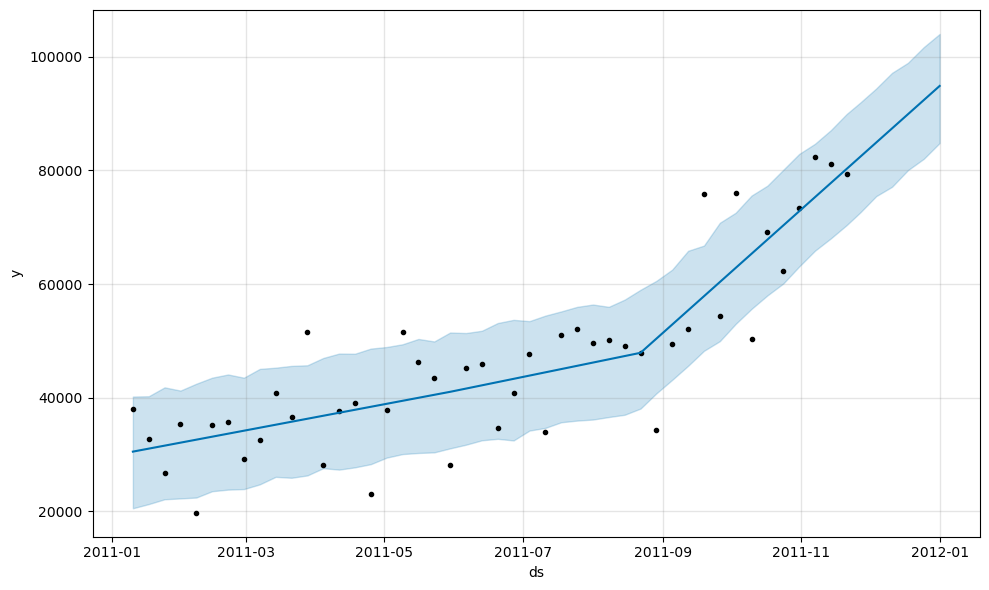

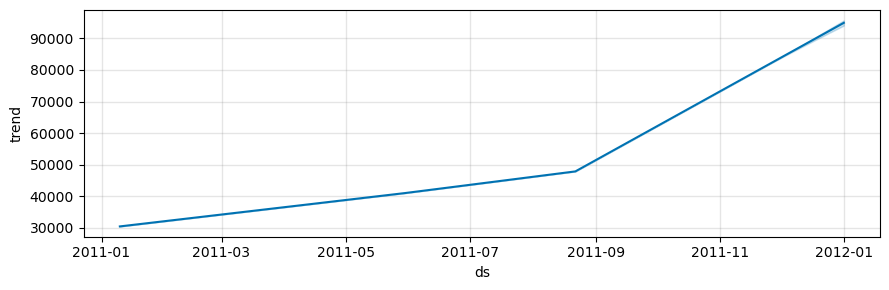

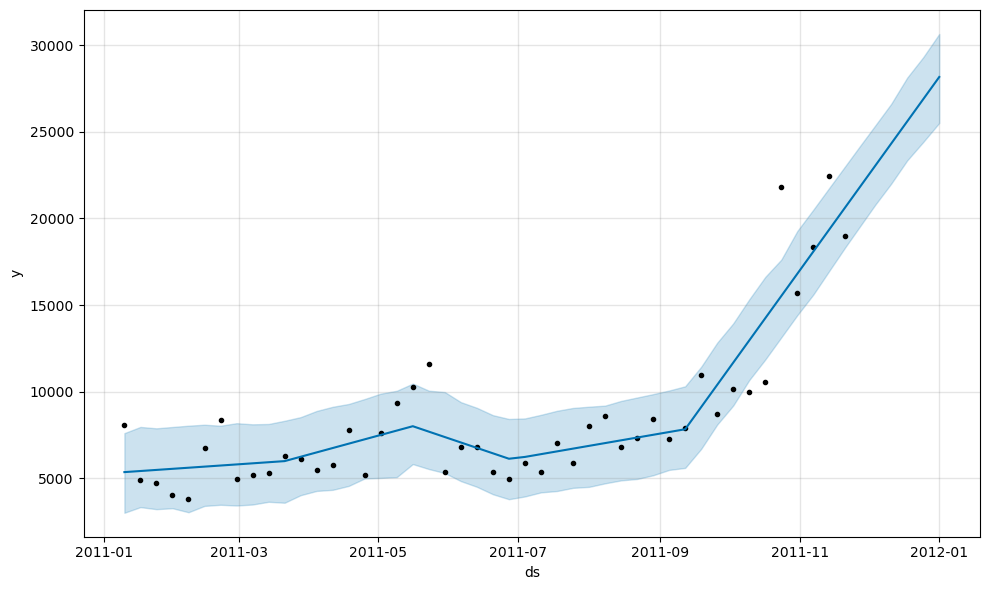

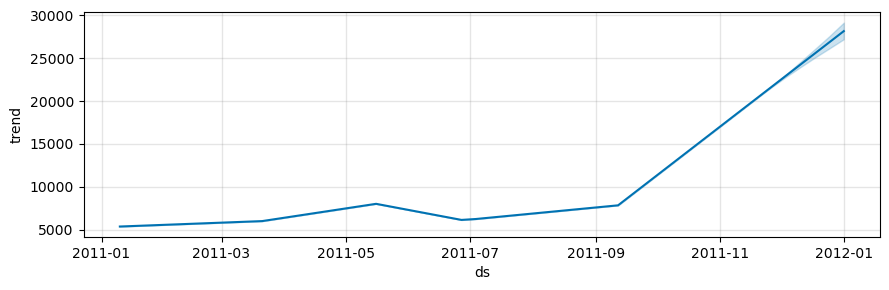

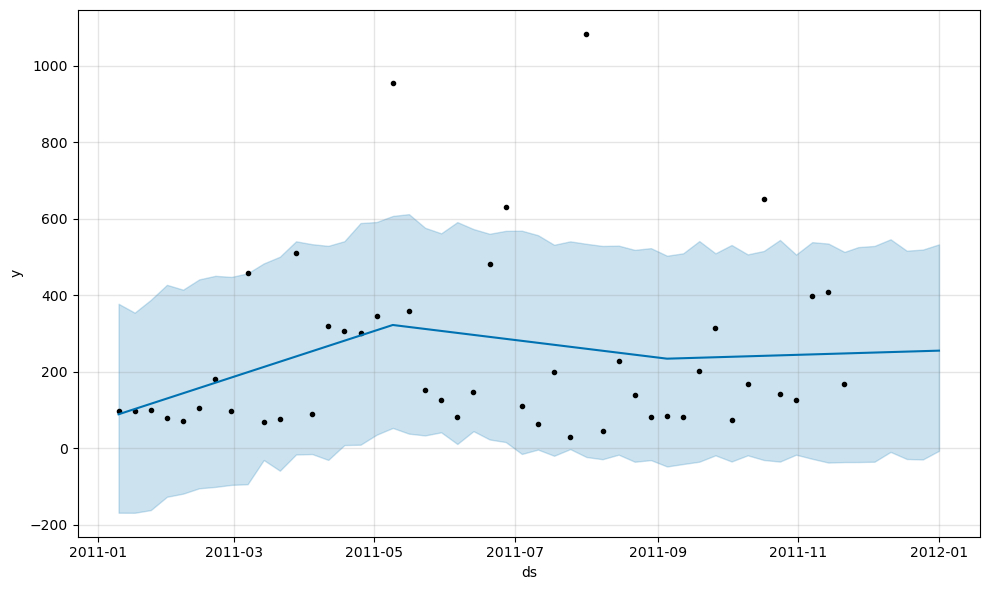

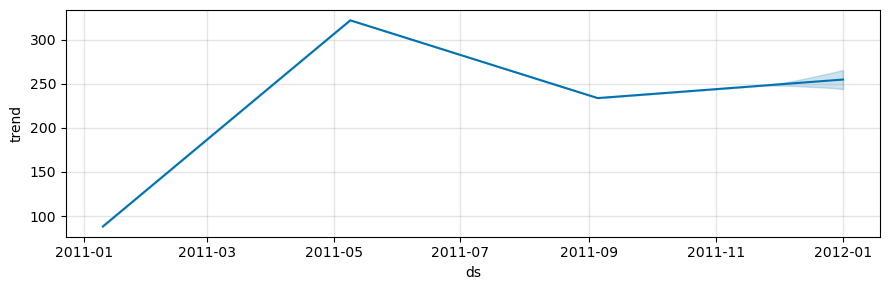

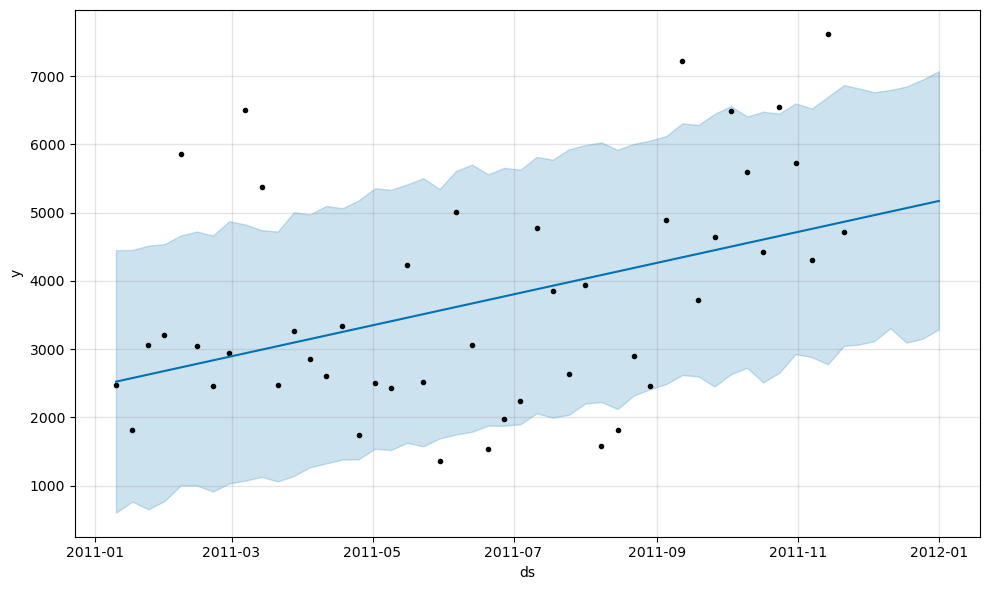

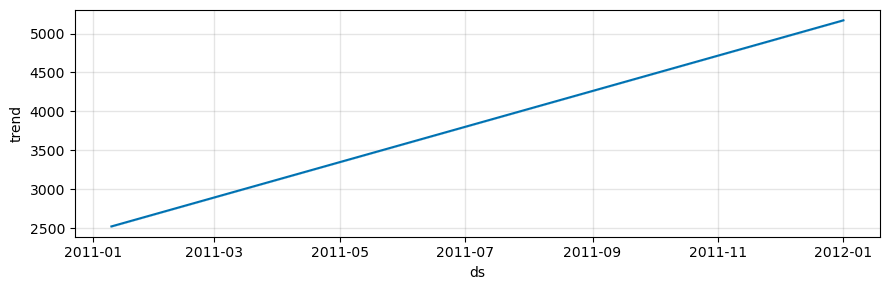

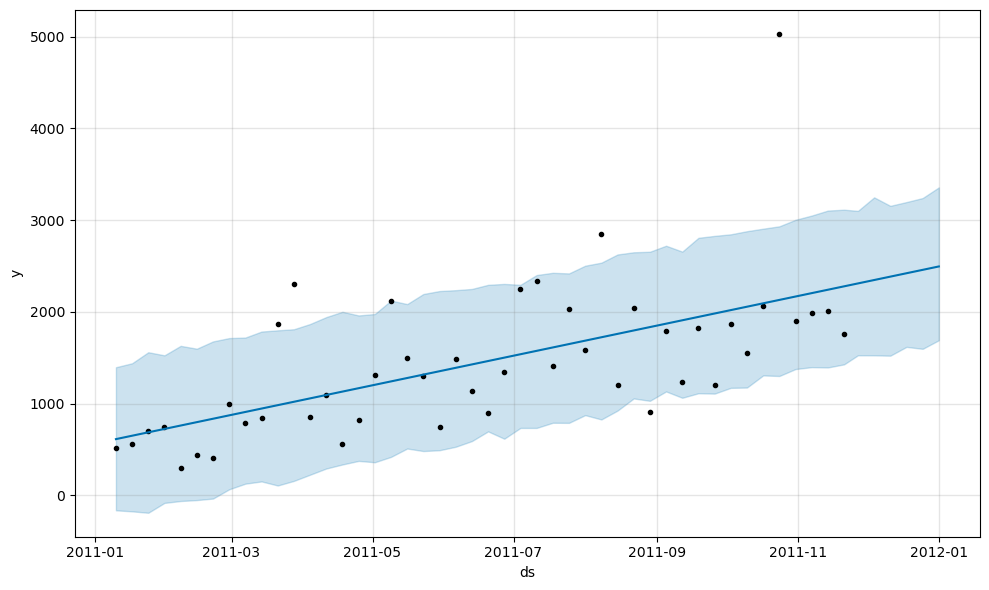

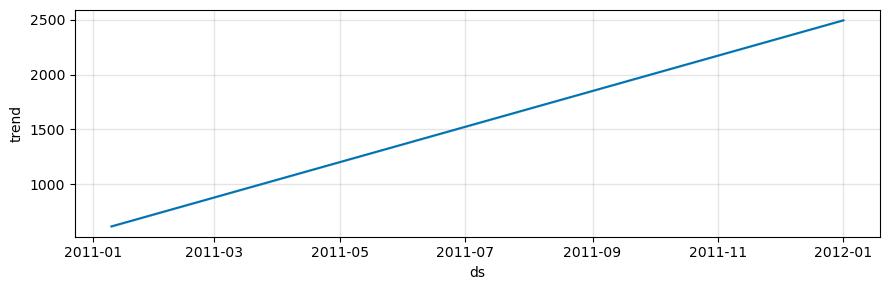

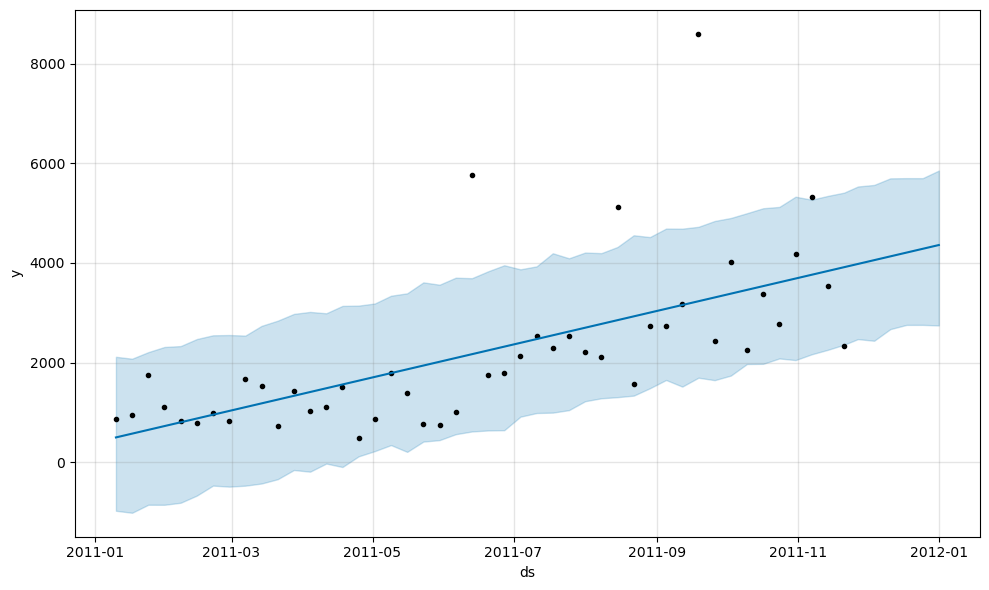

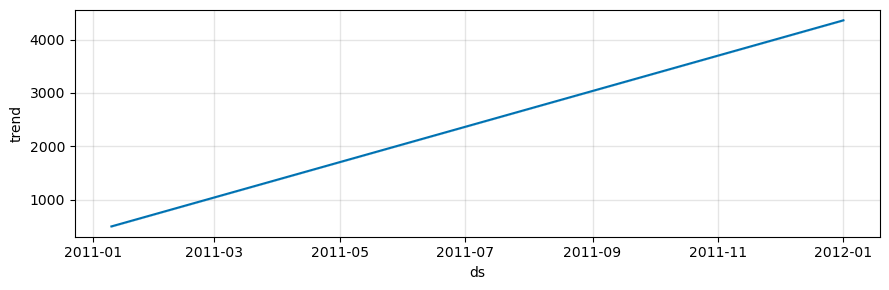

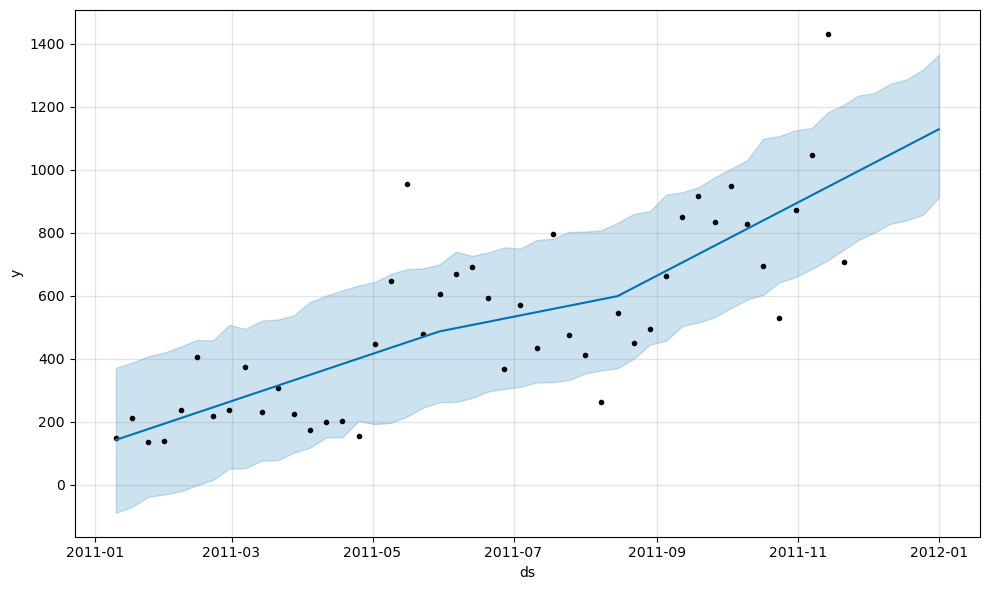

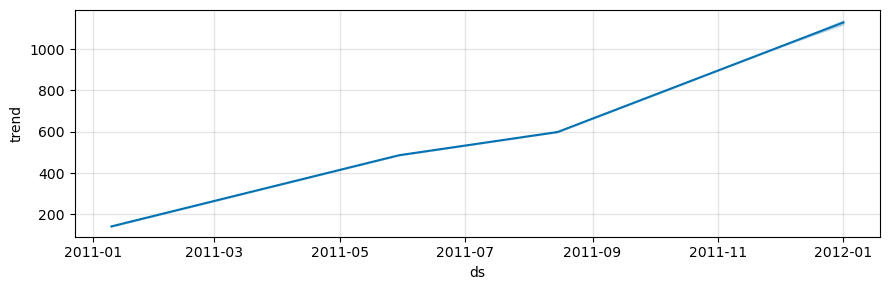

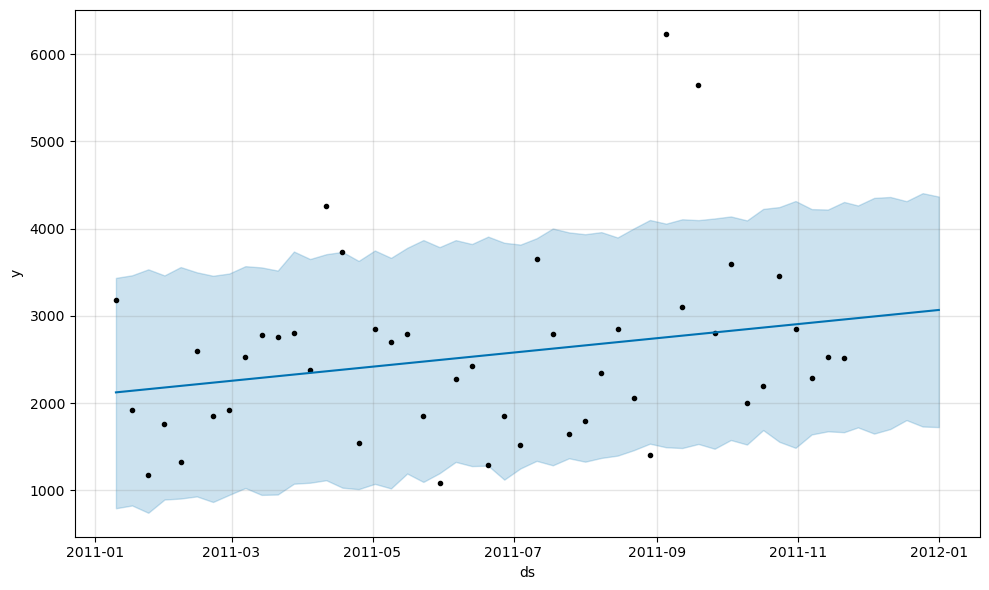

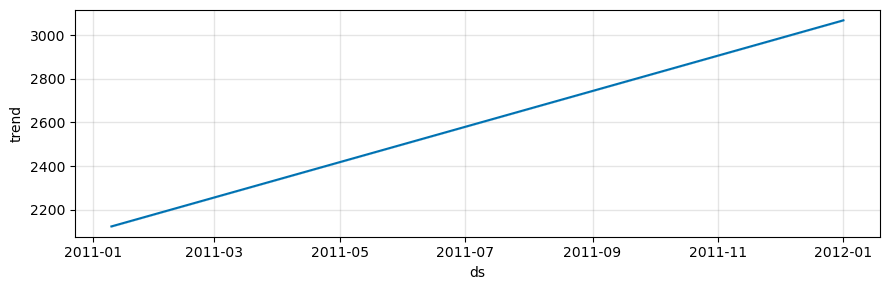

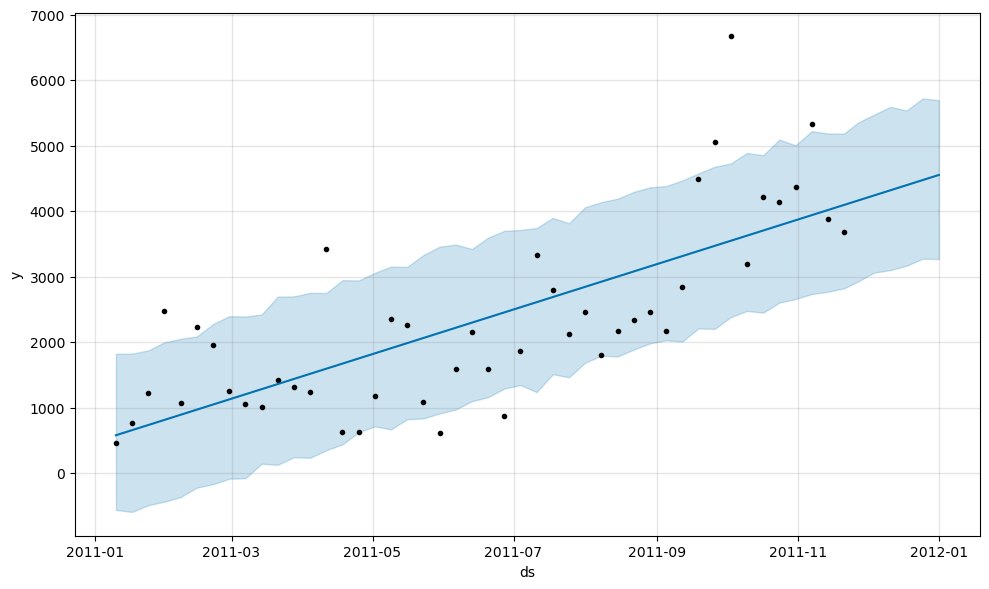

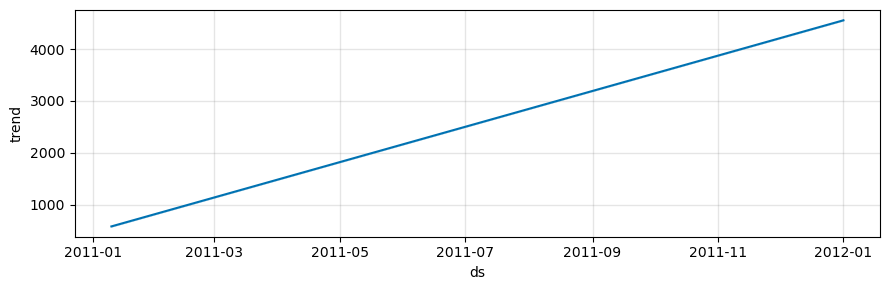

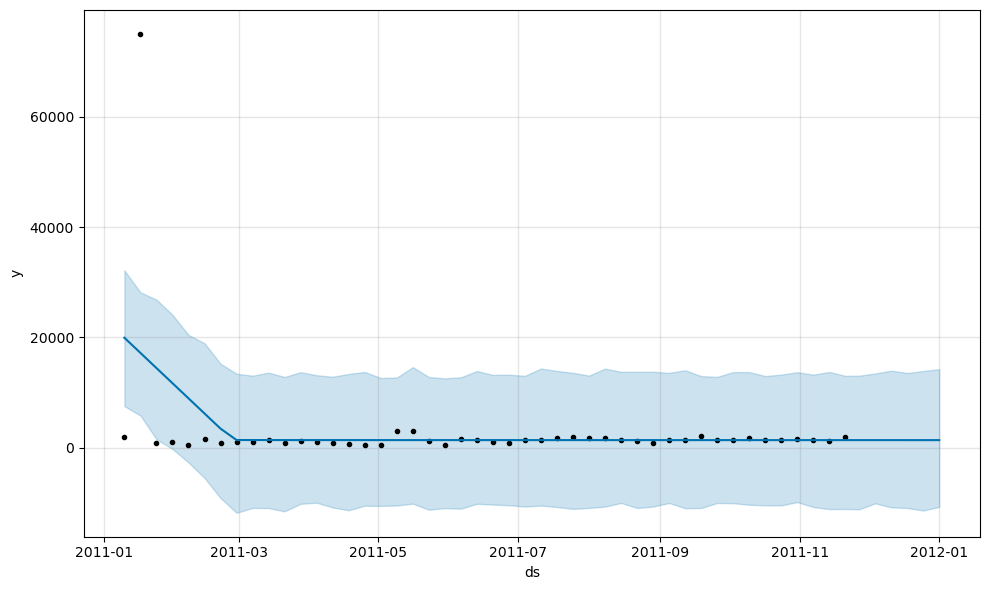

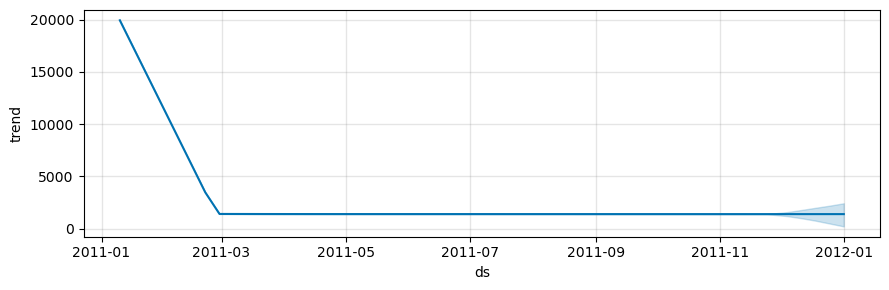

In [18]:
#PROPHET MODEL

forecasted_dfs = []

for category in Category_index:
    
    #formatting
    df_copy = sales_data[category].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for each category
    params_dict = dicts[category]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[category]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[category]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative'
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_weeks, freq = 'W')
    fcst_prophet_train = m.predict(future)
    
    fig1 = m.plot(fcst_prophet_train)
    fig2 = m.plot_components(fcst_prophet_train)

    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    
    forecasted_dfs.append(forecasted_df)
    

<h2>5.5 Summary</h2>

In this phase of Final Modeling, I performed an iterative process of hyperparameter tuning for each category to optimize the model's performance and improve the accuracy of the forecasting model. Mean Absolute Percentage Error (MAPE) was used as the model evaluation metric for the hyperparameter tuning as it is a reliable measure for gauging the accuracy of predictions especially in the context of time series forecasting. The hyperparameter tuning involved adjusting various parameters of the model, such as changepoint prior scale, seasonality prior scale, holidays prior scale and seasonality mode. These adjustments aimed to identify the combination of parameters that minimized the MAPE, resulting in a model that could provide more accurate predictions for each category. After the rounds of hyperparameter tuning, the final model has demonstrated a good performance by accurately forecasting sales for 9 out of the 14 categories for which the Mean Absolute Percentage Error (MAPE) consistently remained below the threshold of 18%.

**Results**

Results
Let's look into the specific forecasts generated for each category:

Miscellaneous (Category -1): Sales have been consistently low, around 30,000, but are showing an increasing trend since September. The forecast predicts a continued rise until the end of December.

Home Decorations (Category 0): Starting high in January, sales surge in mid-February, stabilizing at around 10,000. The forecast indicates that these levels will be maintained throughout December.

Kitchen Items (Category 1): Sales increased in May, dipped in July, and rose again after September. The forecast anticipates a further increase, reaching upwards of 25,000 in sales.

Light Holders (Category 2): Experiencing a slight sales increase in mid-May, light holders have stabilized around 200 units. The forecast suggests these levels will be maintained.

Bathroom Items (Category 4): Sales have shown a consistent increase, growing from 5,000 to nearly 18,000 by November. The forecast predicts a continued upward trajectory in December.

Bags (Category 5): Steadily increasing since January, starting at 2,000 sales and reaching 3,500 by November. The forecast suggests a continued steady rise.

Signs (Category 6): Similar to bags, signs have shown a consistent increase, going from 1,200 to over 4,000 in sales. The forecast anticipates this upward trend continuing.

Children's Toys (Category 8): Sales have been increasing, with a brief stability in late August, followed by continued growth. The forecast predicts an increase in December, reaching up to 1,250 sales.

Stationary Items (Category 10): Sales have remained relatively stable, reaching almost 1,000 items in November. The forecast indicates a slight increase to just over 1,000 in December.

Gifts (Category 12): Sales have been consistently below 1,000 items each month but exhibit a notable increase starting mid-November. The forecast suggests this upward trend will persist in December.

Category 7 has the highest MAPE, indicating a significant error of 46%. Similarly, Categories 11, 13, and 9 also has high MAPE values, exceeding 30%. Therefore, using the current model for forecasting Category 7 items is not recommended, as it may result in suboptimal inventory management, inefficient resource allocation, and other potential business decision inaccuracies. To enhance the accuracy of predictions for these categories, it is advisable to delve deeper into their characteristics. This could involve acquiring more data, extending the observation period, or exploring alternative models in future research.